##### Copyright 2020 The TensorFlow Hub Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/classify_text_with_bert"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/bert/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

# Classify text with BERT

This tutorial contains complete code to fine-tune BERT to perform sentiment analysis on a dataset of plain-text IMDB movie reviews.
In addition to training a model, you will learn how to preprocess text into an appropriate format.

In this notebook, you will:

- Load the IMDB dataset
- Load a BERT model from TensorFlow Hub
- Build your own model by combining BERT with a classifier
- Train your own model, fine-tuning BERT as part of that
- Save your model and use it to classify sentences

If you're new to working with the IMDB dataset, please see [Basic text classification](https://www.tensorflow.org/tutorials/keras/text_classification) for more details.

## About BERT

[BERT](https://arxiv.org/abs/1810.04805) and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers. 

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.


## Setup


In [2]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U tensorflow-text

You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [3]:
!pip install -q tf-models-official

In [4]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/).

### Download the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.


In [5]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

   16384/84125825 [..............................] - ETA: 0s

   24576/84125825 [..............................] - ETA: 7:45

   57344/84125825 [..............................] - ETA: 6:38

   90112/84125825 [..............................] - ETA: 6:20

  139264/84125825 [..............................] - ETA: 5:28

  188416/84125825 [..............................] - ETA: 5:03

  270336/84125825 [..............................] - ETA: 4:13

  385024/84125825 [..............................] - ETA: 3:27

  516096/84125825 [..............................] - ETA: 2:56

  696320/84125825 [..............................] - ETA: 2:26

  942080/84125825 [..............................] - ETA: 2:00

 1269760/84125825 [..............................] - ETA: 1:37

 1662976/84125825 [..............................] - ETA: 1:21

 2170880/84125825 [..............................] - ETA: 1:06

 2826240/84125825 [>.............................] - ETA: 54s 

 3629056/84125825 [>.............................] - ETA: 45s

 4661248/84125825 [>.............................] - ETA: 37s

 5939200/84125825 [=>............................] - ETA: 30s

 7528448/84125825 [=>............................] - ETA: 24s

 8691712/84125825 [==>...........................] - ETA: 22s

10362880/84125825 [==>...........................] - ETA: 19s

10461184/84125825 [==>...........................] - ETA: 19s

12525568/84125825 [===>..........................] - ETA: 16s

14966784/84125825 [====>.........................] - ETA: 13s

18046976/84125825 [=====>........................] - ETA: 11s

20668416/84125825 [======>.......................] - ETA: 9s 

21176320/84125825 [======>.......................] - ETA: 9s

23519232/84125825 [=======>......................] - ETA: 8s

24305664/84125825 [=======>......................] - ETA: 8s

26533888/84125825 [========>.....................] - ETA: 7s

27418624/84125825 [========>.....................] - ETA: 7s

27926528/84125825 [========>.....................] - ETA: 7s

30466048/84125825 [=========>....................] - ETA: 6s

30547968/84125825 [=========>....................] - ETA: 6s

32104448/84125825 [==========>...................] - ETA: 6s

33628160/84125825 [==========>...................] - ETA: 5s

34742272/84125825 [===========>..................] - ETA: 5s

36757504/84125825 [============>.................] - ETA: 5s

37658624/84125825 [============>.................] - ETA: 4s

39903232/84125825 [=============>................] - ETA: 4s

40460288/84125825 [=============>................] - ETA: 4s

43032576/84125825 [==============>...............] - ETA: 4s

43589632/84125825 [==============>...............] - ETA: 3s

46145536/84125825 [===============>..............] - ETA: 3s

46718976/84125825 [===============>..............] - ETA: 3s

49291264/84125825 [================>.............] - ETA: 3s

49831936/84125825 [================>.............] - ETA: 3s

51535872/84125825 [=================>............] - ETA: 2s

52895744/84125825 [=================>............] - ETA: 2s

53338112/84125825 [==================>...........] - ETA: 2s

55566336/84125825 [==================>...........] - ETA: 2s

55894016/84125825 [==================>...........] - ETA: 2s

59039744/84125825 [====================>.........] - ETA: 2s

61284352/84125825 [====================>.........] - ETA: 1s

63528960/84125825 [=====================>........] - ETA: 1s

65806336/84125825 [======================>.......] - ETA: 1s

68116480/84125825 [=======================>......] - ETA: 1s

70459392/84125825 [========================>.....] - ETA: 1s

72818688/84125825 [========================>.....] - ETA: 0s

75210752/84125825 [=========================>....] - ETA: 0s

77635584/84125825 [==========================>...] - ETA: 0s

80093184/84125825 [===========================>..] - ETA: 0s

82583552/84125825 [============================>.] - ETA: 0s

84131840/84125825 [==============================] - 6s 0us/step


84140032/84125825 [==============================] - 6s 0us/step


Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


Found 25000 files belonging to 2 classes.


Let's take a look at a few reviews.

In [7]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

2021-10-26 11:11:26.068505: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Loading models from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The model documentation on TensorFlow Hub has more details and references to the
research literature. Follow the links above, or click on the [`tfhub.dev`](http://tfhub.dev) URL
printed after the next cell execution.

The suggestion is to start with a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose
one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.

Aside from the models available below, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) of the models that are larger and can yield even better accuracy, but they are too big to be fine-tuned on a single GPU. You will be able to do that on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).

You'll see in the code below that switching the tfhub.dev URL is enough to try any of these models, because all the differences between them are encapsulated in the SavedModels from TF Hub.

In [8]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## The preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model, which you can read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.

Note: You will load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose your fine-tuned model. This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

In [9]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [10]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (`input_words_id`, `input_mask` and `input_type_ids`).

Some other important points:
- The input is truncated to 128 tokens. The number of tokens can be customized, and you can see more details on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

## Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [11]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [12]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262873  0.99280983 -0.1861186   0.36673835  0.15233682  0.65504444
  0.9681154  -0.9486272   0.00216158 -0.9877732   0.0684272  -0.9763061 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946388  0.3432126   0.33231565 ...  0.21300787  0.7102078
  -0.05771166]
 [-0.28742015  0.31981024 -0.2301858  ...  0.58455074 -0.21329722
   0.7269209 ]
 [-0.66157013  0.6887685  -0.87432927 ...  0.10877253 -0.26173282
   0.47855264]
 ...
 [-0.2256118  -0.28925604 -0.07064401 ...  0.4756601   0.8327715
   0.40025353]
 [-0.29824278 -0.27473143 -0.05450511 ...  0.48849759  1.0955356
   0.18163344]
 [-0.44378197  0.00930723  0.07223766 ...  0.1729009   1.1833246
   0.07897988]]


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` represents each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

## Define your model

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Note: for more information about the base model's input and output you can follow the model's URL for documentation. Here specifically, you don't need to worry about it because the preprocessing model will take care of that for you.


In [13]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [14]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.4240774]], shape=(1, 1), dtype=float32)


The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

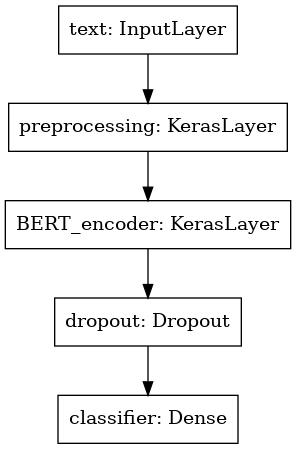

In [15]:
tf.keras.utils.plot_model(classifier_model)

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


In [16]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [17]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [18]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [19]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5


  1/625 [..............................] - ETA: 53:12 - loss: 0.7356 - binary_accuracy: 0.7188

  2/625 [..............................] - ETA: 1:20 - loss: 0.7472 - binary_accuracy: 0.5938 

  3/625 [..............................] - ETA: 1:17 - loss: 0.7405 - binary_accuracy: 0.5521

  4/625 [..............................] - ETA: 1:15 - loss: 0.7428 - binary_accuracy: 0.5625

  5/625 [..............................] - ETA: 1:14 - loss: 0.7412 - binary_accuracy: 0.5375

  6/625 [..............................] - ETA: 1:13 - loss: 0.7333 - binary_accuracy: 0.5469

  7/625 [..............................] - ETA: 1:13 - loss: 0.7344 - binary_accuracy: 0.5536

  8/625 [..............................] - ETA: 1:13 - loss: 0.7396 - binary_accuracy: 0.5508

  9/625 [..............................] - ETA: 1:12 - loss: 0.7379 - binary_accuracy: 0.5417

 10/625 [..............................] - ETA: 1:12 - loss: 0.7359 - binary_accuracy: 0.5312

 11/625 [..............................] - ETA: 1:12 - loss: 0.7425 - binary_accuracy: 0.5170

 12/625 [..............................] - ETA: 1:11 - loss: 0.7351 - binary_accuracy: 0.5104

 13/625 [..............................] - ETA: 1:11 - loss: 0.7359 - binary_accuracy: 0.5096

 14/625 [..............................] - ETA: 1:11 - loss: 0.7358 - binary_accuracy: 0.5045

 15/625 [..............................] - ETA: 1:11 - loss: 0.7366 - binary_accuracy: 0.5063

 16/625 [..............................] - ETA: 1:10 - loss: 0.7407 - binary_accuracy: 0.5098

 17/625 [..............................] - ETA: 1:10 - loss: 0.7388 - binary_accuracy: 0.5018

 18/625 [..............................] - ETA: 1:10 - loss: 0.7364 - binary_accuracy: 0.5069

 19/625 [..............................] - ETA: 1:10 - loss: 0.7376 - binary_accuracy: 0.5049

 20/625 [..............................] - ETA: 1:10 - loss: 0.7349 - binary_accuracy: 0.5047

 21/625 [>.............................] - ETA: 1:10 - loss: 0.7355 - binary_accuracy: 0.5060

 22/625 [>.............................] - ETA: 1:10 - loss: 0.7375 - binary_accuracy: 0.5014

 23/625 [>.............................] - ETA: 1:10 - loss: 0.7385 - binary_accuracy: 0.5014

 24/625 [>.............................] - ETA: 1:09 - loss: 0.7388 - binary_accuracy: 0.5078

 25/625 [>.............................] - ETA: 1:09 - loss: 0.7401 - binary_accuracy: 0.5038

 26/625 [>.............................] - ETA: 1:09 - loss: 0.7375 - binary_accuracy: 0.5072

 27/625 [>.............................] - ETA: 1:09 - loss: 0.7369 - binary_accuracy: 0.5046

 28/625 [>.............................] - ETA: 1:09 - loss: 0.7363 - binary_accuracy: 0.5078

 29/625 [>.............................] - ETA: 1:09 - loss: 0.7350 - binary_accuracy: 0.5065

 30/625 [>.............................] - ETA: 1:09 - loss: 0.7348 - binary_accuracy: 0.5052

 31/625 [>.............................] - ETA: 1:09 - loss: 0.7331 - binary_accuracy: 0.5071

 32/625 [>.............................] - ETA: 1:08 - loss: 0.7316 - binary_accuracy: 0.5107

 33/625 [>.............................] - ETA: 1:08 - loss: 0.7292 - binary_accuracy: 0.5142

 34/625 [>.............................] - ETA: 1:08 - loss: 0.7301 - binary_accuracy: 0.5119

 35/625 [>.............................] - ETA: 1:08 - loss: 0.7283 - binary_accuracy: 0.5143

 36/625 [>.............................] - ETA: 1:08 - loss: 0.7284 - binary_accuracy: 0.5139

 37/625 [>.............................] - ETA: 1:08 - loss: 0.7273 - binary_accuracy: 0.5127

 38/625 [>.............................] - ETA: 1:08 - loss: 0.7247 - binary_accuracy: 0.5148

 39/625 [>.............................] - ETA: 1:08 - loss: 0.7252 - binary_accuracy: 0.5144

 40/625 [>.............................] - ETA: 1:07 - loss: 0.7246 - binary_accuracy: 0.5125

 41/625 [>.............................] - ETA: 1:07 - loss: 0.7235 - binary_accuracy: 0.5152

 42/625 [=>............................] - ETA: 1:07 - loss: 0.7221 - binary_accuracy: 0.5171

 43/625 [=>............................] - ETA: 1:07 - loss: 0.7214 - binary_accuracy: 0.5196

 44/625 [=>............................] - ETA: 1:07 - loss: 0.7199 - binary_accuracy: 0.5185

 45/625 [=>............................] - ETA: 1:07 - loss: 0.7197 - binary_accuracy: 0.5201

 46/625 [=>............................] - ETA: 1:07 - loss: 0.7189 - binary_accuracy: 0.5238

 47/625 [=>............................] - ETA: 1:07 - loss: 0.7195 - binary_accuracy: 0.5233

 48/625 [=>............................] - ETA: 1:06 - loss: 0.7197 - binary_accuracy: 0.5267

 49/625 [=>............................] - ETA: 1:06 - loss: 0.7201 - binary_accuracy: 0.5268

 50/625 [=>............................] - ETA: 1:06 - loss: 0.7183 - binary_accuracy: 0.5294

 51/625 [=>............................] - ETA: 1:06 - loss: 0.7181 - binary_accuracy: 0.5294

 52/625 [=>............................] - ETA: 1:06 - loss: 0.7172 - binary_accuracy: 0.5300

 53/625 [=>............................] - ETA: 1:06 - loss: 0.7163 - binary_accuracy: 0.5289

 54/625 [=>............................] - ETA: 1:06 - loss: 0.7160 - binary_accuracy: 0.5295

 55/625 [=>............................] - ETA: 1:06 - loss: 0.7162 - binary_accuracy: 0.5290

 56/625 [=>............................] - ETA: 1:05 - loss: 0.7158 - binary_accuracy: 0.5296

 57/625 [=>............................] - ETA: 1:05 - loss: 0.7165 - binary_accuracy: 0.5291

 58/625 [=>............................] - ETA: 1:05 - loss: 0.7169 - binary_accuracy: 0.5259

 59/625 [=>............................] - ETA: 1:05 - loss: 0.7156 - binary_accuracy: 0.5286

 60/625 [=>............................] - ETA: 1:05 - loss: 0.7144 - binary_accuracy: 0.5302

 61/625 [=>............................] - ETA: 1:05 - loss: 0.7129 - binary_accuracy: 0.5323

 62/625 [=>............................] - ETA: 1:05 - loss: 0.7129 - binary_accuracy: 0.5328

 63/625 [==>...........................] - ETA: 1:05 - loss: 0.7130 - binary_accuracy: 0.5332

 64/625 [==>...........................] - ETA: 1:04 - loss: 0.7119 - binary_accuracy: 0.5327

 65/625 [==>...........................] - ETA: 1:04 - loss: 0.7120 - binary_accuracy: 0.5341

 66/625 [==>...........................] - ETA: 1:04 - loss: 0.7112 - binary_accuracy: 0.5350

 67/625 [==>...........................] - ETA: 1:04 - loss: 0.7108 - binary_accuracy: 0.5354

 68/625 [==>...........................] - ETA: 1:04 - loss: 0.7098 - binary_accuracy: 0.5368

 69/625 [==>...........................] - ETA: 1:04 - loss: 0.7100 - binary_accuracy: 0.5371

 70/625 [==>...........................] - ETA: 1:04 - loss: 0.7096 - binary_accuracy: 0.5379

 71/625 [==>...........................] - ETA: 1:04 - loss: 0.7090 - binary_accuracy: 0.5405

 72/625 [==>...........................] - ETA: 1:04 - loss: 0.7085 - binary_accuracy: 0.5404

 73/625 [==>...........................] - ETA: 1:03 - loss: 0.7086 - binary_accuracy: 0.5385

 74/625 [==>...........................] - ETA: 1:03 - loss: 0.7082 - binary_accuracy: 0.5380

 75/625 [==>...........................] - ETA: 1:03 - loss: 0.7076 - binary_accuracy: 0.5367

 76/625 [==>...........................] - ETA: 1:03 - loss: 0.7074 - binary_accuracy: 0.5350

 77/625 [==>...........................] - ETA: 1:03 - loss: 0.7069 - binary_accuracy: 0.5353

 78/625 [==>...........................] - ETA: 1:03 - loss: 0.7055 - binary_accuracy: 0.5357

 79/625 [==>...........................] - ETA: 1:03 - loss: 0.7046 - binary_accuracy: 0.5368

 80/625 [==>...........................] - ETA: 1:03 - loss: 0.7034 - binary_accuracy: 0.5371

 81/625 [==>...........................] - ETA: 1:03 - loss: 0.7022 - binary_accuracy: 0.5378

 82/625 [==>...........................] - ETA: 1:02 - loss: 0.7016 - binary_accuracy: 0.5381

 83/625 [==>...........................] - ETA: 1:02 - loss: 0.7006 - binary_accuracy: 0.5392

 84/625 [===>..........................] - ETA: 1:02 - loss: 0.6992 - binary_accuracy: 0.5409

 85/625 [===>..........................] - ETA: 1:02 - loss: 0.6995 - binary_accuracy: 0.5415

 86/625 [===>..........................] - ETA: 1:02 - loss: 0.6994 - binary_accuracy: 0.5414

 87/625 [===>..........................] - ETA: 1:02 - loss: 0.6978 - binary_accuracy: 0.5427

 88/625 [===>..........................] - ETA: 1:02 - loss: 0.6970 - binary_accuracy: 0.5423

 89/625 [===>..........................] - ETA: 1:02 - loss: 0.6971 - binary_accuracy: 0.5421

 90/625 [===>..........................] - ETA: 1:01 - loss: 0.6959 - binary_accuracy: 0.5427

 91/625 [===>..........................] - ETA: 1:01 - loss: 0.6958 - binary_accuracy: 0.5429

 92/625 [===>..........................] - ETA: 1:01 - loss: 0.6948 - binary_accuracy: 0.5452

 93/625 [===>..........................] - ETA: 1:01 - loss: 0.6929 - binary_accuracy: 0.5467

 94/625 [===>..........................] - ETA: 1:01 - loss: 0.6921 - binary_accuracy: 0.5485

 95/625 [===>..........................] - ETA: 1:01 - loss: 0.6918 - binary_accuracy: 0.5493

 96/625 [===>..........................] - ETA: 1:01 - loss: 0.6913 - binary_accuracy: 0.5508

 97/625 [===>..........................] - ETA: 1:01 - loss: 0.6900 - binary_accuracy: 0.5522

 98/625 [===>..........................] - ETA: 1:01 - loss: 0.6894 - binary_accuracy: 0.5520

 99/625 [===>..........................] - ETA: 1:00 - loss: 0.6886 - binary_accuracy: 0.5533

100/625 [===>..........................] - ETA: 1:00 - loss: 0.6878 - binary_accuracy: 0.5544

101/625 [===>..........................] - ETA: 1:00 - loss: 0.6885 - binary_accuracy: 0.5538

102/625 [===>..........................] - ETA: 1:00 - loss: 0.6874 - binary_accuracy: 0.5536

103/625 [===>..........................] - ETA: 1:00 - loss: 0.6866 - binary_accuracy: 0.5537

104/625 [===>..........................] - ETA: 1:00 - loss: 0.6860 - binary_accuracy: 0.5547

105/625 [====>.........................] - ETA: 1:00 - loss: 0.6861 - binary_accuracy: 0.5545

106/625 [====>.........................] - ETA: 1:00 - loss: 0.6854 - binary_accuracy: 0.5554

107/625 [====>.........................] - ETA: 59s - loss: 0.6842 - binary_accuracy: 0.5570 

108/625 [====>.........................] - ETA: 59s - loss: 0.6832 - binary_accuracy: 0.5576

109/625 [====>.........................] - ETA: 59s - loss: 0.6828 - binary_accuracy: 0.5571

110/625 [====>.........................] - ETA: 59s - loss: 0.6823 - binary_accuracy: 0.5568

111/625 [====>.........................] - ETA: 59s - loss: 0.6810 - binary_accuracy: 0.5572

112/625 [====>.........................] - ETA: 59s - loss: 0.6793 - binary_accuracy: 0.5589

113/625 [====>.........................] - ETA: 59s - loss: 0.6788 - binary_accuracy: 0.5592

114/625 [====>.........................] - ETA: 59s - loss: 0.6785 - binary_accuracy: 0.5603

115/625 [====>.........................] - ETA: 59s - loss: 0.6773 - binary_accuracy: 0.5620

116/625 [====>.........................] - ETA: 58s - loss: 0.6771 - binary_accuracy: 0.5620

117/625 [====>.........................] - ETA: 58s - loss: 0.6769 - binary_accuracy: 0.5614

118/625 [====>.........................] - ETA: 58s - loss: 0.6757 - binary_accuracy: 0.5620

119/625 [====>.........................] - ETA: 58s - loss: 0.6747 - binary_accuracy: 0.5638

120/625 [====>.........................] - ETA: 58s - loss: 0.6738 - binary_accuracy: 0.5661

121/625 [====>.........................] - ETA: 58s - loss: 0.6726 - binary_accuracy: 0.5664

122/625 [====>.........................] - ETA: 58s - loss: 0.6717 - binary_accuracy: 0.5669

123/625 [====>.........................] - ETA: 58s - loss: 0.6709 - binary_accuracy: 0.5678

124/625 [====>.........................] - ETA: 57s - loss: 0.6702 - binary_accuracy: 0.5685

125/625 [=====>........................] - ETA: 57s - loss: 0.6689 - binary_accuracy: 0.5710

126/625 [=====>........................] - ETA: 57s - loss: 0.6685 - binary_accuracy: 0.5712

127/625 [=====>........................] - ETA: 57s - loss: 0.6670 - binary_accuracy: 0.5731

128/625 [=====>........................] - ETA: 57s - loss: 0.6653 - binary_accuracy: 0.5754

129/625 [=====>........................] - ETA: 57s - loss: 0.6648 - binary_accuracy: 0.5782

130/625 [=====>........................] - ETA: 57s - loss: 0.6651 - binary_accuracy: 0.5776

131/625 [=====>........................] - ETA: 57s - loss: 0.6640 - binary_accuracy: 0.5792

132/625 [=====>........................] - ETA: 57s - loss: 0.6632 - binary_accuracy: 0.5800

133/625 [=====>........................] - ETA: 56s - loss: 0.6619 - binary_accuracy: 0.5813

134/625 [=====>........................] - ETA: 56s - loss: 0.6613 - binary_accuracy: 0.5819

135/625 [=====>........................] - ETA: 56s - loss: 0.6607 - binary_accuracy: 0.5826

136/625 [=====>........................] - ETA: 56s - loss: 0.6594 - binary_accuracy: 0.5843

137/625 [=====>........................] - ETA: 56s - loss: 0.6581 - binary_accuracy: 0.5860

138/625 [=====>........................] - ETA: 56s - loss: 0.6572 - binary_accuracy: 0.5870

139/625 [=====>........................] - ETA: 56s - loss: 0.6557 - binary_accuracy: 0.5872

140/625 [=====>........................] - ETA: 56s - loss: 0.6556 - binary_accuracy: 0.5875

141/625 [=====>........................] - ETA: 55s - loss: 0.6553 - binary_accuracy: 0.5875

142/625 [=====>........................] - ETA: 55s - loss: 0.6543 - binary_accuracy: 0.5880

143/625 [=====>........................] - ETA: 55s - loss: 0.6537 - binary_accuracy: 0.5892

144/625 [=====>........................] - ETA: 55s - loss: 0.6523 - binary_accuracy: 0.5905

145/625 [=====>........................] - ETA: 55s - loss: 0.6520 - binary_accuracy: 0.5914

146/625 [======>.......................] - ETA: 55s - loss: 0.6507 - binary_accuracy: 0.5925

147/625 [======>.......................] - ETA: 55s - loss: 0.6499 - binary_accuracy: 0.5931

148/625 [======>.......................] - ETA: 55s - loss: 0.6491 - binary_accuracy: 0.5935

149/625 [======>.......................] - ETA: 55s - loss: 0.6477 - binary_accuracy: 0.5952

150/625 [======>.......................] - ETA: 54s - loss: 0.6474 - binary_accuracy: 0.5950

151/625 [======>.......................] - ETA: 54s - loss: 0.6466 - binary_accuracy: 0.5964

152/625 [======>.......................] - ETA: 54s - loss: 0.6457 - binary_accuracy: 0.5975

153/625 [======>.......................] - ETA: 54s - loss: 0.6445 - binary_accuracy: 0.5980

154/625 [======>.......................] - ETA: 54s - loss: 0.6444 - binary_accuracy: 0.5990

155/625 [======>.......................] - ETA: 54s - loss: 0.6439 - binary_accuracy: 0.5992

156/625 [======>.......................] - ETA: 54s - loss: 0.6422 - binary_accuracy: 0.6006

157/625 [======>.......................] - ETA: 54s - loss: 0.6418 - binary_accuracy: 0.6015

158/625 [======>.......................] - ETA: 54s - loss: 0.6418 - binary_accuracy: 0.6027

159/625 [======>.......................] - ETA: 53s - loss: 0.6412 - binary_accuracy: 0.6036

160/625 [======>.......................] - ETA: 53s - loss: 0.6401 - binary_accuracy: 0.6051

161/625 [======>.......................] - ETA: 53s - loss: 0.6387 - binary_accuracy: 0.6064

162/625 [======>.......................] - ETA: 53s - loss: 0.6380 - binary_accuracy: 0.6071

163/625 [======>.......................] - ETA: 53s - loss: 0.6366 - binary_accuracy: 0.6081

164/625 [======>.......................] - ETA: 53s - loss: 0.6366 - binary_accuracy: 0.6082

165/625 [======>.......................] - ETA: 53s - loss: 0.6352 - binary_accuracy: 0.6097

166/625 [======>.......................] - ETA: 53s - loss: 0.6346 - binary_accuracy: 0.6096

167/625 [=======>......................] - ETA: 53s - loss: 0.6336 - binary_accuracy: 0.6102

168/625 [=======>......................] - ETA: 52s - loss: 0.6333 - binary_accuracy: 0.6105

169/625 [=======>......................] - ETA: 52s - loss: 0.6322 - binary_accuracy: 0.6113

170/625 [=======>......................] - ETA: 52s - loss: 0.6311 - binary_accuracy: 0.6121

171/625 [=======>......................] - ETA: 52s - loss: 0.6305 - binary_accuracy: 0.6128

172/625 [=======>......................] - ETA: 52s - loss: 0.6291 - binary_accuracy: 0.6139

173/625 [=======>......................] - ETA: 52s - loss: 0.6283 - binary_accuracy: 0.6143

174/625 [=======>......................] - ETA: 52s - loss: 0.6271 - binary_accuracy: 0.6153

175/625 [=======>......................] - ETA: 52s - loss: 0.6258 - binary_accuracy: 0.6166

176/625 [=======>......................] - ETA: 51s - loss: 0.6252 - binary_accuracy: 0.6170

177/625 [=======>......................] - ETA: 51s - loss: 0.6244 - binary_accuracy: 0.6176

178/625 [=======>......................] - ETA: 51s - loss: 0.6237 - binary_accuracy: 0.6183

179/625 [=======>......................] - ETA: 51s - loss: 0.6225 - binary_accuracy: 0.6192

180/625 [=======>......................] - ETA: 51s - loss: 0.6215 - binary_accuracy: 0.6200

181/625 [=======>......................] - ETA: 51s - loss: 0.6205 - binary_accuracy: 0.6205

182/625 [=======>......................] - ETA: 51s - loss: 0.6200 - binary_accuracy: 0.6209

183/625 [=======>......................] - ETA: 51s - loss: 0.6200 - binary_accuracy: 0.6214

184/625 [=======>......................] - ETA: 51s - loss: 0.6196 - binary_accuracy: 0.6219

185/625 [=======>......................] - ETA: 50s - loss: 0.6180 - binary_accuracy: 0.6230

186/625 [=======>......................] - ETA: 50s - loss: 0.6171 - binary_accuracy: 0.6238

187/625 [=======>......................] - ETA: 50s - loss: 0.6159 - binary_accuracy: 0.6247

188/625 [========>.....................] - ETA: 50s - loss: 0.6143 - binary_accuracy: 0.6260

189/625 [========>.....................] - ETA: 50s - loss: 0.6131 - binary_accuracy: 0.6271

190/625 [========>.....................] - ETA: 50s - loss: 0.6128 - binary_accuracy: 0.6275

191/625 [========>.....................] - ETA: 50s - loss: 0.6118 - binary_accuracy: 0.6278

192/625 [========>.....................] - ETA: 50s - loss: 0.6107 - binary_accuracy: 0.6283

193/625 [========>.....................] - ETA: 50s - loss: 0.6105 - binary_accuracy: 0.6287

194/625 [========>.....................] - ETA: 49s - loss: 0.6098 - binary_accuracy: 0.6297

195/625 [========>.....................] - ETA: 49s - loss: 0.6089 - binary_accuracy: 0.6304

196/625 [========>.....................] - ETA: 49s - loss: 0.6091 - binary_accuracy: 0.6307

197/625 [========>.....................] - ETA: 49s - loss: 0.6083 - binary_accuracy: 0.6320

198/625 [========>.....................] - ETA: 49s - loss: 0.6076 - binary_accuracy: 0.6326

199/625 [========>.....................] - ETA: 49s - loss: 0.6076 - binary_accuracy: 0.6329

200/625 [========>.....................] - ETA: 49s - loss: 0.6062 - binary_accuracy: 0.6338

201/625 [========>.....................] - ETA: 49s - loss: 0.6066 - binary_accuracy: 0.6340

202/625 [========>.....................] - ETA: 49s - loss: 0.6054 - binary_accuracy: 0.6351

203/625 [========>.....................] - ETA: 48s - loss: 0.6054 - binary_accuracy: 0.6352

204/625 [========>.....................] - ETA: 48s - loss: 0.6048 - binary_accuracy: 0.6356

205/625 [========>.....................] - ETA: 48s - loss: 0.6040 - binary_accuracy: 0.6366

206/625 [========>.....................] - ETA: 48s - loss: 0.6035 - binary_accuracy: 0.6373

207/625 [========>.....................] - ETA: 48s - loss: 0.6037 - binary_accuracy: 0.6377

208/625 [========>.....................] - ETA: 48s - loss: 0.6034 - binary_accuracy: 0.6381

209/625 [=========>....................] - ETA: 48s - loss: 0.6025 - binary_accuracy: 0.6394

210/625 [=========>....................] - ETA: 48s - loss: 0.6020 - binary_accuracy: 0.6397

211/625 [=========>....................] - ETA: 48s - loss: 0.6011 - binary_accuracy: 0.6403

212/625 [=========>....................] - ETA: 47s - loss: 0.6010 - binary_accuracy: 0.6406

213/625 [=========>....................] - ETA: 47s - loss: 0.6003 - binary_accuracy: 0.6413

214/625 [=========>....................] - ETA: 47s - loss: 0.5998 - binary_accuracy: 0.6415

215/625 [=========>....................] - ETA: 47s - loss: 0.5997 - binary_accuracy: 0.6416

216/625 [=========>....................] - ETA: 47s - loss: 0.5994 - binary_accuracy: 0.6421

217/625 [=========>....................] - ETA: 47s - loss: 0.5986 - binary_accuracy: 0.6429

218/625 [=========>....................] - ETA: 47s - loss: 0.5971 - binary_accuracy: 0.6438

219/625 [=========>....................] - ETA: 47s - loss: 0.5968 - binary_accuracy: 0.6441

220/625 [=========>....................] - ETA: 47s - loss: 0.5961 - binary_accuracy: 0.6446

221/625 [=========>....................] - ETA: 46s - loss: 0.5952 - binary_accuracy: 0.6452

222/625 [=========>....................] - ETA: 46s - loss: 0.5944 - binary_accuracy: 0.6454

223/625 [=========>....................] - ETA: 46s - loss: 0.5938 - binary_accuracy: 0.6466

224/625 [=========>....................] - ETA: 46s - loss: 0.5940 - binary_accuracy: 0.6466

225/625 [=========>....................] - ETA: 46s - loss: 0.5941 - binary_accuracy: 0.6474

226/625 [=========>....................] - ETA: 46s - loss: 0.5927 - binary_accuracy: 0.6484

227/625 [=========>....................] - ETA: 46s - loss: 0.5917 - binary_accuracy: 0.6491

228/625 [=========>....................] - ETA: 46s - loss: 0.5907 - binary_accuracy: 0.6498

229/625 [=========>....................] - ETA: 45s - loss: 0.5904 - binary_accuracy: 0.6502

230/625 [==========>...................] - ETA: 45s - loss: 0.5897 - binary_accuracy: 0.6508

231/625 [==========>...................] - ETA: 45s - loss: 0.5888 - binary_accuracy: 0.6515

232/625 [==========>...................] - ETA: 45s - loss: 0.5877 - binary_accuracy: 0.6526

233/625 [==========>...................] - ETA: 45s - loss: 0.5865 - binary_accuracy: 0.6537

234/625 [==========>...................] - ETA: 45s - loss: 0.5860 - binary_accuracy: 0.6538

235/625 [==========>...................] - ETA: 45s - loss: 0.5849 - binary_accuracy: 0.6544

236/625 [==========>...................] - ETA: 45s - loss: 0.5854 - binary_accuracy: 0.6543

237/625 [==========>...................] - ETA: 45s - loss: 0.5849 - binary_accuracy: 0.6549

238/625 [==========>...................] - ETA: 44s - loss: 0.5835 - binary_accuracy: 0.6562

239/625 [==========>...................] - ETA: 44s - loss: 0.5837 - binary_accuracy: 0.6562

240/625 [==========>...................] - ETA: 44s - loss: 0.5827 - binary_accuracy: 0.6573

241/625 [==========>...................] - ETA: 44s - loss: 0.5824 - binary_accuracy: 0.6577

242/625 [==========>...................] - ETA: 44s - loss: 0.5813 - binary_accuracy: 0.6586

243/625 [==========>...................] - ETA: 44s - loss: 0.5807 - binary_accuracy: 0.6591

244/625 [==========>...................] - ETA: 44s - loss: 0.5803 - binary_accuracy: 0.6592

245/625 [==========>...................] - ETA: 44s - loss: 0.5800 - binary_accuracy: 0.6599

246/625 [==========>...................] - ETA: 44s - loss: 0.5794 - binary_accuracy: 0.6606

247/625 [==========>...................] - ETA: 43s - loss: 0.5787 - binary_accuracy: 0.6609

248/625 [==========>...................] - ETA: 43s - loss: 0.5787 - binary_accuracy: 0.6613

249/625 [==========>...................] - ETA: 43s - loss: 0.5775 - binary_accuracy: 0.6620

250/625 [===========>..................] - ETA: 43s - loss: 0.5770 - binary_accuracy: 0.6625

251/625 [===========>..................] - ETA: 43s - loss: 0.5769 - binary_accuracy: 0.6628

252/625 [===========>..................] - ETA: 43s - loss: 0.5759 - binary_accuracy: 0.6636

253/625 [===========>..................] - ETA: 43s - loss: 0.5752 - binary_accuracy: 0.6640

254/625 [===========>..................] - ETA: 43s - loss: 0.5747 - binary_accuracy: 0.6646

255/625 [===========>..................] - ETA: 42s - loss: 0.5739 - binary_accuracy: 0.6653

256/625 [===========>..................] - ETA: 42s - loss: 0.5743 - binary_accuracy: 0.6653

257/625 [===========>..................] - ETA: 42s - loss: 0.5740 - binary_accuracy: 0.6659

258/625 [===========>..................] - ETA: 42s - loss: 0.5732 - binary_accuracy: 0.6665

259/625 [===========>..................] - ETA: 42s - loss: 0.5729 - binary_accuracy: 0.6667

260/625 [===========>..................] - ETA: 42s - loss: 0.5726 - binary_accuracy: 0.6672

261/625 [===========>..................] - ETA: 42s - loss: 0.5716 - binary_accuracy: 0.6679

262/625 [===========>..................] - ETA: 42s - loss: 0.5707 - binary_accuracy: 0.6683

263/625 [===========>..................] - ETA: 42s - loss: 0.5708 - binary_accuracy: 0.6681

264/625 [===========>..................] - ETA: 41s - loss: 0.5706 - binary_accuracy: 0.6686

265/625 [===========>..................] - ETA: 41s - loss: 0.5693 - binary_accuracy: 0.6693

266/625 [===========>..................] - ETA: 41s - loss: 0.5685 - binary_accuracy: 0.6701

267/625 [===========>..................] - ETA: 41s - loss: 0.5678 - binary_accuracy: 0.6708

268/625 [===========>..................] - ETA: 41s - loss: 0.5672 - binary_accuracy: 0.6715

269/625 [===========>..................] - ETA: 41s - loss: 0.5669 - binary_accuracy: 0.6718

270/625 [===========>..................] - ETA: 41s - loss: 0.5667 - binary_accuracy: 0.6721

271/625 [============>.................] - ETA: 41s - loss: 0.5662 - binary_accuracy: 0.6725

272/625 [============>.................] - ETA: 41s - loss: 0.5656 - binary_accuracy: 0.6728

273/625 [============>.................] - ETA: 40s - loss: 0.5663 - binary_accuracy: 0.6723

274/625 [============>.................] - ETA: 40s - loss: 0.5660 - binary_accuracy: 0.6726

275/625 [============>.................] - ETA: 40s - loss: 0.5655 - binary_accuracy: 0.6728

276/625 [============>.................] - ETA: 40s - loss: 0.5649 - binary_accuracy: 0.6735

277/625 [============>.................] - ETA: 40s - loss: 0.5639 - binary_accuracy: 0.6743

278/625 [============>.................] - ETA: 40s - loss: 0.5632 - binary_accuracy: 0.6748

279/625 [============>.................] - ETA: 40s - loss: 0.5628 - binary_accuracy: 0.6753

280/625 [============>.................] - ETA: 40s - loss: 0.5623 - binary_accuracy: 0.6760

281/625 [============>.................] - ETA: 40s - loss: 0.5622 - binary_accuracy: 0.6763

282/625 [============>.................] - ETA: 39s - loss: 0.5618 - binary_accuracy: 0.6762

283/625 [============>.................] - ETA: 39s - loss: 0.5612 - binary_accuracy: 0.6766

284/625 [============>.................] - ETA: 39s - loss: 0.5602 - binary_accuracy: 0.6774

285/625 [============>.................] - ETA: 39s - loss: 0.5597 - binary_accuracy: 0.6777

286/625 [============>.................] - ETA: 39s - loss: 0.5598 - binary_accuracy: 0.6778

287/625 [============>.................] - ETA: 39s - loss: 0.5596 - binary_accuracy: 0.6781

288/625 [============>.................] - ETA: 39s - loss: 0.5597 - binary_accuracy: 0.6783

289/625 [============>.................] - ETA: 39s - loss: 0.5592 - binary_accuracy: 0.6786

290/625 [============>.................] - ETA: 38s - loss: 0.5589 - binary_accuracy: 0.6791

291/625 [============>.................] - ETA: 38s - loss: 0.5584 - binary_accuracy: 0.6794

292/625 [=============>................] - ETA: 38s - loss: 0.5581 - binary_accuracy: 0.6798

293/625 [=============>................] - ETA: 38s - loss: 0.5578 - binary_accuracy: 0.6800

294/625 [=============>................] - ETA: 38s - loss: 0.5577 - binary_accuracy: 0.6805

295/625 [=============>................] - ETA: 38s - loss: 0.5574 - binary_accuracy: 0.6807

296/625 [=============>................] - ETA: 38s - loss: 0.5570 - binary_accuracy: 0.6814

297/625 [=============>................] - ETA: 38s - loss: 0.5562 - binary_accuracy: 0.6818

298/625 [=============>................] - ETA: 38s - loss: 0.5556 - binary_accuracy: 0.6825

299/625 [=============>................] - ETA: 37s - loss: 0.5556 - binary_accuracy: 0.6827

300/625 [=============>................] - ETA: 37s - loss: 0.5554 - binary_accuracy: 0.6828

301/625 [=============>................] - ETA: 37s - loss: 0.5549 - binary_accuracy: 0.6832

302/625 [=============>................] - ETA: 37s - loss: 0.5545 - binary_accuracy: 0.6836

303/625 [=============>................] - ETA: 37s - loss: 0.5545 - binary_accuracy: 0.6836

304/625 [=============>................] - ETA: 37s - loss: 0.5539 - binary_accuracy: 0.6838

305/625 [=============>................] - ETA: 37s - loss: 0.5535 - binary_accuracy: 0.6840

306/625 [=============>................] - ETA: 37s - loss: 0.5540 - binary_accuracy: 0.6837

307/625 [=============>................] - ETA: 36s - loss: 0.5533 - binary_accuracy: 0.6840

308/625 [=============>................] - ETA: 36s - loss: 0.5535 - binary_accuracy: 0.6839

309/625 [=============>................] - ETA: 36s - loss: 0.5530 - binary_accuracy: 0.6846

310/625 [=============>................] - ETA: 36s - loss: 0.5525 - binary_accuracy: 0.6850

311/625 [=============>................] - ETA: 36s - loss: 0.5523 - binary_accuracy: 0.6855

312/625 [=============>................] - ETA: 36s - loss: 0.5520 - binary_accuracy: 0.6855

313/625 [==============>...............] - ETA: 36s - loss: 0.5516 - binary_accuracy: 0.6860

314/625 [==============>...............] - ETA: 36s - loss: 0.5507 - binary_accuracy: 0.6867

315/625 [==============>...............] - ETA: 36s - loss: 0.5500 - binary_accuracy: 0.6873

316/625 [==============>...............] - ETA: 35s - loss: 0.5496 - binary_accuracy: 0.6877

317/625 [==============>...............] - ETA: 35s - loss: 0.5488 - binary_accuracy: 0.6883

318/625 [==============>...............] - ETA: 35s - loss: 0.5482 - binary_accuracy: 0.6888

319/625 [==============>...............] - ETA: 35s - loss: 0.5478 - binary_accuracy: 0.6892

320/625 [==============>...............] - ETA: 35s - loss: 0.5476 - binary_accuracy: 0.6892

321/625 [==============>...............] - ETA: 35s - loss: 0.5477 - binary_accuracy: 0.6894

322/625 [==============>...............] - ETA: 35s - loss: 0.5480 - binary_accuracy: 0.6896

323/625 [==============>...............] - ETA: 35s - loss: 0.5474 - binary_accuracy: 0.6901

324/625 [==============>...............] - ETA: 35s - loss: 0.5469 - binary_accuracy: 0.6907

325/625 [==============>...............] - ETA: 34s - loss: 0.5470 - binary_accuracy: 0.6907

326/625 [==============>...............] - ETA: 34s - loss: 0.5470 - binary_accuracy: 0.6907

327/625 [==============>...............] - ETA: 34s - loss: 0.5466 - binary_accuracy: 0.6908

328/625 [==============>...............] - ETA: 34s - loss: 0.5465 - binary_accuracy: 0.6912

329/625 [==============>...............] - ETA: 34s - loss: 0.5461 - binary_accuracy: 0.6917

330/625 [==============>...............] - ETA: 34s - loss: 0.5456 - binary_accuracy: 0.6920

331/625 [==============>...............] - ETA: 34s - loss: 0.5452 - binary_accuracy: 0.6921

332/625 [==============>...............] - ETA: 34s - loss: 0.5448 - binary_accuracy: 0.6923

333/625 [==============>...............] - ETA: 33s - loss: 0.5455 - binary_accuracy: 0.6922

334/625 [===============>..............] - ETA: 33s - loss: 0.5453 - binary_accuracy: 0.6922

335/625 [===============>..............] - ETA: 33s - loss: 0.5447 - binary_accuracy: 0.6924

336/625 [===============>..............] - ETA: 33s - loss: 0.5447 - binary_accuracy: 0.6925

337/625 [===============>..............] - ETA: 33s - loss: 0.5444 - binary_accuracy: 0.6927

338/625 [===============>..............] - ETA: 33s - loss: 0.5445 - binary_accuracy: 0.6927

339/625 [===============>..............] - ETA: 33s - loss: 0.5441 - binary_accuracy: 0.6932

340/625 [===============>..............] - ETA: 33s - loss: 0.5436 - binary_accuracy: 0.6938

341/625 [===============>..............] - ETA: 33s - loss: 0.5436 - binary_accuracy: 0.6939

342/625 [===============>..............] - ETA: 32s - loss: 0.5432 - binary_accuracy: 0.6943

343/625 [===============>..............] - ETA: 32s - loss: 0.5429 - binary_accuracy: 0.6945

344/625 [===============>..............] - ETA: 32s - loss: 0.5423 - binary_accuracy: 0.6948

345/625 [===============>..............] - ETA: 32s - loss: 0.5425 - binary_accuracy: 0.6947

346/625 [===============>..............] - ETA: 32s - loss: 0.5431 - binary_accuracy: 0.6945

347/625 [===============>..............] - ETA: 32s - loss: 0.5424 - binary_accuracy: 0.6948

348/625 [===============>..............] - ETA: 32s - loss: 0.5425 - binary_accuracy: 0.6950

349/625 [===============>..............] - ETA: 32s - loss: 0.5424 - binary_accuracy: 0.6951

350/625 [===============>..............] - ETA: 32s - loss: 0.5419 - binary_accuracy: 0.6954

351/625 [===============>..............] - ETA: 31s - loss: 0.5414 - binary_accuracy: 0.6959

352/625 [===============>..............] - ETA: 31s - loss: 0.5411 - binary_accuracy: 0.6961

353/625 [===============>..............] - ETA: 31s - loss: 0.5413 - binary_accuracy: 0.6961

354/625 [===============>..............] - ETA: 31s - loss: 0.5404 - binary_accuracy: 0.6967

355/625 [================>.............] - ETA: 31s - loss: 0.5400 - binary_accuracy: 0.6969

356/625 [================>.............] - ETA: 31s - loss: 0.5396 - binary_accuracy: 0.6973

357/625 [================>.............] - ETA: 31s - loss: 0.5389 - binary_accuracy: 0.6977

358/625 [================>.............] - ETA: 31s - loss: 0.5383 - binary_accuracy: 0.6981

359/625 [================>.............] - ETA: 31s - loss: 0.5378 - binary_accuracy: 0.6985

360/625 [================>.............] - ETA: 30s - loss: 0.5373 - binary_accuracy: 0.6989

361/625 [================>.............] - ETA: 30s - loss: 0.5371 - binary_accuracy: 0.6989

362/625 [================>.............] - ETA: 30s - loss: 0.5367 - binary_accuracy: 0.6992

363/625 [================>.............] - ETA: 30s - loss: 0.5362 - binary_accuracy: 0.6995

364/625 [================>.............] - ETA: 30s - loss: 0.5358 - binary_accuracy: 0.6999

365/625 [================>.............] - ETA: 30s - loss: 0.5353 - binary_accuracy: 0.7003

366/625 [================>.............] - ETA: 30s - loss: 0.5350 - binary_accuracy: 0.7004

367/625 [================>.............] - ETA: 30s - loss: 0.5341 - binary_accuracy: 0.7009

368/625 [================>.............] - ETA: 29s - loss: 0.5338 - binary_accuracy: 0.7012

369/625 [================>.............] - ETA: 29s - loss: 0.5332 - binary_accuracy: 0.7015

370/625 [================>.............] - ETA: 29s - loss: 0.5334 - binary_accuracy: 0.7013

371/625 [================>.............] - ETA: 29s - loss: 0.5327 - binary_accuracy: 0.7018

372/625 [================>.............] - ETA: 29s - loss: 0.5324 - binary_accuracy: 0.7020

373/625 [================>.............] - ETA: 29s - loss: 0.5318 - binary_accuracy: 0.7025

374/625 [================>.............] - ETA: 29s - loss: 0.5318 - binary_accuracy: 0.7025

375/625 [=================>............] - ETA: 29s - loss: 0.5314 - binary_accuracy: 0.7030

376/625 [=================>............] - ETA: 29s - loss: 0.5311 - binary_accuracy: 0.7034

377/625 [=================>............] - ETA: 28s - loss: 0.5312 - binary_accuracy: 0.7034

378/625 [=================>............] - ETA: 28s - loss: 0.5307 - binary_accuracy: 0.7038

379/625 [=================>............] - ETA: 28s - loss: 0.5302 - binary_accuracy: 0.7042

380/625 [=================>............] - ETA: 28s - loss: 0.5301 - binary_accuracy: 0.7044

381/625 [=================>............] - ETA: 28s - loss: 0.5293 - binary_accuracy: 0.7050

382/625 [=================>............] - ETA: 28s - loss: 0.5288 - binary_accuracy: 0.7053

383/625 [=================>............] - ETA: 28s - loss: 0.5281 - binary_accuracy: 0.7056

384/625 [=================>............] - ETA: 28s - loss: 0.5282 - binary_accuracy: 0.7059

385/625 [=================>............] - ETA: 27s - loss: 0.5281 - binary_accuracy: 0.7061

386/625 [=================>............] - ETA: 27s - loss: 0.5277 - binary_accuracy: 0.7064

387/625 [=================>............] - ETA: 27s - loss: 0.5273 - binary_accuracy: 0.7067

388/625 [=================>............] - ETA: 27s - loss: 0.5268 - binary_accuracy: 0.7071

389/625 [=================>............] - ETA: 27s - loss: 0.5258 - binary_accuracy: 0.7077

390/625 [=================>............] - ETA: 27s - loss: 0.5255 - binary_accuracy: 0.7077

391/625 [=================>............] - ETA: 27s - loss: 0.5248 - binary_accuracy: 0.7082

392/625 [=================>............] - ETA: 27s - loss: 0.5248 - binary_accuracy: 0.7085

393/625 [=================>............] - ETA: 27s - loss: 0.5251 - binary_accuracy: 0.7085

394/625 [=================>............] - ETA: 26s - loss: 0.5243 - binary_accuracy: 0.7090

395/625 [=================>............] - ETA: 26s - loss: 0.5240 - binary_accuracy: 0.7093

396/625 [==================>...........] - ETA: 26s - loss: 0.5243 - binary_accuracy: 0.7092

397/625 [==================>...........] - ETA: 26s - loss: 0.5241 - binary_accuracy: 0.7095

398/625 [==================>...........] - ETA: 26s - loss: 0.5237 - binary_accuracy: 0.7099

399/625 [==================>...........] - ETA: 26s - loss: 0.5233 - binary_accuracy: 0.7101

400/625 [==================>...........] - ETA: 26s - loss: 0.5234 - binary_accuracy: 0.7105

401/625 [==================>...........] - ETA: 26s - loss: 0.5227 - binary_accuracy: 0.7110

402/625 [==================>...........] - ETA: 26s - loss: 0.5232 - binary_accuracy: 0.7107

403/625 [==================>...........] - ETA: 25s - loss: 0.5231 - binary_accuracy: 0.7109

404/625 [==================>...........] - ETA: 25s - loss: 0.5232 - binary_accuracy: 0.7109

405/625 [==================>...........] - ETA: 25s - loss: 0.5227 - binary_accuracy: 0.7111

406/625 [==================>...........] - ETA: 25s - loss: 0.5226 - binary_accuracy: 0.7113

407/625 [==================>...........] - ETA: 25s - loss: 0.5228 - binary_accuracy: 0.7111

408/625 [==================>...........] - ETA: 25s - loss: 0.5226 - binary_accuracy: 0.7111

409/625 [==================>...........] - ETA: 25s - loss: 0.5221 - binary_accuracy: 0.7114

410/625 [==================>...........] - ETA: 25s - loss: 0.5221 - binary_accuracy: 0.7116

411/625 [==================>...........] - ETA: 24s - loss: 0.5218 - binary_accuracy: 0.7117

412/625 [==================>...........] - ETA: 24s - loss: 0.5216 - binary_accuracy: 0.7118

413/625 [==================>...........] - ETA: 24s - loss: 0.5213 - binary_accuracy: 0.7121

414/625 [==================>...........] - ETA: 24s - loss: 0.5218 - binary_accuracy: 0.7119

415/625 [==================>...........] - ETA: 24s - loss: 0.5214 - binary_accuracy: 0.7123

416/625 [==================>...........] - ETA: 24s - loss: 0.5210 - binary_accuracy: 0.7126

417/625 [===================>..........] - ETA: 24s - loss: 0.5205 - binary_accuracy: 0.7129

418/625 [===================>..........] - ETA: 24s - loss: 0.5204 - binary_accuracy: 0.7131

419/625 [===================>..........] - ETA: 24s - loss: 0.5206 - binary_accuracy: 0.7131

420/625 [===================>..........] - ETA: 23s - loss: 0.5202 - binary_accuracy: 0.7135

421/625 [===================>..........] - ETA: 23s - loss: 0.5197 - binary_accuracy: 0.7139

422/625 [===================>..........] - ETA: 23s - loss: 0.5193 - binary_accuracy: 0.7142

423/625 [===================>..........] - ETA: 23s - loss: 0.5191 - binary_accuracy: 0.7144

424/625 [===================>..........] - ETA: 23s - loss: 0.5188 - binary_accuracy: 0.7148

425/625 [===================>..........] - ETA: 23s - loss: 0.5184 - binary_accuracy: 0.7150

426/625 [===================>..........] - ETA: 23s - loss: 0.5189 - binary_accuracy: 0.7148

427/625 [===================>..........] - ETA: 23s - loss: 0.5188 - binary_accuracy: 0.7148

428/625 [===================>..........] - ETA: 22s - loss: 0.5184 - binary_accuracy: 0.7151

429/625 [===================>..........] - ETA: 22s - loss: 0.5178 - binary_accuracy: 0.7155

430/625 [===================>..........] - ETA: 22s - loss: 0.5171 - binary_accuracy: 0.7161

431/625 [===================>..........] - ETA: 22s - loss: 0.5169 - binary_accuracy: 0.7161

432/625 [===================>..........] - ETA: 22s - loss: 0.5170 - binary_accuracy: 0.7161

433/625 [===================>..........] - ETA: 22s - loss: 0.5170 - binary_accuracy: 0.7162

434/625 [===================>..........] - ETA: 22s - loss: 0.5169 - binary_accuracy: 0.7165

435/625 [===================>..........] - ETA: 22s - loss: 0.5164 - binary_accuracy: 0.7167

436/625 [===================>..........] - ETA: 22s - loss: 0.5159 - binary_accuracy: 0.7172

437/625 [===================>..........] - ETA: 21s - loss: 0.5154 - binary_accuracy: 0.7175

438/625 [====================>.........] - ETA: 21s - loss: 0.5152 - binary_accuracy: 0.7177

439/625 [====================>.........] - ETA: 21s - loss: 0.5147 - binary_accuracy: 0.7181

440/625 [====================>.........] - ETA: 21s - loss: 0.5145 - binary_accuracy: 0.7182

441/625 [====================>.........] - ETA: 21s - loss: 0.5141 - binary_accuracy: 0.7184

442/625 [====================>.........] - ETA: 21s - loss: 0.5142 - binary_accuracy: 0.7183

443/625 [====================>.........] - ETA: 21s - loss: 0.5138 - binary_accuracy: 0.7186

444/625 [====================>.........] - ETA: 21s - loss: 0.5136 - binary_accuracy: 0.7189

445/625 [====================>.........] - ETA: 21s - loss: 0.5131 - binary_accuracy: 0.7193

446/625 [====================>.........] - ETA: 20s - loss: 0.5126 - binary_accuracy: 0.7197

447/625 [====================>.........] - ETA: 20s - loss: 0.5123 - binary_accuracy: 0.7200

448/625 [====================>.........] - ETA: 20s - loss: 0.5119 - binary_accuracy: 0.7202

449/625 [====================>.........] - ETA: 20s - loss: 0.5113 - binary_accuracy: 0.7207

450/625 [====================>.........] - ETA: 20s - loss: 0.5113 - binary_accuracy: 0.7207

451/625 [====================>.........] - ETA: 20s - loss: 0.5110 - binary_accuracy: 0.7210

452/625 [====================>.........] - ETA: 20s - loss: 0.5106 - binary_accuracy: 0.7211

453/625 [====================>.........] - ETA: 20s - loss: 0.5099 - binary_accuracy: 0.7214

454/625 [====================>.........] - ETA: 19s - loss: 0.5095 - binary_accuracy: 0.7218

455/625 [====================>.........] - ETA: 19s - loss: 0.5093 - binary_accuracy: 0.7220

456/625 [====================>.........] - ETA: 19s - loss: 0.5092 - binary_accuracy: 0.7222

457/625 [====================>.........] - ETA: 19s - loss: 0.5092 - binary_accuracy: 0.7222

458/625 [====================>.........] - ETA: 19s - loss: 0.5087 - binary_accuracy: 0.7226

459/625 [=====================>........] - ETA: 19s - loss: 0.5088 - binary_accuracy: 0.7226

460/625 [=====================>........] - ETA: 19s - loss: 0.5082 - binary_accuracy: 0.7230

461/625 [=====================>........] - ETA: 19s - loss: 0.5082 - binary_accuracy: 0.7232

462/625 [=====================>........] - ETA: 19s - loss: 0.5082 - binary_accuracy: 0.7234

463/625 [=====================>........] - ETA: 18s - loss: 0.5080 - binary_accuracy: 0.7237

464/625 [=====================>........] - ETA: 18s - loss: 0.5080 - binary_accuracy: 0.7239

465/625 [=====================>........] - ETA: 18s - loss: 0.5079 - binary_accuracy: 0.7241

466/625 [=====================>........] - ETA: 18s - loss: 0.5079 - binary_accuracy: 0.7239

467/625 [=====================>........] - ETA: 18s - loss: 0.5075 - binary_accuracy: 0.7242

468/625 [=====================>........] - ETA: 18s - loss: 0.5072 - binary_accuracy: 0.7244

469/625 [=====================>........] - ETA: 18s - loss: 0.5068 - binary_accuracy: 0.7247

470/625 [=====================>........] - ETA: 18s - loss: 0.5063 - binary_accuracy: 0.7251

471/625 [=====================>........] - ETA: 17s - loss: 0.5059 - binary_accuracy: 0.7255

472/625 [=====================>........] - ETA: 17s - loss: 0.5058 - binary_accuracy: 0.7256

473/625 [=====================>........] - ETA: 17s - loss: 0.5055 - binary_accuracy: 0.7258

474/625 [=====================>........] - ETA: 17s - loss: 0.5051 - binary_accuracy: 0.7260

475/625 [=====================>........] - ETA: 17s - loss: 0.5050 - binary_accuracy: 0.7262

476/625 [=====================>........] - ETA: 17s - loss: 0.5045 - binary_accuracy: 0.7264

477/625 [=====================>........] - ETA: 17s - loss: 0.5046 - binary_accuracy: 0.7265

478/625 [=====================>........] - ETA: 17s - loss: 0.5043 - binary_accuracy: 0.7267

479/625 [=====================>........] - ETA: 17s - loss: 0.5042 - binary_accuracy: 0.7270

480/625 [======================>.......] - ETA: 16s - loss: 0.5037 - binary_accuracy: 0.7274

481/625 [======================>.......] - ETA: 16s - loss: 0.5040 - binary_accuracy: 0.7275

482/625 [======================>.......] - ETA: 16s - loss: 0.5037 - binary_accuracy: 0.7276

483/625 [======================>.......] - ETA: 16s - loss: 0.5034 - binary_accuracy: 0.7276

484/625 [======================>.......] - ETA: 16s - loss: 0.5030 - binary_accuracy: 0.7280

485/625 [======================>.......] - ETA: 16s - loss: 0.5028 - binary_accuracy: 0.7280

486/625 [======================>.......] - ETA: 16s - loss: 0.5022 - binary_accuracy: 0.7283

487/625 [======================>.......] - ETA: 16s - loss: 0.5018 - binary_accuracy: 0.7286

488/625 [======================>.......] - ETA: 15s - loss: 0.5014 - binary_accuracy: 0.7290

489/625 [======================>.......] - ETA: 15s - loss: 0.5007 - binary_accuracy: 0.7294

490/625 [======================>.......] - ETA: 15s - loss: 0.5004 - binary_accuracy: 0.7296

491/625 [======================>.......] - ETA: 15s - loss: 0.4999 - binary_accuracy: 0.7300

492/625 [======================>.......] - ETA: 15s - loss: 0.4993 - binary_accuracy: 0.7303

493/625 [======================>.......] - ETA: 15s - loss: 0.4989 - binary_accuracy: 0.7305

494/625 [======================>.......] - ETA: 15s - loss: 0.4987 - binary_accuracy: 0.7308

495/625 [======================>.......] - ETA: 15s - loss: 0.4983 - binary_accuracy: 0.7312

496/625 [======================>.......] - ETA: 15s - loss: 0.4979 - binary_accuracy: 0.7315

497/625 [======================>.......] - ETA: 14s - loss: 0.4978 - binary_accuracy: 0.7317

498/625 [======================>.......] - ETA: 14s - loss: 0.4979 - binary_accuracy: 0.7317

499/625 [======================>.......] - ETA: 14s - loss: 0.4974 - binary_accuracy: 0.7320

500/625 [=======================>......] - ETA: 14s - loss: 0.4971 - binary_accuracy: 0.7322

501/625 [=======================>......] - ETA: 14s - loss: 0.4970 - binary_accuracy: 0.7322

502/625 [=======================>......] - ETA: 14s - loss: 0.4965 - binary_accuracy: 0.7324

503/625 [=======================>......] - ETA: 14s - loss: 0.4965 - binary_accuracy: 0.7325

504/625 [=======================>......] - ETA: 14s - loss: 0.4963 - binary_accuracy: 0.7328

505/625 [=======================>......] - ETA: 14s - loss: 0.4959 - binary_accuracy: 0.7331

506/625 [=======================>......] - ETA: 13s - loss: 0.4962 - binary_accuracy: 0.7330

507/625 [=======================>......] - ETA: 13s - loss: 0.4961 - binary_accuracy: 0.7331

508/625 [=======================>......] - ETA: 13s - loss: 0.4960 - binary_accuracy: 0.7334

509/625 [=======================>......] - ETA: 13s - loss: 0.4958 - binary_accuracy: 0.7335

510/625 [=======================>......] - ETA: 13s - loss: 0.4954 - binary_accuracy: 0.7338

511/625 [=======================>......] - ETA: 13s - loss: 0.4949 - binary_accuracy: 0.7340

512/625 [=======================>......] - ETA: 13s - loss: 0.4947 - binary_accuracy: 0.7343

513/625 [=======================>......] - ETA: 13s - loss: 0.4945 - binary_accuracy: 0.7343

514/625 [=======================>......] - ETA: 12s - loss: 0.4952 - binary_accuracy: 0.7341

515/625 [=======================>......] - ETA: 12s - loss: 0.4951 - binary_accuracy: 0.7342

516/625 [=======================>......] - ETA: 12s - loss: 0.4950 - binary_accuracy: 0.7343

517/625 [=======================>......] - ETA: 12s - loss: 0.4952 - binary_accuracy: 0.7342

518/625 [=======================>......] - ETA: 12s - loss: 0.4952 - binary_accuracy: 0.7343

519/625 [=======================>......] - ETA: 12s - loss: 0.4951 - binary_accuracy: 0.7343

520/625 [=======================>......] - ETA: 12s - loss: 0.4950 - binary_accuracy: 0.7344

521/625 [========================>.....] - ETA: 12s - loss: 0.4947 - binary_accuracy: 0.7345

522/625 [========================>.....] - ETA: 12s - loss: 0.4943 - binary_accuracy: 0.7347

523/625 [========================>.....] - ETA: 11s - loss: 0.4942 - binary_accuracy: 0.7347

524/625 [========================>.....] - ETA: 11s - loss: 0.4940 - binary_accuracy: 0.7347

525/625 [========================>.....] - ETA: 11s - loss: 0.4945 - binary_accuracy: 0.7348

526/625 [========================>.....] - ETA: 11s - loss: 0.4942 - binary_accuracy: 0.7351

527/625 [========================>.....] - ETA: 11s - loss: 0.4944 - binary_accuracy: 0.7351

528/625 [========================>.....] - ETA: 11s - loss: 0.4949 - binary_accuracy: 0.7351

529/625 [========================>.....] - ETA: 11s - loss: 0.4946 - binary_accuracy: 0.7353

530/625 [========================>.....] - ETA: 11s - loss: 0.4943 - binary_accuracy: 0.7355

531/625 [========================>.....] - ETA: 10s - loss: 0.4941 - binary_accuracy: 0.7355

532/625 [========================>.....] - ETA: 10s - loss: 0.4939 - binary_accuracy: 0.7355

533/625 [========================>.....] - ETA: 10s - loss: 0.4940 - binary_accuracy: 0.7355

534/625 [========================>.....] - ETA: 10s - loss: 0.4940 - binary_accuracy: 0.7356

535/625 [========================>.....] - ETA: 10s - loss: 0.4939 - binary_accuracy: 0.7359

536/625 [========================>.....] - ETA: 10s - loss: 0.4938 - binary_accuracy: 0.7361

537/625 [========================>.....] - ETA: 10s - loss: 0.4936 - binary_accuracy: 0.7363

538/625 [========================>.....] - ETA: 10s - loss: 0.4936 - binary_accuracy: 0.7363

539/625 [========================>.....] - ETA: 10s - loss: 0.4933 - binary_accuracy: 0.7365

540/625 [========================>.....] - ETA: 9s - loss: 0.4932 - binary_accuracy: 0.7366 

541/625 [========================>.....] - ETA: 9s - loss: 0.4931 - binary_accuracy: 0.7365

542/625 [=========================>....] - ETA: 9s - loss: 0.4930 - binary_accuracy: 0.7367

543/625 [=========================>....] - ETA: 9s - loss: 0.4928 - binary_accuracy: 0.7369

544/625 [=========================>....] - ETA: 9s - loss: 0.4930 - binary_accuracy: 0.7368

545/625 [=========================>....] - ETA: 9s - loss: 0.4925 - binary_accuracy: 0.7372

546/625 [=========================>....] - ETA: 9s - loss: 0.4922 - binary_accuracy: 0.7373

547/625 [=========================>....] - ETA: 9s - loss: 0.4923 - binary_accuracy: 0.7374

548/625 [=========================>....] - ETA: 8s - loss: 0.4922 - binary_accuracy: 0.7374

549/625 [=========================>....] - ETA: 8s - loss: 0.4920 - binary_accuracy: 0.7375

550/625 [=========================>....] - ETA: 8s - loss: 0.4920 - binary_accuracy: 0.7376

551/625 [=========================>....] - ETA: 8s - loss: 0.4916 - binary_accuracy: 0.7379

552/625 [=========================>....] - ETA: 8s - loss: 0.4917 - binary_accuracy: 0.7379

553/625 [=========================>....] - ETA: 8s - loss: 0.4917 - binary_accuracy: 0.7381

554/625 [=========================>....] - ETA: 8s - loss: 0.4915 - binary_accuracy: 0.7382

555/625 [=========================>....] - ETA: 8s - loss: 0.4912 - binary_accuracy: 0.7382

556/625 [=========================>....] - ETA: 8s - loss: 0.4915 - binary_accuracy: 0.7381

557/625 [=========================>....] - ETA: 7s - loss: 0.4912 - binary_accuracy: 0.7383

558/625 [=========================>....] - ETA: 7s - loss: 0.4914 - binary_accuracy: 0.7380

559/625 [=========================>....] - ETA: 7s - loss: 0.4911 - binary_accuracy: 0.7381

560/625 [=========================>....] - ETA: 7s - loss: 0.4908 - binary_accuracy: 0.7383

561/625 [=========================>....] - ETA: 7s - loss: 0.4908 - binary_accuracy: 0.7384

562/625 [=========================>....] - ETA: 7s - loss: 0.4906 - binary_accuracy: 0.7386

563/625 [==========================>...] - ETA: 7s - loss: 0.4905 - binary_accuracy: 0.7389

564/625 [==========================>...] - ETA: 7s - loss: 0.4904 - binary_accuracy: 0.7391

565/625 [==========================>...] - ETA: 7s - loss: 0.4903 - binary_accuracy: 0.7393

566/625 [==========================>...] - ETA: 6s - loss: 0.4900 - binary_accuracy: 0.7394

567/625 [==========================>...] - ETA: 6s - loss: 0.4902 - binary_accuracy: 0.7394

568/625 [==========================>...] - ETA: 6s - loss: 0.4898 - binary_accuracy: 0.7395

569/625 [==========================>...] - ETA: 6s - loss: 0.4896 - binary_accuracy: 0.7396

570/625 [==========================>...] - ETA: 6s - loss: 0.4895 - binary_accuracy: 0.7396

571/625 [==========================>...] - ETA: 6s - loss: 0.4896 - binary_accuracy: 0.7395

572/625 [==========================>...] - ETA: 6s - loss: 0.4894 - binary_accuracy: 0.7396

573/625 [==========================>...] - ETA: 6s - loss: 0.4891 - binary_accuracy: 0.7396

574/625 [==========================>...] - ETA: 5s - loss: 0.4890 - binary_accuracy: 0.7397

575/625 [==========================>...] - ETA: 5s - loss: 0.4891 - binary_accuracy: 0.7398

576/625 [==========================>...] - ETA: 5s - loss: 0.4894 - binary_accuracy: 0.7395

577/625 [==========================>...] - ETA: 5s - loss: 0.4895 - binary_accuracy: 0.7395

578/625 [==========================>...] - ETA: 5s - loss: 0.4893 - binary_accuracy: 0.7396

579/625 [==========================>...] - ETA: 5s - loss: 0.4894 - binary_accuracy: 0.7395

580/625 [==========================>...] - ETA: 5s - loss: 0.4892 - binary_accuracy: 0.7396

581/625 [==========================>...] - ETA: 5s - loss: 0.4892 - binary_accuracy: 0.7397

582/625 [==========================>...] - ETA: 5s - loss: 0.4892 - binary_accuracy: 0.7397

583/625 [==========================>...] - ETA: 4s - loss: 0.4892 - binary_accuracy: 0.7397

584/625 [===========================>..] - ETA: 4s - loss: 0.4889 - binary_accuracy: 0.7398

585/625 [===========================>..] - ETA: 4s - loss: 0.4885 - binary_accuracy: 0.7401

586/625 [===========================>..] - ETA: 4s - loss: 0.4886 - binary_accuracy: 0.7400

587/625 [===========================>..] - ETA: 4s - loss: 0.4886 - binary_accuracy: 0.7399

588/625 [===========================>..] - ETA: 4s - loss: 0.4881 - binary_accuracy: 0.7402

589/625 [===========================>..] - ETA: 4s - loss: 0.4878 - binary_accuracy: 0.7405

590/625 [===========================>..] - ETA: 4s - loss: 0.4876 - binary_accuracy: 0.7407

591/625 [===========================>..] - ETA: 3s - loss: 0.4875 - binary_accuracy: 0.7409

592/625 [===========================>..] - ETA: 3s - loss: 0.4871 - binary_accuracy: 0.7411

593/625 [===========================>..] - ETA: 3s - loss: 0.4869 - binary_accuracy: 0.7411

594/625 [===========================>..] - ETA: 3s - loss: 0.4869 - binary_accuracy: 0.7413

595/625 [===========================>..] - ETA: 3s - loss: 0.4866 - binary_accuracy: 0.7416

596/625 [===========================>..] - ETA: 3s - loss: 0.4865 - binary_accuracy: 0.7417

597/625 [===========================>..] - ETA: 3s - loss: 0.4863 - binary_accuracy: 0.7417

598/625 [===========================>..] - ETA: 3s - loss: 0.4861 - binary_accuracy: 0.7419

599/625 [===========================>..] - ETA: 3s - loss: 0.4861 - binary_accuracy: 0.7419

600/625 [===========================>..] - ETA: 2s - loss: 0.4860 - binary_accuracy: 0.7420

601/625 [===========================>..] - ETA: 2s - loss: 0.4857 - binary_accuracy: 0.7421

602/625 [===========================>..] - ETA: 2s - loss: 0.4857 - binary_accuracy: 0.7421

603/625 [===========================>..] - ETA: 2s - loss: 0.4855 - binary_accuracy: 0.7423

604/625 [===========================>..] - ETA: 2s - loss: 0.4855 - binary_accuracy: 0.7422

605/625 [============================>.] - ETA: 2s - loss: 0.4855 - binary_accuracy: 0.7423

606/625 [============================>.] - ETA: 2s - loss: 0.4855 - binary_accuracy: 0.7423

607/625 [============================>.] - ETA: 2s - loss: 0.4850 - binary_accuracy: 0.7426

608/625 [============================>.] - ETA: 1s - loss: 0.4851 - binary_accuracy: 0.7427

609/625 [============================>.] - ETA: 1s - loss: 0.4846 - binary_accuracy: 0.7429

610/625 [============================>.] - ETA: 1s - loss: 0.4843 - binary_accuracy: 0.7431

611/625 [============================>.] - ETA: 1s - loss: 0.4842 - binary_accuracy: 0.7432

612/625 [============================>.] - ETA: 1s - loss: 0.4838 - binary_accuracy: 0.7435

613/625 [============================>.] - ETA: 1s - loss: 0.4840 - binary_accuracy: 0.7434

614/625 [============================>.] - ETA: 1s - loss: 0.4838 - binary_accuracy: 0.7434

615/625 [============================>.] - ETA: 1s - loss: 0.4836 - binary_accuracy: 0.7436

616/625 [============================>.] - ETA: 1s - loss: 0.4833 - binary_accuracy: 0.7440

617/625 [============================>.] - ETA: 0s - loss: 0.4836 - binary_accuracy: 0.7440

618/625 [============================>.] - ETA: 0s - loss: 0.4834 - binary_accuracy: 0.7441

619/625 [============================>.] - ETA: 0s - loss: 0.4830 - binary_accuracy: 0.7442

620/625 [============================>.] - ETA: 0s - loss: 0.4829 - binary_accuracy: 0.7444

621/625 [============================>.] - ETA: 0s - loss: 0.4831 - binary_accuracy: 0.7442

622/625 [============================>.] - ETA: 0s - loss: 0.4829 - binary_accuracy: 0.7442

623/625 [============================>.] - ETA: 0s - loss: 0.4828 - binary_accuracy: 0.7443

624/625 [============================>.] - ETA: 0s - loss: 0.4825 - binary_accuracy: 0.7446

625/625 [==============================] - ETA: 0s - loss: 0.4823 - binary_accuracy: 0.7448

625/625 [==============================] - 90s 136ms/step - loss: 0.4823 - binary_accuracy: 0.7448 - val_loss: 0.3792 - val_binary_accuracy: 0.8368


Epoch 2/5
  1/625 [..............................] - ETA: 1:15 - loss: 0.6365 - binary_accuracy: 0.7812

  2/625 [..............................] - ETA: 1:15 - loss: 0.5189 - binary_accuracy: 0.8125

  3/625 [..............................] - ETA: 1:14 - loss: 0.4773 - binary_accuracy: 0.8229

  4/625 [..............................] - ETA: 1:13 - loss: 0.4428 - binary_accuracy: 0.8438

  5/625 [..............................] - ETA: 1:12 - loss: 0.4180 - binary_accuracy: 0.8375

  6/625 [..............................] - ETA: 1:12 - loss: 0.4185 - binary_accuracy: 0.8333

  7/625 [..............................] - ETA: 1:12 - loss: 0.4192 - binary_accuracy: 0.8259

  8/625 [..............................] - ETA: 1:12 - loss: 0.4256 - binary_accuracy: 0.8164

  9/625 [..............................] - ETA: 1:12 - loss: 0.4454 - binary_accuracy: 0.7986

 10/625 [..............................] - ETA: 1:12 - loss: 0.4518 - binary_accuracy: 0.7906

 11/625 [..............................] - ETA: 1:12 - loss: 0.4527 - binary_accuracy: 0.7869

 12/625 [..............................] - ETA: 1:12 - loss: 0.4431 - binary_accuracy: 0.7943

 13/625 [..............................] - ETA: 1:12 - loss: 0.4360 - binary_accuracy: 0.8005

 14/625 [..............................] - ETA: 1:12 - loss: 0.4328 - binary_accuracy: 0.7991

 15/625 [..............................] - ETA: 1:12 - loss: 0.4231 - binary_accuracy: 0.8000

 16/625 [..............................] - ETA: 1:12 - loss: 0.4282 - binary_accuracy: 0.8008

 17/625 [..............................] - ETA: 1:12 - loss: 0.4196 - binary_accuracy: 0.8070

 18/625 [..............................] - ETA: 1:11 - loss: 0.4223 - binary_accuracy: 0.8056

 19/625 [..............................] - ETA: 1:11 - loss: 0.4365 - binary_accuracy: 0.7993

 20/625 [..............................] - ETA: 1:11 - loss: 0.4291 - binary_accuracy: 0.8047

 21/625 [>.............................] - ETA: 1:11 - loss: 0.4258 - binary_accuracy: 0.8065

 22/625 [>.............................] - ETA: 1:11 - loss: 0.4340 - binary_accuracy: 0.8040

 23/625 [>.............................] - ETA: 1:11 - loss: 0.4280 - binary_accuracy: 0.8057

 24/625 [>.............................] - ETA: 1:11 - loss: 0.4163 - binary_accuracy: 0.8112

 25/625 [>.............................] - ETA: 1:10 - loss: 0.4165 - binary_accuracy: 0.8087

 26/625 [>.............................] - ETA: 1:10 - loss: 0.4277 - binary_accuracy: 0.8041

 27/625 [>.............................] - ETA: 1:10 - loss: 0.4207 - binary_accuracy: 0.8079

 28/625 [>.............................] - ETA: 1:10 - loss: 0.4222 - binary_accuracy: 0.8092

 29/625 [>.............................] - ETA: 1:10 - loss: 0.4192 - binary_accuracy: 0.8082

 30/625 [>.............................] - ETA: 1:10 - loss: 0.4192 - binary_accuracy: 0.8094

 31/625 [>.............................] - ETA: 1:09 - loss: 0.4183 - binary_accuracy: 0.8115

 32/625 [>.............................] - ETA: 1:09 - loss: 0.4128 - binary_accuracy: 0.8154

 33/625 [>.............................] - ETA: 1:09 - loss: 0.4087 - binary_accuracy: 0.8191

 34/625 [>.............................] - ETA: 1:09 - loss: 0.4065 - binary_accuracy: 0.8199

 35/625 [>.............................] - ETA: 1:09 - loss: 0.4090 - binary_accuracy: 0.8179

 36/625 [>.............................] - ETA: 1:09 - loss: 0.4059 - binary_accuracy: 0.8177

 37/625 [>.............................] - ETA: 1:09 - loss: 0.4030 - binary_accuracy: 0.8176

 38/625 [>.............................] - ETA: 1:09 - loss: 0.4020 - binary_accuracy: 0.8166

 39/625 [>.............................] - ETA: 1:09 - loss: 0.4026 - binary_accuracy: 0.8165

 40/625 [>.............................] - ETA: 1:08 - loss: 0.3983 - binary_accuracy: 0.8188

 41/625 [>.............................] - ETA: 1:08 - loss: 0.3968 - binary_accuracy: 0.8201

 42/625 [=>............................] - ETA: 1:08 - loss: 0.3959 - binary_accuracy: 0.8214

 43/625 [=>............................] - ETA: 1:08 - loss: 0.3979 - binary_accuracy: 0.8212

 44/625 [=>............................] - ETA: 1:08 - loss: 0.3989 - binary_accuracy: 0.8203

 45/625 [=>............................] - ETA: 1:08 - loss: 0.3956 - binary_accuracy: 0.8215

 46/625 [=>............................] - ETA: 1:08 - loss: 0.3942 - binary_accuracy: 0.8227

 47/625 [=>............................] - ETA: 1:08 - loss: 0.3917 - binary_accuracy: 0.8231

 48/625 [=>............................] - ETA: 1:07 - loss: 0.3938 - binary_accuracy: 0.8229

 49/625 [=>............................] - ETA: 1:07 - loss: 0.3917 - binary_accuracy: 0.8227

 50/625 [=>............................] - ETA: 1:07 - loss: 0.3898 - binary_accuracy: 0.8244

 51/625 [=>............................] - ETA: 1:07 - loss: 0.3907 - binary_accuracy: 0.8241

 52/625 [=>............................] - ETA: 1:07 - loss: 0.3888 - binary_accuracy: 0.8257

 53/625 [=>............................] - ETA: 1:07 - loss: 0.3899 - binary_accuracy: 0.8243

 54/625 [=>............................] - ETA: 1:07 - loss: 0.3882 - binary_accuracy: 0.8247

 55/625 [=>............................] - ETA: 1:06 - loss: 0.3871 - binary_accuracy: 0.8261

 56/625 [=>............................] - ETA: 1:06 - loss: 0.3882 - binary_accuracy: 0.8248

 57/625 [=>............................] - ETA: 1:06 - loss: 0.3874 - binary_accuracy: 0.8257

 58/625 [=>............................] - ETA: 1:06 - loss: 0.3846 - binary_accuracy: 0.8265

 59/625 [=>............................] - ETA: 1:06 - loss: 0.3862 - binary_accuracy: 0.8257

 60/625 [=>............................] - ETA: 1:06 - loss: 0.3880 - binary_accuracy: 0.8245

 61/625 [=>............................] - ETA: 1:05 - loss: 0.3866 - binary_accuracy: 0.8253

 62/625 [=>............................] - ETA: 1:05 - loss: 0.3873 - binary_accuracy: 0.8241

 63/625 [==>...........................] - ETA: 1:05 - loss: 0.3861 - binary_accuracy: 0.8234

 64/625 [==>...........................] - ETA: 1:05 - loss: 0.3878 - binary_accuracy: 0.8223

 65/625 [==>...........................] - ETA: 1:05 - loss: 0.3875 - binary_accuracy: 0.8236

 66/625 [==>...........................] - ETA: 1:05 - loss: 0.3893 - binary_accuracy: 0.8229

 67/625 [==>...........................] - ETA: 1:05 - loss: 0.3887 - binary_accuracy: 0.8223

 68/625 [==>...........................] - ETA: 1:05 - loss: 0.3881 - binary_accuracy: 0.8212

 69/625 [==>...........................] - ETA: 1:04 - loss: 0.3885 - binary_accuracy: 0.8207

 70/625 [==>...........................] - ETA: 1:04 - loss: 0.3868 - binary_accuracy: 0.8219

 71/625 [==>...........................] - ETA: 1:04 - loss: 0.3863 - binary_accuracy: 0.8217

 72/625 [==>...........................] - ETA: 1:04 - loss: 0.3851 - binary_accuracy: 0.8229

 73/625 [==>...........................] - ETA: 1:04 - loss: 0.3851 - binary_accuracy: 0.8223

 74/625 [==>...........................] - ETA: 1:04 - loss: 0.3841 - binary_accuracy: 0.8226

 75/625 [==>...........................] - ETA: 1:04 - loss: 0.3852 - binary_accuracy: 0.8221

 76/625 [==>...........................] - ETA: 1:04 - loss: 0.3834 - binary_accuracy: 0.8236

 77/625 [==>...........................] - ETA: 1:03 - loss: 0.3846 - binary_accuracy: 0.8235

 78/625 [==>...........................] - ETA: 1:03 - loss: 0.3850 - binary_accuracy: 0.8237

 79/625 [==>...........................] - ETA: 1:03 - loss: 0.3842 - binary_accuracy: 0.8240

 80/625 [==>...........................] - ETA: 1:03 - loss: 0.3832 - binary_accuracy: 0.8254

 81/625 [==>...........................] - ETA: 1:03 - loss: 0.3818 - binary_accuracy: 0.8264

 82/625 [==>...........................] - ETA: 1:03 - loss: 0.3814 - binary_accuracy: 0.8258

 83/625 [==>...........................] - ETA: 1:03 - loss: 0.3805 - binary_accuracy: 0.8264

 84/625 [===>..........................] - ETA: 1:03 - loss: 0.3811 - binary_accuracy: 0.8259

 85/625 [===>..........................] - ETA: 1:03 - loss: 0.3805 - binary_accuracy: 0.8261

 86/625 [===>..........................] - ETA: 1:02 - loss: 0.3789 - binary_accuracy: 0.8263

 87/625 [===>..........................] - ETA: 1:02 - loss: 0.3792 - binary_accuracy: 0.8254

 88/625 [===>..........................] - ETA: 1:02 - loss: 0.3827 - binary_accuracy: 0.8239

 89/625 [===>..........................] - ETA: 1:02 - loss: 0.3841 - binary_accuracy: 0.8227

 90/625 [===>..........................] - ETA: 1:02 - loss: 0.3862 - binary_accuracy: 0.8212

 91/625 [===>..........................] - ETA: 1:02 - loss: 0.3871 - binary_accuracy: 0.8201

 92/625 [===>..........................] - ETA: 1:02 - loss: 0.3853 - binary_accuracy: 0.8207

 93/625 [===>..........................] - ETA: 1:02 - loss: 0.3850 - binary_accuracy: 0.8206

 94/625 [===>..........................] - ETA: 1:01 - loss: 0.3849 - binary_accuracy: 0.8205

 95/625 [===>..........................] - ETA: 1:01 - loss: 0.3865 - binary_accuracy: 0.8201

 96/625 [===>..........................] - ETA: 1:01 - loss: 0.3861 - binary_accuracy: 0.8210

 97/625 [===>..........................] - ETA: 1:01 - loss: 0.3861 - binary_accuracy: 0.8209

 98/625 [===>..........................] - ETA: 1:01 - loss: 0.3853 - binary_accuracy: 0.8217

 99/625 [===>..........................] - ETA: 1:01 - loss: 0.3859 - binary_accuracy: 0.8217

100/625 [===>..........................] - ETA: 1:01 - loss: 0.3859 - binary_accuracy: 0.8216

101/625 [===>..........................] - ETA: 1:01 - loss: 0.3870 - binary_accuracy: 0.8209

102/625 [===>..........................] - ETA: 1:00 - loss: 0.3867 - binary_accuracy: 0.8214

103/625 [===>..........................] - ETA: 1:00 - loss: 0.3862 - binary_accuracy: 0.8213

104/625 [===>..........................] - ETA: 1:00 - loss: 0.3866 - binary_accuracy: 0.8215

105/625 [====>.........................] - ETA: 1:00 - loss: 0.3867 - binary_accuracy: 0.8208

106/625 [====>.........................] - ETA: 1:00 - loss: 0.3858 - binary_accuracy: 0.8216

107/625 [====>.........................] - ETA: 1:00 - loss: 0.3855 - binary_accuracy: 0.8218

108/625 [====>.........................] - ETA: 1:00 - loss: 0.3839 - binary_accuracy: 0.8226

109/625 [====>.........................] - ETA: 1:00 - loss: 0.3845 - binary_accuracy: 0.8217

110/625 [====>.........................] - ETA: 1:00 - loss: 0.3849 - binary_accuracy: 0.8216

111/625 [====>.........................] - ETA: 59s - loss: 0.3831 - binary_accuracy: 0.8224 

112/625 [====>.........................] - ETA: 59s - loss: 0.3842 - binary_accuracy: 0.8223

113/625 [====>.........................] - ETA: 59s - loss: 0.3845 - binary_accuracy: 0.8219

114/625 [====>.........................] - ETA: 59s - loss: 0.3842 - binary_accuracy: 0.8224

115/625 [====>.........................] - ETA: 59s - loss: 0.3839 - binary_accuracy: 0.8226

116/625 [====>.........................] - ETA: 59s - loss: 0.3841 - binary_accuracy: 0.8230

117/625 [====>.........................] - ETA: 59s - loss: 0.3837 - binary_accuracy: 0.8226

118/625 [====>.........................] - ETA: 59s - loss: 0.3824 - binary_accuracy: 0.8234

119/625 [====>.........................] - ETA: 58s - loss: 0.3823 - binary_accuracy: 0.8238

120/625 [====>.........................] - ETA: 58s - loss: 0.3824 - binary_accuracy: 0.8237

121/625 [====>.........................] - ETA: 58s - loss: 0.3824 - binary_accuracy: 0.8233

122/625 [====>.........................] - ETA: 58s - loss: 0.3838 - binary_accuracy: 0.8222

123/625 [====>.........................] - ETA: 58s - loss: 0.3841 - binary_accuracy: 0.8219

124/625 [====>.........................] - ETA: 58s - loss: 0.3831 - binary_accuracy: 0.8223

125/625 [=====>........................] - ETA: 58s - loss: 0.3822 - binary_accuracy: 0.8225

126/625 [=====>........................] - ETA: 58s - loss: 0.3827 - binary_accuracy: 0.8214

127/625 [=====>........................] - ETA: 58s - loss: 0.3811 - binary_accuracy: 0.8221

128/625 [=====>........................] - ETA: 57s - loss: 0.3799 - binary_accuracy: 0.8228

129/625 [=====>........................] - ETA: 57s - loss: 0.3796 - binary_accuracy: 0.8232

130/625 [=====>........................] - ETA: 57s - loss: 0.3813 - binary_accuracy: 0.8226

131/625 [=====>........................] - ETA: 57s - loss: 0.3799 - binary_accuracy: 0.8232

132/625 [=====>........................] - ETA: 57s - loss: 0.3803 - binary_accuracy: 0.8227

133/625 [=====>........................] - ETA: 57s - loss: 0.3797 - binary_accuracy: 0.8231

134/625 [=====>........................] - ETA: 57s - loss: 0.3813 - binary_accuracy: 0.8228

135/625 [=====>........................] - ETA: 57s - loss: 0.3804 - binary_accuracy: 0.8236

136/625 [=====>........................] - ETA: 56s - loss: 0.3791 - binary_accuracy: 0.8244

137/625 [=====>........................] - ETA: 56s - loss: 0.3780 - binary_accuracy: 0.8255

138/625 [=====>........................] - ETA: 56s - loss: 0.3785 - binary_accuracy: 0.8252

139/625 [=====>........................] - ETA: 56s - loss: 0.3774 - binary_accuracy: 0.8258

140/625 [=====>........................] - ETA: 56s - loss: 0.3775 - binary_accuracy: 0.8254

141/625 [=====>........................] - ETA: 56s - loss: 0.3771 - binary_accuracy: 0.8256

142/625 [=====>........................] - ETA: 56s - loss: 0.3768 - binary_accuracy: 0.8255

143/625 [=====>........................] - ETA: 56s - loss: 0.3775 - binary_accuracy: 0.8250

144/625 [=====>........................] - ETA: 55s - loss: 0.3794 - binary_accuracy: 0.8244

145/625 [=====>........................] - ETA: 55s - loss: 0.3792 - binary_accuracy: 0.8239

146/625 [======>.......................] - ETA: 55s - loss: 0.3785 - binary_accuracy: 0.8241

147/625 [======>.......................] - ETA: 55s - loss: 0.3791 - binary_accuracy: 0.8238

148/625 [======>.......................] - ETA: 55s - loss: 0.3784 - binary_accuracy: 0.8239

149/625 [======>.......................] - ETA: 55s - loss: 0.3778 - binary_accuracy: 0.8240

150/625 [======>.......................] - ETA: 55s - loss: 0.3785 - binary_accuracy: 0.8238

151/625 [======>.......................] - ETA: 55s - loss: 0.3776 - binary_accuracy: 0.8243

152/625 [======>.......................] - ETA: 54s - loss: 0.3788 - binary_accuracy: 0.8240

153/625 [======>.......................] - ETA: 54s - loss: 0.3785 - binary_accuracy: 0.8237

154/625 [======>.......................] - ETA: 54s - loss: 0.3779 - binary_accuracy: 0.8241

155/625 [======>.......................] - ETA: 54s - loss: 0.3778 - binary_accuracy: 0.8240

156/625 [======>.......................] - ETA: 54s - loss: 0.3767 - binary_accuracy: 0.8243

157/625 [======>.......................] - ETA: 54s - loss: 0.3781 - binary_accuracy: 0.8236

158/625 [======>.......................] - ETA: 54s - loss: 0.3777 - binary_accuracy: 0.8244

159/625 [======>.......................] - ETA: 54s - loss: 0.3769 - binary_accuracy: 0.8251

160/625 [======>.......................] - ETA: 53s - loss: 0.3762 - binary_accuracy: 0.8250

161/625 [======>.......................] - ETA: 53s - loss: 0.3752 - binary_accuracy: 0.8255

162/625 [======>.......................] - ETA: 53s - loss: 0.3740 - binary_accuracy: 0.8262

163/625 [======>.......................] - ETA: 53s - loss: 0.3736 - binary_accuracy: 0.8263

164/625 [======>.......................] - ETA: 53s - loss: 0.3734 - binary_accuracy: 0.8262

165/625 [======>.......................] - ETA: 53s - loss: 0.3729 - binary_accuracy: 0.8265

166/625 [======>.......................] - ETA: 53s - loss: 0.3727 - binary_accuracy: 0.8262

167/625 [=======>......................] - ETA: 53s - loss: 0.3724 - binary_accuracy: 0.8263

168/625 [=======>......................] - ETA: 53s - loss: 0.3718 - binary_accuracy: 0.8268

169/625 [=======>......................] - ETA: 52s - loss: 0.3709 - binary_accuracy: 0.8273

170/625 [=======>......................] - ETA: 52s - loss: 0.3704 - binary_accuracy: 0.8278

171/625 [=======>......................] - ETA: 52s - loss: 0.3705 - binary_accuracy: 0.8275

172/625 [=======>......................] - ETA: 52s - loss: 0.3696 - binary_accuracy: 0.8279

173/625 [=======>......................] - ETA: 52s - loss: 0.3694 - binary_accuracy: 0.8284

174/625 [=======>......................] - ETA: 52s - loss: 0.3692 - binary_accuracy: 0.8288

175/625 [=======>......................] - ETA: 52s - loss: 0.3697 - binary_accuracy: 0.8291

176/625 [=======>......................] - ETA: 52s - loss: 0.3700 - binary_accuracy: 0.8295

177/625 [=======>......................] - ETA: 51s - loss: 0.3701 - binary_accuracy: 0.8296

178/625 [=======>......................] - ETA: 51s - loss: 0.3704 - binary_accuracy: 0.8290

179/625 [=======>......................] - ETA: 51s - loss: 0.3702 - binary_accuracy: 0.8289

180/625 [=======>......................] - ETA: 51s - loss: 0.3702 - binary_accuracy: 0.8286

181/625 [=======>......................] - ETA: 51s - loss: 0.3696 - binary_accuracy: 0.8286

182/625 [=======>......................] - ETA: 51s - loss: 0.3693 - binary_accuracy: 0.8285

183/625 [=======>......................] - ETA: 51s - loss: 0.3687 - binary_accuracy: 0.8291

184/625 [=======>......................] - ETA: 51s - loss: 0.3687 - binary_accuracy: 0.8290

185/625 [=======>......................] - ETA: 51s - loss: 0.3677 - binary_accuracy: 0.8297

186/625 [=======>......................] - ETA: 50s - loss: 0.3673 - binary_accuracy: 0.8301

187/625 [=======>......................] - ETA: 50s - loss: 0.3665 - binary_accuracy: 0.8307

188/625 [========>.....................] - ETA: 50s - loss: 0.3659 - binary_accuracy: 0.8313

189/625 [========>.....................] - ETA: 50s - loss: 0.3654 - binary_accuracy: 0.8318

190/625 [========>.....................] - ETA: 50s - loss: 0.3659 - binary_accuracy: 0.8319

191/625 [========>.....................] - ETA: 50s - loss: 0.3651 - binary_accuracy: 0.8325

192/625 [========>.....................] - ETA: 50s - loss: 0.3646 - binary_accuracy: 0.8328

193/625 [========>.....................] - ETA: 50s - loss: 0.3657 - binary_accuracy: 0.8326

194/625 [========>.....................] - ETA: 50s - loss: 0.3662 - binary_accuracy: 0.8320

195/625 [========>.....................] - ETA: 49s - loss: 0.3668 - binary_accuracy: 0.8319

196/625 [========>.....................] - ETA: 49s - loss: 0.3689 - binary_accuracy: 0.8313

197/625 [========>.....................] - ETA: 49s - loss: 0.3694 - binary_accuracy: 0.8312

198/625 [========>.....................] - ETA: 49s - loss: 0.3696 - binary_accuracy: 0.8311

199/625 [========>.....................] - ETA: 49s - loss: 0.3706 - binary_accuracy: 0.8306

200/625 [========>.....................] - ETA: 49s - loss: 0.3701 - binary_accuracy: 0.8309

201/625 [========>.....................] - ETA: 49s - loss: 0.3711 - binary_accuracy: 0.8305

202/625 [========>.....................] - ETA: 49s - loss: 0.3703 - binary_accuracy: 0.8309

203/625 [========>.....................] - ETA: 48s - loss: 0.3696 - binary_accuracy: 0.8311

204/625 [========>.....................] - ETA: 48s - loss: 0.3690 - binary_accuracy: 0.8312

205/625 [========>.....................] - ETA: 48s - loss: 0.3692 - binary_accuracy: 0.8308

206/625 [========>.....................] - ETA: 48s - loss: 0.3696 - binary_accuracy: 0.8307

207/625 [========>.....................] - ETA: 48s - loss: 0.3710 - binary_accuracy: 0.8302

208/625 [========>.....................] - ETA: 48s - loss: 0.3721 - binary_accuracy: 0.8296

209/625 [=========>....................] - ETA: 48s - loss: 0.3718 - binary_accuracy: 0.8301

210/625 [=========>....................] - ETA: 48s - loss: 0.3724 - binary_accuracy: 0.8299

211/625 [=========>....................] - ETA: 47s - loss: 0.3718 - binary_accuracy: 0.8306

212/625 [=========>....................] - ETA: 47s - loss: 0.3722 - binary_accuracy: 0.8303

213/625 [=========>....................] - ETA: 47s - loss: 0.3716 - binary_accuracy: 0.8310

214/625 [=========>....................] - ETA: 47s - loss: 0.3712 - binary_accuracy: 0.8312

215/625 [=========>....................] - ETA: 47s - loss: 0.3713 - binary_accuracy: 0.8311

216/625 [=========>....................] - ETA: 47s - loss: 0.3712 - binary_accuracy: 0.8310

217/625 [=========>....................] - ETA: 47s - loss: 0.3706 - binary_accuracy: 0.8317

218/625 [=========>....................] - ETA: 47s - loss: 0.3705 - binary_accuracy: 0.8316

219/625 [=========>....................] - ETA: 47s - loss: 0.3701 - binary_accuracy: 0.8319

220/625 [=========>....................] - ETA: 46s - loss: 0.3705 - binary_accuracy: 0.8320

221/625 [=========>....................] - ETA: 46s - loss: 0.3700 - binary_accuracy: 0.8319

222/625 [=========>....................] - ETA: 46s - loss: 0.3696 - binary_accuracy: 0.8318

223/625 [=========>....................] - ETA: 46s - loss: 0.3695 - binary_accuracy: 0.8321

224/625 [=========>....................] - ETA: 46s - loss: 0.3705 - binary_accuracy: 0.8318

225/625 [=========>....................] - ETA: 46s - loss: 0.3708 - binary_accuracy: 0.8315

226/625 [=========>....................] - ETA: 46s - loss: 0.3701 - binary_accuracy: 0.8320

227/625 [=========>....................] - ETA: 46s - loss: 0.3694 - binary_accuracy: 0.8322

228/625 [=========>....................] - ETA: 46s - loss: 0.3691 - binary_accuracy: 0.8325

229/625 [=========>....................] - ETA: 45s - loss: 0.3690 - binary_accuracy: 0.8323

230/625 [==========>...................] - ETA: 45s - loss: 0.3690 - binary_accuracy: 0.8325

231/625 [==========>...................] - ETA: 45s - loss: 0.3686 - binary_accuracy: 0.8329

232/625 [==========>...................] - ETA: 45s - loss: 0.3682 - binary_accuracy: 0.8330

233/625 [==========>...................] - ETA: 45s - loss: 0.3678 - binary_accuracy: 0.8332

234/625 [==========>...................] - ETA: 45s - loss: 0.3676 - binary_accuracy: 0.8335

235/625 [==========>...................] - ETA: 45s - loss: 0.3674 - binary_accuracy: 0.8334

236/625 [==========>...................] - ETA: 45s - loss: 0.3681 - binary_accuracy: 0.8328

237/625 [==========>...................] - ETA: 45s - loss: 0.3676 - binary_accuracy: 0.8329

238/625 [==========>...................] - ETA: 44s - loss: 0.3665 - binary_accuracy: 0.8335

239/625 [==========>...................] - ETA: 44s - loss: 0.3669 - binary_accuracy: 0.8334

240/625 [==========>...................] - ETA: 44s - loss: 0.3662 - binary_accuracy: 0.8337

241/625 [==========>...................] - ETA: 44s - loss: 0.3660 - binary_accuracy: 0.8338

242/625 [==========>...................] - ETA: 44s - loss: 0.3651 - binary_accuracy: 0.8343

243/625 [==========>...................] - ETA: 44s - loss: 0.3649 - binary_accuracy: 0.8342

244/625 [==========>...................] - ETA: 44s - loss: 0.3652 - binary_accuracy: 0.8340

245/625 [==========>...................] - ETA: 44s - loss: 0.3650 - binary_accuracy: 0.8341

246/625 [==========>...................] - ETA: 43s - loss: 0.3646 - binary_accuracy: 0.8341

247/625 [==========>...................] - ETA: 43s - loss: 0.3646 - binary_accuracy: 0.8341

248/625 [==========>...................] - ETA: 43s - loss: 0.3647 - binary_accuracy: 0.8342

249/625 [==========>...................] - ETA: 43s - loss: 0.3644 - binary_accuracy: 0.8342

250/625 [===========>..................] - ETA: 43s - loss: 0.3641 - binary_accuracy: 0.8344

251/625 [===========>..................] - ETA: 43s - loss: 0.3642 - binary_accuracy: 0.8343

252/625 [===========>..................] - ETA: 43s - loss: 0.3634 - binary_accuracy: 0.8348

253/625 [===========>..................] - ETA: 43s - loss: 0.3634 - binary_accuracy: 0.8350

254/625 [===========>..................] - ETA: 43s - loss: 0.3635 - binary_accuracy: 0.8351

255/625 [===========>..................] - ETA: 42s - loss: 0.3635 - binary_accuracy: 0.8352

256/625 [===========>..................] - ETA: 42s - loss: 0.3647 - binary_accuracy: 0.8346

257/625 [===========>..................] - ETA: 42s - loss: 0.3646 - binary_accuracy: 0.8348

258/625 [===========>..................] - ETA: 42s - loss: 0.3642 - binary_accuracy: 0.8347

259/625 [===========>..................] - ETA: 42s - loss: 0.3634 - binary_accuracy: 0.8352

260/625 [===========>..................] - ETA: 42s - loss: 0.3642 - binary_accuracy: 0.8351

261/625 [===========>..................] - ETA: 42s - loss: 0.3636 - binary_accuracy: 0.8352

262/625 [===========>..................] - ETA: 42s - loss: 0.3636 - binary_accuracy: 0.8352

263/625 [===========>..................] - ETA: 42s - loss: 0.3642 - binary_accuracy: 0.8347

264/625 [===========>..................] - ETA: 41s - loss: 0.3643 - binary_accuracy: 0.8346

265/625 [===========>..................] - ETA: 41s - loss: 0.3638 - binary_accuracy: 0.8348

266/625 [===========>..................] - ETA: 41s - loss: 0.3632 - binary_accuracy: 0.8351

267/625 [===========>..................] - ETA: 41s - loss: 0.3625 - binary_accuracy: 0.8352

268/625 [===========>..................] - ETA: 41s - loss: 0.3621 - binary_accuracy: 0.8356

269/625 [===========>..................] - ETA: 41s - loss: 0.3621 - binary_accuracy: 0.8360

270/625 [===========>..................] - ETA: 41s - loss: 0.3622 - binary_accuracy: 0.8358

271/625 [============>.................] - ETA: 41s - loss: 0.3624 - binary_accuracy: 0.8357

272/625 [============>.................] - ETA: 40s - loss: 0.3622 - binary_accuracy: 0.8358

273/625 [============>.................] - ETA: 40s - loss: 0.3626 - binary_accuracy: 0.8356

274/625 [============>.................] - ETA: 40s - loss: 0.3631 - binary_accuracy: 0.8354

275/625 [============>.................] - ETA: 40s - loss: 0.3631 - binary_accuracy: 0.8353

276/625 [============>.................] - ETA: 40s - loss: 0.3628 - binary_accuracy: 0.8356

277/625 [============>.................] - ETA: 40s - loss: 0.3623 - binary_accuracy: 0.8360

278/625 [============>.................] - ETA: 40s - loss: 0.3620 - binary_accuracy: 0.8360

279/625 [============>.................] - ETA: 40s - loss: 0.3615 - binary_accuracy: 0.8362

280/625 [============>.................] - ETA: 40s - loss: 0.3615 - binary_accuracy: 0.8365

281/625 [============>.................] - ETA: 39s - loss: 0.3614 - binary_accuracy: 0.8365

282/625 [============>.................] - ETA: 39s - loss: 0.3622 - binary_accuracy: 0.8362

283/625 [============>.................] - ETA: 39s - loss: 0.3618 - binary_accuracy: 0.8364

284/625 [============>.................] - ETA: 39s - loss: 0.3610 - binary_accuracy: 0.8367

285/625 [============>.................] - ETA: 39s - loss: 0.3614 - binary_accuracy: 0.8366

286/625 [============>.................] - ETA: 39s - loss: 0.3615 - binary_accuracy: 0.8366

287/625 [============>.................] - ETA: 39s - loss: 0.3613 - binary_accuracy: 0.8367

288/625 [============>.................] - ETA: 39s - loss: 0.3617 - binary_accuracy: 0.8364

289/625 [============>.................] - ETA: 38s - loss: 0.3614 - binary_accuracy: 0.8367

290/625 [============>.................] - ETA: 38s - loss: 0.3613 - binary_accuracy: 0.8367

291/625 [============>.................] - ETA: 38s - loss: 0.3613 - binary_accuracy: 0.8369

292/625 [=============>................] - ETA: 38s - loss: 0.3609 - binary_accuracy: 0.8370

293/625 [=============>................] - ETA: 38s - loss: 0.3608 - binary_accuracy: 0.8371

294/625 [=============>................] - ETA: 38s - loss: 0.3607 - binary_accuracy: 0.8372

295/625 [=============>................] - ETA: 38s - loss: 0.3602 - binary_accuracy: 0.8376

296/625 [=============>................] - ETA: 38s - loss: 0.3601 - binary_accuracy: 0.8379

297/625 [=============>................] - ETA: 38s - loss: 0.3593 - binary_accuracy: 0.8384

298/625 [=============>................] - ETA: 37s - loss: 0.3590 - binary_accuracy: 0.8386

299/625 [=============>................] - ETA: 37s - loss: 0.3587 - binary_accuracy: 0.8386

300/625 [=============>................] - ETA: 37s - loss: 0.3585 - binary_accuracy: 0.8386

301/625 [=============>................] - ETA: 37s - loss: 0.3580 - binary_accuracy: 0.8389

302/625 [=============>................] - ETA: 37s - loss: 0.3582 - binary_accuracy: 0.8388

303/625 [=============>................] - ETA: 37s - loss: 0.3586 - binary_accuracy: 0.8386

304/625 [=============>................] - ETA: 37s - loss: 0.3579 - binary_accuracy: 0.8390

305/625 [=============>................] - ETA: 37s - loss: 0.3580 - binary_accuracy: 0.8390

306/625 [=============>................] - ETA: 36s - loss: 0.3589 - binary_accuracy: 0.8386

307/625 [=============>................] - ETA: 36s - loss: 0.3587 - binary_accuracy: 0.8388

308/625 [=============>................] - ETA: 36s - loss: 0.3591 - binary_accuracy: 0.8386

309/625 [=============>................] - ETA: 36s - loss: 0.3589 - binary_accuracy: 0.8387

310/625 [=============>................] - ETA: 36s - loss: 0.3583 - binary_accuracy: 0.8389

311/625 [=============>................] - ETA: 36s - loss: 0.3583 - binary_accuracy: 0.8388

312/625 [=============>................] - ETA: 36s - loss: 0.3579 - binary_accuracy: 0.8389

313/625 [==============>...............] - ETA: 36s - loss: 0.3580 - binary_accuracy: 0.8390

314/625 [==============>...............] - ETA: 36s - loss: 0.3577 - binary_accuracy: 0.8391

315/625 [==============>...............] - ETA: 35s - loss: 0.3575 - binary_accuracy: 0.8395

316/625 [==============>...............] - ETA: 35s - loss: 0.3573 - binary_accuracy: 0.8397

317/625 [==============>...............] - ETA: 35s - loss: 0.3567 - binary_accuracy: 0.8399

318/625 [==============>...............] - ETA: 35s - loss: 0.3565 - binary_accuracy: 0.8400

319/625 [==============>...............] - ETA: 35s - loss: 0.3562 - binary_accuracy: 0.8402

320/625 [==============>...............] - ETA: 35s - loss: 0.3565 - binary_accuracy: 0.8401

321/625 [==============>...............] - ETA: 35s - loss: 0.3568 - binary_accuracy: 0.8401

322/625 [==============>...............] - ETA: 35s - loss: 0.3568 - binary_accuracy: 0.8402

323/625 [==============>...............] - ETA: 35s - loss: 0.3561 - binary_accuracy: 0.8405

324/625 [==============>...............] - ETA: 34s - loss: 0.3559 - binary_accuracy: 0.8408

325/625 [==============>...............] - ETA: 34s - loss: 0.3560 - binary_accuracy: 0.8407

326/625 [==============>...............] - ETA: 34s - loss: 0.3556 - binary_accuracy: 0.8409

327/625 [==============>...............] - ETA: 34s - loss: 0.3553 - binary_accuracy: 0.8410

328/625 [==============>...............] - ETA: 34s - loss: 0.3553 - binary_accuracy: 0.8411

329/625 [==============>...............] - ETA: 34s - loss: 0.3556 - binary_accuracy: 0.8410

330/625 [==============>...............] - ETA: 34s - loss: 0.3553 - binary_accuracy: 0.8413

331/625 [==============>...............] - ETA: 34s - loss: 0.3556 - binary_accuracy: 0.8408

332/625 [==============>...............] - ETA: 33s - loss: 0.3554 - binary_accuracy: 0.8409

333/625 [==============>...............] - ETA: 33s - loss: 0.3565 - binary_accuracy: 0.8406

334/625 [===============>..............] - ETA: 33s - loss: 0.3567 - binary_accuracy: 0.8402

335/625 [===============>..............] - ETA: 33s - loss: 0.3567 - binary_accuracy: 0.8400

336/625 [===============>..............] - ETA: 33s - loss: 0.3569 - binary_accuracy: 0.8399

337/625 [===============>..............] - ETA: 33s - loss: 0.3569 - binary_accuracy: 0.8399

338/625 [===============>..............] - ETA: 33s - loss: 0.3572 - binary_accuracy: 0.8398

339/625 [===============>..............] - ETA: 33s - loss: 0.3573 - binary_accuracy: 0.8395

340/625 [===============>..............] - ETA: 33s - loss: 0.3571 - binary_accuracy: 0.8397

341/625 [===============>..............] - ETA: 32s - loss: 0.3572 - binary_accuracy: 0.8398

342/625 [===============>..............] - ETA: 32s - loss: 0.3570 - binary_accuracy: 0.8400

343/625 [===============>..............] - ETA: 32s - loss: 0.3571 - binary_accuracy: 0.8400

344/625 [===============>..............] - ETA: 32s - loss: 0.3568 - binary_accuracy: 0.8403

345/625 [===============>..............] - ETA: 32s - loss: 0.3571 - binary_accuracy: 0.8401

346/625 [===============>..............] - ETA: 32s - loss: 0.3576 - binary_accuracy: 0.8400

347/625 [===============>..............] - ETA: 32s - loss: 0.3572 - binary_accuracy: 0.8401

348/625 [===============>..............] - ETA: 32s - loss: 0.3576 - binary_accuracy: 0.8397

349/625 [===============>..............] - ETA: 31s - loss: 0.3575 - binary_accuracy: 0.8396

350/625 [===============>..............] - ETA: 31s - loss: 0.3572 - binary_accuracy: 0.8399

351/625 [===============>..............] - ETA: 31s - loss: 0.3567 - binary_accuracy: 0.8401

352/625 [===============>..............] - ETA: 31s - loss: 0.3566 - binary_accuracy: 0.8399

353/625 [===============>..............] - ETA: 31s - loss: 0.3572 - binary_accuracy: 0.8397

354/625 [===============>..............] - ETA: 31s - loss: 0.3568 - binary_accuracy: 0.8399

355/625 [================>.............] - ETA: 31s - loss: 0.3568 - binary_accuracy: 0.8397

356/625 [================>.............] - ETA: 31s - loss: 0.3566 - binary_accuracy: 0.8399

357/625 [================>.............] - ETA: 31s - loss: 0.3563 - binary_accuracy: 0.8398

358/625 [================>.............] - ETA: 30s - loss: 0.3558 - binary_accuracy: 0.8401

359/625 [================>.............] - ETA: 30s - loss: 0.3553 - binary_accuracy: 0.8403

360/625 [================>.............] - ETA: 30s - loss: 0.3552 - binary_accuracy: 0.8405

361/625 [================>.............] - ETA: 30s - loss: 0.3553 - binary_accuracy: 0.8405

362/625 [================>.............] - ETA: 30s - loss: 0.3548 - binary_accuracy: 0.8408

363/625 [================>.............] - ETA: 30s - loss: 0.3546 - binary_accuracy: 0.8410

364/625 [================>.............] - ETA: 30s - loss: 0.3546 - binary_accuracy: 0.8410

365/625 [================>.............] - ETA: 30s - loss: 0.3543 - binary_accuracy: 0.8411

366/625 [================>.............] - ETA: 29s - loss: 0.3539 - binary_accuracy: 0.8413

367/625 [================>.............] - ETA: 29s - loss: 0.3533 - binary_accuracy: 0.8415

368/625 [================>.............] - ETA: 29s - loss: 0.3532 - binary_accuracy: 0.8415

369/625 [================>.............] - ETA: 29s - loss: 0.3530 - binary_accuracy: 0.8416

370/625 [================>.............] - ETA: 29s - loss: 0.3528 - binary_accuracy: 0.8419

371/625 [================>.............] - ETA: 29s - loss: 0.3528 - binary_accuracy: 0.8418

372/625 [================>.............] - ETA: 29s - loss: 0.3526 - binary_accuracy: 0.8419

373/625 [================>.............] - ETA: 29s - loss: 0.3521 - binary_accuracy: 0.8422

374/625 [================>.............] - ETA: 29s - loss: 0.3519 - binary_accuracy: 0.8423

375/625 [=================>............] - ETA: 28s - loss: 0.3517 - binary_accuracy: 0.8425

376/625 [=================>............] - ETA: 28s - loss: 0.3514 - binary_accuracy: 0.8427

377/625 [=================>............] - ETA: 28s - loss: 0.3515 - binary_accuracy: 0.8425

378/625 [=================>............] - ETA: 28s - loss: 0.3514 - binary_accuracy: 0.8423

379/625 [=================>............] - ETA: 28s - loss: 0.3509 - binary_accuracy: 0.8425

380/625 [=================>............] - ETA: 28s - loss: 0.3513 - binary_accuracy: 0.8424

381/625 [=================>............] - ETA: 28s - loss: 0.3507 - binary_accuracy: 0.8428

382/625 [=================>............] - ETA: 28s - loss: 0.3502 - binary_accuracy: 0.8429

383/625 [=================>............] - ETA: 28s - loss: 0.3498 - binary_accuracy: 0.8429

384/625 [=================>............] - ETA: 27s - loss: 0.3502 - binary_accuracy: 0.8428

385/625 [=================>............] - ETA: 27s - loss: 0.3502 - binary_accuracy: 0.8427

386/625 [=================>............] - ETA: 27s - loss: 0.3500 - binary_accuracy: 0.8428

387/625 [=================>............] - ETA: 27s - loss: 0.3499 - binary_accuracy: 0.8428

388/625 [=================>............] - ETA: 27s - loss: 0.3498 - binary_accuracy: 0.8429

389/625 [=================>............] - ETA: 27s - loss: 0.3492 - binary_accuracy: 0.8433

390/625 [=================>............] - ETA: 27s - loss: 0.3489 - binary_accuracy: 0.8433

391/625 [=================>............] - ETA: 27s - loss: 0.3485 - binary_accuracy: 0.8436

392/625 [=================>............] - ETA: 26s - loss: 0.3487 - binary_accuracy: 0.8434

393/625 [=================>............] - ETA: 26s - loss: 0.3492 - binary_accuracy: 0.8433

394/625 [=================>............] - ETA: 26s - loss: 0.3486 - binary_accuracy: 0.8435

395/625 [=================>............] - ETA: 26s - loss: 0.3484 - binary_accuracy: 0.8436

396/625 [==================>...........] - ETA: 26s - loss: 0.3488 - binary_accuracy: 0.8434

397/625 [==================>...........] - ETA: 26s - loss: 0.3492 - binary_accuracy: 0.8431

398/625 [==================>...........] - ETA: 26s - loss: 0.3492 - binary_accuracy: 0.8432

399/625 [==================>...........] - ETA: 26s - loss: 0.3492 - binary_accuracy: 0.8430

400/625 [==================>...........] - ETA: 26s - loss: 0.3490 - binary_accuracy: 0.8429

401/625 [==================>...........] - ETA: 25s - loss: 0.3488 - binary_accuracy: 0.8429

402/625 [==================>...........] - ETA: 25s - loss: 0.3490 - binary_accuracy: 0.8429

403/625 [==================>...........] - ETA: 25s - loss: 0.3490 - binary_accuracy: 0.8429

404/625 [==================>...........] - ETA: 25s - loss: 0.3496 - binary_accuracy: 0.8428

405/625 [==================>...........] - ETA: 25s - loss: 0.3491 - binary_accuracy: 0.8431

406/625 [==================>...........] - ETA: 25s - loss: 0.3498 - binary_accuracy: 0.8429

407/625 [==================>...........] - ETA: 25s - loss: 0.3499 - binary_accuracy: 0.8428

408/625 [==================>...........] - ETA: 25s - loss: 0.3497 - binary_accuracy: 0.8431

409/625 [==================>...........] - ETA: 24s - loss: 0.3494 - binary_accuracy: 0.8432

410/625 [==================>...........] - ETA: 24s - loss: 0.3494 - binary_accuracy: 0.8433

411/625 [==================>...........] - ETA: 24s - loss: 0.3492 - binary_accuracy: 0.8434

412/625 [==================>...........] - ETA: 24s - loss: 0.3490 - binary_accuracy: 0.8436

413/625 [==================>...........] - ETA: 24s - loss: 0.3488 - binary_accuracy: 0.8438

414/625 [==================>...........] - ETA: 24s - loss: 0.3498 - binary_accuracy: 0.8435

415/625 [==================>...........] - ETA: 24s - loss: 0.3496 - binary_accuracy: 0.8436

416/625 [==================>...........] - ETA: 24s - loss: 0.3494 - binary_accuracy: 0.8438

417/625 [===================>..........] - ETA: 24s - loss: 0.3493 - binary_accuracy: 0.8438

418/625 [===================>..........] - ETA: 23s - loss: 0.3492 - binary_accuracy: 0.8438

419/625 [===================>..........] - ETA: 23s - loss: 0.3493 - binary_accuracy: 0.8438

420/625 [===================>..........] - ETA: 23s - loss: 0.3490 - binary_accuracy: 0.8438

421/625 [===================>..........] - ETA: 23s - loss: 0.3488 - binary_accuracy: 0.8440

422/625 [===================>..........] - ETA: 23s - loss: 0.3485 - binary_accuracy: 0.8440

423/625 [===================>..........] - ETA: 23s - loss: 0.3484 - binary_accuracy: 0.8440

424/625 [===================>..........] - ETA: 23s - loss: 0.3483 - binary_accuracy: 0.8441

425/625 [===================>..........] - ETA: 23s - loss: 0.3480 - binary_accuracy: 0.8443

426/625 [===================>..........] - ETA: 23s - loss: 0.3485 - binary_accuracy: 0.8441

427/625 [===================>..........] - ETA: 22s - loss: 0.3483 - binary_accuracy: 0.8440

428/625 [===================>..........] - ETA: 22s - loss: 0.3479 - binary_accuracy: 0.8442

429/625 [===================>..........] - ETA: 22s - loss: 0.3474 - binary_accuracy: 0.8446

430/625 [===================>..........] - ETA: 22s - loss: 0.3468 - binary_accuracy: 0.8449

431/625 [===================>..........] - ETA: 22s - loss: 0.3466 - binary_accuracy: 0.8451

432/625 [===================>..........] - ETA: 22s - loss: 0.3466 - binary_accuracy: 0.8450

433/625 [===================>..........] - ETA: 22s - loss: 0.3465 - binary_accuracy: 0.8450

434/625 [===================>..........] - ETA: 22s - loss: 0.3465 - binary_accuracy: 0.8450

435/625 [===================>..........] - ETA: 21s - loss: 0.3463 - binary_accuracy: 0.8451

436/625 [===================>..........] - ETA: 21s - loss: 0.3459 - binary_accuracy: 0.8453

437/625 [===================>..........] - ETA: 21s - loss: 0.3458 - binary_accuracy: 0.8454

438/625 [====================>.........] - ETA: 21s - loss: 0.3455 - binary_accuracy: 0.8455

439/625 [====================>.........] - ETA: 21s - loss: 0.3452 - binary_accuracy: 0.8457

440/625 [====================>.........] - ETA: 21s - loss: 0.3452 - binary_accuracy: 0.8455

441/625 [====================>.........] - ETA: 21s - loss: 0.3450 - binary_accuracy: 0.8455

442/625 [====================>.........] - ETA: 21s - loss: 0.3450 - binary_accuracy: 0.8454

443/625 [====================>.........] - ETA: 21s - loss: 0.3447 - binary_accuracy: 0.8454

444/625 [====================>.........] - ETA: 20s - loss: 0.3447 - binary_accuracy: 0.8454

445/625 [====================>.........] - ETA: 20s - loss: 0.3442 - binary_accuracy: 0.8455

446/625 [====================>.........] - ETA: 20s - loss: 0.3441 - binary_accuracy: 0.8456

447/625 [====================>.........] - ETA: 20s - loss: 0.3437 - binary_accuracy: 0.8458

448/625 [====================>.........] - ETA: 20s - loss: 0.3435 - binary_accuracy: 0.8459

449/625 [====================>.........] - ETA: 20s - loss: 0.3431 - binary_accuracy: 0.8461

450/625 [====================>.........] - ETA: 20s - loss: 0.3433 - binary_accuracy: 0.8462

451/625 [====================>.........] - ETA: 20s - loss: 0.3433 - binary_accuracy: 0.8462

452/625 [====================>.........] - ETA: 19s - loss: 0.3431 - binary_accuracy: 0.8464

453/625 [====================>.........] - ETA: 19s - loss: 0.3428 - binary_accuracy: 0.8466

454/625 [====================>.........] - ETA: 19s - loss: 0.3426 - binary_accuracy: 0.8468

455/625 [====================>.........] - ETA: 19s - loss: 0.3427 - binary_accuracy: 0.8468

456/625 [====================>.........] - ETA: 19s - loss: 0.3426 - binary_accuracy: 0.8469

457/625 [====================>.........] - ETA: 19s - loss: 0.3426 - binary_accuracy: 0.8468

458/625 [====================>.........] - ETA: 19s - loss: 0.3421 - binary_accuracy: 0.8471

459/625 [=====================>........] - ETA: 19s - loss: 0.3423 - binary_accuracy: 0.8469

460/625 [=====================>........] - ETA: 19s - loss: 0.3418 - binary_accuracy: 0.8471

461/625 [=====================>........] - ETA: 18s - loss: 0.3420 - binary_accuracy: 0.8471

462/625 [=====================>........] - ETA: 18s - loss: 0.3418 - binary_accuracy: 0.8471

463/625 [=====================>........] - ETA: 18s - loss: 0.3420 - binary_accuracy: 0.8471

464/625 [=====================>........] - ETA: 18s - loss: 0.3421 - binary_accuracy: 0.8473

465/625 [=====================>........] - ETA: 18s - loss: 0.3419 - binary_accuracy: 0.8473

466/625 [=====================>........] - ETA: 18s - loss: 0.3417 - binary_accuracy: 0.8473

467/625 [=====================>........] - ETA: 18s - loss: 0.3415 - binary_accuracy: 0.8474

468/625 [=====================>........] - ETA: 18s - loss: 0.3415 - binary_accuracy: 0.8476

469/625 [=====================>........] - ETA: 18s - loss: 0.3413 - binary_accuracy: 0.8476

470/625 [=====================>........] - ETA: 17s - loss: 0.3412 - binary_accuracy: 0.8477

471/625 [=====================>........] - ETA: 17s - loss: 0.3409 - binary_accuracy: 0.8477

472/625 [=====================>........] - ETA: 17s - loss: 0.3411 - binary_accuracy: 0.8477

473/625 [=====================>........] - ETA: 17s - loss: 0.3407 - binary_accuracy: 0.8479

474/625 [=====================>........] - ETA: 17s - loss: 0.3404 - binary_accuracy: 0.8482

475/625 [=====================>........] - ETA: 17s - loss: 0.3404 - binary_accuracy: 0.8480

476/625 [=====================>........] - ETA: 17s - loss: 0.3399 - binary_accuracy: 0.8483

477/625 [=====================>........] - ETA: 17s - loss: 0.3397 - binary_accuracy: 0.8483

478/625 [=====================>........] - ETA: 16s - loss: 0.3398 - binary_accuracy: 0.8483

479/625 [=====================>........] - ETA: 16s - loss: 0.3397 - binary_accuracy: 0.8483

480/625 [======================>.......] - ETA: 16s - loss: 0.3395 - binary_accuracy: 0.8484

481/625 [======================>.......] - ETA: 16s - loss: 0.3395 - binary_accuracy: 0.8482

482/625 [======================>.......] - ETA: 16s - loss: 0.3396 - binary_accuracy: 0.8482

483/625 [======================>.......] - ETA: 16s - loss: 0.3397 - binary_accuracy: 0.8480

484/625 [======================>.......] - ETA: 16s - loss: 0.3394 - binary_accuracy: 0.8481

485/625 [======================>.......] - ETA: 16s - loss: 0.3393 - binary_accuracy: 0.8480

486/625 [======================>.......] - ETA: 16s - loss: 0.3391 - binary_accuracy: 0.8482

487/625 [======================>.......] - ETA: 15s - loss: 0.3390 - binary_accuracy: 0.8482

488/625 [======================>.......] - ETA: 15s - loss: 0.3385 - binary_accuracy: 0.8484

489/625 [======================>.......] - ETA: 15s - loss: 0.3382 - binary_accuracy: 0.8485

490/625 [======================>.......] - ETA: 15s - loss: 0.3379 - binary_accuracy: 0.8486

491/625 [======================>.......] - ETA: 15s - loss: 0.3374 - binary_accuracy: 0.8488

492/625 [======================>.......] - ETA: 15s - loss: 0.3369 - binary_accuracy: 0.8490

493/625 [======================>.......] - ETA: 15s - loss: 0.3367 - binary_accuracy: 0.8491

494/625 [======================>.......] - ETA: 15s - loss: 0.3369 - binary_accuracy: 0.8491

495/625 [======================>.......] - ETA: 14s - loss: 0.3368 - binary_accuracy: 0.8491

496/625 [======================>.......] - ETA: 14s - loss: 0.3366 - binary_accuracy: 0.8492

497/625 [======================>.......] - ETA: 14s - loss: 0.3366 - binary_accuracy: 0.8493

498/625 [======================>.......] - ETA: 14s - loss: 0.3370 - binary_accuracy: 0.8491

499/625 [======================>.......] - ETA: 14s - loss: 0.3369 - binary_accuracy: 0.8492

500/625 [=======================>......] - ETA: 14s - loss: 0.3366 - binary_accuracy: 0.8494

501/625 [=======================>......] - ETA: 14s - loss: 0.3367 - binary_accuracy: 0.8493

502/625 [=======================>......] - ETA: 14s - loss: 0.3366 - binary_accuracy: 0.8494

503/625 [=======================>......] - ETA: 14s - loss: 0.3364 - binary_accuracy: 0.8494

504/625 [=======================>......] - ETA: 13s - loss: 0.3359 - binary_accuracy: 0.8497

505/625 [=======================>......] - ETA: 13s - loss: 0.3359 - binary_accuracy: 0.8497

506/625 [=======================>......] - ETA: 13s - loss: 0.3360 - binary_accuracy: 0.8497

507/625 [=======================>......] - ETA: 13s - loss: 0.3358 - binary_accuracy: 0.8497

508/625 [=======================>......] - ETA: 13s - loss: 0.3358 - binary_accuracy: 0.8498

509/625 [=======================>......] - ETA: 13s - loss: 0.3357 - binary_accuracy: 0.8498

510/625 [=======================>......] - ETA: 13s - loss: 0.3355 - binary_accuracy: 0.8499

511/625 [=======================>......] - ETA: 13s - loss: 0.3350 - binary_accuracy: 0.8502

512/625 [=======================>......] - ETA: 13s - loss: 0.3350 - binary_accuracy: 0.8503

513/625 [=======================>......] - ETA: 12s - loss: 0.3347 - binary_accuracy: 0.8505

514/625 [=======================>......] - ETA: 12s - loss: 0.3354 - binary_accuracy: 0.8502

515/625 [=======================>......] - ETA: 12s - loss: 0.3352 - binary_accuracy: 0.8502

516/625 [=======================>......] - ETA: 12s - loss: 0.3350 - binary_accuracy: 0.8505

517/625 [=======================>......] - ETA: 12s - loss: 0.3350 - binary_accuracy: 0.8505

518/625 [=======================>......] - ETA: 12s - loss: 0.3352 - binary_accuracy: 0.8504

519/625 [=======================>......] - ETA: 12s - loss: 0.3349 - binary_accuracy: 0.8505

520/625 [=======================>......] - ETA: 12s - loss: 0.3351 - binary_accuracy: 0.8505

521/625 [========================>.....] - ETA: 11s - loss: 0.3350 - binary_accuracy: 0.8505

522/625 [========================>.....] - ETA: 11s - loss: 0.3349 - binary_accuracy: 0.8505

523/625 [========================>.....] - ETA: 11s - loss: 0.3349 - binary_accuracy: 0.8505

524/625 [========================>.....] - ETA: 11s - loss: 0.3345 - binary_accuracy: 0.8505

525/625 [========================>.....] - ETA: 11s - loss: 0.3349 - binary_accuracy: 0.8505

526/625 [========================>.....] - ETA: 11s - loss: 0.3346 - binary_accuracy: 0.8508

527/625 [========================>.....] - ETA: 11s - loss: 0.3344 - binary_accuracy: 0.8509

528/625 [========================>.....] - ETA: 11s - loss: 0.3352 - binary_accuracy: 0.8508

529/625 [========================>.....] - ETA: 11s - loss: 0.3350 - binary_accuracy: 0.8508

530/625 [========================>.....] - ETA: 10s - loss: 0.3350 - binary_accuracy: 0.8507

531/625 [========================>.....] - ETA: 10s - loss: 0.3350 - binary_accuracy: 0.8506

532/625 [========================>.....] - ETA: 10s - loss: 0.3351 - binary_accuracy: 0.8507

533/625 [========================>.....] - ETA: 10s - loss: 0.3351 - binary_accuracy: 0.8507

534/625 [========================>.....] - ETA: 10s - loss: 0.3352 - binary_accuracy: 0.8508

535/625 [========================>.....] - ETA: 10s - loss: 0.3351 - binary_accuracy: 0.8508

536/625 [========================>.....] - ETA: 10s - loss: 0.3354 - binary_accuracy: 0.8507

537/625 [========================>.....] - ETA: 10s - loss: 0.3356 - binary_accuracy: 0.8507

538/625 [========================>.....] - ETA: 10s - loss: 0.3356 - binary_accuracy: 0.8507

539/625 [========================>.....] - ETA: 9s - loss: 0.3354 - binary_accuracy: 0.8509 

540/625 [========================>.....] - ETA: 9s - loss: 0.3355 - binary_accuracy: 0.8509

541/625 [========================>.....] - ETA: 9s - loss: 0.3354 - binary_accuracy: 0.8510

542/625 [=========================>....] - ETA: 9s - loss: 0.3352 - binary_accuracy: 0.8511

543/625 [=========================>....] - ETA: 9s - loss: 0.3352 - binary_accuracy: 0.8511

544/625 [=========================>....] - ETA: 9s - loss: 0.3353 - binary_accuracy: 0.8510

545/625 [=========================>....] - ETA: 9s - loss: 0.3350 - binary_accuracy: 0.8511

546/625 [=========================>....] - ETA: 9s - loss: 0.3349 - binary_accuracy: 0.8511

547/625 [=========================>....] - ETA: 8s - loss: 0.3349 - binary_accuracy: 0.8511

548/625 [=========================>....] - ETA: 8s - loss: 0.3350 - binary_accuracy: 0.8509

549/625 [=========================>....] - ETA: 8s - loss: 0.3349 - binary_accuracy: 0.8509

550/625 [=========================>....] - ETA: 8s - loss: 0.3349 - binary_accuracy: 0.8509

551/625 [=========================>....] - ETA: 8s - loss: 0.3348 - binary_accuracy: 0.8510

552/625 [=========================>....] - ETA: 8s - loss: 0.3349 - binary_accuracy: 0.8509

553/625 [=========================>....] - ETA: 8s - loss: 0.3348 - binary_accuracy: 0.8510

554/625 [=========================>....] - ETA: 8s - loss: 0.3346 - binary_accuracy: 0.8511

555/625 [=========================>....] - ETA: 8s - loss: 0.3343 - binary_accuracy: 0.8512

556/625 [=========================>....] - ETA: 7s - loss: 0.3344 - binary_accuracy: 0.8511

557/625 [=========================>....] - ETA: 7s - loss: 0.3344 - binary_accuracy: 0.8510

558/625 [=========================>....] - ETA: 7s - loss: 0.3343 - binary_accuracy: 0.8510

559/625 [=========================>....] - ETA: 7s - loss: 0.3342 - binary_accuracy: 0.8511

560/625 [=========================>....] - ETA: 7s - loss: 0.3341 - binary_accuracy: 0.8511

561/625 [=========================>....] - ETA: 7s - loss: 0.3343 - binary_accuracy: 0.8510

562/625 [=========================>....] - ETA: 7s - loss: 0.3342 - binary_accuracy: 0.8510

563/625 [==========================>...] - ETA: 7s - loss: 0.3341 - binary_accuracy: 0.8511

564/625 [==========================>...] - ETA: 7s - loss: 0.3341 - binary_accuracy: 0.8512

565/625 [==========================>...] - ETA: 6s - loss: 0.3341 - binary_accuracy: 0.8512

566/625 [==========================>...] - ETA: 6s - loss: 0.3339 - binary_accuracy: 0.8513

567/625 [==========================>...] - ETA: 6s - loss: 0.3341 - binary_accuracy: 0.8512

568/625 [==========================>...] - ETA: 6s - loss: 0.3339 - binary_accuracy: 0.8513

569/625 [==========================>...] - ETA: 6s - loss: 0.3337 - binary_accuracy: 0.8514

570/625 [==========================>...] - ETA: 6s - loss: 0.3337 - binary_accuracy: 0.8514

571/625 [==========================>...] - ETA: 6s - loss: 0.3340 - binary_accuracy: 0.8512

572/625 [==========================>...] - ETA: 6s - loss: 0.3338 - binary_accuracy: 0.8513

573/625 [==========================>...] - ETA: 5s - loss: 0.3337 - binary_accuracy: 0.8513

574/625 [==========================>...] - ETA: 5s - loss: 0.3336 - binary_accuracy: 0.8514

575/625 [==========================>...] - ETA: 5s - loss: 0.3339 - binary_accuracy: 0.8513

576/625 [==========================>...] - ETA: 5s - loss: 0.3347 - binary_accuracy: 0.8510

577/625 [==========================>...] - ETA: 5s - loss: 0.3349 - binary_accuracy: 0.8510

578/625 [==========================>...] - ETA: 5s - loss: 0.3347 - binary_accuracy: 0.8510

579/625 [==========================>...] - ETA: 5s - loss: 0.3351 - binary_accuracy: 0.8509

580/625 [==========================>...] - ETA: 5s - loss: 0.3351 - binary_accuracy: 0.8508

581/625 [==========================>...] - ETA: 5s - loss: 0.3350 - binary_accuracy: 0.8508

582/625 [==========================>...] - ETA: 4s - loss: 0.3352 - binary_accuracy: 0.8508

583/625 [==========================>...] - ETA: 4s - loss: 0.3351 - binary_accuracy: 0.8507

584/625 [===========================>..] - ETA: 4s - loss: 0.3350 - binary_accuracy: 0.8507

585/625 [===========================>..] - ETA: 4s - loss: 0.3350 - binary_accuracy: 0.8507

586/625 [===========================>..] - ETA: 4s - loss: 0.3353 - binary_accuracy: 0.8505

587/625 [===========================>..] - ETA: 4s - loss: 0.3355 - binary_accuracy: 0.8504

588/625 [===========================>..] - ETA: 4s - loss: 0.3352 - binary_accuracy: 0.8505

589/625 [===========================>..] - ETA: 4s - loss: 0.3353 - binary_accuracy: 0.8506

590/625 [===========================>..] - ETA: 4s - loss: 0.3352 - binary_accuracy: 0.8507

591/625 [===========================>..] - ETA: 3s - loss: 0.3349 - binary_accuracy: 0.8509

592/625 [===========================>..] - ETA: 3s - loss: 0.3346 - binary_accuracy: 0.8511

593/625 [===========================>..] - ETA: 3s - loss: 0.3345 - binary_accuracy: 0.8512

594/625 [===========================>..] - ETA: 3s - loss: 0.3344 - binary_accuracy: 0.8512

595/625 [===========================>..] - ETA: 3s - loss: 0.3343 - binary_accuracy: 0.8513

596/625 [===========================>..] - ETA: 3s - loss: 0.3342 - binary_accuracy: 0.8514

597/625 [===========================>..] - ETA: 3s - loss: 0.3341 - binary_accuracy: 0.8513

598/625 [===========================>..] - ETA: 3s - loss: 0.3340 - binary_accuracy: 0.8514

599/625 [===========================>..] - ETA: 2s - loss: 0.3344 - binary_accuracy: 0.8513

600/625 [===========================>..] - ETA: 2s - loss: 0.3345 - binary_accuracy: 0.8512

601/625 [===========================>..] - ETA: 2s - loss: 0.3344 - binary_accuracy: 0.8511

602/625 [===========================>..] - ETA: 2s - loss: 0.3345 - binary_accuracy: 0.8510

603/625 [===========================>..] - ETA: 2s - loss: 0.3344 - binary_accuracy: 0.8511

604/625 [===========================>..] - ETA: 2s - loss: 0.3344 - binary_accuracy: 0.8510

605/625 [============================>.] - ETA: 2s - loss: 0.3345 - binary_accuracy: 0.8510

606/625 [============================>.] - ETA: 2s - loss: 0.3346 - binary_accuracy: 0.8510

607/625 [============================>.] - ETA: 2s - loss: 0.3343 - binary_accuracy: 0.8511

608/625 [============================>.] - ETA: 1s - loss: 0.3345 - binary_accuracy: 0.8510

609/625 [============================>.] - ETA: 1s - loss: 0.3342 - binary_accuracy: 0.8512

610/625 [============================>.] - ETA: 1s - loss: 0.3340 - binary_accuracy: 0.8513

611/625 [============================>.] - ETA: 1s - loss: 0.3339 - binary_accuracy: 0.8513

612/625 [============================>.] - ETA: 1s - loss: 0.3337 - binary_accuracy: 0.8514

613/625 [============================>.] - ETA: 1s - loss: 0.3341 - binary_accuracy: 0.8513

614/625 [============================>.] - ETA: 1s - loss: 0.3339 - binary_accuracy: 0.8514

615/625 [============================>.] - ETA: 1s - loss: 0.3341 - binary_accuracy: 0.8513

616/625 [============================>.] - ETA: 1s - loss: 0.3339 - binary_accuracy: 0.8515

617/625 [============================>.] - ETA: 0s - loss: 0.3340 - binary_accuracy: 0.8515

618/625 [============================>.] - ETA: 0s - loss: 0.3340 - binary_accuracy: 0.8515

619/625 [============================>.] - ETA: 0s - loss: 0.3337 - binary_accuracy: 0.8516

620/625 [============================>.] - ETA: 0s - loss: 0.3336 - binary_accuracy: 0.8516

621/625 [============================>.] - ETA: 0s - loss: 0.3337 - binary_accuracy: 0.8514

622/625 [============================>.] - ETA: 0s - loss: 0.3337 - binary_accuracy: 0.8513

623/625 [============================>.] - ETA: 0s - loss: 0.3335 - binary_accuracy: 0.8514

624/625 [============================>.] - ETA: 0s - loss: 0.3334 - binary_accuracy: 0.8514

625/625 [==============================] - ETA: 0s - loss: 0.3334 - binary_accuracy: 0.8515

625/625 [==============================] - 84s 134ms/step - loss: 0.3334 - binary_accuracy: 0.8515 - val_loss: 0.3661 - val_binary_accuracy: 0.8454


Epoch 3/5
  1/625 [..............................] - ETA: 1:14 - loss: 0.6435 - binary_accuracy: 0.7188

  2/625 [..............................] - ETA: 1:15 - loss: 0.4647 - binary_accuracy: 0.8125

  3/625 [..............................] - ETA: 1:14 - loss: 0.4434 - binary_accuracy: 0.8333

  4/625 [..............................] - ETA: 1:12 - loss: 0.3850 - binary_accuracy: 0.8516

  5/625 [..............................] - ETA: 1:12 - loss: 0.3562 - binary_accuracy: 0.8625

  6/625 [..............................] - ETA: 1:11 - loss: 0.3603 - binary_accuracy: 0.8646

  7/625 [..............................] - ETA: 1:11 - loss: 0.3451 - binary_accuracy: 0.8661

  8/625 [..............................] - ETA: 1:11 - loss: 0.3485 - binary_accuracy: 0.8594

  9/625 [..............................] - ETA: 1:11 - loss: 0.3580 - binary_accuracy: 0.8542

 10/625 [..............................] - ETA: 1:11 - loss: 0.3719 - binary_accuracy: 0.8500

 11/625 [..............................] - ETA: 1:10 - loss: 0.3712 - binary_accuracy: 0.8466

 12/625 [..............................] - ETA: 1:10 - loss: 0.3584 - binary_accuracy: 0.8516

 13/625 [..............................] - ETA: 1:10 - loss: 0.3538 - binary_accuracy: 0.8510

 14/625 [..............................] - ETA: 1:10 - loss: 0.3554 - binary_accuracy: 0.8460

 15/625 [..............................] - ETA: 1:10 - loss: 0.3454 - binary_accuracy: 0.8500

 16/625 [..............................] - ETA: 1:10 - loss: 0.3395 - binary_accuracy: 0.8535

 17/625 [..............................] - ETA: 1:10 - loss: 0.3317 - binary_accuracy: 0.8548

 18/625 [..............................] - ETA: 1:10 - loss: 0.3339 - binary_accuracy: 0.8524

 19/625 [..............................] - ETA: 1:10 - loss: 0.3492 - binary_accuracy: 0.8454

 20/625 [..............................] - ETA: 1:09 - loss: 0.3476 - binary_accuracy: 0.8469

 21/625 [>.............................] - ETA: 1:09 - loss: 0.3476 - binary_accuracy: 0.8467

 22/625 [>.............................] - ETA: 1:09 - loss: 0.3522 - binary_accuracy: 0.8409

 23/625 [>.............................] - ETA: 1:09 - loss: 0.3466 - binary_accuracy: 0.8451

 24/625 [>.............................] - ETA: 1:09 - loss: 0.3356 - binary_accuracy: 0.8516

 25/625 [>.............................] - ETA: 1:09 - loss: 0.3342 - binary_accuracy: 0.8487

 26/625 [>.............................] - ETA: 1:09 - loss: 0.3440 - binary_accuracy: 0.8474

 27/625 [>.............................] - ETA: 1:09 - loss: 0.3374 - binary_accuracy: 0.8495

 28/625 [>.............................] - ETA: 1:08 - loss: 0.3355 - binary_accuracy: 0.8516

 29/625 [>.............................] - ETA: 1:08 - loss: 0.3329 - binary_accuracy: 0.8524

 30/625 [>.............................] - ETA: 1:08 - loss: 0.3306 - binary_accuracy: 0.8500

 31/625 [>.............................] - ETA: 1:08 - loss: 0.3291 - binary_accuracy: 0.8508

 32/625 [>.............................] - ETA: 1:08 - loss: 0.3255 - binary_accuracy: 0.8535

 33/625 [>.............................] - ETA: 1:08 - loss: 0.3239 - binary_accuracy: 0.8551

 34/625 [>.............................] - ETA: 1:08 - loss: 0.3209 - binary_accuracy: 0.8566

 35/625 [>.............................] - ETA: 1:08 - loss: 0.3225 - binary_accuracy: 0.8562

 36/625 [>.............................] - ETA: 1:07 - loss: 0.3203 - binary_accuracy: 0.8559

 37/625 [>.............................] - ETA: 1:07 - loss: 0.3182 - binary_accuracy: 0.8573

 38/625 [>.............................] - ETA: 1:07 - loss: 0.3177 - binary_accuracy: 0.8577

 39/625 [>.............................] - ETA: 1:07 - loss: 0.3195 - binary_accuracy: 0.8590

 40/625 [>.............................] - ETA: 1:07 - loss: 0.3150 - binary_accuracy: 0.8617

 41/625 [>.............................] - ETA: 1:07 - loss: 0.3143 - binary_accuracy: 0.8620

 42/625 [=>............................] - ETA: 1:07 - loss: 0.3126 - binary_accuracy: 0.8624

 43/625 [=>............................] - ETA: 1:07 - loss: 0.3161 - binary_accuracy: 0.8605

 44/625 [=>............................] - ETA: 1:07 - loss: 0.3201 - binary_accuracy: 0.8594

 45/625 [=>............................] - ETA: 1:07 - loss: 0.3165 - binary_accuracy: 0.8604

 46/625 [=>............................] - ETA: 1:06 - loss: 0.3146 - binary_accuracy: 0.8607

 47/625 [=>............................] - ETA: 1:06 - loss: 0.3115 - binary_accuracy: 0.8617

 48/625 [=>............................] - ETA: 1:06 - loss: 0.3129 - binary_accuracy: 0.8607

 49/625 [=>............................] - ETA: 1:06 - loss: 0.3132 - binary_accuracy: 0.8610

 50/625 [=>............................] - ETA: 1:06 - loss: 0.3115 - binary_accuracy: 0.8625

 51/625 [=>............................] - ETA: 1:06 - loss: 0.3126 - binary_accuracy: 0.8615

 52/625 [=>............................] - ETA: 1:06 - loss: 0.3106 - binary_accuracy: 0.8624

 53/625 [=>............................] - ETA: 1:06 - loss: 0.3111 - binary_accuracy: 0.8632

 54/625 [=>............................] - ETA: 1:05 - loss: 0.3090 - binary_accuracy: 0.8640

 55/625 [=>............................] - ETA: 1:05 - loss: 0.3085 - binary_accuracy: 0.8648

 56/625 [=>............................] - ETA: 1:05 - loss: 0.3104 - binary_accuracy: 0.8638

 57/625 [=>............................] - ETA: 1:05 - loss: 0.3086 - binary_accuracy: 0.8640

 58/625 [=>............................] - ETA: 1:05 - loss: 0.3056 - binary_accuracy: 0.8658

 59/625 [=>............................] - ETA: 1:05 - loss: 0.3059 - binary_accuracy: 0.8660

 60/625 [=>............................] - ETA: 1:05 - loss: 0.3064 - binary_accuracy: 0.8661

 61/625 [=>............................] - ETA: 1:04 - loss: 0.3046 - binary_accuracy: 0.8668

 62/625 [=>............................] - ETA: 1:04 - loss: 0.3046 - binary_accuracy: 0.8659

 63/625 [==>...........................] - ETA: 1:04 - loss: 0.3035 - binary_accuracy: 0.8661

 64/625 [==>...........................] - ETA: 1:04 - loss: 0.3036 - binary_accuracy: 0.8657

 65/625 [==>...........................] - ETA: 1:04 - loss: 0.3031 - binary_accuracy: 0.8659

 66/625 [==>...........................] - ETA: 1:04 - loss: 0.3045 - binary_accuracy: 0.8655

 67/625 [==>...........................] - ETA: 1:04 - loss: 0.3061 - binary_accuracy: 0.8643

 68/625 [==>...........................] - ETA: 1:04 - loss: 0.3052 - binary_accuracy: 0.8631

 69/625 [==>...........................] - ETA: 1:03 - loss: 0.3054 - binary_accuracy: 0.8623

 70/625 [==>...........................] - ETA: 1:03 - loss: 0.3047 - binary_accuracy: 0.8629

 71/625 [==>...........................] - ETA: 1:03 - loss: 0.3037 - binary_accuracy: 0.8636

 72/625 [==>...........................] - ETA: 1:03 - loss: 0.3018 - binary_accuracy: 0.8641

 73/625 [==>...........................] - ETA: 1:03 - loss: 0.3040 - binary_accuracy: 0.8630

 74/625 [==>...........................] - ETA: 1:03 - loss: 0.3039 - binary_accuracy: 0.8623

 75/625 [==>...........................] - ETA: 1:03 - loss: 0.3059 - binary_accuracy: 0.8625

 76/625 [==>...........................] - ETA: 1:02 - loss: 0.3052 - binary_accuracy: 0.8631

 77/625 [==>...........................] - ETA: 1:02 - loss: 0.3066 - binary_accuracy: 0.8628

 78/625 [==>...........................] - ETA: 1:02 - loss: 0.3069 - binary_accuracy: 0.8634

 79/625 [==>...........................] - ETA: 1:02 - loss: 0.3049 - binary_accuracy: 0.8647

 80/625 [==>...........................] - ETA: 1:02 - loss: 0.3030 - binary_accuracy: 0.8660

 81/625 [==>...........................] - ETA: 1:02 - loss: 0.3009 - binary_accuracy: 0.8669

 82/625 [==>...........................] - ETA: 1:02 - loss: 0.3001 - binary_accuracy: 0.8666

 83/625 [==>...........................] - ETA: 1:02 - loss: 0.2999 - binary_accuracy: 0.8675

 84/625 [===>..........................] - ETA: 1:01 - loss: 0.2985 - binary_accuracy: 0.8687

 85/625 [===>..........................] - ETA: 1:01 - loss: 0.2987 - binary_accuracy: 0.8691

 86/625 [===>..........................] - ETA: 1:01 - loss: 0.2977 - binary_accuracy: 0.8699

 87/625 [===>..........................] - ETA: 1:01 - loss: 0.2979 - binary_accuracy: 0.8693

 88/625 [===>..........................] - ETA: 1:01 - loss: 0.2978 - binary_accuracy: 0.8686

 89/625 [===>..........................] - ETA: 1:01 - loss: 0.2982 - binary_accuracy: 0.8680

 90/625 [===>..........................] - ETA: 1:01 - loss: 0.2975 - binary_accuracy: 0.8681

 91/625 [===>..........................] - ETA: 1:01 - loss: 0.2991 - binary_accuracy: 0.8671

 92/625 [===>..........................] - ETA: 1:00 - loss: 0.2986 - binary_accuracy: 0.8675

 93/625 [===>..........................] - ETA: 1:00 - loss: 0.2974 - binary_accuracy: 0.8683

 94/625 [===>..........................] - ETA: 1:00 - loss: 0.2963 - binary_accuracy: 0.8687

 95/625 [===>..........................] - ETA: 1:00 - loss: 0.2968 - binary_accuracy: 0.8678

 96/625 [===>..........................] - ETA: 1:00 - loss: 0.2966 - binary_accuracy: 0.8685

 97/625 [===>..........................] - ETA: 1:00 - loss: 0.2965 - binary_accuracy: 0.8686

 98/625 [===>..........................] - ETA: 1:00 - loss: 0.2950 - binary_accuracy: 0.8696

 99/625 [===>..........................] - ETA: 1:00 - loss: 0.2943 - binary_accuracy: 0.8693

100/625 [===>..........................] - ETA: 1:00 - loss: 0.2945 - binary_accuracy: 0.8684

101/625 [===>..........................] - ETA: 59s - loss: 0.2956 - binary_accuracy: 0.8685 

102/625 [===>..........................] - ETA: 59s - loss: 0.2965 - binary_accuracy: 0.8683

103/625 [===>..........................] - ETA: 59s - loss: 0.2958 - binary_accuracy: 0.8686

104/625 [===>..........................] - ETA: 59s - loss: 0.2961 - binary_accuracy: 0.8690

105/625 [====>.........................] - ETA: 59s - loss: 0.2961 - binary_accuracy: 0.8682

106/625 [====>.........................] - ETA: 59s - loss: 0.2953 - binary_accuracy: 0.8685

107/625 [====>.........................] - ETA: 59s - loss: 0.2948 - binary_accuracy: 0.8686

108/625 [====>.........................] - ETA: 59s - loss: 0.2928 - binary_accuracy: 0.8695

109/625 [====>.........................] - ETA: 59s - loss: 0.2938 - binary_accuracy: 0.8687

110/625 [====>.........................] - ETA: 58s - loss: 0.2952 - binary_accuracy: 0.8685

111/625 [====>.........................] - ETA: 58s - loss: 0.2936 - binary_accuracy: 0.8691

112/625 [====>.........................] - ETA: 58s - loss: 0.2952 - binary_accuracy: 0.8691

113/625 [====>.........................] - ETA: 58s - loss: 0.2946 - binary_accuracy: 0.8695

114/625 [====>.........................] - ETA: 58s - loss: 0.2936 - binary_accuracy: 0.8703

115/625 [====>.........................] - ETA: 58s - loss: 0.2930 - binary_accuracy: 0.8707

116/625 [====>.........................] - ETA: 58s - loss: 0.2933 - binary_accuracy: 0.8704

117/625 [====>.........................] - ETA: 58s - loss: 0.2940 - binary_accuracy: 0.8694

118/625 [====>.........................] - ETA: 57s - loss: 0.2928 - binary_accuracy: 0.8697

119/625 [====>.........................] - ETA: 57s - loss: 0.2926 - binary_accuracy: 0.8692

120/625 [====>.........................] - ETA: 57s - loss: 0.2924 - binary_accuracy: 0.8695

121/625 [====>.........................] - ETA: 57s - loss: 0.2929 - binary_accuracy: 0.8693

122/625 [====>.........................] - ETA: 57s - loss: 0.2946 - binary_accuracy: 0.8686

123/625 [====>.........................] - ETA: 57s - loss: 0.2940 - binary_accuracy: 0.8692

124/625 [====>.........................] - ETA: 57s - loss: 0.2928 - binary_accuracy: 0.8695

125/625 [=====>........................] - ETA: 57s - loss: 0.2920 - binary_accuracy: 0.8698

126/625 [=====>........................] - ETA: 57s - loss: 0.2917 - binary_accuracy: 0.8698

127/625 [=====>........................] - ETA: 56s - loss: 0.2899 - binary_accuracy: 0.8708

128/625 [=====>........................] - ETA: 56s - loss: 0.2895 - binary_accuracy: 0.8711

129/625 [=====>........................] - ETA: 56s - loss: 0.2896 - binary_accuracy: 0.8711

130/625 [=====>........................] - ETA: 56s - loss: 0.2916 - binary_accuracy: 0.8702

131/625 [=====>........................] - ETA: 56s - loss: 0.2904 - binary_accuracy: 0.8707

132/625 [=====>........................] - ETA: 56s - loss: 0.2910 - binary_accuracy: 0.8703

133/625 [=====>........................] - ETA: 56s - loss: 0.2896 - binary_accuracy: 0.8710

134/625 [=====>........................] - ETA: 56s - loss: 0.2924 - binary_accuracy: 0.8703

135/625 [=====>........................] - ETA: 56s - loss: 0.2917 - binary_accuracy: 0.8708

136/625 [=====>........................] - ETA: 55s - loss: 0.2901 - binary_accuracy: 0.8718

137/625 [=====>........................] - ETA: 55s - loss: 0.2888 - binary_accuracy: 0.8725

138/625 [=====>........................] - ETA: 55s - loss: 0.2891 - binary_accuracy: 0.8723

139/625 [=====>........................] - ETA: 55s - loss: 0.2886 - binary_accuracy: 0.8723

140/625 [=====>........................] - ETA: 55s - loss: 0.2883 - binary_accuracy: 0.8721

141/625 [=====>........................] - ETA: 55s - loss: 0.2873 - binary_accuracy: 0.8728

142/625 [=====>........................] - ETA: 55s - loss: 0.2876 - binary_accuracy: 0.8724

143/625 [=====>........................] - ETA: 55s - loss: 0.2891 - binary_accuracy: 0.8719

144/625 [=====>........................] - ETA: 54s - loss: 0.2907 - binary_accuracy: 0.8709

145/625 [=====>........................] - ETA: 54s - loss: 0.2904 - binary_accuracy: 0.8711

146/625 [======>.......................] - ETA: 54s - loss: 0.2899 - binary_accuracy: 0.8709

147/625 [======>.......................] - ETA: 54s - loss: 0.2902 - binary_accuracy: 0.8705

148/625 [======>.......................] - ETA: 54s - loss: 0.2898 - binary_accuracy: 0.8706

149/625 [======>.......................] - ETA: 54s - loss: 0.2889 - binary_accuracy: 0.8710

150/625 [======>.......................] - ETA: 54s - loss: 0.2896 - binary_accuracy: 0.8704

151/625 [======>.......................] - ETA: 54s - loss: 0.2888 - binary_accuracy: 0.8711

152/625 [======>.......................] - ETA: 54s - loss: 0.2898 - binary_accuracy: 0.8707

153/625 [======>.......................] - ETA: 53s - loss: 0.2890 - binary_accuracy: 0.8707

154/625 [======>.......................] - ETA: 53s - loss: 0.2886 - binary_accuracy: 0.8705

155/625 [======>.......................] - ETA: 53s - loss: 0.2886 - binary_accuracy: 0.8706

156/625 [======>.......................] - ETA: 53s - loss: 0.2873 - binary_accuracy: 0.8712

157/625 [======>.......................] - ETA: 53s - loss: 0.2889 - binary_accuracy: 0.8706

158/625 [======>.......................] - ETA: 53s - loss: 0.2894 - binary_accuracy: 0.8703

159/625 [======>.......................] - ETA: 53s - loss: 0.2888 - binary_accuracy: 0.8707

160/625 [======>.......................] - ETA: 53s - loss: 0.2886 - binary_accuracy: 0.8707

161/625 [======>.......................] - ETA: 53s - loss: 0.2880 - binary_accuracy: 0.8709

162/625 [======>.......................] - ETA: 52s - loss: 0.2871 - binary_accuracy: 0.8715

163/625 [======>.......................] - ETA: 52s - loss: 0.2866 - binary_accuracy: 0.8717

164/625 [======>.......................] - ETA: 52s - loss: 0.2859 - binary_accuracy: 0.8720

165/625 [======>.......................] - ETA: 52s - loss: 0.2856 - binary_accuracy: 0.8722

166/625 [======>.......................] - ETA: 52s - loss: 0.2853 - binary_accuracy: 0.8724

167/625 [=======>......................] - ETA: 52s - loss: 0.2852 - binary_accuracy: 0.8718

168/625 [=======>......................] - ETA: 52s - loss: 0.2851 - binary_accuracy: 0.8720

169/625 [=======>......................] - ETA: 52s - loss: 0.2842 - binary_accuracy: 0.8724

170/625 [=======>......................] - ETA: 51s - loss: 0.2842 - binary_accuracy: 0.8724

171/625 [=======>......................] - ETA: 51s - loss: 0.2836 - binary_accuracy: 0.8726

172/625 [=======>......................] - ETA: 51s - loss: 0.2825 - binary_accuracy: 0.8732

173/625 [=======>......................] - ETA: 51s - loss: 0.2828 - binary_accuracy: 0.8734

174/625 [=======>......................] - ETA: 51s - loss: 0.2823 - binary_accuracy: 0.8737

175/625 [=======>......................] - ETA: 51s - loss: 0.2824 - binary_accuracy: 0.8739

176/625 [=======>......................] - ETA: 51s - loss: 0.2828 - binary_accuracy: 0.8741

177/625 [=======>......................] - ETA: 51s - loss: 0.2825 - binary_accuracy: 0.8745

178/625 [=======>......................] - ETA: 51s - loss: 0.2825 - binary_accuracy: 0.8746

179/625 [=======>......................] - ETA: 50s - loss: 0.2826 - binary_accuracy: 0.8745

180/625 [=======>......................] - ETA: 50s - loss: 0.2822 - binary_accuracy: 0.8747

181/625 [=======>......................] - ETA: 50s - loss: 0.2815 - binary_accuracy: 0.8747

182/625 [=======>......................] - ETA: 50s - loss: 0.2813 - binary_accuracy: 0.8745

183/625 [=======>......................] - ETA: 50s - loss: 0.2804 - binary_accuracy: 0.8750

184/625 [=======>......................] - ETA: 50s - loss: 0.2808 - binary_accuracy: 0.8745

185/625 [=======>......................] - ETA: 50s - loss: 0.2801 - binary_accuracy: 0.8750

186/625 [=======>......................] - ETA: 50s - loss: 0.2797 - binary_accuracy: 0.8753

187/625 [=======>......................] - ETA: 49s - loss: 0.2790 - binary_accuracy: 0.8757

188/625 [========>.....................] - ETA: 49s - loss: 0.2783 - binary_accuracy: 0.8762

189/625 [========>.....................] - ETA: 49s - loss: 0.2779 - binary_accuracy: 0.8763

190/625 [========>.....................] - ETA: 49s - loss: 0.2784 - binary_accuracy: 0.8763

191/625 [========>.....................] - ETA: 49s - loss: 0.2779 - binary_accuracy: 0.8766

192/625 [========>.....................] - ETA: 49s - loss: 0.2778 - binary_accuracy: 0.8768

193/625 [========>.....................] - ETA: 49s - loss: 0.2787 - binary_accuracy: 0.8768

194/625 [========>.....................] - ETA: 49s - loss: 0.2788 - binary_accuracy: 0.8769

195/625 [========>.....................] - ETA: 49s - loss: 0.2787 - binary_accuracy: 0.8769

196/625 [========>.....................] - ETA: 48s - loss: 0.2803 - binary_accuracy: 0.8768

197/625 [========>.....................] - ETA: 48s - loss: 0.2801 - binary_accuracy: 0.8767

198/625 [========>.....................] - ETA: 48s - loss: 0.2802 - binary_accuracy: 0.8767

199/625 [========>.....................] - ETA: 48s - loss: 0.2802 - binary_accuracy: 0.8766

200/625 [========>.....................] - ETA: 48s - loss: 0.2794 - binary_accuracy: 0.8769

201/625 [========>.....................] - ETA: 48s - loss: 0.2806 - binary_accuracy: 0.8764

202/625 [========>.....................] - ETA: 48s - loss: 0.2799 - binary_accuracy: 0.8767

203/625 [========>.....................] - ETA: 48s - loss: 0.2793 - binary_accuracy: 0.8770

204/625 [========>.....................] - ETA: 48s - loss: 0.2788 - binary_accuracy: 0.8771

205/625 [========>.....................] - ETA: 47s - loss: 0.2788 - binary_accuracy: 0.8768

206/625 [========>.....................] - ETA: 47s - loss: 0.2794 - binary_accuracy: 0.8765

207/625 [========>.....................] - ETA: 47s - loss: 0.2811 - binary_accuracy: 0.8761

208/625 [========>.....................] - ETA: 47s - loss: 0.2819 - binary_accuracy: 0.8759

209/625 [=========>....................] - ETA: 47s - loss: 0.2818 - binary_accuracy: 0.8760

210/625 [=========>....................] - ETA: 47s - loss: 0.2821 - binary_accuracy: 0.8757

211/625 [=========>....................] - ETA: 47s - loss: 0.2813 - binary_accuracy: 0.8763

212/625 [=========>....................] - ETA: 47s - loss: 0.2817 - binary_accuracy: 0.8765

213/625 [=========>....................] - ETA: 46s - loss: 0.2811 - binary_accuracy: 0.8768

214/625 [=========>....................] - ETA: 46s - loss: 0.2807 - binary_accuracy: 0.8770

215/625 [=========>....................] - ETA: 46s - loss: 0.2805 - binary_accuracy: 0.8770

216/625 [=========>....................] - ETA: 46s - loss: 0.2803 - binary_accuracy: 0.8772

217/625 [=========>....................] - ETA: 46s - loss: 0.2799 - binary_accuracy: 0.8774

218/625 [=========>....................] - ETA: 46s - loss: 0.2794 - binary_accuracy: 0.8776

219/625 [=========>....................] - ETA: 46s - loss: 0.2795 - binary_accuracy: 0.8777

220/625 [=========>....................] - ETA: 46s - loss: 0.2801 - binary_accuracy: 0.8777

221/625 [=========>....................] - ETA: 46s - loss: 0.2799 - binary_accuracy: 0.8778

222/625 [=========>....................] - ETA: 45s - loss: 0.2795 - binary_accuracy: 0.8782

223/625 [=========>....................] - ETA: 45s - loss: 0.2796 - binary_accuracy: 0.8784

224/625 [=========>....................] - ETA: 45s - loss: 0.2809 - binary_accuracy: 0.8778

225/625 [=========>....................] - ETA: 45s - loss: 0.2813 - binary_accuracy: 0.8778

226/625 [=========>....................] - ETA: 45s - loss: 0.2806 - binary_accuracy: 0.8779

227/625 [=========>....................] - ETA: 45s - loss: 0.2798 - binary_accuracy: 0.8783

228/625 [=========>....................] - ETA: 45s - loss: 0.2797 - binary_accuracy: 0.8783

229/625 [=========>....................] - ETA: 45s - loss: 0.2795 - binary_accuracy: 0.8784

230/625 [==========>...................] - ETA: 45s - loss: 0.2789 - binary_accuracy: 0.8787

231/625 [==========>...................] - ETA: 44s - loss: 0.2786 - binary_accuracy: 0.8788

232/625 [==========>...................] - ETA: 44s - loss: 0.2782 - binary_accuracy: 0.8789

233/625 [==========>...................] - ETA: 44s - loss: 0.2777 - binary_accuracy: 0.8789

234/625 [==========>...................] - ETA: 44s - loss: 0.2777 - binary_accuracy: 0.8786

235/625 [==========>...................] - ETA: 44s - loss: 0.2777 - binary_accuracy: 0.8787

236/625 [==========>...................] - ETA: 44s - loss: 0.2782 - binary_accuracy: 0.8786

237/625 [==========>...................] - ETA: 44s - loss: 0.2777 - binary_accuracy: 0.8788

238/625 [==========>...................] - ETA: 44s - loss: 0.2768 - binary_accuracy: 0.8792

239/625 [==========>...................] - ETA: 44s - loss: 0.2776 - binary_accuracy: 0.8787

240/625 [==========>...................] - ETA: 43s - loss: 0.2768 - binary_accuracy: 0.8790

241/625 [==========>...................] - ETA: 43s - loss: 0.2767 - binary_accuracy: 0.8789

242/625 [==========>...................] - ETA: 43s - loss: 0.2758 - binary_accuracy: 0.8794

243/625 [==========>...................] - ETA: 43s - loss: 0.2760 - binary_accuracy: 0.8792

244/625 [==========>...................] - ETA: 43s - loss: 0.2765 - binary_accuracy: 0.8790

245/625 [==========>...................] - ETA: 43s - loss: 0.2767 - binary_accuracy: 0.8788

246/625 [==========>...................] - ETA: 43s - loss: 0.2761 - binary_accuracy: 0.8792

247/625 [==========>...................] - ETA: 43s - loss: 0.2764 - binary_accuracy: 0.8790

248/625 [==========>...................] - ETA: 43s - loss: 0.2762 - binary_accuracy: 0.8789

249/625 [==========>...................] - ETA: 42s - loss: 0.2759 - binary_accuracy: 0.8790

250/625 [===========>..................] - ETA: 42s - loss: 0.2755 - binary_accuracy: 0.8791

251/625 [===========>..................] - ETA: 42s - loss: 0.2755 - binary_accuracy: 0.8791

252/625 [===========>..................] - ETA: 42s - loss: 0.2746 - binary_accuracy: 0.8796

253/625 [===========>..................] - ETA: 42s - loss: 0.2745 - binary_accuracy: 0.8798

254/625 [===========>..................] - ETA: 42s - loss: 0.2745 - binary_accuracy: 0.8799

255/625 [===========>..................] - ETA: 42s - loss: 0.2745 - binary_accuracy: 0.8799

256/625 [===========>..................] - ETA: 42s - loss: 0.2760 - binary_accuracy: 0.8795

257/625 [===========>..................] - ETA: 41s - loss: 0.2761 - binary_accuracy: 0.8795

258/625 [===========>..................] - ETA: 41s - loss: 0.2758 - binary_accuracy: 0.8796

259/625 [===========>..................] - ETA: 41s - loss: 0.2753 - binary_accuracy: 0.8801

260/625 [===========>..................] - ETA: 41s - loss: 0.2764 - binary_accuracy: 0.8797

261/625 [===========>..................] - ETA: 41s - loss: 0.2759 - binary_accuracy: 0.8799

262/625 [===========>..................] - ETA: 41s - loss: 0.2756 - binary_accuracy: 0.8799

263/625 [===========>..................] - ETA: 41s - loss: 0.2757 - binary_accuracy: 0.8798

264/625 [===========>..................] - ETA: 41s - loss: 0.2758 - binary_accuracy: 0.8796

265/625 [===========>..................] - ETA: 41s - loss: 0.2755 - binary_accuracy: 0.8797

266/625 [===========>..................] - ETA: 40s - loss: 0.2749 - binary_accuracy: 0.8801

267/625 [===========>..................] - ETA: 40s - loss: 0.2742 - binary_accuracy: 0.8804

268/625 [===========>..................] - ETA: 40s - loss: 0.2737 - binary_accuracy: 0.8807

269/625 [===========>..................] - ETA: 40s - loss: 0.2737 - binary_accuracy: 0.8809

270/625 [===========>..................] - ETA: 40s - loss: 0.2739 - binary_accuracy: 0.8809

271/625 [============>.................] - ETA: 40s - loss: 0.2739 - binary_accuracy: 0.8809

272/625 [============>.................] - ETA: 40s - loss: 0.2737 - binary_accuracy: 0.8811

273/625 [============>.................] - ETA: 40s - loss: 0.2750 - binary_accuracy: 0.8804

274/625 [============>.................] - ETA: 40s - loss: 0.2759 - binary_accuracy: 0.8801

275/625 [============>.................] - ETA: 39s - loss: 0.2760 - binary_accuracy: 0.8800

276/625 [============>.................] - ETA: 39s - loss: 0.2755 - binary_accuracy: 0.8804

277/625 [============>.................] - ETA: 39s - loss: 0.2750 - binary_accuracy: 0.8806

278/625 [============>.................] - ETA: 39s - loss: 0.2746 - binary_accuracy: 0.8807

279/625 [============>.................] - ETA: 39s - loss: 0.2742 - binary_accuracy: 0.8808

280/625 [============>.................] - ETA: 39s - loss: 0.2739 - binary_accuracy: 0.8810

281/625 [============>.................] - ETA: 39s - loss: 0.2741 - binary_accuracy: 0.8811

282/625 [============>.................] - ETA: 39s - loss: 0.2748 - binary_accuracy: 0.8810

283/625 [============>.................] - ETA: 39s - loss: 0.2746 - binary_accuracy: 0.8811

284/625 [============>.................] - ETA: 38s - loss: 0.2738 - binary_accuracy: 0.8815

285/625 [============>.................] - ETA: 38s - loss: 0.2742 - binary_accuracy: 0.8811

286/625 [============>.................] - ETA: 38s - loss: 0.2741 - binary_accuracy: 0.8812

287/625 [============>.................] - ETA: 38s - loss: 0.2744 - binary_accuracy: 0.8811

288/625 [============>.................] - ETA: 38s - loss: 0.2746 - binary_accuracy: 0.8811

289/625 [============>.................] - ETA: 38s - loss: 0.2741 - binary_accuracy: 0.8813

290/625 [============>.................] - ETA: 38s - loss: 0.2739 - binary_accuracy: 0.8816

291/625 [============>.................] - ETA: 38s - loss: 0.2736 - binary_accuracy: 0.8816

292/625 [=============>................] - ETA: 38s - loss: 0.2729 - binary_accuracy: 0.8818

293/625 [=============>................] - ETA: 37s - loss: 0.2727 - binary_accuracy: 0.8819

294/625 [=============>................] - ETA: 37s - loss: 0.2731 - binary_accuracy: 0.8817

295/625 [=============>................] - ETA: 37s - loss: 0.2727 - binary_accuracy: 0.8820

296/625 [=============>................] - ETA: 37s - loss: 0.2728 - binary_accuracy: 0.8821

297/625 [=============>................] - ETA: 37s - loss: 0.2724 - binary_accuracy: 0.8823

298/625 [=============>................] - ETA: 37s - loss: 0.2717 - binary_accuracy: 0.8827

299/625 [=============>................] - ETA: 37s - loss: 0.2715 - binary_accuracy: 0.8827

300/625 [=============>................] - ETA: 37s - loss: 0.2712 - binary_accuracy: 0.8827

301/625 [=============>................] - ETA: 36s - loss: 0.2706 - binary_accuracy: 0.8830

302/625 [=============>................] - ETA: 36s - loss: 0.2707 - binary_accuracy: 0.8830

303/625 [=============>................] - ETA: 36s - loss: 0.2706 - binary_accuracy: 0.8828

304/625 [=============>................] - ETA: 36s - loss: 0.2699 - binary_accuracy: 0.8832

305/625 [=============>................] - ETA: 36s - loss: 0.2697 - binary_accuracy: 0.8833

306/625 [=============>................] - ETA: 36s - loss: 0.2705 - binary_accuracy: 0.8830

307/625 [=============>................] - ETA: 36s - loss: 0.2703 - binary_accuracy: 0.8831

308/625 [=============>................] - ETA: 36s - loss: 0.2704 - binary_accuracy: 0.8831

309/625 [=============>................] - ETA: 36s - loss: 0.2702 - binary_accuracy: 0.8833

310/625 [=============>................] - ETA: 35s - loss: 0.2696 - binary_accuracy: 0.8835

311/625 [=============>................] - ETA: 35s - loss: 0.2698 - binary_accuracy: 0.8834

312/625 [=============>................] - ETA: 35s - loss: 0.2695 - binary_accuracy: 0.8834

313/625 [==============>...............] - ETA: 35s - loss: 0.2693 - binary_accuracy: 0.8836

314/625 [==============>...............] - ETA: 35s - loss: 0.2695 - binary_accuracy: 0.8836

315/625 [==============>...............] - ETA: 35s - loss: 0.2695 - binary_accuracy: 0.8836

316/625 [==============>...............] - ETA: 35s - loss: 0.2696 - binary_accuracy: 0.8837

317/625 [==============>...............] - ETA: 35s - loss: 0.2690 - binary_accuracy: 0.8840

318/625 [==============>...............] - ETA: 35s - loss: 0.2685 - binary_accuracy: 0.8841

319/625 [==============>...............] - ETA: 34s - loss: 0.2681 - binary_accuracy: 0.8843

320/625 [==============>...............] - ETA: 34s - loss: 0.2680 - binary_accuracy: 0.8844

321/625 [==============>...............] - ETA: 34s - loss: 0.2687 - binary_accuracy: 0.8843

322/625 [==============>...............] - ETA: 34s - loss: 0.2688 - binary_accuracy: 0.8844

323/625 [==============>...............] - ETA: 34s - loss: 0.2682 - binary_accuracy: 0.8847

324/625 [==============>...............] - ETA: 34s - loss: 0.2678 - binary_accuracy: 0.8848

325/625 [==============>...............] - ETA: 34s - loss: 0.2688 - binary_accuracy: 0.8844

326/625 [==============>...............] - ETA: 34s - loss: 0.2685 - binary_accuracy: 0.8845

327/625 [==============>...............] - ETA: 34s - loss: 0.2681 - binary_accuracy: 0.8847

328/625 [==============>...............] - ETA: 33s - loss: 0.2681 - binary_accuracy: 0.8846

329/625 [==============>...............] - ETA: 33s - loss: 0.2685 - binary_accuracy: 0.8845

330/625 [==============>...............] - ETA: 33s - loss: 0.2684 - binary_accuracy: 0.8846

331/625 [==============>...............] - ETA: 33s - loss: 0.2688 - binary_accuracy: 0.8845

332/625 [==============>...............] - ETA: 33s - loss: 0.2687 - binary_accuracy: 0.8846

333/625 [==============>...............] - ETA: 33s - loss: 0.2697 - binary_accuracy: 0.8842

334/625 [===============>..............] - ETA: 33s - loss: 0.2697 - binary_accuracy: 0.8840

335/625 [===============>..............] - ETA: 33s - loss: 0.2695 - binary_accuracy: 0.8841

336/625 [===============>..............] - ETA: 33s - loss: 0.2696 - binary_accuracy: 0.8841

337/625 [===============>..............] - ETA: 32s - loss: 0.2699 - binary_accuracy: 0.8840

338/625 [===============>..............] - ETA: 32s - loss: 0.2708 - binary_accuracy: 0.8838

339/625 [===============>..............] - ETA: 32s - loss: 0.2711 - binary_accuracy: 0.8836

340/625 [===============>..............] - ETA: 32s - loss: 0.2712 - binary_accuracy: 0.8836

341/625 [===============>..............] - ETA: 32s - loss: 0.2711 - binary_accuracy: 0.8836

342/625 [===============>..............] - ETA: 32s - loss: 0.2706 - binary_accuracy: 0.8837

343/625 [===============>..............] - ETA: 32s - loss: 0.2705 - binary_accuracy: 0.8838

344/625 [===============>..............] - ETA: 32s - loss: 0.2701 - binary_accuracy: 0.8839

345/625 [===============>..............] - ETA: 32s - loss: 0.2714 - binary_accuracy: 0.8831

346/625 [===============>..............] - ETA: 31s - loss: 0.2719 - binary_accuracy: 0.8829

347/625 [===============>..............] - ETA: 31s - loss: 0.2715 - binary_accuracy: 0.8831

348/625 [===============>..............] - ETA: 31s - loss: 0.2715 - binary_accuracy: 0.8832

349/625 [===============>..............] - ETA: 31s - loss: 0.2712 - binary_accuracy: 0.8835

350/625 [===============>..............] - ETA: 31s - loss: 0.2707 - binary_accuracy: 0.8838

351/625 [===============>..............] - ETA: 31s - loss: 0.2704 - binary_accuracy: 0.8839

352/625 [===============>..............] - ETA: 31s - loss: 0.2704 - binary_accuracy: 0.8838

353/625 [===============>..............] - ETA: 31s - loss: 0.2711 - binary_accuracy: 0.8835

354/625 [===============>..............] - ETA: 30s - loss: 0.2706 - binary_accuracy: 0.8837

355/625 [================>.............] - ETA: 30s - loss: 0.2705 - binary_accuracy: 0.8837

356/625 [================>.............] - ETA: 30s - loss: 0.2704 - binary_accuracy: 0.8839

357/625 [================>.............] - ETA: 30s - loss: 0.2701 - binary_accuracy: 0.8838

358/625 [================>.............] - ETA: 30s - loss: 0.2698 - binary_accuracy: 0.8840

359/625 [================>.............] - ETA: 30s - loss: 0.2693 - binary_accuracy: 0.8842

360/625 [================>.............] - ETA: 30s - loss: 0.2692 - binary_accuracy: 0.8842

361/625 [================>.............] - ETA: 30s - loss: 0.2695 - binary_accuracy: 0.8839

362/625 [================>.............] - ETA: 30s - loss: 0.2693 - binary_accuracy: 0.8840

363/625 [================>.............] - ETA: 29s - loss: 0.2692 - binary_accuracy: 0.8838

364/625 [================>.............] - ETA: 29s - loss: 0.2692 - binary_accuracy: 0.8839

365/625 [================>.............] - ETA: 29s - loss: 0.2689 - binary_accuracy: 0.8842

366/625 [================>.............] - ETA: 29s - loss: 0.2684 - binary_accuracy: 0.8845

367/625 [================>.............] - ETA: 29s - loss: 0.2679 - binary_accuracy: 0.8847

368/625 [================>.............] - ETA: 29s - loss: 0.2680 - binary_accuracy: 0.8848

369/625 [================>.............] - ETA: 29s - loss: 0.2675 - binary_accuracy: 0.8851

370/625 [================>.............] - ETA: 29s - loss: 0.2673 - binary_accuracy: 0.8852

371/625 [================>.............] - ETA: 29s - loss: 0.2670 - binary_accuracy: 0.8852

372/625 [================>.............] - ETA: 28s - loss: 0.2667 - binary_accuracy: 0.8854

373/625 [================>.............] - ETA: 28s - loss: 0.2662 - binary_accuracy: 0.8856

374/625 [================>.............] - ETA: 28s - loss: 0.2665 - binary_accuracy: 0.8855

375/625 [=================>............] - ETA: 28s - loss: 0.2661 - binary_accuracy: 0.8856

376/625 [=================>............] - ETA: 28s - loss: 0.2664 - binary_accuracy: 0.8854

377/625 [=================>............] - ETA: 28s - loss: 0.2667 - binary_accuracy: 0.8854

378/625 [=================>............] - ETA: 28s - loss: 0.2665 - binary_accuracy: 0.8855

379/625 [=================>............] - ETA: 28s - loss: 0.2660 - binary_accuracy: 0.8857

380/625 [=================>............] - ETA: 27s - loss: 0.2663 - binary_accuracy: 0.8857

381/625 [=================>............] - ETA: 27s - loss: 0.2658 - binary_accuracy: 0.8860

382/625 [=================>............] - ETA: 27s - loss: 0.2652 - binary_accuracy: 0.8863

383/625 [=================>............] - ETA: 27s - loss: 0.2650 - binary_accuracy: 0.8861

384/625 [=================>............] - ETA: 27s - loss: 0.2654 - binary_accuracy: 0.8860

385/625 [=================>............] - ETA: 27s - loss: 0.2654 - binary_accuracy: 0.8860

386/625 [=================>............] - ETA: 27s - loss: 0.2653 - binary_accuracy: 0.8860

387/625 [=================>............] - ETA: 27s - loss: 0.2650 - binary_accuracy: 0.8862

388/625 [=================>............] - ETA: 27s - loss: 0.2647 - binary_accuracy: 0.8863

389/625 [=================>............] - ETA: 26s - loss: 0.2642 - binary_accuracy: 0.8865

390/625 [=================>............] - ETA: 26s - loss: 0.2642 - binary_accuracy: 0.8865

391/625 [=================>............] - ETA: 26s - loss: 0.2639 - binary_accuracy: 0.8867

392/625 [=================>............] - ETA: 26s - loss: 0.2639 - binary_accuracy: 0.8866

393/625 [=================>............] - ETA: 26s - loss: 0.2647 - binary_accuracy: 0.8863

394/625 [=================>............] - ETA: 26s - loss: 0.2643 - binary_accuracy: 0.8864

395/625 [=================>............] - ETA: 26s - loss: 0.2642 - binary_accuracy: 0.8865

396/625 [==================>...........] - ETA: 26s - loss: 0.2647 - binary_accuracy: 0.8862

397/625 [==================>...........] - ETA: 26s - loss: 0.2649 - binary_accuracy: 0.8861

398/625 [==================>...........] - ETA: 25s - loss: 0.2651 - binary_accuracy: 0.8861

399/625 [==================>...........] - ETA: 25s - loss: 0.2649 - binary_accuracy: 0.8861

400/625 [==================>...........] - ETA: 25s - loss: 0.2650 - binary_accuracy: 0.8861

401/625 [==================>...........] - ETA: 25s - loss: 0.2649 - binary_accuracy: 0.8861

402/625 [==================>...........] - ETA: 25s - loss: 0.2651 - binary_accuracy: 0.8859

403/625 [==================>...........] - ETA: 25s - loss: 0.2652 - binary_accuracy: 0.8859

404/625 [==================>...........] - ETA: 25s - loss: 0.2653 - binary_accuracy: 0.8859

405/625 [==================>...........] - ETA: 25s - loss: 0.2651 - binary_accuracy: 0.8858

406/625 [==================>...........] - ETA: 25s - loss: 0.2655 - binary_accuracy: 0.8857

407/625 [==================>...........] - ETA: 24s - loss: 0.2657 - binary_accuracy: 0.8856

408/625 [==================>...........] - ETA: 24s - loss: 0.2654 - binary_accuracy: 0.8857

409/625 [==================>...........] - ETA: 24s - loss: 0.2651 - binary_accuracy: 0.8858

410/625 [==================>...........] - ETA: 24s - loss: 0.2653 - binary_accuracy: 0.8858

411/625 [==================>...........] - ETA: 24s - loss: 0.2651 - binary_accuracy: 0.8859

412/625 [==================>...........] - ETA: 24s - loss: 0.2650 - binary_accuracy: 0.8861

413/625 [==================>...........] - ETA: 24s - loss: 0.2645 - binary_accuracy: 0.8863

414/625 [==================>...........] - ETA: 24s - loss: 0.2656 - binary_accuracy: 0.8858

415/625 [==================>...........] - ETA: 24s - loss: 0.2654 - binary_accuracy: 0.8859

416/625 [==================>...........] - ETA: 23s - loss: 0.2649 - binary_accuracy: 0.8862

417/625 [===================>..........] - ETA: 23s - loss: 0.2649 - binary_accuracy: 0.8862

418/625 [===================>..........] - ETA: 23s - loss: 0.2649 - binary_accuracy: 0.8864

419/625 [===================>..........] - ETA: 23s - loss: 0.2652 - binary_accuracy: 0.8863

420/625 [===================>..........] - ETA: 23s - loss: 0.2653 - binary_accuracy: 0.8862

421/625 [===================>..........] - ETA: 23s - loss: 0.2651 - binary_accuracy: 0.8863

422/625 [===================>..........] - ETA: 23s - loss: 0.2651 - binary_accuracy: 0.8863

423/625 [===================>..........] - ETA: 23s - loss: 0.2648 - binary_accuracy: 0.8864

424/625 [===================>..........] - ETA: 22s - loss: 0.2647 - binary_accuracy: 0.8864

425/625 [===================>..........] - ETA: 22s - loss: 0.2644 - binary_accuracy: 0.8865

426/625 [===================>..........] - ETA: 22s - loss: 0.2647 - binary_accuracy: 0.8863

427/625 [===================>..........] - ETA: 22s - loss: 0.2647 - binary_accuracy: 0.8862

428/625 [===================>..........] - ETA: 22s - loss: 0.2645 - binary_accuracy: 0.8863

429/625 [===================>..........] - ETA: 22s - loss: 0.2641 - binary_accuracy: 0.8866

430/625 [===================>..........] - ETA: 22s - loss: 0.2636 - binary_accuracy: 0.8868

431/625 [===================>..........] - ETA: 22s - loss: 0.2635 - binary_accuracy: 0.8869

432/625 [===================>..........] - ETA: 22s - loss: 0.2639 - binary_accuracy: 0.8866

433/625 [===================>..........] - ETA: 21s - loss: 0.2637 - binary_accuracy: 0.8866

434/625 [===================>..........] - ETA: 21s - loss: 0.2641 - binary_accuracy: 0.8865

435/625 [===================>..........] - ETA: 21s - loss: 0.2638 - binary_accuracy: 0.8866

436/625 [===================>..........] - ETA: 21s - loss: 0.2634 - binary_accuracy: 0.8868

437/625 [===================>..........] - ETA: 21s - loss: 0.2632 - binary_accuracy: 0.8869

438/625 [====================>.........] - ETA: 21s - loss: 0.2629 - binary_accuracy: 0.8871

439/625 [====================>.........] - ETA: 21s - loss: 0.2625 - binary_accuracy: 0.8874

440/625 [====================>.........] - ETA: 21s - loss: 0.2623 - binary_accuracy: 0.8874

441/625 [====================>.........] - ETA: 21s - loss: 0.2620 - binary_accuracy: 0.8876

442/625 [====================>.........] - ETA: 20s - loss: 0.2620 - binary_accuracy: 0.8875

443/625 [====================>.........] - ETA: 20s - loss: 0.2617 - binary_accuracy: 0.8876

444/625 [====================>.........] - ETA: 20s - loss: 0.2615 - binary_accuracy: 0.8877

445/625 [====================>.........] - ETA: 20s - loss: 0.2611 - binary_accuracy: 0.8879

446/625 [====================>.........] - ETA: 20s - loss: 0.2608 - binary_accuracy: 0.8881

447/625 [====================>.........] - ETA: 20s - loss: 0.2605 - binary_accuracy: 0.8883

448/625 [====================>.........] - ETA: 20s - loss: 0.2602 - binary_accuracy: 0.8883

449/625 [====================>.........] - ETA: 20s - loss: 0.2599 - binary_accuracy: 0.8884

450/625 [====================>.........] - ETA: 20s - loss: 0.2604 - binary_accuracy: 0.8883

451/625 [====================>.........] - ETA: 19s - loss: 0.2605 - binary_accuracy: 0.8884

452/625 [====================>.........] - ETA: 19s - loss: 0.2606 - binary_accuracy: 0.8885

453/625 [====================>.........] - ETA: 19s - loss: 0.2603 - binary_accuracy: 0.8887

454/625 [====================>.........] - ETA: 19s - loss: 0.2603 - binary_accuracy: 0.8887

455/625 [====================>.........] - ETA: 19s - loss: 0.2606 - binary_accuracy: 0.8887

456/625 [====================>.........] - ETA: 19s - loss: 0.2606 - binary_accuracy: 0.8888

457/625 [====================>.........] - ETA: 19s - loss: 0.2604 - binary_accuracy: 0.8889

458/625 [====================>.........] - ETA: 19s - loss: 0.2600 - binary_accuracy: 0.8892

459/625 [=====================>........] - ETA: 18s - loss: 0.2603 - binary_accuracy: 0.8890

460/625 [=====================>........] - ETA: 18s - loss: 0.2599 - binary_accuracy: 0.8892

461/625 [=====================>........] - ETA: 18s - loss: 0.2604 - binary_accuracy: 0.8891

462/625 [=====================>........] - ETA: 18s - loss: 0.2602 - binary_accuracy: 0.8891

463/625 [=====================>........] - ETA: 18s - loss: 0.2606 - binary_accuracy: 0.8889

464/625 [=====================>........] - ETA: 18s - loss: 0.2608 - binary_accuracy: 0.8889

465/625 [=====================>........] - ETA: 18s - loss: 0.2606 - binary_accuracy: 0.8890

466/625 [=====================>........] - ETA: 18s - loss: 0.2609 - binary_accuracy: 0.8888

467/625 [=====================>........] - ETA: 18s - loss: 0.2609 - binary_accuracy: 0.8888

468/625 [=====================>........] - ETA: 17s - loss: 0.2610 - binary_accuracy: 0.8887

469/625 [=====================>........] - ETA: 17s - loss: 0.2606 - binary_accuracy: 0.8888

470/625 [=====================>........] - ETA: 17s - loss: 0.2605 - binary_accuracy: 0.8888

471/625 [=====================>........] - ETA: 17s - loss: 0.2604 - binary_accuracy: 0.8888

472/625 [=====================>........] - ETA: 17s - loss: 0.2606 - binary_accuracy: 0.8887

473/625 [=====================>........] - ETA: 17s - loss: 0.2606 - binary_accuracy: 0.8887

474/625 [=====================>........] - ETA: 17s - loss: 0.2602 - binary_accuracy: 0.8890

475/625 [=====================>........] - ETA: 17s - loss: 0.2600 - binary_accuracy: 0.8890

476/625 [=====================>........] - ETA: 17s - loss: 0.2596 - binary_accuracy: 0.8892

477/625 [=====================>........] - ETA: 16s - loss: 0.2595 - binary_accuracy: 0.8892

478/625 [=====================>........] - ETA: 16s - loss: 0.2592 - binary_accuracy: 0.8893

479/625 [=====================>........] - ETA: 16s - loss: 0.2595 - binary_accuracy: 0.8892

480/625 [======================>.......] - ETA: 16s - loss: 0.2594 - binary_accuracy: 0.8893

481/625 [======================>.......] - ETA: 16s - loss: 0.2598 - binary_accuracy: 0.8892

482/625 [======================>.......] - ETA: 16s - loss: 0.2596 - binary_accuracy: 0.8893

483/625 [======================>.......] - ETA: 16s - loss: 0.2597 - binary_accuracy: 0.8893

484/625 [======================>.......] - ETA: 16s - loss: 0.2594 - binary_accuracy: 0.8895

485/625 [======================>.......] - ETA: 16s - loss: 0.2592 - binary_accuracy: 0.8896

486/625 [======================>.......] - ETA: 15s - loss: 0.2590 - binary_accuracy: 0.8897

487/625 [======================>.......] - ETA: 15s - loss: 0.2589 - binary_accuracy: 0.8897

488/625 [======================>.......] - ETA: 15s - loss: 0.2586 - binary_accuracy: 0.8899

489/625 [======================>.......] - ETA: 15s - loss: 0.2583 - binary_accuracy: 0.8899

490/625 [======================>.......] - ETA: 15s - loss: 0.2581 - binary_accuracy: 0.8899

491/625 [======================>.......] - ETA: 15s - loss: 0.2577 - binary_accuracy: 0.8901

492/625 [======================>.......] - ETA: 15s - loss: 0.2572 - binary_accuracy: 0.8903

493/625 [======================>.......] - ETA: 15s - loss: 0.2570 - binary_accuracy: 0.8904

494/625 [======================>.......] - ETA: 14s - loss: 0.2572 - binary_accuracy: 0.8904

495/625 [======================>.......] - ETA: 14s - loss: 0.2569 - binary_accuracy: 0.8905

496/625 [======================>.......] - ETA: 14s - loss: 0.2567 - binary_accuracy: 0.8907

497/625 [======================>.......] - ETA: 14s - loss: 0.2567 - binary_accuracy: 0.8907

498/625 [======================>.......] - ETA: 14s - loss: 0.2569 - binary_accuracy: 0.8907

499/625 [======================>.......] - ETA: 14s - loss: 0.2566 - binary_accuracy: 0.8908

500/625 [=======================>......] - ETA: 14s - loss: 0.2564 - binary_accuracy: 0.8910

501/625 [=======================>......] - ETA: 14s - loss: 0.2565 - binary_accuracy: 0.8910

502/625 [=======================>......] - ETA: 14s - loss: 0.2562 - binary_accuracy: 0.8911

503/625 [=======================>......] - ETA: 13s - loss: 0.2559 - binary_accuracy: 0.8913

504/625 [=======================>......] - ETA: 13s - loss: 0.2556 - binary_accuracy: 0.8916

505/625 [=======================>......] - ETA: 13s - loss: 0.2556 - binary_accuracy: 0.8915

506/625 [=======================>......] - ETA: 13s - loss: 0.2558 - binary_accuracy: 0.8914

507/625 [=======================>......] - ETA: 13s - loss: 0.2557 - binary_accuracy: 0.8915

508/625 [=======================>......] - ETA: 13s - loss: 0.2556 - binary_accuracy: 0.8915

509/625 [=======================>......] - ETA: 13s - loss: 0.2556 - binary_accuracy: 0.8916

510/625 [=======================>......] - ETA: 13s - loss: 0.2553 - binary_accuracy: 0.8916

511/625 [=======================>......] - ETA: 13s - loss: 0.2549 - binary_accuracy: 0.8918

512/625 [=======================>......] - ETA: 12s - loss: 0.2548 - binary_accuracy: 0.8918

513/625 [=======================>......] - ETA: 12s - loss: 0.2544 - binary_accuracy: 0.8921

514/625 [=======================>......] - ETA: 12s - loss: 0.2548 - binary_accuracy: 0.8919

515/625 [=======================>......] - ETA: 12s - loss: 0.2546 - binary_accuracy: 0.8919

516/625 [=======================>......] - ETA: 12s - loss: 0.2542 - binary_accuracy: 0.8921

517/625 [=======================>......] - ETA: 12s - loss: 0.2543 - binary_accuracy: 0.8920

518/625 [=======================>......] - ETA: 12s - loss: 0.2546 - binary_accuracy: 0.8918

519/625 [=======================>......] - ETA: 12s - loss: 0.2545 - binary_accuracy: 0.8919

520/625 [=======================>......] - ETA: 12s - loss: 0.2543 - binary_accuracy: 0.8920

521/625 [========================>.....] - ETA: 11s - loss: 0.2542 - binary_accuracy: 0.8919

522/625 [========================>.....] - ETA: 11s - loss: 0.2541 - binary_accuracy: 0.8919

523/625 [========================>.....] - ETA: 11s - loss: 0.2539 - binary_accuracy: 0.8918

524/625 [========================>.....] - ETA: 11s - loss: 0.2538 - binary_accuracy: 0.8918

525/625 [========================>.....] - ETA: 11s - loss: 0.2541 - binary_accuracy: 0.8917

526/625 [========================>.....] - ETA: 11s - loss: 0.2539 - binary_accuracy: 0.8918

527/625 [========================>.....] - ETA: 11s - loss: 0.2543 - binary_accuracy: 0.8916

528/625 [========================>.....] - ETA: 11s - loss: 0.2551 - binary_accuracy: 0.8915

529/625 [========================>.....] - ETA: 10s - loss: 0.2551 - binary_accuracy: 0.8915

530/625 [========================>.....] - ETA: 10s - loss: 0.2549 - binary_accuracy: 0.8916

531/625 [========================>.....] - ETA: 10s - loss: 0.2550 - binary_accuracy: 0.8916

532/625 [========================>.....] - ETA: 10s - loss: 0.2553 - binary_accuracy: 0.8915

533/625 [========================>.....] - ETA: 10s - loss: 0.2551 - binary_accuracy: 0.8915

534/625 [========================>.....] - ETA: 10s - loss: 0.2550 - binary_accuracy: 0.8917

535/625 [========================>.....] - ETA: 10s - loss: 0.2551 - binary_accuracy: 0.8916

536/625 [========================>.....] - ETA: 10s - loss: 0.2552 - binary_accuracy: 0.8916

537/625 [========================>.....] - ETA: 10s - loss: 0.2553 - binary_accuracy: 0.8917

538/625 [========================>.....] - ETA: 9s - loss: 0.2554 - binary_accuracy: 0.8917 

539/625 [========================>.....] - ETA: 9s - loss: 0.2552 - binary_accuracy: 0.8918

540/625 [========================>.....] - ETA: 9s - loss: 0.2553 - binary_accuracy: 0.8918

541/625 [========================>.....] - ETA: 9s - loss: 0.2551 - binary_accuracy: 0.8919

542/625 [=========================>....] - ETA: 9s - loss: 0.2550 - binary_accuracy: 0.8919

543/625 [=========================>....] - ETA: 9s - loss: 0.2553 - binary_accuracy: 0.8918

544/625 [=========================>....] - ETA: 9s - loss: 0.2556 - binary_accuracy: 0.8918

545/625 [=========================>....] - ETA: 9s - loss: 0.2553 - binary_accuracy: 0.8919

546/625 [=========================>....] - ETA: 9s - loss: 0.2550 - binary_accuracy: 0.8920

547/625 [=========================>....] - ETA: 8s - loss: 0.2551 - binary_accuracy: 0.8920

548/625 [=========================>....] - ETA: 8s - loss: 0.2553 - binary_accuracy: 0.8918

549/625 [=========================>....] - ETA: 8s - loss: 0.2551 - binary_accuracy: 0.8918

550/625 [=========================>....] - ETA: 8s - loss: 0.2549 - binary_accuracy: 0.8919

551/625 [=========================>....] - ETA: 8s - loss: 0.2547 - binary_accuracy: 0.8921

552/625 [=========================>....] - ETA: 8s - loss: 0.2551 - binary_accuracy: 0.8919

553/625 [=========================>....] - ETA: 8s - loss: 0.2550 - binary_accuracy: 0.8921

554/625 [=========================>....] - ETA: 8s - loss: 0.2548 - binary_accuracy: 0.8922

555/625 [=========================>....] - ETA: 8s - loss: 0.2546 - binary_accuracy: 0.8922

556/625 [=========================>....] - ETA: 7s - loss: 0.2549 - binary_accuracy: 0.8921

557/625 [=========================>....] - ETA: 7s - loss: 0.2547 - binary_accuracy: 0.8921

558/625 [=========================>....] - ETA: 7s - loss: 0.2546 - binary_accuracy: 0.8921

559/625 [=========================>....] - ETA: 7s - loss: 0.2545 - binary_accuracy: 0.8921

560/625 [=========================>....] - ETA: 7s - loss: 0.2544 - binary_accuracy: 0.8920

561/625 [=========================>....] - ETA: 7s - loss: 0.2547 - binary_accuracy: 0.8920

562/625 [=========================>....] - ETA: 7s - loss: 0.2548 - binary_accuracy: 0.8919

563/625 [==========================>...] - ETA: 7s - loss: 0.2547 - binary_accuracy: 0.8919

564/625 [==========================>...] - ETA: 6s - loss: 0.2548 - binary_accuracy: 0.8918

565/625 [==========================>...] - ETA: 6s - loss: 0.2549 - binary_accuracy: 0.8919

566/625 [==========================>...] - ETA: 6s - loss: 0.2548 - binary_accuracy: 0.8920

567/625 [==========================>...] - ETA: 6s - loss: 0.2547 - binary_accuracy: 0.8920

568/625 [==========================>...] - ETA: 6s - loss: 0.2546 - binary_accuracy: 0.8921

569/625 [==========================>...] - ETA: 6s - loss: 0.2543 - binary_accuracy: 0.8922

570/625 [==========================>...] - ETA: 6s - loss: 0.2542 - binary_accuracy: 0.8923

571/625 [==========================>...] - ETA: 6s - loss: 0.2543 - binary_accuracy: 0.8923

572/625 [==========================>...] - ETA: 6s - loss: 0.2542 - binary_accuracy: 0.8924

573/625 [==========================>...] - ETA: 5s - loss: 0.2540 - binary_accuracy: 0.8925

574/625 [==========================>...] - ETA: 5s - loss: 0.2540 - binary_accuracy: 0.8925

575/625 [==========================>...] - ETA: 5s - loss: 0.2542 - binary_accuracy: 0.8925

576/625 [==========================>...] - ETA: 5s - loss: 0.2549 - binary_accuracy: 0.8921

577/625 [==========================>...] - ETA: 5s - loss: 0.2553 - binary_accuracy: 0.8919

578/625 [==========================>...] - ETA: 5s - loss: 0.2552 - binary_accuracy: 0.8919

579/625 [==========================>...] - ETA: 5s - loss: 0.2554 - binary_accuracy: 0.8918

580/625 [==========================>...] - ETA: 5s - loss: 0.2553 - binary_accuracy: 0.8919

581/625 [==========================>...] - ETA: 5s - loss: 0.2552 - binary_accuracy: 0.8918

582/625 [==========================>...] - ETA: 4s - loss: 0.2554 - binary_accuracy: 0.8917

583/625 [==========================>...] - ETA: 4s - loss: 0.2554 - binary_accuracy: 0.8917

584/625 [===========================>..] - ETA: 4s - loss: 0.2552 - binary_accuracy: 0.8917

585/625 [===========================>..] - ETA: 4s - loss: 0.2549 - binary_accuracy: 0.8919

586/625 [===========================>..] - ETA: 4s - loss: 0.2551 - binary_accuracy: 0.8919

587/625 [===========================>..] - ETA: 4s - loss: 0.2552 - binary_accuracy: 0.8918

588/625 [===========================>..] - ETA: 4s - loss: 0.2549 - binary_accuracy: 0.8920

589/625 [===========================>..] - ETA: 4s - loss: 0.2551 - binary_accuracy: 0.8919

590/625 [===========================>..] - ETA: 4s - loss: 0.2549 - binary_accuracy: 0.8921

591/625 [===========================>..] - ETA: 3s - loss: 0.2548 - binary_accuracy: 0.8921

592/625 [===========================>..] - ETA: 3s - loss: 0.2545 - binary_accuracy: 0.8923

593/625 [===========================>..] - ETA: 3s - loss: 0.2546 - binary_accuracy: 0.8922

594/625 [===========================>..] - ETA: 3s - loss: 0.2546 - binary_accuracy: 0.8922

595/625 [===========================>..] - ETA: 3s - loss: 0.2546 - binary_accuracy: 0.8922

596/625 [===========================>..] - ETA: 3s - loss: 0.2547 - binary_accuracy: 0.8922

597/625 [===========================>..] - ETA: 3s - loss: 0.2546 - binary_accuracy: 0.8922

598/625 [===========================>..] - ETA: 3s - loss: 0.2544 - binary_accuracy: 0.8922

599/625 [===========================>..] - ETA: 2s - loss: 0.2549 - binary_accuracy: 0.8920

600/625 [===========================>..] - ETA: 2s - loss: 0.2551 - binary_accuracy: 0.8918

601/625 [===========================>..] - ETA: 2s - loss: 0.2550 - binary_accuracy: 0.8917

602/625 [===========================>..] - ETA: 2s - loss: 0.2551 - binary_accuracy: 0.8917

603/625 [===========================>..] - ETA: 2s - loss: 0.2550 - binary_accuracy: 0.8918

604/625 [===========================>..] - ETA: 2s - loss: 0.2552 - binary_accuracy: 0.8916

605/625 [============================>.] - ETA: 2s - loss: 0.2555 - binary_accuracy: 0.8914

606/625 [============================>.] - ETA: 2s - loss: 0.2554 - binary_accuracy: 0.8915

607/625 [============================>.] - ETA: 2s - loss: 0.2551 - binary_accuracy: 0.8916

608/625 [============================>.] - ETA: 1s - loss: 0.2552 - binary_accuracy: 0.8915

609/625 [============================>.] - ETA: 1s - loss: 0.2550 - binary_accuracy: 0.8916

610/625 [============================>.] - ETA: 1s - loss: 0.2549 - binary_accuracy: 0.8916

611/625 [============================>.] - ETA: 1s - loss: 0.2547 - binary_accuracy: 0.8917

612/625 [============================>.] - ETA: 1s - loss: 0.2545 - binary_accuracy: 0.8917

613/625 [============================>.] - ETA: 1s - loss: 0.2551 - binary_accuracy: 0.8916

614/625 [============================>.] - ETA: 1s - loss: 0.2550 - binary_accuracy: 0.8916

615/625 [============================>.] - ETA: 1s - loss: 0.2553 - binary_accuracy: 0.8916

616/625 [============================>.] - ETA: 1s - loss: 0.2552 - binary_accuracy: 0.8917

617/625 [============================>.] - ETA: 0s - loss: 0.2557 - binary_accuracy: 0.8916

618/625 [============================>.] - ETA: 0s - loss: 0.2558 - binary_accuracy: 0.8915

619/625 [============================>.] - ETA: 0s - loss: 0.2555 - binary_accuracy: 0.8917

620/625 [============================>.] - ETA: 0s - loss: 0.2555 - binary_accuracy: 0.8916

621/625 [============================>.] - ETA: 0s - loss: 0.2556 - binary_accuracy: 0.8914

622/625 [============================>.] - ETA: 0s - loss: 0.2555 - binary_accuracy: 0.8914

623/625 [============================>.] - ETA: 0s - loss: 0.2553 - binary_accuracy: 0.8915

624/625 [============================>.] - ETA: 0s - loss: 0.2551 - binary_accuracy: 0.8916

625/625 [==============================] - ETA: 0s - loss: 0.2551 - binary_accuracy: 0.8916

625/625 [==============================] - 83s 133ms/step - loss: 0.2551 - binary_accuracy: 0.8916 - val_loss: 0.3898 - val_binary_accuracy: 0.8470


Epoch 4/5
  1/625 [..............................] - ETA: 1:15 - loss: 0.4712 - binary_accuracy: 0.8438

  2/625 [..............................] - ETA: 1:13 - loss: 0.3673 - binary_accuracy: 0.8594

  3/625 [..............................] - ETA: 1:13 - loss: 0.3411 - binary_accuracy: 0.8750

  4/625 [..............................] - ETA: 1:12 - loss: 0.2671 - binary_accuracy: 0.9062

  5/625 [..............................] - ETA: 1:11 - loss: 0.2530 - binary_accuracy: 0.9062

  6/625 [..............................] - ETA: 1:11 - loss: 0.2430 - binary_accuracy: 0.9167

  7/625 [..............................] - ETA: 1:11 - loss: 0.2433 - binary_accuracy: 0.9152

  8/625 [..............................] - ETA: 1:11 - loss: 0.2371 - binary_accuracy: 0.9141

  9/625 [..............................] - ETA: 1:11 - loss: 0.2439 - binary_accuracy: 0.9062

 10/625 [..............................] - ETA: 1:10 - loss: 0.2407 - binary_accuracy: 0.9094

 11/625 [..............................] - ETA: 1:10 - loss: 0.2433 - binary_accuracy: 0.9006

 12/625 [..............................] - ETA: 1:10 - loss: 0.2354 - binary_accuracy: 0.9010

 13/625 [..............................] - ETA: 1:10 - loss: 0.2366 - binary_accuracy: 0.8990

 14/625 [..............................] - ETA: 1:10 - loss: 0.2352 - binary_accuracy: 0.8973

 15/625 [..............................] - ETA: 1:09 - loss: 0.2325 - binary_accuracy: 0.8958

 16/625 [..............................] - ETA: 1:09 - loss: 0.2357 - binary_accuracy: 0.8984

 17/625 [..............................] - ETA: 1:09 - loss: 0.2303 - binary_accuracy: 0.8989

 18/625 [..............................] - ETA: 1:09 - loss: 0.2390 - binary_accuracy: 0.8958

 19/625 [..............................] - ETA: 1:09 - loss: 0.2562 - binary_accuracy: 0.8882

 20/625 [..............................] - ETA: 1:09 - loss: 0.2510 - binary_accuracy: 0.8906

 21/625 [>.............................] - ETA: 1:09 - loss: 0.2467 - binary_accuracy: 0.8914

 22/625 [>.............................] - ETA: 1:09 - loss: 0.2467 - binary_accuracy: 0.8906

 23/625 [>.............................] - ETA: 1:09 - loss: 0.2420 - binary_accuracy: 0.8940

 24/625 [>.............................] - ETA: 1:08 - loss: 0.2331 - binary_accuracy: 0.8984

 25/625 [>.............................] - ETA: 1:08 - loss: 0.2303 - binary_accuracy: 0.9013

 26/625 [>.............................] - ETA: 1:08 - loss: 0.2470 - binary_accuracy: 0.8978

 27/625 [>.............................] - ETA: 1:08 - loss: 0.2440 - binary_accuracy: 0.8993

 28/625 [>.............................] - ETA: 1:08 - loss: 0.2446 - binary_accuracy: 0.8996

 29/625 [>.............................] - ETA: 1:08 - loss: 0.2430 - binary_accuracy: 0.8987

 30/625 [>.............................] - ETA: 1:08 - loss: 0.2439 - binary_accuracy: 0.8990

 31/625 [>.............................] - ETA: 1:08 - loss: 0.2462 - binary_accuracy: 0.8982

 32/625 [>.............................] - ETA: 1:07 - loss: 0.2427 - binary_accuracy: 0.8994

 33/625 [>.............................] - ETA: 1:07 - loss: 0.2412 - binary_accuracy: 0.8987

 34/625 [>.............................] - ETA: 1:07 - loss: 0.2373 - binary_accuracy: 0.9007

 35/625 [>.............................] - ETA: 1:07 - loss: 0.2403 - binary_accuracy: 0.9009

 36/625 [>.............................] - ETA: 1:07 - loss: 0.2379 - binary_accuracy: 0.9010

 37/625 [>.............................] - ETA: 1:07 - loss: 0.2373 - binary_accuracy: 0.9003

 38/625 [>.............................] - ETA: 1:07 - loss: 0.2381 - binary_accuracy: 0.9013

 39/625 [>.............................] - ETA: 1:07 - loss: 0.2386 - binary_accuracy: 0.9014

 40/625 [>.............................] - ETA: 1:07 - loss: 0.2339 - binary_accuracy: 0.9039

 41/625 [>.............................] - ETA: 1:06 - loss: 0.2374 - binary_accuracy: 0.9024

 42/625 [=>............................] - ETA: 1:06 - loss: 0.2364 - binary_accuracy: 0.9025

 43/625 [=>............................] - ETA: 1:06 - loss: 0.2387 - binary_accuracy: 0.9019

 44/625 [=>............................] - ETA: 1:06 - loss: 0.2398 - binary_accuracy: 0.9013

 45/625 [=>............................] - ETA: 1:06 - loss: 0.2372 - binary_accuracy: 0.9021

 46/625 [=>............................] - ETA: 1:06 - loss: 0.2355 - binary_accuracy: 0.9029

 47/625 [=>............................] - ETA: 1:06 - loss: 0.2329 - binary_accuracy: 0.9043

 48/625 [=>............................] - ETA: 1:06 - loss: 0.2328 - binary_accuracy: 0.9043

 49/625 [=>............................] - ETA: 1:05 - loss: 0.2324 - binary_accuracy: 0.9043

 50/625 [=>............................] - ETA: 1:05 - loss: 0.2313 - binary_accuracy: 0.9044

 51/625 [=>............................] - ETA: 1:05 - loss: 0.2337 - binary_accuracy: 0.9038

 52/625 [=>............................] - ETA: 1:05 - loss: 0.2308 - binary_accuracy: 0.9056

 53/625 [=>............................] - ETA: 1:05 - loss: 0.2305 - binary_accuracy: 0.9062

 54/625 [=>............................] - ETA: 1:05 - loss: 0.2275 - binary_accuracy: 0.9074

 55/625 [=>............................] - ETA: 1:05 - loss: 0.2264 - binary_accuracy: 0.9074

 56/625 [=>............................] - ETA: 1:05 - loss: 0.2279 - binary_accuracy: 0.9068

 57/625 [=>............................] - ETA: 1:05 - loss: 0.2262 - binary_accuracy: 0.9068

 58/625 [=>............................] - ETA: 1:04 - loss: 0.2233 - binary_accuracy: 0.9084

 59/625 [=>............................] - ETA: 1:04 - loss: 0.2238 - binary_accuracy: 0.9078

 60/625 [=>............................] - ETA: 1:04 - loss: 0.2259 - binary_accuracy: 0.9078

 61/625 [=>............................] - ETA: 1:04 - loss: 0.2253 - binary_accuracy: 0.9088

 62/625 [=>............................] - ETA: 1:04 - loss: 0.2252 - binary_accuracy: 0.9088

 63/625 [==>...........................] - ETA: 1:04 - loss: 0.2235 - binary_accuracy: 0.9097

 64/625 [==>...........................] - ETA: 1:04 - loss: 0.2240 - binary_accuracy: 0.9087

 65/625 [==>...........................] - ETA: 1:04 - loss: 0.2259 - binary_accuracy: 0.9087

 66/625 [==>...........................] - ETA: 1:04 - loss: 0.2271 - binary_accuracy: 0.9086

 67/625 [==>...........................] - ETA: 1:03 - loss: 0.2264 - binary_accuracy: 0.9086

 68/625 [==>...........................] - ETA: 1:03 - loss: 0.2252 - binary_accuracy: 0.9090

 69/625 [==>...........................] - ETA: 1:03 - loss: 0.2285 - binary_accuracy: 0.9081

 70/625 [==>...........................] - ETA: 1:03 - loss: 0.2262 - binary_accuracy: 0.9094

 71/625 [==>...........................] - ETA: 1:03 - loss: 0.2255 - binary_accuracy: 0.9093

 72/625 [==>...........................] - ETA: 1:03 - loss: 0.2233 - binary_accuracy: 0.9106

 73/625 [==>...........................] - ETA: 1:03 - loss: 0.2239 - binary_accuracy: 0.9101

 74/625 [==>...........................] - ETA: 1:03 - loss: 0.2255 - binary_accuracy: 0.9092

 75/625 [==>...........................] - ETA: 1:03 - loss: 0.2297 - binary_accuracy: 0.9075

 76/625 [==>...........................] - ETA: 1:02 - loss: 0.2302 - binary_accuracy: 0.9071

 77/625 [==>...........................] - ETA: 1:02 - loss: 0.2325 - binary_accuracy: 0.9067

 78/625 [==>...........................] - ETA: 1:02 - loss: 0.2334 - binary_accuracy: 0.9058

 79/625 [==>...........................] - ETA: 1:02 - loss: 0.2324 - binary_accuracy: 0.9062

 80/625 [==>...........................] - ETA: 1:02 - loss: 0.2305 - binary_accuracy: 0.9070

 81/625 [==>...........................] - ETA: 1:02 - loss: 0.2300 - binary_accuracy: 0.9066

 82/625 [==>...........................] - ETA: 1:02 - loss: 0.2292 - binary_accuracy: 0.9066

 83/625 [==>...........................] - ETA: 1:02 - loss: 0.2284 - binary_accuracy: 0.9070

 84/625 [===>..........................] - ETA: 1:02 - loss: 0.2279 - binary_accuracy: 0.9074

 85/625 [===>..........................] - ETA: 1:01 - loss: 0.2276 - binary_accuracy: 0.9074

 86/625 [===>..........................] - ETA: 1:01 - loss: 0.2264 - binary_accuracy: 0.9081

 87/625 [===>..........................] - ETA: 1:01 - loss: 0.2257 - binary_accuracy: 0.9080

 88/625 [===>..........................] - ETA: 1:01 - loss: 0.2258 - binary_accuracy: 0.9080

 89/625 [===>..........................] - ETA: 1:01 - loss: 0.2260 - binary_accuracy: 0.9077

 90/625 [===>..........................] - ETA: 1:01 - loss: 0.2257 - binary_accuracy: 0.9073

 91/625 [===>..........................] - ETA: 1:01 - loss: 0.2277 - binary_accuracy: 0.9066

 92/625 [===>..........................] - ETA: 1:01 - loss: 0.2282 - binary_accuracy: 0.9066

 93/625 [===>..........................] - ETA: 1:01 - loss: 0.2270 - binary_accuracy: 0.9073

 94/625 [===>..........................] - ETA: 1:00 - loss: 0.2264 - binary_accuracy: 0.9076

 95/625 [===>..........................] - ETA: 1:00 - loss: 0.2280 - binary_accuracy: 0.9069

 96/625 [===>..........................] - ETA: 1:00 - loss: 0.2281 - binary_accuracy: 0.9072

 97/625 [===>..........................] - ETA: 1:00 - loss: 0.2284 - binary_accuracy: 0.9075

 98/625 [===>..........................] - ETA: 1:00 - loss: 0.2271 - binary_accuracy: 0.9082

 99/625 [===>..........................] - ETA: 1:00 - loss: 0.2255 - binary_accuracy: 0.9091

100/625 [===>..........................] - ETA: 1:00 - loss: 0.2260 - binary_accuracy: 0.9081

101/625 [===>..........................] - ETA: 1:00 - loss: 0.2261 - binary_accuracy: 0.9084

102/625 [===>..........................] - ETA: 59s - loss: 0.2265 - binary_accuracy: 0.9084 

103/625 [===>..........................] - ETA: 59s - loss: 0.2256 - binary_accuracy: 0.9084

104/625 [===>..........................] - ETA: 59s - loss: 0.2259 - binary_accuracy: 0.9084

105/625 [====>.........................] - ETA: 59s - loss: 0.2256 - binary_accuracy: 0.9080

106/625 [====>.........................] - ETA: 59s - loss: 0.2251 - binary_accuracy: 0.9083

107/625 [====>.........................] - ETA: 59s - loss: 0.2244 - binary_accuracy: 0.9083

108/625 [====>.........................] - ETA: 59s - loss: 0.2231 - binary_accuracy: 0.9089

109/625 [====>.........................] - ETA: 59s - loss: 0.2233 - binary_accuracy: 0.9083

110/625 [====>.........................] - ETA: 59s - loss: 0.2243 - binary_accuracy: 0.9074

111/625 [====>.........................] - ETA: 58s - loss: 0.2226 - binary_accuracy: 0.9082

112/625 [====>.........................] - ETA: 58s - loss: 0.2234 - binary_accuracy: 0.9082

113/625 [====>.........................] - ETA: 58s - loss: 0.2228 - binary_accuracy: 0.9082

114/625 [====>.........................] - ETA: 58s - loss: 0.2225 - binary_accuracy: 0.9082

115/625 [====>.........................] - ETA: 58s - loss: 0.2222 - binary_accuracy: 0.9084

116/625 [====>.........................] - ETA: 58s - loss: 0.2234 - binary_accuracy: 0.9084

117/625 [====>.........................] - ETA: 58s - loss: 0.2242 - binary_accuracy: 0.9076

118/625 [====>.........................] - ETA: 58s - loss: 0.2230 - binary_accuracy: 0.9081

119/625 [====>.........................] - ETA: 58s - loss: 0.2223 - binary_accuracy: 0.9081

120/625 [====>.........................] - ETA: 57s - loss: 0.2226 - binary_accuracy: 0.9078

121/625 [====>.........................] - ETA: 57s - loss: 0.2227 - binary_accuracy: 0.9083

122/625 [====>.........................] - ETA: 57s - loss: 0.2244 - binary_accuracy: 0.9075

123/625 [====>.........................] - ETA: 57s - loss: 0.2238 - binary_accuracy: 0.9075

124/625 [====>.........................] - ETA: 57s - loss: 0.2233 - binary_accuracy: 0.9073

125/625 [=====>........................] - ETA: 57s - loss: 0.2229 - binary_accuracy: 0.9075

126/625 [=====>........................] - ETA: 57s - loss: 0.2226 - binary_accuracy: 0.9075

127/625 [=====>........................] - ETA: 57s - loss: 0.2211 - binary_accuracy: 0.9082

128/625 [=====>........................] - ETA: 57s - loss: 0.2204 - binary_accuracy: 0.9087

129/625 [=====>........................] - ETA: 56s - loss: 0.2208 - binary_accuracy: 0.9089

130/625 [=====>........................] - ETA: 56s - loss: 0.2222 - binary_accuracy: 0.9084

131/625 [=====>........................] - ETA: 56s - loss: 0.2222 - binary_accuracy: 0.9084

132/625 [=====>........................] - ETA: 56s - loss: 0.2231 - binary_accuracy: 0.9079

133/625 [=====>........................] - ETA: 56s - loss: 0.2225 - binary_accuracy: 0.9084

134/625 [=====>........................] - ETA: 56s - loss: 0.2248 - binary_accuracy: 0.9076

135/625 [=====>........................] - ETA: 56s - loss: 0.2242 - binary_accuracy: 0.9081

136/625 [=====>........................] - ETA: 56s - loss: 0.2229 - binary_accuracy: 0.9088

137/625 [=====>........................] - ETA: 56s - loss: 0.2218 - binary_accuracy: 0.9092

138/625 [=====>........................] - ETA: 55s - loss: 0.2215 - binary_accuracy: 0.9094

139/625 [=====>........................] - ETA: 55s - loss: 0.2206 - binary_accuracy: 0.9096

140/625 [=====>........................] - ETA: 55s - loss: 0.2200 - binary_accuracy: 0.9100

141/625 [=====>........................] - ETA: 55s - loss: 0.2195 - binary_accuracy: 0.9102

142/625 [=====>........................] - ETA: 55s - loss: 0.2193 - binary_accuracy: 0.9100

143/625 [=====>........................] - ETA: 55s - loss: 0.2210 - binary_accuracy: 0.9091

144/625 [=====>........................] - ETA: 55s - loss: 0.2236 - binary_accuracy: 0.9080

145/625 [=====>........................] - ETA: 55s - loss: 0.2237 - binary_accuracy: 0.9078

146/625 [======>.......................] - ETA: 54s - loss: 0.2231 - binary_accuracy: 0.9080

147/625 [======>.......................] - ETA: 54s - loss: 0.2240 - binary_accuracy: 0.9077

148/625 [======>.......................] - ETA: 54s - loss: 0.2234 - binary_accuracy: 0.9079

149/625 [======>.......................] - ETA: 54s - loss: 0.2227 - binary_accuracy: 0.9083

150/625 [======>.......................] - ETA: 54s - loss: 0.2236 - binary_accuracy: 0.9077

151/625 [======>.......................] - ETA: 54s - loss: 0.2231 - binary_accuracy: 0.9081

152/625 [======>.......................] - ETA: 54s - loss: 0.2234 - binary_accuracy: 0.9083

153/625 [======>.......................] - ETA: 54s - loss: 0.2227 - binary_accuracy: 0.9087

154/625 [======>.......................] - ETA: 53s - loss: 0.2222 - binary_accuracy: 0.9091

155/625 [======>.......................] - ETA: 53s - loss: 0.2218 - binary_accuracy: 0.9093

156/625 [======>.......................] - ETA: 53s - loss: 0.2206 - binary_accuracy: 0.9099

157/625 [======>.......................] - ETA: 53s - loss: 0.2210 - binary_accuracy: 0.9096

158/625 [======>.......................] - ETA: 53s - loss: 0.2217 - binary_accuracy: 0.9096

159/625 [======>.......................] - ETA: 53s - loss: 0.2215 - binary_accuracy: 0.9096

160/625 [======>.......................] - ETA: 53s - loss: 0.2213 - binary_accuracy: 0.9098

161/625 [======>.......................] - ETA: 53s - loss: 0.2217 - binary_accuracy: 0.9095

162/625 [======>.......................] - ETA: 53s - loss: 0.2221 - binary_accuracy: 0.9095

163/625 [======>.......................] - ETA: 52s - loss: 0.2215 - binary_accuracy: 0.9097

164/625 [======>.......................] - ETA: 52s - loss: 0.2213 - binary_accuracy: 0.9099

165/625 [======>.......................] - ETA: 52s - loss: 0.2211 - binary_accuracy: 0.9100

166/625 [======>.......................] - ETA: 52s - loss: 0.2207 - binary_accuracy: 0.9104

167/625 [=======>......................] - ETA: 52s - loss: 0.2210 - binary_accuracy: 0.9098

168/625 [=======>......................] - ETA: 52s - loss: 0.2208 - binary_accuracy: 0.9098

169/625 [=======>......................] - ETA: 52s - loss: 0.2199 - binary_accuracy: 0.9101

170/625 [=======>......................] - ETA: 52s - loss: 0.2193 - binary_accuracy: 0.9103

171/625 [=======>......................] - ETA: 52s - loss: 0.2190 - binary_accuracy: 0.9103

172/625 [=======>......................] - ETA: 51s - loss: 0.2180 - binary_accuracy: 0.9108

173/625 [=======>......................] - ETA: 51s - loss: 0.2184 - binary_accuracy: 0.9109

174/625 [=======>......................] - ETA: 51s - loss: 0.2185 - binary_accuracy: 0.9107

175/625 [=======>......................] - ETA: 51s - loss: 0.2183 - binary_accuracy: 0.9109

176/625 [=======>......................] - ETA: 51s - loss: 0.2190 - binary_accuracy: 0.9105

177/625 [=======>......................] - ETA: 51s - loss: 0.2189 - binary_accuracy: 0.9107

178/625 [=======>......................] - ETA: 51s - loss: 0.2188 - binary_accuracy: 0.9103

179/625 [=======>......................] - ETA: 51s - loss: 0.2192 - binary_accuracy: 0.9097

180/625 [=======>......................] - ETA: 51s - loss: 0.2187 - binary_accuracy: 0.9101

181/625 [=======>......................] - ETA: 50s - loss: 0.2180 - binary_accuracy: 0.9104

182/625 [=======>......................] - ETA: 50s - loss: 0.2177 - binary_accuracy: 0.9105

183/625 [=======>......................] - ETA: 50s - loss: 0.2169 - binary_accuracy: 0.9109

184/625 [=======>......................] - ETA: 50s - loss: 0.2171 - binary_accuracy: 0.9105

185/625 [=======>......................] - ETA: 50s - loss: 0.2165 - binary_accuracy: 0.9108

186/625 [=======>......................] - ETA: 50s - loss: 0.2160 - binary_accuracy: 0.9111

187/625 [=======>......................] - ETA: 50s - loss: 0.2157 - binary_accuracy: 0.9111

188/625 [========>.....................] - ETA: 50s - loss: 0.2153 - binary_accuracy: 0.9114

189/625 [========>.....................] - ETA: 49s - loss: 0.2149 - binary_accuracy: 0.9117

190/625 [========>.....................] - ETA: 49s - loss: 0.2154 - binary_accuracy: 0.9115

191/625 [========>.....................] - ETA: 49s - loss: 0.2148 - binary_accuracy: 0.9118

192/625 [========>.....................] - ETA: 49s - loss: 0.2147 - binary_accuracy: 0.9118

193/625 [========>.....................] - ETA: 49s - loss: 0.2156 - binary_accuracy: 0.9114

194/625 [========>.....................] - ETA: 49s - loss: 0.2162 - binary_accuracy: 0.9108

195/625 [========>.....................] - ETA: 49s - loss: 0.2159 - binary_accuracy: 0.9111

196/625 [========>.....................] - ETA: 49s - loss: 0.2175 - binary_accuracy: 0.9106

197/625 [========>.....................] - ETA: 49s - loss: 0.2169 - binary_accuracy: 0.9107

198/625 [========>.....................] - ETA: 48s - loss: 0.2171 - binary_accuracy: 0.9107

199/625 [========>.....................] - ETA: 48s - loss: 0.2173 - binary_accuracy: 0.9105

200/625 [========>.....................] - ETA: 48s - loss: 0.2164 - binary_accuracy: 0.9109

201/625 [========>.....................] - ETA: 48s - loss: 0.2181 - binary_accuracy: 0.9106

202/625 [========>.....................] - ETA: 48s - loss: 0.2177 - binary_accuracy: 0.9109

203/625 [========>.....................] - ETA: 48s - loss: 0.2177 - binary_accuracy: 0.9107

204/625 [========>.....................] - ETA: 48s - loss: 0.2172 - binary_accuracy: 0.9108

205/625 [========>.....................] - ETA: 48s - loss: 0.2175 - binary_accuracy: 0.9107

206/625 [========>.....................] - ETA: 48s - loss: 0.2179 - binary_accuracy: 0.9108

207/625 [========>.....................] - ETA: 47s - loss: 0.2199 - binary_accuracy: 0.9103

208/625 [========>.....................] - ETA: 47s - loss: 0.2206 - binary_accuracy: 0.9103

209/625 [=========>....................] - ETA: 47s - loss: 0.2203 - binary_accuracy: 0.9101

210/625 [=========>....................] - ETA: 47s - loss: 0.2203 - binary_accuracy: 0.9101

211/625 [=========>....................] - ETA: 47s - loss: 0.2197 - binary_accuracy: 0.9104

212/625 [=========>....................] - ETA: 47s - loss: 0.2203 - binary_accuracy: 0.9099

213/625 [=========>....................] - ETA: 47s - loss: 0.2198 - binary_accuracy: 0.9101

214/625 [=========>....................] - ETA: 47s - loss: 0.2192 - binary_accuracy: 0.9103

215/625 [=========>....................] - ETA: 46s - loss: 0.2198 - binary_accuracy: 0.9102

216/625 [=========>....................] - ETA: 46s - loss: 0.2199 - binary_accuracy: 0.9102

217/625 [=========>....................] - ETA: 46s - loss: 0.2194 - binary_accuracy: 0.9104

218/625 [=========>....................] - ETA: 46s - loss: 0.2191 - binary_accuracy: 0.9107

219/625 [=========>....................] - ETA: 46s - loss: 0.2191 - binary_accuracy: 0.9108

220/625 [=========>....................] - ETA: 46s - loss: 0.2197 - binary_accuracy: 0.9107

221/625 [=========>....................] - ETA: 46s - loss: 0.2192 - binary_accuracy: 0.9109

222/625 [=========>....................] - ETA: 46s - loss: 0.2189 - binary_accuracy: 0.9109

223/625 [=========>....................] - ETA: 46s - loss: 0.2194 - binary_accuracy: 0.9109

224/625 [=========>....................] - ETA: 45s - loss: 0.2206 - binary_accuracy: 0.9104

225/625 [=========>....................] - ETA: 45s - loss: 0.2209 - binary_accuracy: 0.9103

226/625 [=========>....................] - ETA: 45s - loss: 0.2206 - binary_accuracy: 0.9105

227/625 [=========>....................] - ETA: 45s - loss: 0.2199 - binary_accuracy: 0.9108

228/625 [=========>....................] - ETA: 45s - loss: 0.2195 - binary_accuracy: 0.9109

229/625 [=========>....................] - ETA: 45s - loss: 0.2192 - binary_accuracy: 0.9110

230/625 [==========>...................] - ETA: 45s - loss: 0.2188 - binary_accuracy: 0.9111

231/625 [==========>...................] - ETA: 45s - loss: 0.2188 - binary_accuracy: 0.9113

232/625 [==========>...................] - ETA: 44s - loss: 0.2183 - binary_accuracy: 0.9114

233/625 [==========>...................] - ETA: 44s - loss: 0.2181 - binary_accuracy: 0.9115

234/625 [==========>...................] - ETA: 44s - loss: 0.2178 - binary_accuracy: 0.9116

235/625 [==========>...................] - ETA: 44s - loss: 0.2176 - binary_accuracy: 0.9116

236/625 [==========>...................] - ETA: 44s - loss: 0.2179 - binary_accuracy: 0.9114

237/625 [==========>...................] - ETA: 44s - loss: 0.2173 - binary_accuracy: 0.9117

238/625 [==========>...................] - ETA: 44s - loss: 0.2165 - binary_accuracy: 0.9120

239/625 [==========>...................] - ETA: 44s - loss: 0.2170 - binary_accuracy: 0.9115

240/625 [==========>...................] - ETA: 44s - loss: 0.2163 - binary_accuracy: 0.9118

241/625 [==========>...................] - ETA: 43s - loss: 0.2159 - binary_accuracy: 0.9121

242/625 [==========>...................] - ETA: 43s - loss: 0.2151 - binary_accuracy: 0.9124

243/625 [==========>...................] - ETA: 43s - loss: 0.2155 - binary_accuracy: 0.9123

244/625 [==========>...................] - ETA: 43s - loss: 0.2158 - binary_accuracy: 0.9123

245/625 [==========>...................] - ETA: 43s - loss: 0.2154 - binary_accuracy: 0.9124

246/625 [==========>...................] - ETA: 43s - loss: 0.2148 - binary_accuracy: 0.9126

247/625 [==========>...................] - ETA: 43s - loss: 0.2150 - binary_accuracy: 0.9124

248/625 [==========>...................] - ETA: 43s - loss: 0.2150 - binary_accuracy: 0.9124

249/625 [==========>...................] - ETA: 43s - loss: 0.2151 - binary_accuracy: 0.9121

250/625 [===========>..................] - ETA: 42s - loss: 0.2148 - binary_accuracy: 0.9122

251/625 [===========>..................] - ETA: 42s - loss: 0.2152 - binary_accuracy: 0.9121

252/625 [===========>..................] - ETA: 42s - loss: 0.2145 - binary_accuracy: 0.9125

253/625 [===========>..................] - ETA: 42s - loss: 0.2142 - binary_accuracy: 0.9127

254/625 [===========>..................] - ETA: 42s - loss: 0.2143 - binary_accuracy: 0.9128

255/625 [===========>..................] - ETA: 42s - loss: 0.2146 - binary_accuracy: 0.9126

256/625 [===========>..................] - ETA: 42s - loss: 0.2168 - binary_accuracy: 0.9122

257/625 [===========>..................] - ETA: 42s - loss: 0.2171 - binary_accuracy: 0.9122

258/625 [===========>..................] - ETA: 41s - loss: 0.2164 - binary_accuracy: 0.9125

259/625 [===========>..................] - ETA: 41s - loss: 0.2159 - binary_accuracy: 0.9129

260/625 [===========>..................] - ETA: 41s - loss: 0.2169 - binary_accuracy: 0.9126

261/625 [===========>..................] - ETA: 41s - loss: 0.2165 - binary_accuracy: 0.9128

262/625 [===========>..................] - ETA: 41s - loss: 0.2164 - binary_accuracy: 0.9128

263/625 [===========>..................] - ETA: 41s - loss: 0.2165 - binary_accuracy: 0.9128

264/625 [===========>..................] - ETA: 41s - loss: 0.2166 - binary_accuracy: 0.9128

265/625 [===========>..................] - ETA: 41s - loss: 0.2163 - binary_accuracy: 0.9130

266/625 [===========>..................] - ETA: 41s - loss: 0.2157 - binary_accuracy: 0.9132

267/625 [===========>..................] - ETA: 40s - loss: 0.2150 - binary_accuracy: 0.9135

268/625 [===========>..................] - ETA: 40s - loss: 0.2145 - binary_accuracy: 0.9138

269/625 [===========>..................] - ETA: 40s - loss: 0.2142 - binary_accuracy: 0.9139

270/625 [===========>..................] - ETA: 40s - loss: 0.2141 - binary_accuracy: 0.9138

271/625 [============>.................] - ETA: 40s - loss: 0.2144 - binary_accuracy: 0.9137

272/625 [============>.................] - ETA: 40s - loss: 0.2138 - binary_accuracy: 0.9139

273/625 [============>.................] - ETA: 40s - loss: 0.2148 - binary_accuracy: 0.9136

274/625 [============>.................] - ETA: 40s - loss: 0.2157 - binary_accuracy: 0.9132

275/625 [============>.................] - ETA: 40s - loss: 0.2157 - binary_accuracy: 0.9132

276/625 [============>.................] - ETA: 39s - loss: 0.2154 - binary_accuracy: 0.9134

277/625 [============>.................] - ETA: 39s - loss: 0.2148 - binary_accuracy: 0.9137

278/625 [============>.................] - ETA: 39s - loss: 0.2145 - binary_accuracy: 0.9138

279/625 [============>.................] - ETA: 39s - loss: 0.2141 - binary_accuracy: 0.9140

280/625 [============>.................] - ETA: 39s - loss: 0.2136 - binary_accuracy: 0.9141

281/625 [============>.................] - ETA: 39s - loss: 0.2141 - binary_accuracy: 0.9139

282/625 [============>.................] - ETA: 39s - loss: 0.2147 - binary_accuracy: 0.9139

283/625 [============>.................] - ETA: 39s - loss: 0.2143 - binary_accuracy: 0.9141

284/625 [============>.................] - ETA: 39s - loss: 0.2137 - binary_accuracy: 0.9144

285/625 [============>.................] - ETA: 38s - loss: 0.2138 - binary_accuracy: 0.9141

286/625 [============>.................] - ETA: 38s - loss: 0.2135 - binary_accuracy: 0.9142

287/625 [============>.................] - ETA: 38s - loss: 0.2134 - binary_accuracy: 0.9140

288/625 [============>.................] - ETA: 38s - loss: 0.2137 - binary_accuracy: 0.9137

289/625 [============>.................] - ETA: 38s - loss: 0.2132 - binary_accuracy: 0.9139

290/625 [============>.................] - ETA: 38s - loss: 0.2129 - binary_accuracy: 0.9140

291/625 [============>.................] - ETA: 38s - loss: 0.2124 - binary_accuracy: 0.9142

292/625 [=============>................] - ETA: 38s - loss: 0.2119 - binary_accuracy: 0.9143

293/625 [=============>................] - ETA: 38s - loss: 0.2115 - binary_accuracy: 0.9146

294/625 [=============>................] - ETA: 37s - loss: 0.2116 - binary_accuracy: 0.9142

295/625 [=============>................] - ETA: 37s - loss: 0.2112 - binary_accuracy: 0.9144

296/625 [=============>................] - ETA: 37s - loss: 0.2114 - binary_accuracy: 0.9145

297/625 [=============>................] - ETA: 37s - loss: 0.2110 - binary_accuracy: 0.9147

298/625 [=============>................] - ETA: 37s - loss: 0.2105 - binary_accuracy: 0.9150

299/625 [=============>................] - ETA: 37s - loss: 0.2102 - binary_accuracy: 0.9151

300/625 [=============>................] - ETA: 37s - loss: 0.2098 - binary_accuracy: 0.9154

301/625 [=============>................] - ETA: 37s - loss: 0.2092 - binary_accuracy: 0.9157

302/625 [=============>................] - ETA: 36s - loss: 0.2093 - binary_accuracy: 0.9158

303/625 [=============>................] - ETA: 36s - loss: 0.2091 - binary_accuracy: 0.9158

304/625 [=============>................] - ETA: 36s - loss: 0.2086 - binary_accuracy: 0.9161

305/625 [=============>................] - ETA: 36s - loss: 0.2084 - binary_accuracy: 0.9159

306/625 [=============>................] - ETA: 36s - loss: 0.2093 - binary_accuracy: 0.9155

307/625 [=============>................] - ETA: 36s - loss: 0.2088 - binary_accuracy: 0.9157

308/625 [=============>................] - ETA: 36s - loss: 0.2090 - binary_accuracy: 0.9157

309/625 [=============>................] - ETA: 36s - loss: 0.2089 - binary_accuracy: 0.9157

310/625 [=============>................] - ETA: 36s - loss: 0.2085 - binary_accuracy: 0.9157

311/625 [=============>................] - ETA: 35s - loss: 0.2084 - binary_accuracy: 0.9158

312/625 [=============>................] - ETA: 35s - loss: 0.2085 - binary_accuracy: 0.9155

313/625 [==============>...............] - ETA: 35s - loss: 0.2085 - binary_accuracy: 0.9155

314/625 [==============>...............] - ETA: 35s - loss: 0.2081 - binary_accuracy: 0.9157

315/625 [==============>...............] - ETA: 35s - loss: 0.2082 - binary_accuracy: 0.9158

316/625 [==============>...............] - ETA: 35s - loss: 0.2081 - binary_accuracy: 0.9158

317/625 [==============>...............] - ETA: 35s - loss: 0.2076 - binary_accuracy: 0.9160

318/625 [==============>...............] - ETA: 35s - loss: 0.2072 - binary_accuracy: 0.9162

319/625 [==============>...............] - ETA: 35s - loss: 0.2068 - binary_accuracy: 0.9163

320/625 [==============>...............] - ETA: 34s - loss: 0.2064 - binary_accuracy: 0.9166

321/625 [==============>...............] - ETA: 34s - loss: 0.2072 - binary_accuracy: 0.9166

322/625 [==============>...............] - ETA: 34s - loss: 0.2070 - binary_accuracy: 0.9166

323/625 [==============>...............] - ETA: 34s - loss: 0.2065 - binary_accuracy: 0.9169

324/625 [==============>...............] - ETA: 34s - loss: 0.2061 - binary_accuracy: 0.9171

325/625 [==============>...............] - ETA: 34s - loss: 0.2067 - binary_accuracy: 0.9170

326/625 [==============>...............] - ETA: 34s - loss: 0.2064 - binary_accuracy: 0.9172

327/625 [==============>...............] - ETA: 34s - loss: 0.2061 - binary_accuracy: 0.9172

328/625 [==============>...............] - ETA: 34s - loss: 0.2058 - binary_accuracy: 0.9174

329/625 [==============>...............] - ETA: 33s - loss: 0.2066 - binary_accuracy: 0.9173

330/625 [==============>...............] - ETA: 33s - loss: 0.2065 - binary_accuracy: 0.9174

331/625 [==============>...............] - ETA: 33s - loss: 0.2066 - binary_accuracy: 0.9174

332/625 [==============>...............] - ETA: 33s - loss: 0.2065 - binary_accuracy: 0.9175

333/625 [==============>...............] - ETA: 33s - loss: 0.2078 - binary_accuracy: 0.9171

334/625 [===============>..............] - ETA: 33s - loss: 0.2078 - binary_accuracy: 0.9170

335/625 [===============>..............] - ETA: 33s - loss: 0.2075 - binary_accuracy: 0.9173

336/625 [===============>..............] - ETA: 33s - loss: 0.2072 - binary_accuracy: 0.9174

337/625 [===============>..............] - ETA: 32s - loss: 0.2074 - binary_accuracy: 0.9173

338/625 [===============>..............] - ETA: 32s - loss: 0.2081 - binary_accuracy: 0.9171

339/625 [===============>..............] - ETA: 32s - loss: 0.2084 - binary_accuracy: 0.9168

340/625 [===============>..............] - ETA: 32s - loss: 0.2084 - binary_accuracy: 0.9167

341/625 [===============>..............] - ETA: 32s - loss: 0.2082 - binary_accuracy: 0.9169

342/625 [===============>..............] - ETA: 32s - loss: 0.2079 - binary_accuracy: 0.9169

343/625 [===============>..............] - ETA: 32s - loss: 0.2076 - binary_accuracy: 0.9171

344/625 [===============>..............] - ETA: 32s - loss: 0.2073 - binary_accuracy: 0.9172

345/625 [===============>..............] - ETA: 32s - loss: 0.2081 - binary_accuracy: 0.9168

346/625 [===============>..............] - ETA: 31s - loss: 0.2090 - binary_accuracy: 0.9165

347/625 [===============>..............] - ETA: 31s - loss: 0.2086 - binary_accuracy: 0.9166

348/625 [===============>..............] - ETA: 31s - loss: 0.2088 - binary_accuracy: 0.9165

349/625 [===============>..............] - ETA: 31s - loss: 0.2084 - binary_accuracy: 0.9166

350/625 [===============>..............] - ETA: 31s - loss: 0.2080 - binary_accuracy: 0.9168

351/625 [===============>..............] - ETA: 31s - loss: 0.2075 - binary_accuracy: 0.9170

352/625 [===============>..............] - ETA: 31s - loss: 0.2076 - binary_accuracy: 0.9170

353/625 [===============>..............] - ETA: 31s - loss: 0.2088 - binary_accuracy: 0.9167

354/625 [===============>..............] - ETA: 31s - loss: 0.2085 - binary_accuracy: 0.9168

355/625 [================>.............] - ETA: 30s - loss: 0.2085 - binary_accuracy: 0.9167

356/625 [================>.............] - ETA: 30s - loss: 0.2084 - binary_accuracy: 0.9169

357/625 [================>.............] - ETA: 30s - loss: 0.2080 - binary_accuracy: 0.9170

358/625 [================>.............] - ETA: 30s - loss: 0.2075 - binary_accuracy: 0.9172

359/625 [================>.............] - ETA: 30s - loss: 0.2071 - binary_accuracy: 0.9174

360/625 [================>.............] - ETA: 30s - loss: 0.2072 - binary_accuracy: 0.9174

361/625 [================>.............] - ETA: 30s - loss: 0.2070 - binary_accuracy: 0.9174

362/625 [================>.............] - ETA: 30s - loss: 0.2067 - binary_accuracy: 0.9176

363/625 [================>.............] - ETA: 30s - loss: 0.2065 - binary_accuracy: 0.9175

364/625 [================>.............] - ETA: 29s - loss: 0.2064 - binary_accuracy: 0.9176

365/625 [================>.............] - ETA: 29s - loss: 0.2064 - binary_accuracy: 0.9176

366/625 [================>.............] - ETA: 29s - loss: 0.2061 - binary_accuracy: 0.9178

367/625 [================>.............] - ETA: 29s - loss: 0.2056 - binary_accuracy: 0.9179

368/625 [================>.............] - ETA: 29s - loss: 0.2055 - binary_accuracy: 0.9181

369/625 [================>.............] - ETA: 29s - loss: 0.2054 - binary_accuracy: 0.9180

370/625 [================>.............] - ETA: 29s - loss: 0.2052 - binary_accuracy: 0.9181

371/625 [================>.............] - ETA: 29s - loss: 0.2050 - binary_accuracy: 0.9181

372/625 [================>.............] - ETA: 28s - loss: 0.2048 - binary_accuracy: 0.9182

373/625 [================>.............] - ETA: 28s - loss: 0.2043 - binary_accuracy: 0.9184

374/625 [================>.............] - ETA: 28s - loss: 0.2041 - binary_accuracy: 0.9185

375/625 [=================>............] - ETA: 28s - loss: 0.2037 - binary_accuracy: 0.9187

376/625 [=================>............] - ETA: 28s - loss: 0.2038 - binary_accuracy: 0.9186

377/625 [=================>............] - ETA: 28s - loss: 0.2039 - binary_accuracy: 0.9185

378/625 [=================>............] - ETA: 28s - loss: 0.2036 - binary_accuracy: 0.9186

379/625 [=================>............] - ETA: 28s - loss: 0.2033 - binary_accuracy: 0.9185

380/625 [=================>............] - ETA: 28s - loss: 0.2033 - binary_accuracy: 0.9185

381/625 [=================>............] - ETA: 27s - loss: 0.2028 - binary_accuracy: 0.9187

382/625 [=================>............] - ETA: 27s - loss: 0.2024 - binary_accuracy: 0.9189

383/625 [=================>............] - ETA: 27s - loss: 0.2022 - binary_accuracy: 0.9188

384/625 [=================>............] - ETA: 27s - loss: 0.2024 - binary_accuracy: 0.9189

385/625 [=================>............] - ETA: 27s - loss: 0.2023 - binary_accuracy: 0.9189

386/625 [=================>............] - ETA: 27s - loss: 0.2023 - binary_accuracy: 0.9190

387/625 [=================>............] - ETA: 27s - loss: 0.2022 - binary_accuracy: 0.9191

388/625 [=================>............] - ETA: 27s - loss: 0.2020 - binary_accuracy: 0.9191

389/625 [=================>............] - ETA: 27s - loss: 0.2016 - binary_accuracy: 0.9193

390/625 [=================>............] - ETA: 26s - loss: 0.2015 - binary_accuracy: 0.9194

391/625 [=================>............] - ETA: 26s - loss: 0.2013 - binary_accuracy: 0.9195

392/625 [=================>............] - ETA: 26s - loss: 0.2015 - binary_accuracy: 0.9196

393/625 [=================>............] - ETA: 26s - loss: 0.2023 - binary_accuracy: 0.9193

394/625 [=================>............] - ETA: 26s - loss: 0.2020 - binary_accuracy: 0.9194

395/625 [=================>............] - ETA: 26s - loss: 0.2020 - binary_accuracy: 0.9195

396/625 [==================>...........] - ETA: 26s - loss: 0.2022 - binary_accuracy: 0.9193

397/625 [==================>...........] - ETA: 26s - loss: 0.2021 - binary_accuracy: 0.9193

398/625 [==================>...........] - ETA: 26s - loss: 0.2027 - binary_accuracy: 0.9193

399/625 [==================>...........] - ETA: 25s - loss: 0.2024 - binary_accuracy: 0.9194

400/625 [==================>...........] - ETA: 25s - loss: 0.2020 - binary_accuracy: 0.9196

401/625 [==================>...........] - ETA: 25s - loss: 0.2023 - binary_accuracy: 0.9194

402/625 [==================>...........] - ETA: 25s - loss: 0.2025 - binary_accuracy: 0.9192

403/625 [==================>...........] - ETA: 25s - loss: 0.2025 - binary_accuracy: 0.9192

404/625 [==================>...........] - ETA: 25s - loss: 0.2026 - binary_accuracy: 0.9190

405/625 [==================>...........] - ETA: 25s - loss: 0.2024 - binary_accuracy: 0.9191

406/625 [==================>...........] - ETA: 25s - loss: 0.2025 - binary_accuracy: 0.9192

407/625 [==================>...........] - ETA: 24s - loss: 0.2028 - binary_accuracy: 0.9191

408/625 [==================>...........] - ETA: 24s - loss: 0.2024 - binary_accuracy: 0.9193

409/625 [==================>...........] - ETA: 24s - loss: 0.2021 - binary_accuracy: 0.9195

410/625 [==================>...........] - ETA: 24s - loss: 0.2021 - binary_accuracy: 0.9194

411/625 [==================>...........] - ETA: 24s - loss: 0.2019 - binary_accuracy: 0.9195

412/625 [==================>...........] - ETA: 24s - loss: 0.2016 - binary_accuracy: 0.9197

413/625 [==================>...........] - ETA: 24s - loss: 0.2013 - binary_accuracy: 0.9198

414/625 [==================>...........] - ETA: 24s - loss: 0.2023 - binary_accuracy: 0.9194

415/625 [==================>...........] - ETA: 24s - loss: 0.2021 - binary_accuracy: 0.9194

416/625 [==================>...........] - ETA: 23s - loss: 0.2017 - binary_accuracy: 0.9196

417/625 [===================>..........] - ETA: 23s - loss: 0.2016 - binary_accuracy: 0.9197

418/625 [===================>..........] - ETA: 23s - loss: 0.2018 - binary_accuracy: 0.9198

419/625 [===================>..........] - ETA: 23s - loss: 0.2018 - binary_accuracy: 0.9198

420/625 [===================>..........] - ETA: 23s - loss: 0.2018 - binary_accuracy: 0.9199

421/625 [===================>..........] - ETA: 23s - loss: 0.2017 - binary_accuracy: 0.9198

422/625 [===================>..........] - ETA: 23s - loss: 0.2015 - binary_accuracy: 0.9199

423/625 [===================>..........] - ETA: 23s - loss: 0.2012 - binary_accuracy: 0.9200

424/625 [===================>..........] - ETA: 23s - loss: 0.2009 - binary_accuracy: 0.9202

425/625 [===================>..........] - ETA: 22s - loss: 0.2008 - binary_accuracy: 0.9202

426/625 [===================>..........] - ETA: 22s - loss: 0.2014 - binary_accuracy: 0.9197

427/625 [===================>..........] - ETA: 22s - loss: 0.2017 - binary_accuracy: 0.9195

428/625 [===================>..........] - ETA: 22s - loss: 0.2013 - binary_accuracy: 0.9196

429/625 [===================>..........] - ETA: 22s - loss: 0.2010 - binary_accuracy: 0.9197

430/625 [===================>..........] - ETA: 22s - loss: 0.2006 - binary_accuracy: 0.9199

431/625 [===================>..........] - ETA: 22s - loss: 0.2003 - binary_accuracy: 0.9201

432/625 [===================>..........] - ETA: 22s - loss: 0.2007 - binary_accuracy: 0.9199

433/625 [===================>..........] - ETA: 22s - loss: 0.2005 - binary_accuracy: 0.9199

434/625 [===================>..........] - ETA: 21s - loss: 0.2009 - binary_accuracy: 0.9197

435/625 [===================>..........] - ETA: 21s - loss: 0.2006 - binary_accuracy: 0.9198

436/625 [===================>..........] - ETA: 21s - loss: 0.2003 - binary_accuracy: 0.9199

437/625 [===================>..........] - ETA: 21s - loss: 0.2000 - binary_accuracy: 0.9201

438/625 [====================>.........] - ETA: 21s - loss: 0.1998 - binary_accuracy: 0.9202

439/625 [====================>.........] - ETA: 21s - loss: 0.1995 - binary_accuracy: 0.9203

440/625 [====================>.........] - ETA: 21s - loss: 0.1996 - binary_accuracy: 0.9202

441/625 [====================>.........] - ETA: 21s - loss: 0.1993 - binary_accuracy: 0.9203

442/625 [====================>.........] - ETA: 20s - loss: 0.1993 - binary_accuracy: 0.9202

443/625 [====================>.........] - ETA: 20s - loss: 0.1990 - binary_accuracy: 0.9203

444/625 [====================>.........] - ETA: 20s - loss: 0.1989 - binary_accuracy: 0.9204

445/625 [====================>.........] - ETA: 20s - loss: 0.1986 - binary_accuracy: 0.9204

446/625 [====================>.........] - ETA: 20s - loss: 0.1984 - binary_accuracy: 0.9205

447/625 [====================>.........] - ETA: 20s - loss: 0.1982 - binary_accuracy: 0.9205

448/625 [====================>.........] - ETA: 20s - loss: 0.1979 - binary_accuracy: 0.9206

449/625 [====================>.........] - ETA: 20s - loss: 0.1976 - binary_accuracy: 0.9208

450/625 [====================>.........] - ETA: 20s - loss: 0.1979 - binary_accuracy: 0.9207

451/625 [====================>.........] - ETA: 19s - loss: 0.1980 - binary_accuracy: 0.9208

452/625 [====================>.........] - ETA: 19s - loss: 0.1983 - binary_accuracy: 0.9208

453/625 [====================>.........] - ETA: 19s - loss: 0.1981 - binary_accuracy: 0.9209

454/625 [====================>.........] - ETA: 19s - loss: 0.1979 - binary_accuracy: 0.9210

455/625 [====================>.........] - ETA: 19s - loss: 0.1982 - binary_accuracy: 0.9209

456/625 [====================>.........] - ETA: 19s - loss: 0.1982 - binary_accuracy: 0.9209

457/625 [====================>.........] - ETA: 19s - loss: 0.1980 - binary_accuracy: 0.9210

458/625 [====================>.........] - ETA: 19s - loss: 0.1978 - binary_accuracy: 0.9211

459/625 [=====================>........] - ETA: 19s - loss: 0.1976 - binary_accuracy: 0.9212

460/625 [=====================>........] - ETA: 18s - loss: 0.1973 - binary_accuracy: 0.9214

461/625 [=====================>........] - ETA: 18s - loss: 0.1976 - binary_accuracy: 0.9213

462/625 [=====================>........] - ETA: 18s - loss: 0.1978 - binary_accuracy: 0.9213

463/625 [=====================>........] - ETA: 18s - loss: 0.1977 - binary_accuracy: 0.9214

464/625 [=====================>........] - ETA: 18s - loss: 0.1978 - binary_accuracy: 0.9213

465/625 [=====================>........] - ETA: 18s - loss: 0.1975 - binary_accuracy: 0.9215

466/625 [=====================>........] - ETA: 18s - loss: 0.1981 - binary_accuracy: 0.9211

467/625 [=====================>........] - ETA: 18s - loss: 0.1982 - binary_accuracy: 0.9210

468/625 [=====================>........] - ETA: 18s - loss: 0.1983 - binary_accuracy: 0.9211

469/625 [=====================>........] - ETA: 17s - loss: 0.1982 - binary_accuracy: 0.9210

470/625 [=====================>........] - ETA: 17s - loss: 0.1981 - binary_accuracy: 0.9211

471/625 [=====================>........] - ETA: 17s - loss: 0.1979 - binary_accuracy: 0.9212

472/625 [=====================>........] - ETA: 17s - loss: 0.1984 - binary_accuracy: 0.9209

473/625 [=====================>........] - ETA: 17s - loss: 0.1982 - binary_accuracy: 0.9209

474/625 [=====================>........] - ETA: 17s - loss: 0.1980 - binary_accuracy: 0.9210

475/625 [=====================>........] - ETA: 17s - loss: 0.1978 - binary_accuracy: 0.9210

476/625 [=====================>........] - ETA: 17s - loss: 0.1975 - binary_accuracy: 0.9211

477/625 [=====================>........] - ETA: 16s - loss: 0.1975 - binary_accuracy: 0.9209

478/625 [=====================>........] - ETA: 16s - loss: 0.1972 - binary_accuracy: 0.9210

479/625 [=====================>........] - ETA: 16s - loss: 0.1973 - binary_accuracy: 0.9210

480/625 [======================>.......] - ETA: 16s - loss: 0.1972 - binary_accuracy: 0.9211

481/625 [======================>.......] - ETA: 16s - loss: 0.1978 - binary_accuracy: 0.9209

482/625 [======================>.......] - ETA: 16s - loss: 0.1977 - binary_accuracy: 0.9208

483/625 [======================>.......] - ETA: 16s - loss: 0.1978 - binary_accuracy: 0.9209

484/625 [======================>.......] - ETA: 16s - loss: 0.1976 - binary_accuracy: 0.9210

485/625 [======================>.......] - ETA: 16s - loss: 0.1974 - binary_accuracy: 0.9211

486/625 [======================>.......] - ETA: 15s - loss: 0.1973 - binary_accuracy: 0.9212

487/625 [======================>.......] - ETA: 15s - loss: 0.1972 - binary_accuracy: 0.9212

488/625 [======================>.......] - ETA: 15s - loss: 0.1968 - binary_accuracy: 0.9214

489/625 [======================>.......] - ETA: 15s - loss: 0.1968 - binary_accuracy: 0.9213

490/625 [======================>.......] - ETA: 15s - loss: 0.1967 - binary_accuracy: 0.9214

491/625 [======================>.......] - ETA: 15s - loss: 0.1963 - binary_accuracy: 0.9215

492/625 [======================>.......] - ETA: 15s - loss: 0.1960 - binary_accuracy: 0.9216

493/625 [======================>.......] - ETA: 15s - loss: 0.1959 - binary_accuracy: 0.9216

494/625 [======================>.......] - ETA: 15s - loss: 0.1960 - binary_accuracy: 0.9216

495/625 [======================>.......] - ETA: 14s - loss: 0.1958 - binary_accuracy: 0.9217

496/625 [======================>.......] - ETA: 14s - loss: 0.1957 - binary_accuracy: 0.9217

497/625 [======================>.......] - ETA: 14s - loss: 0.1957 - binary_accuracy: 0.9218

498/625 [======================>.......] - ETA: 14s - loss: 0.1962 - binary_accuracy: 0.9217

499/625 [======================>.......] - ETA: 14s - loss: 0.1961 - binary_accuracy: 0.9217

500/625 [=======================>......] - ETA: 14s - loss: 0.1960 - binary_accuracy: 0.9218

501/625 [=======================>......] - ETA: 14s - loss: 0.1962 - binary_accuracy: 0.9217

502/625 [=======================>......] - ETA: 14s - loss: 0.1961 - binary_accuracy: 0.9218

503/625 [=======================>......] - ETA: 14s - loss: 0.1958 - binary_accuracy: 0.9219

504/625 [=======================>......] - ETA: 13s - loss: 0.1955 - binary_accuracy: 0.9221

505/625 [=======================>......] - ETA: 13s - loss: 0.1954 - binary_accuracy: 0.9220

506/625 [=======================>......] - ETA: 13s - loss: 0.1955 - binary_accuracy: 0.9221

507/625 [=======================>......] - ETA: 13s - loss: 0.1954 - binary_accuracy: 0.9221

508/625 [=======================>......] - ETA: 13s - loss: 0.1954 - binary_accuracy: 0.9221

509/625 [=======================>......] - ETA: 13s - loss: 0.1952 - binary_accuracy: 0.9221

510/625 [=======================>......] - ETA: 13s - loss: 0.1949 - binary_accuracy: 0.9222

511/625 [=======================>......] - ETA: 13s - loss: 0.1947 - binary_accuracy: 0.9223

512/625 [=======================>......] - ETA: 12s - loss: 0.1946 - binary_accuracy: 0.9224

513/625 [=======================>......] - ETA: 12s - loss: 0.1943 - binary_accuracy: 0.9226

514/625 [=======================>......] - ETA: 12s - loss: 0.1947 - binary_accuracy: 0.9224

515/625 [=======================>......] - ETA: 12s - loss: 0.1945 - binary_accuracy: 0.9225

516/625 [=======================>......] - ETA: 12s - loss: 0.1942 - binary_accuracy: 0.9226

517/625 [=======================>......] - ETA: 12s - loss: 0.1941 - binary_accuracy: 0.9226

518/625 [=======================>......] - ETA: 12s - loss: 0.1948 - binary_accuracy: 0.9225

519/625 [=======================>......] - ETA: 12s - loss: 0.1945 - binary_accuracy: 0.9226

520/625 [=======================>......] - ETA: 12s - loss: 0.1943 - binary_accuracy: 0.9227

521/625 [========================>.....] - ETA: 11s - loss: 0.1942 - binary_accuracy: 0.9226

522/625 [========================>.....] - ETA: 11s - loss: 0.1942 - binary_accuracy: 0.9226

523/625 [========================>.....] - ETA: 11s - loss: 0.1940 - binary_accuracy: 0.9227

524/625 [========================>.....] - ETA: 11s - loss: 0.1941 - binary_accuracy: 0.9226

525/625 [========================>.....] - ETA: 11s - loss: 0.1943 - binary_accuracy: 0.9226

526/625 [========================>.....] - ETA: 11s - loss: 0.1940 - binary_accuracy: 0.9228

527/625 [========================>.....] - ETA: 11s - loss: 0.1939 - binary_accuracy: 0.9229

528/625 [========================>.....] - ETA: 11s - loss: 0.1944 - binary_accuracy: 0.9226

529/625 [========================>.....] - ETA: 11s - loss: 0.1943 - binary_accuracy: 0.9227

530/625 [========================>.....] - ETA: 10s - loss: 0.1944 - binary_accuracy: 0.9227

531/625 [========================>.....] - ETA: 10s - loss: 0.1946 - binary_accuracy: 0.9226

532/625 [========================>.....] - ETA: 10s - loss: 0.1948 - binary_accuracy: 0.9224

533/625 [========================>.....] - ETA: 10s - loss: 0.1948 - binary_accuracy: 0.9224

534/625 [========================>.....] - ETA: 10s - loss: 0.1948 - binary_accuracy: 0.9223

535/625 [========================>.....] - ETA: 10s - loss: 0.1948 - binary_accuracy: 0.9222

536/625 [========================>.....] - ETA: 10s - loss: 0.1950 - binary_accuracy: 0.9221

537/625 [========================>.....] - ETA: 10s - loss: 0.1951 - binary_accuracy: 0.9221

538/625 [========================>.....] - ETA: 9s - loss: 0.1951 - binary_accuracy: 0.9221 

539/625 [========================>.....] - ETA: 9s - loss: 0.1949 - binary_accuracy: 0.9221

540/625 [========================>.....] - ETA: 9s - loss: 0.1951 - binary_accuracy: 0.9221

541/625 [========================>.....] - ETA: 9s - loss: 0.1951 - binary_accuracy: 0.9221

542/625 [=========================>....] - ETA: 9s - loss: 0.1949 - binary_accuracy: 0.9222

543/625 [=========================>....] - ETA: 9s - loss: 0.1948 - binary_accuracy: 0.9222

544/625 [=========================>....] - ETA: 9s - loss: 0.1949 - binary_accuracy: 0.9223

545/625 [=========================>....] - ETA: 9s - loss: 0.1947 - binary_accuracy: 0.9224

546/625 [=========================>....] - ETA: 9s - loss: 0.1945 - binary_accuracy: 0.9224

547/625 [=========================>....] - ETA: 8s - loss: 0.1947 - binary_accuracy: 0.9224

548/625 [=========================>....] - ETA: 8s - loss: 0.1949 - binary_accuracy: 0.9222

549/625 [=========================>....] - ETA: 8s - loss: 0.1946 - binary_accuracy: 0.9223

550/625 [=========================>....] - ETA: 8s - loss: 0.1947 - binary_accuracy: 0.9223

551/625 [=========================>....] - ETA: 8s - loss: 0.1945 - binary_accuracy: 0.9225

552/625 [=========================>....] - ETA: 8s - loss: 0.1948 - binary_accuracy: 0.9224

553/625 [=========================>....] - ETA: 8s - loss: 0.1948 - binary_accuracy: 0.9224

554/625 [=========================>....] - ETA: 8s - loss: 0.1947 - binary_accuracy: 0.9224

555/625 [=========================>....] - ETA: 8s - loss: 0.1945 - binary_accuracy: 0.9224

556/625 [=========================>....] - ETA: 7s - loss: 0.1948 - binary_accuracy: 0.9223

557/625 [=========================>....] - ETA: 7s - loss: 0.1950 - binary_accuracy: 0.9221

558/625 [=========================>....] - ETA: 7s - loss: 0.1949 - binary_accuracy: 0.9221

559/625 [=========================>....] - ETA: 7s - loss: 0.1950 - binary_accuracy: 0.9220

560/625 [=========================>....] - ETA: 7s - loss: 0.1950 - binary_accuracy: 0.9220

561/625 [=========================>....] - ETA: 7s - loss: 0.1949 - binary_accuracy: 0.9220

562/625 [=========================>....] - ETA: 7s - loss: 0.1949 - binary_accuracy: 0.9219

563/625 [==========================>...] - ETA: 7s - loss: 0.1947 - binary_accuracy: 0.9220

564/625 [==========================>...] - ETA: 6s - loss: 0.1947 - binary_accuracy: 0.9220

565/625 [==========================>...] - ETA: 6s - loss: 0.1949 - binary_accuracy: 0.9220

566/625 [==========================>...] - ETA: 6s - loss: 0.1949 - binary_accuracy: 0.9220

567/625 [==========================>...] - ETA: 6s - loss: 0.1947 - binary_accuracy: 0.9220

568/625 [==========================>...] - ETA: 6s - loss: 0.1946 - binary_accuracy: 0.9221

569/625 [==========================>...] - ETA: 6s - loss: 0.1945 - binary_accuracy: 0.9222

570/625 [==========================>...] - ETA: 6s - loss: 0.1944 - binary_accuracy: 0.9222

571/625 [==========================>...] - ETA: 6s - loss: 0.1946 - binary_accuracy: 0.9221

572/625 [==========================>...] - ETA: 6s - loss: 0.1945 - binary_accuracy: 0.9221

573/625 [==========================>...] - ETA: 5s - loss: 0.1944 - binary_accuracy: 0.9222

574/625 [==========================>...] - ETA: 5s - loss: 0.1946 - binary_accuracy: 0.9222

575/625 [==========================>...] - ETA: 5s - loss: 0.1952 - binary_accuracy: 0.9220

576/625 [==========================>...] - ETA: 5s - loss: 0.1963 - binary_accuracy: 0.9217

577/625 [==========================>...] - ETA: 5s - loss: 0.1964 - binary_accuracy: 0.9216

578/625 [==========================>...] - ETA: 5s - loss: 0.1966 - binary_accuracy: 0.9216

579/625 [==========================>...] - ETA: 5s - loss: 0.1968 - binary_accuracy: 0.9214

580/625 [==========================>...] - ETA: 5s - loss: 0.1969 - binary_accuracy: 0.9214

581/625 [==========================>...] - ETA: 5s - loss: 0.1968 - binary_accuracy: 0.9214

582/625 [==========================>...] - ETA: 4s - loss: 0.1971 - binary_accuracy: 0.9213

583/625 [==========================>...] - ETA: 4s - loss: 0.1971 - binary_accuracy: 0.9214

584/625 [===========================>..] - ETA: 4s - loss: 0.1970 - binary_accuracy: 0.9214

585/625 [===========================>..] - ETA: 4s - loss: 0.1969 - binary_accuracy: 0.9215

586/625 [===========================>..] - ETA: 4s - loss: 0.1972 - binary_accuracy: 0.9212

587/625 [===========================>..] - ETA: 4s - loss: 0.1972 - binary_accuracy: 0.9212

588/625 [===========================>..] - ETA: 4s - loss: 0.1969 - binary_accuracy: 0.9213

589/625 [===========================>..] - ETA: 4s - loss: 0.1967 - binary_accuracy: 0.9215

590/625 [===========================>..] - ETA: 4s - loss: 0.1967 - binary_accuracy: 0.9215

591/625 [===========================>..] - ETA: 3s - loss: 0.1967 - binary_accuracy: 0.9215

592/625 [===========================>..] - ETA: 3s - loss: 0.1965 - binary_accuracy: 0.9216

593/625 [===========================>..] - ETA: 3s - loss: 0.1965 - binary_accuracy: 0.9215

594/625 [===========================>..] - ETA: 3s - loss: 0.1965 - binary_accuracy: 0.9215

595/625 [===========================>..] - ETA: 3s - loss: 0.1963 - binary_accuracy: 0.9216

596/625 [===========================>..] - ETA: 3s - loss: 0.1964 - binary_accuracy: 0.9216

597/625 [===========================>..] - ETA: 3s - loss: 0.1962 - binary_accuracy: 0.9216

598/625 [===========================>..] - ETA: 3s - loss: 0.1960 - binary_accuracy: 0.9217

599/625 [===========================>..] - ETA: 2s - loss: 0.1965 - binary_accuracy: 0.9215

600/625 [===========================>..] - ETA: 2s - loss: 0.1967 - binary_accuracy: 0.9215

601/625 [===========================>..] - ETA: 2s - loss: 0.1965 - binary_accuracy: 0.9215

602/625 [===========================>..] - ETA: 2s - loss: 0.1966 - binary_accuracy: 0.9215

603/625 [===========================>..] - ETA: 2s - loss: 0.1965 - binary_accuracy: 0.9215

604/625 [===========================>..] - ETA: 2s - loss: 0.1967 - binary_accuracy: 0.9214

605/625 [============================>.] - ETA: 2s - loss: 0.1967 - binary_accuracy: 0.9213

606/625 [============================>.] - ETA: 2s - loss: 0.1967 - binary_accuracy: 0.9214

607/625 [============================>.] - ETA: 2s - loss: 0.1965 - binary_accuracy: 0.9215

608/625 [============================>.] - ETA: 1s - loss: 0.1965 - binary_accuracy: 0.9215

609/625 [============================>.] - ETA: 1s - loss: 0.1963 - binary_accuracy: 0.9216

610/625 [============================>.] - ETA: 1s - loss: 0.1962 - binary_accuracy: 0.9217

611/625 [============================>.] - ETA: 1s - loss: 0.1962 - binary_accuracy: 0.9217

612/625 [============================>.] - ETA: 1s - loss: 0.1959 - binary_accuracy: 0.9218

613/625 [============================>.] - ETA: 1s - loss: 0.1965 - binary_accuracy: 0.9217

614/625 [============================>.] - ETA: 1s - loss: 0.1963 - binary_accuracy: 0.9218

615/625 [============================>.] - ETA: 1s - loss: 0.1963 - binary_accuracy: 0.9218

616/625 [============================>.] - ETA: 1s - loss: 0.1963 - binary_accuracy: 0.9219

617/625 [============================>.] - ETA: 0s - loss: 0.1964 - binary_accuracy: 0.9218

618/625 [============================>.] - ETA: 0s - loss: 0.1964 - binary_accuracy: 0.9218

619/625 [============================>.] - ETA: 0s - loss: 0.1961 - binary_accuracy: 0.9220

620/625 [============================>.] - ETA: 0s - loss: 0.1960 - binary_accuracy: 0.9220

621/625 [============================>.] - ETA: 0s - loss: 0.1962 - binary_accuracy: 0.9218

622/625 [============================>.] - ETA: 0s - loss: 0.1962 - binary_accuracy: 0.9219

623/625 [============================>.] - ETA: 0s - loss: 0.1959 - binary_accuracy: 0.9220

624/625 [============================>.] - ETA: 0s - loss: 0.1959 - binary_accuracy: 0.9220

625/625 [==============================] - ETA: 0s - loss: 0.1958 - binary_accuracy: 0.9220

625/625 [==============================] - 83s 133ms/step - loss: 0.1958 - binary_accuracy: 0.9220 - val_loss: 0.4458 - val_binary_accuracy: 0.8492


Epoch 5/5
  1/625 [..............................] - ETA: 1:16 - loss: 0.3286 - binary_accuracy: 0.8750

  2/625 [..............................] - ETA: 1:14 - loss: 0.2432 - binary_accuracy: 0.9062

  3/625 [..............................] - ETA: 1:13 - loss: 0.2425 - binary_accuracy: 0.9167

  4/625 [..............................] - ETA: 1:12 - loss: 0.1910 - binary_accuracy: 0.9375

  5/625 [..............................] - ETA: 1:11 - loss: 0.1622 - binary_accuracy: 0.9500

  6/625 [..............................] - ETA: 1:11 - loss: 0.1682 - binary_accuracy: 0.9479

  7/625 [..............................] - ETA: 1:11 - loss: 0.1643 - binary_accuracy: 0.9420

  8/625 [..............................] - ETA: 1:11 - loss: 0.1693 - binary_accuracy: 0.9375

  9/625 [..............................] - ETA: 1:11 - loss: 0.1796 - binary_accuracy: 0.9340

 10/625 [..............................] - ETA: 1:10 - loss: 0.1899 - binary_accuracy: 0.9250

 11/625 [..............................] - ETA: 1:10 - loss: 0.1933 - binary_accuracy: 0.9176

 12/625 [..............................] - ETA: 1:10 - loss: 0.1842 - binary_accuracy: 0.9219

 13/625 [..............................] - ETA: 1:10 - loss: 0.1802 - binary_accuracy: 0.9207

 14/625 [..............................] - ETA: 1:10 - loss: 0.1832 - binary_accuracy: 0.9174

 15/625 [..............................] - ETA: 1:10 - loss: 0.1768 - binary_accuracy: 0.9187

 16/625 [..............................] - ETA: 1:10 - loss: 0.1705 - binary_accuracy: 0.9238

 17/625 [..............................] - ETA: 1:09 - loss: 0.1641 - binary_accuracy: 0.9265

 18/625 [..............................] - ETA: 1:09 - loss: 0.1699 - binary_accuracy: 0.9219

 19/625 [..............................] - ETA: 1:09 - loss: 0.1943 - binary_accuracy: 0.9145

 20/625 [..............................] - ETA: 1:09 - loss: 0.1876 - binary_accuracy: 0.9187

 21/625 [>.............................] - ETA: 1:09 - loss: 0.1857 - binary_accuracy: 0.9211

 22/625 [>.............................] - ETA: 1:09 - loss: 0.1858 - binary_accuracy: 0.9219

 23/625 [>.............................] - ETA: 1:09 - loss: 0.1806 - binary_accuracy: 0.9239

 24/625 [>.............................] - ETA: 1:08 - loss: 0.1743 - binary_accuracy: 0.9271

 25/625 [>.............................] - ETA: 1:08 - loss: 0.1722 - binary_accuracy: 0.9287

 26/625 [>.............................] - ETA: 1:08 - loss: 0.1881 - binary_accuracy: 0.9255

 27/625 [>.............................] - ETA: 1:08 - loss: 0.1843 - binary_accuracy: 0.9271

 28/625 [>.............................] - ETA: 1:08 - loss: 0.1877 - binary_accuracy: 0.9263

 29/625 [>.............................] - ETA: 1:08 - loss: 0.1856 - binary_accuracy: 0.9256

 30/625 [>.............................] - ETA: 1:08 - loss: 0.1856 - binary_accuracy: 0.9260

 31/625 [>.............................] - ETA: 1:08 - loss: 0.1847 - binary_accuracy: 0.9264

 32/625 [>.............................] - ETA: 1:07 - loss: 0.1812 - binary_accuracy: 0.9277

 33/625 [>.............................] - ETA: 1:07 - loss: 0.1799 - binary_accuracy: 0.9280

 34/625 [>.............................] - ETA: 1:07 - loss: 0.1754 - binary_accuracy: 0.9301

 35/625 [>.............................] - ETA: 1:07 - loss: 0.1797 - binary_accuracy: 0.9286

 36/625 [>.............................] - ETA: 1:07 - loss: 0.1756 - binary_accuracy: 0.9306

 37/625 [>.............................] - ETA: 1:07 - loss: 0.1723 - binary_accuracy: 0.9324

 38/625 [>.............................] - ETA: 1:07 - loss: 0.1716 - binary_accuracy: 0.9334

 39/625 [>.............................] - ETA: 1:07 - loss: 0.1714 - binary_accuracy: 0.9335

 40/625 [>.............................] - ETA: 1:06 - loss: 0.1678 - binary_accuracy: 0.9352

 41/625 [>.............................] - ETA: 1:06 - loss: 0.1671 - binary_accuracy: 0.9360

 42/625 [=>............................] - ETA: 1:06 - loss: 0.1660 - binary_accuracy: 0.9368

 43/625 [=>............................] - ETA: 1:06 - loss: 0.1720 - binary_accuracy: 0.9339

 44/625 [=>............................] - ETA: 1:06 - loss: 0.1750 - binary_accuracy: 0.9318

 45/625 [=>............................] - ETA: 1:06 - loss: 0.1718 - binary_accuracy: 0.9333

 46/625 [=>............................] - ETA: 1:06 - loss: 0.1700 - binary_accuracy: 0.9334

 47/625 [=>............................] - ETA: 1:06 - loss: 0.1672 - binary_accuracy: 0.9348

 48/625 [=>............................] - ETA: 1:06 - loss: 0.1674 - binary_accuracy: 0.9342

 49/625 [=>............................] - ETA: 1:06 - loss: 0.1668 - binary_accuracy: 0.9330

 50/625 [=>............................] - ETA: 1:06 - loss: 0.1654 - binary_accuracy: 0.9337

 51/625 [=>............................] - ETA: 1:05 - loss: 0.1680 - binary_accuracy: 0.9338

 52/625 [=>............................] - ETA: 1:05 - loss: 0.1668 - binary_accuracy: 0.9345

 53/625 [=>............................] - ETA: 1:05 - loss: 0.1676 - binary_accuracy: 0.9340

 54/625 [=>............................] - ETA: 1:05 - loss: 0.1662 - binary_accuracy: 0.9340

 55/625 [=>............................] - ETA: 1:05 - loss: 0.1646 - binary_accuracy: 0.9341

 56/625 [=>............................] - ETA: 1:05 - loss: 0.1666 - binary_accuracy: 0.9325

 57/625 [=>............................] - ETA: 1:05 - loss: 0.1669 - binary_accuracy: 0.9320

 58/625 [=>............................] - ETA: 1:05 - loss: 0.1649 - binary_accuracy: 0.9327

 59/625 [=>............................] - ETA: 1:05 - loss: 0.1642 - binary_accuracy: 0.9327

 60/625 [=>............................] - ETA: 1:05 - loss: 0.1635 - binary_accuracy: 0.9323

 61/625 [=>............................] - ETA: 1:04 - loss: 0.1623 - binary_accuracy: 0.9334

 62/625 [=>............................] - ETA: 1:04 - loss: 0.1634 - binary_accuracy: 0.9335

 63/625 [==>...........................] - ETA: 1:04 - loss: 0.1616 - binary_accuracy: 0.9340

 64/625 [==>...........................] - ETA: 1:04 - loss: 0.1616 - binary_accuracy: 0.9336

 65/625 [==>...........................] - ETA: 1:04 - loss: 0.1608 - binary_accuracy: 0.9346

 66/625 [==>...........................] - ETA: 1:04 - loss: 0.1615 - binary_accuracy: 0.9351

 67/625 [==>...........................] - ETA: 1:04 - loss: 0.1612 - binary_accuracy: 0.9352

 68/625 [==>...........................] - ETA: 1:04 - loss: 0.1624 - binary_accuracy: 0.9352

 69/625 [==>...........................] - ETA: 1:04 - loss: 0.1626 - binary_accuracy: 0.9348

 70/625 [==>...........................] - ETA: 1:03 - loss: 0.1609 - binary_accuracy: 0.9353

 71/625 [==>...........................] - ETA: 1:03 - loss: 0.1595 - binary_accuracy: 0.9357

 72/625 [==>...........................] - ETA: 1:03 - loss: 0.1591 - binary_accuracy: 0.9353

 73/625 [==>...........................] - ETA: 1:03 - loss: 0.1595 - binary_accuracy: 0.9345

 74/625 [==>...........................] - ETA: 1:03 - loss: 0.1611 - binary_accuracy: 0.9329

 75/625 [==>...........................] - ETA: 1:03 - loss: 0.1618 - binary_accuracy: 0.9325

 76/625 [==>...........................] - ETA: 1:03 - loss: 0.1622 - binary_accuracy: 0.9326

 77/625 [==>...........................] - ETA: 1:03 - loss: 0.1629 - binary_accuracy: 0.9322

 78/625 [==>...........................] - ETA: 1:02 - loss: 0.1616 - binary_accuracy: 0.9331

 79/625 [==>...........................] - ETA: 1:02 - loss: 0.1610 - binary_accuracy: 0.9335

 80/625 [==>...........................] - ETA: 1:02 - loss: 0.1594 - binary_accuracy: 0.9344

 81/625 [==>...........................] - ETA: 1:02 - loss: 0.1582 - binary_accuracy: 0.9348

 82/625 [==>...........................] - ETA: 1:02 - loss: 0.1578 - binary_accuracy: 0.9345

 83/625 [==>...........................] - ETA: 1:02 - loss: 0.1567 - binary_accuracy: 0.9352

 84/625 [===>..........................] - ETA: 1:02 - loss: 0.1586 - binary_accuracy: 0.9345

 85/625 [===>..........................] - ETA: 1:02 - loss: 0.1583 - binary_accuracy: 0.9349

 86/625 [===>..........................] - ETA: 1:02 - loss: 0.1575 - binary_accuracy: 0.9353

 87/625 [===>..........................] - ETA: 1:01 - loss: 0.1565 - binary_accuracy: 0.9361

 88/625 [===>..........................] - ETA: 1:01 - loss: 0.1568 - binary_accuracy: 0.9357

 89/625 [===>..........................] - ETA: 1:01 - loss: 0.1574 - binary_accuracy: 0.9357

 90/625 [===>..........................] - ETA: 1:01 - loss: 0.1567 - binary_accuracy: 0.9358

 91/625 [===>..........................] - ETA: 1:01 - loss: 0.1568 - binary_accuracy: 0.9361

 92/625 [===>..........................] - ETA: 1:01 - loss: 0.1561 - binary_accuracy: 0.9365

 93/625 [===>..........................] - ETA: 1:01 - loss: 0.1549 - binary_accuracy: 0.9372

 94/625 [===>..........................] - ETA: 1:01 - loss: 0.1541 - binary_accuracy: 0.9375

 95/625 [===>..........................] - ETA: 1:00 - loss: 0.1571 - binary_accuracy: 0.9368

 96/625 [===>..........................] - ETA: 1:00 - loss: 0.1574 - binary_accuracy: 0.9372

 97/625 [===>..........................] - ETA: 1:00 - loss: 0.1577 - binary_accuracy: 0.9375

 98/625 [===>..........................] - ETA: 1:00 - loss: 0.1566 - binary_accuracy: 0.9381

 99/625 [===>..........................] - ETA: 1:00 - loss: 0.1561 - binary_accuracy: 0.9381

100/625 [===>..........................] - ETA: 1:00 - loss: 0.1559 - binary_accuracy: 0.9381

101/625 [===>..........................] - ETA: 1:00 - loss: 0.1555 - binary_accuracy: 0.9381

102/625 [===>..........................] - ETA: 1:00 - loss: 0.1564 - binary_accuracy: 0.9381

103/625 [===>..........................] - ETA: 1:00 - loss: 0.1560 - binary_accuracy: 0.9384

104/625 [===>..........................] - ETA: 59s - loss: 0.1565 - binary_accuracy: 0.9381 

105/625 [====>.........................] - ETA: 59s - loss: 0.1562 - binary_accuracy: 0.9381

106/625 [====>.........................] - ETA: 59s - loss: 0.1553 - binary_accuracy: 0.9381

107/625 [====>.........................] - ETA: 59s - loss: 0.1546 - binary_accuracy: 0.9384

108/625 [====>.........................] - ETA: 59s - loss: 0.1533 - binary_accuracy: 0.9389

109/625 [====>.........................] - ETA: 59s - loss: 0.1538 - binary_accuracy: 0.9389

110/625 [====>.........................] - ETA: 59s - loss: 0.1549 - binary_accuracy: 0.9386

111/625 [====>.........................] - ETA: 59s - loss: 0.1540 - binary_accuracy: 0.9392

112/625 [====>.........................] - ETA: 59s - loss: 0.1560 - binary_accuracy: 0.9386

113/625 [====>.........................] - ETA: 58s - loss: 0.1561 - binary_accuracy: 0.9386

114/625 [====>.........................] - ETA: 58s - loss: 0.1567 - binary_accuracy: 0.9383

115/625 [====>.........................] - ETA: 58s - loss: 0.1561 - binary_accuracy: 0.9386

116/625 [====>.........................] - ETA: 58s - loss: 0.1572 - binary_accuracy: 0.9386

117/625 [====>.........................] - ETA: 58s - loss: 0.1577 - binary_accuracy: 0.9380

118/625 [====>.........................] - ETA: 58s - loss: 0.1568 - binary_accuracy: 0.9386

119/625 [====>.........................] - ETA: 58s - loss: 0.1563 - binary_accuracy: 0.9388

120/625 [====>.........................] - ETA: 58s - loss: 0.1562 - binary_accuracy: 0.9388

121/625 [====>.........................] - ETA: 57s - loss: 0.1571 - binary_accuracy: 0.9383

122/625 [====>.........................] - ETA: 57s - loss: 0.1594 - binary_accuracy: 0.9375

123/625 [====>.........................] - ETA: 57s - loss: 0.1587 - binary_accuracy: 0.9375

124/625 [====>.........................] - ETA: 57s - loss: 0.1582 - binary_accuracy: 0.9375

125/625 [=====>........................] - ETA: 57s - loss: 0.1579 - binary_accuracy: 0.9377

126/625 [=====>........................] - ETA: 57s - loss: 0.1584 - binary_accuracy: 0.9373

127/625 [=====>........................] - ETA: 57s - loss: 0.1572 - binary_accuracy: 0.9377

128/625 [=====>........................] - ETA: 57s - loss: 0.1564 - binary_accuracy: 0.9380

129/625 [=====>........................] - ETA: 57s - loss: 0.1558 - binary_accuracy: 0.9385

130/625 [=====>........................] - ETA: 56s - loss: 0.1584 - binary_accuracy: 0.9375

131/625 [=====>........................] - ETA: 56s - loss: 0.1578 - binary_accuracy: 0.9377

132/625 [=====>........................] - ETA: 56s - loss: 0.1597 - binary_accuracy: 0.9373

133/625 [=====>........................] - ETA: 56s - loss: 0.1588 - binary_accuracy: 0.9377

134/625 [=====>........................] - ETA: 56s - loss: 0.1617 - binary_accuracy: 0.9366

135/625 [=====>........................] - ETA: 56s - loss: 0.1612 - binary_accuracy: 0.9368

136/625 [=====>........................] - ETA: 56s - loss: 0.1602 - binary_accuracy: 0.9373

137/625 [=====>........................] - ETA: 56s - loss: 0.1592 - binary_accuracy: 0.9377

138/625 [=====>........................] - ETA: 55s - loss: 0.1590 - binary_accuracy: 0.9375

139/625 [=====>........................] - ETA: 55s - loss: 0.1585 - binary_accuracy: 0.9375

140/625 [=====>........................] - ETA: 55s - loss: 0.1580 - binary_accuracy: 0.9379

141/625 [=====>........................] - ETA: 55s - loss: 0.1573 - binary_accuracy: 0.9382

142/625 [=====>........................] - ETA: 55s - loss: 0.1571 - binary_accuracy: 0.9382

143/625 [=====>........................] - ETA: 55s - loss: 0.1585 - binary_accuracy: 0.9379

144/625 [=====>........................] - ETA: 55s - loss: 0.1612 - binary_accuracy: 0.9375

145/625 [=====>........................] - ETA: 55s - loss: 0.1611 - binary_accuracy: 0.9373

146/625 [======>.......................] - ETA: 55s - loss: 0.1604 - binary_accuracy: 0.9375

147/625 [======>.......................] - ETA: 54s - loss: 0.1613 - binary_accuracy: 0.9377

148/625 [======>.......................] - ETA: 54s - loss: 0.1610 - binary_accuracy: 0.9377

149/625 [======>.......................] - ETA: 54s - loss: 0.1601 - binary_accuracy: 0.9379

150/625 [======>.......................] - ETA: 54s - loss: 0.1615 - binary_accuracy: 0.9373

151/625 [======>.......................] - ETA: 54s - loss: 0.1609 - binary_accuracy: 0.9377

152/625 [======>.......................] - ETA: 54s - loss: 0.1615 - binary_accuracy: 0.9375

153/625 [======>.......................] - ETA: 54s - loss: 0.1609 - binary_accuracy: 0.9377

154/625 [======>.......................] - ETA: 54s - loss: 0.1606 - binary_accuracy: 0.9379

155/625 [======>.......................] - ETA: 53s - loss: 0.1601 - binary_accuracy: 0.9383

156/625 [======>.......................] - ETA: 53s - loss: 0.1592 - binary_accuracy: 0.9387

157/625 [======>.......................] - ETA: 53s - loss: 0.1613 - binary_accuracy: 0.9379

158/625 [======>.......................] - ETA: 53s - loss: 0.1615 - binary_accuracy: 0.9377

159/625 [======>.......................] - ETA: 53s - loss: 0.1614 - binary_accuracy: 0.9375

160/625 [======>.......................] - ETA: 53s - loss: 0.1616 - binary_accuracy: 0.9377

161/625 [======>.......................] - ETA: 53s - loss: 0.1621 - binary_accuracy: 0.9377

162/625 [======>.......................] - ETA: 53s - loss: 0.1618 - binary_accuracy: 0.9377

163/625 [======>.......................] - ETA: 53s - loss: 0.1611 - binary_accuracy: 0.9379

164/625 [======>.......................] - ETA: 52s - loss: 0.1612 - binary_accuracy: 0.9379

165/625 [======>.......................] - ETA: 52s - loss: 0.1611 - binary_accuracy: 0.9381

166/625 [======>.......................] - ETA: 52s - loss: 0.1610 - binary_accuracy: 0.9381

167/625 [=======>......................] - ETA: 52s - loss: 0.1608 - binary_accuracy: 0.9379

168/625 [=======>......................] - ETA: 52s - loss: 0.1607 - binary_accuracy: 0.9379

169/625 [=======>......................] - ETA: 52s - loss: 0.1600 - binary_accuracy: 0.9381

170/625 [=======>......................] - ETA: 52s - loss: 0.1604 - binary_accuracy: 0.9381

171/625 [=======>......................] - ETA: 52s - loss: 0.1612 - binary_accuracy: 0.9380

172/625 [=======>......................] - ETA: 52s - loss: 0.1605 - binary_accuracy: 0.9382

173/625 [=======>......................] - ETA: 51s - loss: 0.1609 - binary_accuracy: 0.9380

174/625 [=======>......................] - ETA: 51s - loss: 0.1612 - binary_accuracy: 0.9379

175/625 [=======>......................] - ETA: 51s - loss: 0.1614 - binary_accuracy: 0.9379

176/625 [=======>......................] - ETA: 51s - loss: 0.1620 - binary_accuracy: 0.9379

177/625 [=======>......................] - ETA: 51s - loss: 0.1617 - binary_accuracy: 0.9380

178/625 [=======>......................] - ETA: 51s - loss: 0.1618 - binary_accuracy: 0.9375

179/625 [=======>......................] - ETA: 51s - loss: 0.1617 - binary_accuracy: 0.9375

180/625 [=======>......................] - ETA: 51s - loss: 0.1617 - binary_accuracy: 0.9375

181/625 [=======>......................] - ETA: 51s - loss: 0.1610 - binary_accuracy: 0.9378

182/625 [=======>......................] - ETA: 50s - loss: 0.1610 - binary_accuracy: 0.9378

183/625 [=======>......................] - ETA: 50s - loss: 0.1603 - binary_accuracy: 0.9382

184/625 [=======>......................] - ETA: 50s - loss: 0.1610 - binary_accuracy: 0.9380

185/625 [=======>......................] - ETA: 50s - loss: 0.1612 - binary_accuracy: 0.9380

186/625 [=======>......................] - ETA: 50s - loss: 0.1606 - binary_accuracy: 0.9383

187/625 [=======>......................] - ETA: 50s - loss: 0.1607 - binary_accuracy: 0.9383

188/625 [========>.....................] - ETA: 50s - loss: 0.1602 - binary_accuracy: 0.9387

189/625 [========>.....................] - ETA: 50s - loss: 0.1599 - binary_accuracy: 0.9387

190/625 [========>.....................] - ETA: 49s - loss: 0.1597 - binary_accuracy: 0.9388

191/625 [========>.....................] - ETA: 49s - loss: 0.1591 - binary_accuracy: 0.9390

192/625 [========>.....................] - ETA: 49s - loss: 0.1594 - binary_accuracy: 0.9388

193/625 [========>.....................] - ETA: 49s - loss: 0.1604 - binary_accuracy: 0.9383

194/625 [========>.....................] - ETA: 49s - loss: 0.1616 - binary_accuracy: 0.9377

195/625 [========>.....................] - ETA: 49s - loss: 0.1613 - binary_accuracy: 0.9378

196/625 [========>.....................] - ETA: 49s - loss: 0.1628 - binary_accuracy: 0.9375

197/625 [========>.....................] - ETA: 49s - loss: 0.1622 - binary_accuracy: 0.9378

198/625 [========>.....................] - ETA: 49s - loss: 0.1630 - binary_accuracy: 0.9375

199/625 [========>.....................] - ETA: 48s - loss: 0.1627 - binary_accuracy: 0.9377

200/625 [========>.....................] - ETA: 48s - loss: 0.1624 - binary_accuracy: 0.9378

201/625 [========>.....................] - ETA: 48s - loss: 0.1637 - binary_accuracy: 0.9373

202/625 [========>.....................] - ETA: 48s - loss: 0.1633 - binary_accuracy: 0.9375

203/625 [========>.....................] - ETA: 48s - loss: 0.1629 - binary_accuracy: 0.9377

204/625 [========>.....................] - ETA: 48s - loss: 0.1624 - binary_accuracy: 0.9380

205/625 [========>.....................] - ETA: 48s - loss: 0.1626 - binary_accuracy: 0.9378

206/625 [========>.....................] - ETA: 48s - loss: 0.1633 - binary_accuracy: 0.9378

207/625 [========>.....................] - ETA: 48s - loss: 0.1653 - binary_accuracy: 0.9375

208/625 [========>.....................] - ETA: 47s - loss: 0.1656 - binary_accuracy: 0.9375

209/625 [=========>....................] - ETA: 47s - loss: 0.1654 - binary_accuracy: 0.9375

210/625 [=========>....................] - ETA: 47s - loss: 0.1666 - binary_accuracy: 0.9371

211/625 [=========>....................] - ETA: 47s - loss: 0.1660 - binary_accuracy: 0.9374

212/625 [=========>....................] - ETA: 47s - loss: 0.1659 - binary_accuracy: 0.9374

213/625 [=========>....................] - ETA: 47s - loss: 0.1660 - binary_accuracy: 0.9371

214/625 [=========>....................] - ETA: 47s - loss: 0.1657 - binary_accuracy: 0.9371

215/625 [=========>....................] - ETA: 47s - loss: 0.1656 - binary_accuracy: 0.9371

216/625 [=========>....................] - ETA: 46s - loss: 0.1656 - binary_accuracy: 0.9371

217/625 [=========>....................] - ETA: 46s - loss: 0.1653 - binary_accuracy: 0.9371

218/625 [=========>....................] - ETA: 46s - loss: 0.1650 - binary_accuracy: 0.9372

219/625 [=========>....................] - ETA: 46s - loss: 0.1646 - binary_accuracy: 0.9374

220/625 [=========>....................] - ETA: 46s - loss: 0.1652 - binary_accuracy: 0.9371

221/625 [=========>....................] - ETA: 46s - loss: 0.1651 - binary_accuracy: 0.9371

222/625 [=========>....................] - ETA: 46s - loss: 0.1648 - binary_accuracy: 0.9372

223/625 [=========>....................] - ETA: 46s - loss: 0.1651 - binary_accuracy: 0.9374

224/625 [=========>....................] - ETA: 46s - loss: 0.1663 - binary_accuracy: 0.9368

225/625 [=========>....................] - ETA: 45s - loss: 0.1664 - binary_accuracy: 0.9368

226/625 [=========>....................] - ETA: 45s - loss: 0.1659 - binary_accuracy: 0.9369

227/625 [=========>....................] - ETA: 45s - loss: 0.1653 - binary_accuracy: 0.9372

228/625 [=========>....................] - ETA: 45s - loss: 0.1653 - binary_accuracy: 0.9371

229/625 [=========>....................] - ETA: 45s - loss: 0.1650 - binary_accuracy: 0.9374

230/625 [==========>...................] - ETA: 45s - loss: 0.1650 - binary_accuracy: 0.9372

231/625 [==========>...................] - ETA: 45s - loss: 0.1649 - binary_accuracy: 0.9374

232/625 [==========>...................] - ETA: 45s - loss: 0.1647 - binary_accuracy: 0.9374

233/625 [==========>...................] - ETA: 44s - loss: 0.1642 - binary_accuracy: 0.9376

234/625 [==========>...................] - ETA: 44s - loss: 0.1638 - binary_accuracy: 0.9379

235/625 [==========>...................] - ETA: 44s - loss: 0.1638 - binary_accuracy: 0.9379

236/625 [==========>...................] - ETA: 44s - loss: 0.1646 - binary_accuracy: 0.9376

237/625 [==========>...................] - ETA: 44s - loss: 0.1643 - binary_accuracy: 0.9376

238/625 [==========>...................] - ETA: 44s - loss: 0.1637 - binary_accuracy: 0.9379

239/625 [==========>...................] - ETA: 44s - loss: 0.1645 - binary_accuracy: 0.9376

240/625 [==========>...................] - ETA: 44s - loss: 0.1640 - binary_accuracy: 0.9379

241/625 [==========>...................] - ETA: 44s - loss: 0.1638 - binary_accuracy: 0.9379

242/625 [==========>...................] - ETA: 43s - loss: 0.1635 - binary_accuracy: 0.9380

243/625 [==========>...................] - ETA: 43s - loss: 0.1636 - binary_accuracy: 0.9378

244/625 [==========>...................] - ETA: 43s - loss: 0.1639 - binary_accuracy: 0.9378

245/625 [==========>...................] - ETA: 43s - loss: 0.1638 - binary_accuracy: 0.9376

246/625 [==========>...................] - ETA: 43s - loss: 0.1634 - binary_accuracy: 0.9378

247/625 [==========>...................] - ETA: 43s - loss: 0.1636 - binary_accuracy: 0.9378

248/625 [==========>...................] - ETA: 43s - loss: 0.1639 - binary_accuracy: 0.9375

249/625 [==========>...................] - ETA: 43s - loss: 0.1637 - binary_accuracy: 0.9376

250/625 [===========>..................] - ETA: 43s - loss: 0.1633 - binary_accuracy: 0.9377

251/625 [===========>..................] - ETA: 42s - loss: 0.1636 - binary_accuracy: 0.9375

252/625 [===========>..................] - ETA: 42s - loss: 0.1631 - binary_accuracy: 0.9376

253/625 [===========>..................] - ETA: 42s - loss: 0.1629 - binary_accuracy: 0.9376

254/625 [===========>..................] - ETA: 42s - loss: 0.1628 - binary_accuracy: 0.9376

255/625 [===========>..................] - ETA: 42s - loss: 0.1631 - binary_accuracy: 0.9375

256/625 [===========>..................] - ETA: 42s - loss: 0.1648 - binary_accuracy: 0.9370

257/625 [===========>..................] - ETA: 42s - loss: 0.1648 - binary_accuracy: 0.9369

258/625 [===========>..................] - ETA: 42s - loss: 0.1646 - binary_accuracy: 0.9369

259/625 [===========>..................] - ETA: 41s - loss: 0.1641 - binary_accuracy: 0.9371

260/625 [===========>..................] - ETA: 41s - loss: 0.1652 - binary_accuracy: 0.9369

261/625 [===========>..................] - ETA: 41s - loss: 0.1650 - binary_accuracy: 0.9370

262/625 [===========>..................] - ETA: 41s - loss: 0.1646 - binary_accuracy: 0.9371

263/625 [===========>..................] - ETA: 41s - loss: 0.1647 - binary_accuracy: 0.9371

264/625 [===========>..................] - ETA: 41s - loss: 0.1646 - binary_accuracy: 0.9371

265/625 [===========>..................] - ETA: 41s - loss: 0.1644 - binary_accuracy: 0.9373

266/625 [===========>..................] - ETA: 41s - loss: 0.1639 - binary_accuracy: 0.9375

267/625 [===========>..................] - ETA: 41s - loss: 0.1634 - binary_accuracy: 0.9377

268/625 [===========>..................] - ETA: 40s - loss: 0.1630 - binary_accuracy: 0.9380

269/625 [===========>..................] - ETA: 40s - loss: 0.1629 - binary_accuracy: 0.9381

270/625 [===========>..................] - ETA: 40s - loss: 0.1626 - binary_accuracy: 0.9382

271/625 [============>.................] - ETA: 40s - loss: 0.1625 - binary_accuracy: 0.9383

272/625 [============>.................] - ETA: 40s - loss: 0.1620 - binary_accuracy: 0.9385

273/625 [============>.................] - ETA: 40s - loss: 0.1631 - binary_accuracy: 0.9378

274/625 [============>.................] - ETA: 40s - loss: 0.1640 - binary_accuracy: 0.9375

275/625 [============>.................] - ETA: 40s - loss: 0.1642 - binary_accuracy: 0.9373

276/625 [============>.................] - ETA: 40s - loss: 0.1638 - binary_accuracy: 0.9375

277/625 [============>.................] - ETA: 39s - loss: 0.1635 - binary_accuracy: 0.9376

278/625 [============>.................] - ETA: 39s - loss: 0.1630 - binary_accuracy: 0.9378

279/625 [============>.................] - ETA: 39s - loss: 0.1628 - binary_accuracy: 0.9378

280/625 [============>.................] - ETA: 39s - loss: 0.1624 - binary_accuracy: 0.9379

281/625 [============>.................] - ETA: 39s - loss: 0.1630 - binary_accuracy: 0.9378

282/625 [============>.................] - ETA: 39s - loss: 0.1631 - binary_accuracy: 0.9377

283/625 [============>.................] - ETA: 39s - loss: 0.1628 - binary_accuracy: 0.9378

284/625 [============>.................] - ETA: 39s - loss: 0.1623 - binary_accuracy: 0.9381

285/625 [============>.................] - ETA: 38s - loss: 0.1628 - binary_accuracy: 0.9377

286/625 [============>.................] - ETA: 38s - loss: 0.1626 - binary_accuracy: 0.9377

287/625 [============>.................] - ETA: 38s - loss: 0.1628 - binary_accuracy: 0.9377

288/625 [============>.................] - ETA: 38s - loss: 0.1629 - binary_accuracy: 0.9375

289/625 [============>.................] - ETA: 38s - loss: 0.1624 - binary_accuracy: 0.9377

290/625 [============>.................] - ETA: 38s - loss: 0.1626 - binary_accuracy: 0.9374

291/625 [============>.................] - ETA: 38s - loss: 0.1623 - binary_accuracy: 0.9375

292/625 [=============>................] - ETA: 38s - loss: 0.1618 - binary_accuracy: 0.9377

293/625 [=============>................] - ETA: 38s - loss: 0.1615 - binary_accuracy: 0.9379

294/625 [=============>................] - ETA: 37s - loss: 0.1617 - binary_accuracy: 0.9378

295/625 [=============>................] - ETA: 37s - loss: 0.1613 - binary_accuracy: 0.9380

296/625 [=============>................] - ETA: 37s - loss: 0.1615 - binary_accuracy: 0.9381

297/625 [=============>................] - ETA: 37s - loss: 0.1611 - binary_accuracy: 0.9383

298/625 [=============>................] - ETA: 37s - loss: 0.1608 - binary_accuracy: 0.9384

299/625 [=============>................] - ETA: 37s - loss: 0.1608 - binary_accuracy: 0.9384

300/625 [=============>................] - ETA: 37s - loss: 0.1605 - binary_accuracy: 0.9386

301/625 [=============>................] - ETA: 37s - loss: 0.1601 - binary_accuracy: 0.9388

302/625 [=============>................] - ETA: 37s - loss: 0.1605 - binary_accuracy: 0.9389

303/625 [=============>................] - ETA: 36s - loss: 0.1604 - binary_accuracy: 0.9389

304/625 [=============>................] - ETA: 36s - loss: 0.1602 - binary_accuracy: 0.9390

305/625 [=============>................] - ETA: 36s - loss: 0.1602 - binary_accuracy: 0.9390

306/625 [=============>................] - ETA: 36s - loss: 0.1615 - binary_accuracy: 0.9387

307/625 [=============>................] - ETA: 36s - loss: 0.1611 - binary_accuracy: 0.9389

308/625 [=============>................] - ETA: 36s - loss: 0.1614 - binary_accuracy: 0.9388

309/625 [=============>................] - ETA: 36s - loss: 0.1614 - binary_accuracy: 0.9389

310/625 [=============>................] - ETA: 36s - loss: 0.1609 - binary_accuracy: 0.9391

311/625 [=============>................] - ETA: 35s - loss: 0.1608 - binary_accuracy: 0.9391

312/625 [=============>................] - ETA: 35s - loss: 0.1611 - binary_accuracy: 0.9388

313/625 [==============>...............] - ETA: 35s - loss: 0.1610 - binary_accuracy: 0.9389

314/625 [==============>...............] - ETA: 35s - loss: 0.1609 - binary_accuracy: 0.9389

315/625 [==============>...............] - ETA: 35s - loss: 0.1610 - binary_accuracy: 0.9389

316/625 [==============>...............] - ETA: 35s - loss: 0.1610 - binary_accuracy: 0.9389

317/625 [==============>...............] - ETA: 35s - loss: 0.1607 - binary_accuracy: 0.9390

318/625 [==============>...............] - ETA: 35s - loss: 0.1604 - binary_accuracy: 0.9390

319/625 [==============>...............] - ETA: 35s - loss: 0.1606 - binary_accuracy: 0.9390

320/625 [==============>...............] - ETA: 34s - loss: 0.1603 - binary_accuracy: 0.9392

321/625 [==============>...............] - ETA: 34s - loss: 0.1611 - binary_accuracy: 0.9392

322/625 [==============>...............] - ETA: 34s - loss: 0.1610 - binary_accuracy: 0.9392

323/625 [==============>...............] - ETA: 34s - loss: 0.1605 - binary_accuracy: 0.9394

324/625 [==============>...............] - ETA: 34s - loss: 0.1602 - binary_accuracy: 0.9396

325/625 [==============>...............] - ETA: 34s - loss: 0.1603 - binary_accuracy: 0.9394

326/625 [==============>...............] - ETA: 34s - loss: 0.1601 - binary_accuracy: 0.9395

327/625 [==============>...............] - ETA: 34s - loss: 0.1598 - binary_accuracy: 0.9396

328/625 [==============>...............] - ETA: 34s - loss: 0.1598 - binary_accuracy: 0.9395

329/625 [==============>...............] - ETA: 33s - loss: 0.1606 - binary_accuracy: 0.9394

330/625 [==============>...............] - ETA: 33s - loss: 0.1604 - binary_accuracy: 0.9395

331/625 [==============>...............] - ETA: 33s - loss: 0.1603 - binary_accuracy: 0.9395

332/625 [==============>...............] - ETA: 33s - loss: 0.1601 - binary_accuracy: 0.9396

333/625 [==============>...............] - ETA: 33s - loss: 0.1615 - binary_accuracy: 0.9394

334/625 [===============>..............] - ETA: 33s - loss: 0.1616 - binary_accuracy: 0.9394

335/625 [===============>..............] - ETA: 33s - loss: 0.1614 - binary_accuracy: 0.9395

336/625 [===============>..............] - ETA: 33s - loss: 0.1616 - binary_accuracy: 0.9395

337/625 [===============>..............] - ETA: 33s - loss: 0.1618 - binary_accuracy: 0.9394

338/625 [===============>..............] - ETA: 32s - loss: 0.1620 - binary_accuracy: 0.9393

339/625 [===============>..............] - ETA: 32s - loss: 0.1626 - binary_accuracy: 0.9392

340/625 [===============>..............] - ETA: 32s - loss: 0.1625 - binary_accuracy: 0.9392

341/625 [===============>..............] - ETA: 32s - loss: 0.1627 - binary_accuracy: 0.9391

342/625 [===============>..............] - ETA: 32s - loss: 0.1627 - binary_accuracy: 0.9391

343/625 [===============>..............] - ETA: 32s - loss: 0.1625 - binary_accuracy: 0.9392

344/625 [===============>..............] - ETA: 32s - loss: 0.1623 - binary_accuracy: 0.9393

345/625 [===============>..............] - ETA: 32s - loss: 0.1627 - binary_accuracy: 0.9390

346/625 [===============>..............] - ETA: 31s - loss: 0.1637 - binary_accuracy: 0.9388

347/625 [===============>..............] - ETA: 31s - loss: 0.1634 - binary_accuracy: 0.9389

348/625 [===============>..............] - ETA: 31s - loss: 0.1635 - binary_accuracy: 0.9388

349/625 [===============>..............] - ETA: 31s - loss: 0.1632 - binary_accuracy: 0.9389

350/625 [===============>..............] - ETA: 31s - loss: 0.1628 - binary_accuracy: 0.9391

351/625 [===============>..............] - ETA: 31s - loss: 0.1624 - binary_accuracy: 0.9393

352/625 [===============>..............] - ETA: 31s - loss: 0.1624 - binary_accuracy: 0.9392

353/625 [===============>..............] - ETA: 31s - loss: 0.1630 - binary_accuracy: 0.9388

354/625 [===============>..............] - ETA: 31s - loss: 0.1627 - binary_accuracy: 0.9389

355/625 [================>.............] - ETA: 30s - loss: 0.1626 - binary_accuracy: 0.9389

356/625 [================>.............] - ETA: 30s - loss: 0.1626 - binary_accuracy: 0.9390

357/625 [================>.............] - ETA: 30s - loss: 0.1625 - binary_accuracy: 0.9389

358/625 [================>.............] - ETA: 30s - loss: 0.1622 - binary_accuracy: 0.9390

359/625 [================>.............] - ETA: 30s - loss: 0.1619 - binary_accuracy: 0.9392

360/625 [================>.............] - ETA: 30s - loss: 0.1620 - binary_accuracy: 0.9391

361/625 [================>.............] - ETA: 30s - loss: 0.1621 - binary_accuracy: 0.9391

362/625 [================>.............] - ETA: 30s - loss: 0.1618 - binary_accuracy: 0.9392

363/625 [================>.............] - ETA: 30s - loss: 0.1617 - binary_accuracy: 0.9392

364/625 [================>.............] - ETA: 29s - loss: 0.1617 - binary_accuracy: 0.9393

365/625 [================>.............] - ETA: 29s - loss: 0.1617 - binary_accuracy: 0.9392

366/625 [================>.............] - ETA: 29s - loss: 0.1614 - binary_accuracy: 0.9394

367/625 [================>.............] - ETA: 29s - loss: 0.1610 - binary_accuracy: 0.9395

368/625 [================>.............] - ETA: 29s - loss: 0.1609 - binary_accuracy: 0.9395

369/625 [================>.............] - ETA: 29s - loss: 0.1605 - binary_accuracy: 0.9397

370/625 [================>.............] - ETA: 29s - loss: 0.1603 - binary_accuracy: 0.9399

371/625 [================>.............] - ETA: 29s - loss: 0.1601 - binary_accuracy: 0.9399

372/625 [================>.............] - ETA: 28s - loss: 0.1598 - binary_accuracy: 0.9399

373/625 [================>.............] - ETA: 28s - loss: 0.1595 - binary_accuracy: 0.9401

374/625 [================>.............] - ETA: 28s - loss: 0.1593 - binary_accuracy: 0.9403

375/625 [=================>............] - ETA: 28s - loss: 0.1591 - binary_accuracy: 0.9402

376/625 [=================>............] - ETA: 28s - loss: 0.1591 - binary_accuracy: 0.9402

377/625 [=================>............] - ETA: 28s - loss: 0.1591 - binary_accuracy: 0.9402

378/625 [=================>............] - ETA: 28s - loss: 0.1588 - binary_accuracy: 0.9403

379/625 [=================>............] - ETA: 28s - loss: 0.1584 - binary_accuracy: 0.9405

380/625 [=================>............] - ETA: 28s - loss: 0.1590 - binary_accuracy: 0.9404

381/625 [=================>............] - ETA: 27s - loss: 0.1586 - binary_accuracy: 0.9405

382/625 [=================>............] - ETA: 27s - loss: 0.1583 - binary_accuracy: 0.9407

383/625 [=================>............] - ETA: 27s - loss: 0.1582 - binary_accuracy: 0.9406

384/625 [=================>............] - ETA: 27s - loss: 0.1582 - binary_accuracy: 0.9406

385/625 [=================>............] - ETA: 27s - loss: 0.1585 - binary_accuracy: 0.9406

386/625 [=================>............] - ETA: 27s - loss: 0.1583 - binary_accuracy: 0.9407

387/625 [=================>............] - ETA: 27s - loss: 0.1582 - binary_accuracy: 0.9406

388/625 [=================>............] - ETA: 27s - loss: 0.1580 - binary_accuracy: 0.9407

389/625 [=================>............] - ETA: 27s - loss: 0.1576 - binary_accuracy: 0.9409

390/625 [=================>............] - ETA: 26s - loss: 0.1575 - binary_accuracy: 0.9409

391/625 [=================>............] - ETA: 26s - loss: 0.1576 - binary_accuracy: 0.9409

392/625 [=================>............] - ETA: 26s - loss: 0.1576 - binary_accuracy: 0.9408

393/625 [=================>............] - ETA: 26s - loss: 0.1585 - binary_accuracy: 0.9404

394/625 [=================>............] - ETA: 26s - loss: 0.1582 - binary_accuracy: 0.9406

395/625 [=================>............] - ETA: 26s - loss: 0.1580 - binary_accuracy: 0.9407

396/625 [==================>...........] - ETA: 26s - loss: 0.1581 - binary_accuracy: 0.9406

397/625 [==================>...........] - ETA: 26s - loss: 0.1583 - binary_accuracy: 0.9404

398/625 [==================>...........] - ETA: 26s - loss: 0.1587 - binary_accuracy: 0.9404

399/625 [==================>...........] - ETA: 25s - loss: 0.1585 - binary_accuracy: 0.9404

400/625 [==================>...........] - ETA: 25s - loss: 0.1586 - binary_accuracy: 0.9404

401/625 [==================>...........] - ETA: 25s - loss: 0.1584 - binary_accuracy: 0.9403

402/625 [==================>...........] - ETA: 25s - loss: 0.1587 - binary_accuracy: 0.9401

403/625 [==================>...........] - ETA: 25s - loss: 0.1586 - binary_accuracy: 0.9401

404/625 [==================>...........] - ETA: 25s - loss: 0.1586 - binary_accuracy: 0.9401

405/625 [==================>...........] - ETA: 25s - loss: 0.1585 - binary_accuracy: 0.9400

406/625 [==================>...........] - ETA: 25s - loss: 0.1591 - binary_accuracy: 0.9400

407/625 [==================>...........] - ETA: 24s - loss: 0.1590 - binary_accuracy: 0.9398

408/625 [==================>...........] - ETA: 24s - loss: 0.1587 - binary_accuracy: 0.9400

409/625 [==================>...........] - ETA: 24s - loss: 0.1584 - binary_accuracy: 0.9401

410/625 [==================>...........] - ETA: 24s - loss: 0.1583 - binary_accuracy: 0.9401

411/625 [==================>...........] - ETA: 24s - loss: 0.1582 - binary_accuracy: 0.9401

412/625 [==================>...........] - ETA: 24s - loss: 0.1579 - binary_accuracy: 0.9402

413/625 [==================>...........] - ETA: 24s - loss: 0.1576 - binary_accuracy: 0.9404

414/625 [==================>...........] - ETA: 24s - loss: 0.1588 - binary_accuracy: 0.9398

415/625 [==================>...........] - ETA: 24s - loss: 0.1584 - binary_accuracy: 0.9400

416/625 [==================>...........] - ETA: 23s - loss: 0.1582 - binary_accuracy: 0.9401

417/625 [===================>..........] - ETA: 23s - loss: 0.1580 - binary_accuracy: 0.9402

418/625 [===================>..........] - ETA: 23s - loss: 0.1582 - binary_accuracy: 0.9401

419/625 [===================>..........] - ETA: 23s - loss: 0.1583 - binary_accuracy: 0.9400

420/625 [===================>..........] - ETA: 23s - loss: 0.1581 - binary_accuracy: 0.9401

421/625 [===================>..........] - ETA: 23s - loss: 0.1581 - binary_accuracy: 0.9401

422/625 [===================>..........] - ETA: 23s - loss: 0.1579 - binary_accuracy: 0.9402

423/625 [===================>..........] - ETA: 23s - loss: 0.1578 - binary_accuracy: 0.9402

424/625 [===================>..........] - ETA: 23s - loss: 0.1577 - binary_accuracy: 0.9403

425/625 [===================>..........] - ETA: 22s - loss: 0.1575 - binary_accuracy: 0.9404

426/625 [===================>..........] - ETA: 22s - loss: 0.1579 - binary_accuracy: 0.9401

427/625 [===================>..........] - ETA: 22s - loss: 0.1580 - binary_accuracy: 0.9401

428/625 [===================>..........] - ETA: 22s - loss: 0.1577 - binary_accuracy: 0.9402

429/625 [===================>..........] - ETA: 22s - loss: 0.1574 - binary_accuracy: 0.9403

430/625 [===================>..........] - ETA: 22s - loss: 0.1570 - binary_accuracy: 0.9405

431/625 [===================>..........] - ETA: 22s - loss: 0.1569 - binary_accuracy: 0.9405

432/625 [===================>..........] - ETA: 22s - loss: 0.1574 - binary_accuracy: 0.9404

433/625 [===================>..........] - ETA: 22s - loss: 0.1572 - binary_accuracy: 0.9405

434/625 [===================>..........] - ETA: 21s - loss: 0.1576 - binary_accuracy: 0.9404

435/625 [===================>..........] - ETA: 21s - loss: 0.1574 - binary_accuracy: 0.9404

436/625 [===================>..........] - ETA: 21s - loss: 0.1571 - binary_accuracy: 0.9406

437/625 [===================>..........] - ETA: 21s - loss: 0.1570 - binary_accuracy: 0.9406

438/625 [====================>.........] - ETA: 21s - loss: 0.1568 - binary_accuracy: 0.9408

439/625 [====================>.........] - ETA: 21s - loss: 0.1565 - binary_accuracy: 0.9408

440/625 [====================>.........] - ETA: 21s - loss: 0.1565 - binary_accuracy: 0.9407

441/625 [====================>.........] - ETA: 21s - loss: 0.1563 - binary_accuracy: 0.9408

442/625 [====================>.........] - ETA: 20s - loss: 0.1563 - binary_accuracy: 0.9407

443/625 [====================>.........] - ETA: 20s - loss: 0.1561 - binary_accuracy: 0.9407

444/625 [====================>.........] - ETA: 20s - loss: 0.1559 - binary_accuracy: 0.9408

445/625 [====================>.........] - ETA: 20s - loss: 0.1556 - binary_accuracy: 0.9409

446/625 [====================>.........] - ETA: 20s - loss: 0.1554 - binary_accuracy: 0.9410

447/625 [====================>.........] - ETA: 20s - loss: 0.1552 - binary_accuracy: 0.9411

448/625 [====================>.........] - ETA: 20s - loss: 0.1550 - binary_accuracy: 0.9411

449/625 [====================>.........] - ETA: 20s - loss: 0.1549 - binary_accuracy: 0.9411

450/625 [====================>.........] - ETA: 20s - loss: 0.1553 - binary_accuracy: 0.9410

451/625 [====================>.........] - ETA: 19s - loss: 0.1556 - binary_accuracy: 0.9410

452/625 [====================>.........] - ETA: 19s - loss: 0.1558 - binary_accuracy: 0.9410

453/625 [====================>.........] - ETA: 19s - loss: 0.1556 - binary_accuracy: 0.9410

454/625 [====================>.........] - ETA: 19s - loss: 0.1554 - binary_accuracy: 0.9411

455/625 [====================>.........] - ETA: 19s - loss: 0.1555 - binary_accuracy: 0.9409

456/625 [====================>.........] - ETA: 19s - loss: 0.1556 - binary_accuracy: 0.9409

457/625 [====================>.........] - ETA: 19s - loss: 0.1554 - binary_accuracy: 0.9410

458/625 [====================>.........] - ETA: 19s - loss: 0.1552 - binary_accuracy: 0.9411

459/625 [=====================>........] - ETA: 19s - loss: 0.1553 - binary_accuracy: 0.9410

460/625 [=====================>........] - ETA: 18s - loss: 0.1552 - binary_accuracy: 0.9411

461/625 [=====================>........] - ETA: 18s - loss: 0.1555 - binary_accuracy: 0.9410

462/625 [=====================>........] - ETA: 18s - loss: 0.1554 - binary_accuracy: 0.9410

463/625 [=====================>........] - ETA: 18s - loss: 0.1556 - binary_accuracy: 0.9410

464/625 [=====================>........] - ETA: 18s - loss: 0.1557 - binary_accuracy: 0.9410

465/625 [=====================>........] - ETA: 18s - loss: 0.1557 - binary_accuracy: 0.9410

466/625 [=====================>........] - ETA: 18s - loss: 0.1556 - binary_accuracy: 0.9410

467/625 [=====================>........] - ETA: 18s - loss: 0.1557 - binary_accuracy: 0.9410

468/625 [=====================>........] - ETA: 17s - loss: 0.1559 - binary_accuracy: 0.9409

469/625 [=====================>........] - ETA: 17s - loss: 0.1557 - binary_accuracy: 0.9409

470/625 [=====================>........] - ETA: 17s - loss: 0.1557 - binary_accuracy: 0.9409

471/625 [=====================>........] - ETA: 17s - loss: 0.1555 - binary_accuracy: 0.9410

472/625 [=====================>........] - ETA: 17s - loss: 0.1561 - binary_accuracy: 0.9406

473/625 [=====================>........] - ETA: 17s - loss: 0.1559 - binary_accuracy: 0.9407

474/625 [=====================>........] - ETA: 17s - loss: 0.1556 - binary_accuracy: 0.9408

475/625 [=====================>........] - ETA: 17s - loss: 0.1554 - binary_accuracy: 0.9409

476/625 [=====================>........] - ETA: 17s - loss: 0.1551 - binary_accuracy: 0.9410

477/625 [=====================>........] - ETA: 16s - loss: 0.1551 - binary_accuracy: 0.9410

478/625 [=====================>........] - ETA: 16s - loss: 0.1551 - binary_accuracy: 0.9409

479/625 [=====================>........] - ETA: 16s - loss: 0.1551 - binary_accuracy: 0.9408

480/625 [======================>.......] - ETA: 16s - loss: 0.1551 - binary_accuracy: 0.9408

481/625 [======================>.......] - ETA: 16s - loss: 0.1553 - binary_accuracy: 0.9408

482/625 [======================>.......] - ETA: 16s - loss: 0.1554 - binary_accuracy: 0.9408

483/625 [======================>.......] - ETA: 16s - loss: 0.1557 - binary_accuracy: 0.9407

484/625 [======================>.......] - ETA: 16s - loss: 0.1555 - binary_accuracy: 0.9408

485/625 [======================>.......] - ETA: 16s - loss: 0.1553 - binary_accuracy: 0.9409

486/625 [======================>.......] - ETA: 15s - loss: 0.1551 - binary_accuracy: 0.9410

487/625 [======================>.......] - ETA: 15s - loss: 0.1550 - binary_accuracy: 0.9410

488/625 [======================>.......] - ETA: 15s - loss: 0.1547 - binary_accuracy: 0.9412

489/625 [======================>.......] - ETA: 15s - loss: 0.1546 - binary_accuracy: 0.9411

490/625 [======================>.......] - ETA: 15s - loss: 0.1545 - binary_accuracy: 0.9411

491/625 [======================>.......] - ETA: 15s - loss: 0.1542 - binary_accuracy: 0.9413

492/625 [======================>.......] - ETA: 15s - loss: 0.1539 - binary_accuracy: 0.9414

493/625 [======================>.......] - ETA: 15s - loss: 0.1539 - binary_accuracy: 0.9414

494/625 [======================>.......] - ETA: 15s - loss: 0.1538 - binary_accuracy: 0.9414

495/625 [======================>.......] - ETA: 14s - loss: 0.1536 - binary_accuracy: 0.9415

496/625 [======================>.......] - ETA: 14s - loss: 0.1537 - binary_accuracy: 0.9415

497/625 [======================>.......] - ETA: 14s - loss: 0.1536 - binary_accuracy: 0.9415

498/625 [======================>.......] - ETA: 14s - loss: 0.1536 - binary_accuracy: 0.9414

499/625 [======================>.......] - ETA: 14s - loss: 0.1534 - binary_accuracy: 0.9415

500/625 [=======================>......] - ETA: 14s - loss: 0.1534 - binary_accuracy: 0.9415

501/625 [=======================>......] - ETA: 14s - loss: 0.1537 - binary_accuracy: 0.9413

502/625 [=======================>......] - ETA: 14s - loss: 0.1537 - binary_accuracy: 0.9411

503/625 [=======================>......] - ETA: 13s - loss: 0.1535 - binary_accuracy: 0.9412

504/625 [=======================>......] - ETA: 13s - loss: 0.1532 - binary_accuracy: 0.9413

505/625 [=======================>......] - ETA: 13s - loss: 0.1532 - binary_accuracy: 0.9413

506/625 [=======================>......] - ETA: 13s - loss: 0.1534 - binary_accuracy: 0.9413

507/625 [=======================>......] - ETA: 13s - loss: 0.1533 - binary_accuracy: 0.9413

508/625 [=======================>......] - ETA: 13s - loss: 0.1532 - binary_accuracy: 0.9413

509/625 [=======================>......] - ETA: 13s - loss: 0.1530 - binary_accuracy: 0.9414

510/625 [=======================>......] - ETA: 13s - loss: 0.1528 - binary_accuracy: 0.9415

511/625 [=======================>......] - ETA: 13s - loss: 0.1526 - binary_accuracy: 0.9417

512/625 [=======================>......] - ETA: 12s - loss: 0.1525 - binary_accuracy: 0.9417

513/625 [=======================>......] - ETA: 12s - loss: 0.1522 - binary_accuracy: 0.9418

514/625 [=======================>......] - ETA: 12s - loss: 0.1527 - binary_accuracy: 0.9415

515/625 [=======================>......] - ETA: 12s - loss: 0.1525 - binary_accuracy: 0.9416

516/625 [=======================>......] - ETA: 12s - loss: 0.1523 - binary_accuracy: 0.9417

517/625 [=======================>......] - ETA: 12s - loss: 0.1523 - binary_accuracy: 0.9417

518/625 [=======================>......] - ETA: 12s - loss: 0.1530 - binary_accuracy: 0.9415

519/625 [=======================>......] - ETA: 12s - loss: 0.1528 - binary_accuracy: 0.9416

520/625 [=======================>......] - ETA: 12s - loss: 0.1526 - binary_accuracy: 0.9417

521/625 [========================>.....] - ETA: 11s - loss: 0.1524 - binary_accuracy: 0.9418

522/625 [========================>.....] - ETA: 11s - loss: 0.1523 - binary_accuracy: 0.9419

523/625 [========================>.....] - ETA: 11s - loss: 0.1521 - binary_accuracy: 0.9420

524/625 [========================>.....] - ETA: 11s - loss: 0.1519 - binary_accuracy: 0.9421

525/625 [========================>.....] - ETA: 11s - loss: 0.1524 - binary_accuracy: 0.9420

526/625 [========================>.....] - ETA: 11s - loss: 0.1521 - binary_accuracy: 0.9421

527/625 [========================>.....] - ETA: 11s - loss: 0.1520 - binary_accuracy: 0.9422

528/625 [========================>.....] - ETA: 11s - loss: 0.1529 - binary_accuracy: 0.9420

529/625 [========================>.....] - ETA: 10s - loss: 0.1528 - binary_accuracy: 0.9420

530/625 [========================>.....] - ETA: 10s - loss: 0.1528 - binary_accuracy: 0.9420

531/625 [========================>.....] - ETA: 10s - loss: 0.1528 - binary_accuracy: 0.9420

532/625 [========================>.....] - ETA: 10s - loss: 0.1531 - binary_accuracy: 0.9418

533/625 [========================>.....] - ETA: 10s - loss: 0.1532 - binary_accuracy: 0.9418

534/625 [========================>.....] - ETA: 10s - loss: 0.1532 - binary_accuracy: 0.9418

535/625 [========================>.....] - ETA: 10s - loss: 0.1533 - binary_accuracy: 0.9417

536/625 [========================>.....] - ETA: 10s - loss: 0.1537 - binary_accuracy: 0.9416

537/625 [========================>.....] - ETA: 10s - loss: 0.1537 - binary_accuracy: 0.9416

538/625 [========================>.....] - ETA: 9s - loss: 0.1537 - binary_accuracy: 0.9416 

539/625 [========================>.....] - ETA: 9s - loss: 0.1538 - binary_accuracy: 0.9414

540/625 [========================>.....] - ETA: 9s - loss: 0.1540 - binary_accuracy: 0.9414

541/625 [========================>.....] - ETA: 9s - loss: 0.1540 - binary_accuracy: 0.9414

542/625 [=========================>....] - ETA: 9s - loss: 0.1540 - binary_accuracy: 0.9414

543/625 [=========================>....] - ETA: 9s - loss: 0.1540 - binary_accuracy: 0.9414

544/625 [=========================>....] - ETA: 9s - loss: 0.1541 - binary_accuracy: 0.9415

545/625 [=========================>....] - ETA: 9s - loss: 0.1539 - binary_accuracy: 0.9416

546/625 [=========================>....] - ETA: 9s - loss: 0.1539 - binary_accuracy: 0.9416

547/625 [=========================>....] - ETA: 8s - loss: 0.1539 - binary_accuracy: 0.9416

548/625 [=========================>....] - ETA: 8s - loss: 0.1540 - binary_accuracy: 0.9415

549/625 [=========================>....] - ETA: 8s - loss: 0.1539 - binary_accuracy: 0.9416

550/625 [=========================>....] - ETA: 8s - loss: 0.1539 - binary_accuracy: 0.9416

551/625 [=========================>....] - ETA: 8s - loss: 0.1538 - binary_accuracy: 0.9416

552/625 [=========================>....] - ETA: 8s - loss: 0.1542 - binary_accuracy: 0.9416

553/625 [=========================>....] - ETA: 8s - loss: 0.1542 - binary_accuracy: 0.9416

554/625 [=========================>....] - ETA: 8s - loss: 0.1540 - binary_accuracy: 0.9417

555/625 [=========================>....] - ETA: 8s - loss: 0.1540 - binary_accuracy: 0.9418

556/625 [=========================>....] - ETA: 7s - loss: 0.1543 - binary_accuracy: 0.9417

557/625 [=========================>....] - ETA: 7s - loss: 0.1545 - binary_accuracy: 0.9415

558/625 [=========================>....] - ETA: 7s - loss: 0.1546 - binary_accuracy: 0.9415

559/625 [=========================>....] - ETA: 7s - loss: 0.1545 - binary_accuracy: 0.9415

560/625 [=========================>....] - ETA: 7s - loss: 0.1543 - binary_accuracy: 0.9415

561/625 [=========================>....] - ETA: 7s - loss: 0.1543 - binary_accuracy: 0.9415

562/625 [=========================>....] - ETA: 7s - loss: 0.1545 - binary_accuracy: 0.9415

563/625 [==========================>...] - ETA: 7s - loss: 0.1542 - binary_accuracy: 0.9416

564/625 [==========================>...] - ETA: 6s - loss: 0.1543 - binary_accuracy: 0.9415

565/625 [==========================>...] - ETA: 6s - loss: 0.1543 - binary_accuracy: 0.9415

566/625 [==========================>...] - ETA: 6s - loss: 0.1543 - binary_accuracy: 0.9415

567/625 [==========================>...] - ETA: 6s - loss: 0.1542 - binary_accuracy: 0.9415

568/625 [==========================>...] - ETA: 6s - loss: 0.1541 - binary_accuracy: 0.9415

569/625 [==========================>...] - ETA: 6s - loss: 0.1539 - binary_accuracy: 0.9416

570/625 [==========================>...] - ETA: 6s - loss: 0.1538 - binary_accuracy: 0.9416

571/625 [==========================>...] - ETA: 6s - loss: 0.1540 - binary_accuracy: 0.9414

572/625 [==========================>...] - ETA: 6s - loss: 0.1539 - binary_accuracy: 0.9415

573/625 [==========================>...] - ETA: 5s - loss: 0.1537 - binary_accuracy: 0.9416

574/625 [==========================>...] - ETA: 5s - loss: 0.1539 - binary_accuracy: 0.9415

575/625 [==========================>...] - ETA: 5s - loss: 0.1545 - binary_accuracy: 0.9414

576/625 [==========================>...] - ETA: 5s - loss: 0.1556 - binary_accuracy: 0.9412

577/625 [==========================>...] - ETA: 5s - loss: 0.1556 - binary_accuracy: 0.9411

578/625 [==========================>...] - ETA: 5s - loss: 0.1556 - binary_accuracy: 0.9411

579/625 [==========================>...] - ETA: 5s - loss: 0.1558 - binary_accuracy: 0.9410

580/625 [==========================>...] - ETA: 5s - loss: 0.1557 - binary_accuracy: 0.9411

581/625 [==========================>...] - ETA: 5s - loss: 0.1556 - binary_accuracy: 0.9412

582/625 [==========================>...] - ETA: 4s - loss: 0.1561 - binary_accuracy: 0.9409

583/625 [==========================>...] - ETA: 4s - loss: 0.1561 - binary_accuracy: 0.9409

584/625 [===========================>..] - ETA: 4s - loss: 0.1559 - binary_accuracy: 0.9410

585/625 [===========================>..] - ETA: 4s - loss: 0.1558 - binary_accuracy: 0.9410

586/625 [===========================>..] - ETA: 4s - loss: 0.1563 - binary_accuracy: 0.9408

587/625 [===========================>..] - ETA: 4s - loss: 0.1563 - binary_accuracy: 0.9407

588/625 [===========================>..] - ETA: 4s - loss: 0.1562 - binary_accuracy: 0.9407

589/625 [===========================>..] - ETA: 4s - loss: 0.1560 - binary_accuracy: 0.9408

590/625 [===========================>..] - ETA: 4s - loss: 0.1559 - binary_accuracy: 0.9408

591/625 [===========================>..] - ETA: 3s - loss: 0.1558 - binary_accuracy: 0.9409

592/625 [===========================>..] - ETA: 3s - loss: 0.1555 - binary_accuracy: 0.9409

593/625 [===========================>..] - ETA: 3s - loss: 0.1555 - binary_accuracy: 0.9409

594/625 [===========================>..] - ETA: 3s - loss: 0.1557 - binary_accuracy: 0.9409

595/625 [===========================>..] - ETA: 3s - loss: 0.1556 - binary_accuracy: 0.9409

596/625 [===========================>..] - ETA: 3s - loss: 0.1559 - binary_accuracy: 0.9408

597/625 [===========================>..] - ETA: 3s - loss: 0.1558 - binary_accuracy: 0.9408

598/625 [===========================>..] - ETA: 3s - loss: 0.1556 - binary_accuracy: 0.9409

599/625 [===========================>..] - ETA: 2s - loss: 0.1559 - binary_accuracy: 0.9407

600/625 [===========================>..] - ETA: 2s - loss: 0.1561 - binary_accuracy: 0.9406

601/625 [===========================>..] - ETA: 2s - loss: 0.1561 - binary_accuracy: 0.9405

602/625 [===========================>..] - ETA: 2s - loss: 0.1561 - binary_accuracy: 0.9405

603/625 [===========================>..] - ETA: 2s - loss: 0.1560 - binary_accuracy: 0.9405

604/625 [===========================>..] - ETA: 2s - loss: 0.1562 - binary_accuracy: 0.9404

605/625 [============================>.] - ETA: 2s - loss: 0.1563 - binary_accuracy: 0.9403

606/625 [============================>.] - ETA: 2s - loss: 0.1561 - binary_accuracy: 0.9404

607/625 [============================>.] - ETA: 2s - loss: 0.1559 - binary_accuracy: 0.9405

608/625 [============================>.] - ETA: 1s - loss: 0.1561 - binary_accuracy: 0.9405

609/625 [============================>.] - ETA: 1s - loss: 0.1558 - binary_accuracy: 0.9406

610/625 [============================>.] - ETA: 1s - loss: 0.1559 - binary_accuracy: 0.9406

611/625 [============================>.] - ETA: 1s - loss: 0.1559 - binary_accuracy: 0.9406

612/625 [============================>.] - ETA: 1s - loss: 0.1557 - binary_accuracy: 0.9407

613/625 [============================>.] - ETA: 1s - loss: 0.1562 - binary_accuracy: 0.9405

614/625 [============================>.] - ETA: 1s - loss: 0.1562 - binary_accuracy: 0.9405

615/625 [============================>.] - ETA: 1s - loss: 0.1561 - binary_accuracy: 0.9404

616/625 [============================>.] - ETA: 1s - loss: 0.1562 - binary_accuracy: 0.9405

617/625 [============================>.] - ETA: 0s - loss: 0.1566 - binary_accuracy: 0.9404

618/625 [============================>.] - ETA: 0s - loss: 0.1565 - binary_accuracy: 0.9404

619/625 [============================>.] - ETA: 0s - loss: 0.1563 - binary_accuracy: 0.9404

620/625 [============================>.] - ETA: 0s - loss: 0.1563 - binary_accuracy: 0.9404

621/625 [============================>.] - ETA: 0s - loss: 0.1565 - binary_accuracy: 0.9402

622/625 [============================>.] - ETA: 0s - loss: 0.1566 - binary_accuracy: 0.9402

623/625 [============================>.] - ETA: 0s - loss: 0.1566 - binary_accuracy: 0.9401

624/625 [============================>.] - ETA: 0s - loss: 0.1567 - binary_accuracy: 0.9401

625/625 [==============================] - ETA: 0s - loss: 0.1566 - binary_accuracy: 0.9401

625/625 [==============================] - 83s 133ms/step - loss: 0.1566 - binary_accuracy: 0.9401 - val_loss: 0.4740 - val_binary_accuracy: 0.8498


### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [20]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

  1/782 [..............................] - ETA: 1:11 - loss: 0.2275 - binary_accuracy: 0.8750

  2/782 [..............................] - ETA: 57s - loss: 0.3226 - binary_accuracy: 0.8594 

  3/782 [..............................] - ETA: 58s - loss: 0.4874 - binary_accuracy: 0.8438

  4/782 [..............................] - ETA: 58s - loss: 0.5133 - binary_accuracy: 0.8359

  5/782 [..............................] - ETA: 58s - loss: 0.4701 - binary_accuracy: 0.8562

  6/782 [..............................] - ETA: 58s - loss: 0.4435 - binary_accuracy: 0.8594

  7/782 [..............................] - ETA: 59s - loss: 0.4791 - binary_accuracy: 0.8527

  8/782 [..............................] - ETA: 58s - loss: 0.4926 - binary_accuracy: 0.8438

  9/782 [..............................] - ETA: 58s - loss: 0.5031 - binary_accuracy: 0.8438

 10/782 [..............................] - ETA: 58s - loss: 0.5003 - binary_accuracy: 0.8438

 11/782 [..............................] - ETA: 58s - loss: 0.5222 - binary_accuracy: 0.8381

 12/782 [..............................] - ETA: 58s - loss: 0.5177 - binary_accuracy: 0.8385

 13/782 [..............................] - ETA: 58s - loss: 0.5262 - binary_accuracy: 0.8293

 14/782 [..............................] - ETA: 57s - loss: 0.5135 - binary_accuracy: 0.8281

 15/782 [..............................] - ETA: 57s - loss: 0.5158 - binary_accuracy: 0.8292

 16/782 [..............................] - ETA: 57s - loss: 0.4928 - binary_accuracy: 0.8340

 17/782 [..............................] - ETA: 57s - loss: 0.4988 - binary_accuracy: 0.8290

 18/782 [..............................] - ETA: 57s - loss: 0.4964 - binary_accuracy: 0.8299

 19/782 [..............................] - ETA: 57s - loss: 0.4754 - binary_accuracy: 0.8355

 20/782 [..............................] - ETA: 57s - loss: 0.4676 - binary_accuracy: 0.8375

 21/782 [..............................] - ETA: 57s - loss: 0.4588 - binary_accuracy: 0.8408

 22/782 [..............................] - ETA: 56s - loss: 0.4548 - binary_accuracy: 0.8409

 23/782 [..............................] - ETA: 56s - loss: 0.4463 - binary_accuracy: 0.8410

 24/782 [..............................] - ETA: 56s - loss: 0.4502 - binary_accuracy: 0.8398

 25/782 [..............................] - ETA: 56s - loss: 0.4448 - binary_accuracy: 0.8413

 26/782 [..............................] - ETA: 56s - loss: 0.4371 - binary_accuracy: 0.8438

 27/782 [>.............................] - ETA: 56s - loss: 0.4364 - binary_accuracy: 0.8449

 28/782 [>.............................] - ETA: 55s - loss: 0.4437 - binary_accuracy: 0.8460

 29/782 [>.............................] - ETA: 55s - loss: 0.4363 - binary_accuracy: 0.8481

 30/782 [>.............................] - ETA: 55s - loss: 0.4454 - binary_accuracy: 0.8490

 31/782 [>.............................] - ETA: 55s - loss: 0.4415 - binary_accuracy: 0.8508

 32/782 [>.............................] - ETA: 55s - loss: 0.4465 - binary_accuracy: 0.8506

 33/782 [>.............................] - ETA: 55s - loss: 0.4437 - binary_accuracy: 0.8513

 34/782 [>.............................] - ETA: 55s - loss: 0.4530 - binary_accuracy: 0.8483

 35/782 [>.............................] - ETA: 55s - loss: 0.4626 - binary_accuracy: 0.8446

 36/782 [>.............................] - ETA: 55s - loss: 0.4630 - binary_accuracy: 0.8446

 37/782 [>.............................] - ETA: 55s - loss: 0.4573 - binary_accuracy: 0.8446

 38/782 [>.............................] - ETA: 55s - loss: 0.4518 - binary_accuracy: 0.8470

 39/782 [>.............................] - ETA: 55s - loss: 0.4499 - binary_accuracy: 0.8470

 40/782 [>.............................] - ETA: 55s - loss: 0.4467 - binary_accuracy: 0.8477

 41/782 [>.............................] - ETA: 55s - loss: 0.4498 - binary_accuracy: 0.8453

 42/782 [>.............................] - ETA: 55s - loss: 0.4453 - binary_accuracy: 0.8467

 43/782 [>.............................] - ETA: 55s - loss: 0.4502 - binary_accuracy: 0.8459

 44/782 [>.............................] - ETA: 54s - loss: 0.4620 - binary_accuracy: 0.8445

 45/782 [>.............................] - ETA: 54s - loss: 0.4584 - binary_accuracy: 0.8451

 46/782 [>.............................] - ETA: 54s - loss: 0.4560 - binary_accuracy: 0.8465

 47/782 [>.............................] - ETA: 54s - loss: 0.4574 - binary_accuracy: 0.8464

 48/782 [>.............................] - ETA: 54s - loss: 0.4583 - binary_accuracy: 0.8464

 49/782 [>.............................] - ETA: 54s - loss: 0.4533 - binary_accuracy: 0.8476

 50/782 [>.............................] - ETA: 54s - loss: 0.4555 - binary_accuracy: 0.8469

 51/782 [>.............................] - ETA: 54s - loss: 0.4493 - binary_accuracy: 0.8487

 52/782 [>.............................] - ETA: 54s - loss: 0.4444 - binary_accuracy: 0.8498

 53/782 [=>............................] - ETA: 54s - loss: 0.4417 - binary_accuracy: 0.8508

 54/782 [=>............................] - ETA: 54s - loss: 0.4454 - binary_accuracy: 0.8507

 55/782 [=>............................] - ETA: 54s - loss: 0.4437 - binary_accuracy: 0.8517

 56/782 [=>............................] - ETA: 54s - loss: 0.4427 - binary_accuracy: 0.8516

 57/782 [=>............................] - ETA: 54s - loss: 0.4432 - binary_accuracy: 0.8514

 58/782 [=>............................] - ETA: 54s - loss: 0.4499 - binary_accuracy: 0.8502

 59/782 [=>............................] - ETA: 54s - loss: 0.4494 - binary_accuracy: 0.8501

 60/782 [=>............................] - ETA: 53s - loss: 0.4490 - binary_accuracy: 0.8510

 61/782 [=>............................] - ETA: 53s - loss: 0.4493 - binary_accuracy: 0.8504

 62/782 [=>............................] - ETA: 53s - loss: 0.4522 - binary_accuracy: 0.8503

 63/782 [=>............................] - ETA: 53s - loss: 0.4517 - binary_accuracy: 0.8512

 64/782 [=>............................] - ETA: 53s - loss: 0.4510 - binary_accuracy: 0.8521

 65/782 [=>............................] - ETA: 53s - loss: 0.4493 - binary_accuracy: 0.8524

 66/782 [=>............................] - ETA: 53s - loss: 0.4505 - binary_accuracy: 0.8513

 67/782 [=>............................] - ETA: 53s - loss: 0.4494 - binary_accuracy: 0.8517

 68/782 [=>............................] - ETA: 53s - loss: 0.4506 - binary_accuracy: 0.8520

 69/782 [=>............................] - ETA: 53s - loss: 0.4525 - binary_accuracy: 0.8514

 70/782 [=>............................] - ETA: 53s - loss: 0.4543 - binary_accuracy: 0.8504

 71/782 [=>............................] - ETA: 53s - loss: 0.4530 - binary_accuracy: 0.8512

 72/782 [=>............................] - ETA: 53s - loss: 0.4538 - binary_accuracy: 0.8516

 73/782 [=>............................] - ETA: 53s - loss: 0.4536 - binary_accuracy: 0.8519

 74/782 [=>............................] - ETA: 52s - loss: 0.4507 - binary_accuracy: 0.8530

 75/782 [=>............................] - ETA: 52s - loss: 0.4513 - binary_accuracy: 0.8529

 76/782 [=>............................] - ETA: 52s - loss: 0.4478 - binary_accuracy: 0.8536

 77/782 [=>............................] - ETA: 52s - loss: 0.4477 - binary_accuracy: 0.8527

 78/782 [=>............................] - ETA: 52s - loss: 0.4462 - binary_accuracy: 0.8530

 79/782 [==>...........................] - ETA: 52s - loss: 0.4492 - binary_accuracy: 0.8521

 80/782 [==>...........................] - ETA: 52s - loss: 0.4453 - binary_accuracy: 0.8531

 81/782 [==>...........................] - ETA: 52s - loss: 0.4465 - binary_accuracy: 0.8530

 82/782 [==>...........................] - ETA: 52s - loss: 0.4431 - binary_accuracy: 0.8537

 83/782 [==>...........................] - ETA: 52s - loss: 0.4439 - binary_accuracy: 0.8539

 84/782 [==>...........................] - ETA: 52s - loss: 0.4467 - binary_accuracy: 0.8534

 85/782 [==>...........................] - ETA: 52s - loss: 0.4484 - binary_accuracy: 0.8529

 86/782 [==>...........................] - ETA: 52s - loss: 0.4463 - binary_accuracy: 0.8539

 87/782 [==>...........................] - ETA: 52s - loss: 0.4492 - binary_accuracy: 0.8538

 88/782 [==>...........................] - ETA: 52s - loss: 0.4479 - binary_accuracy: 0.8544

 89/782 [==>...........................] - ETA: 52s - loss: 0.4500 - binary_accuracy: 0.8543

 90/782 [==>...........................] - ETA: 51s - loss: 0.4477 - binary_accuracy: 0.8549

 91/782 [==>...........................] - ETA: 51s - loss: 0.4451 - binary_accuracy: 0.8558

 92/782 [==>...........................] - ETA: 51s - loss: 0.4479 - binary_accuracy: 0.8553

 93/782 [==>...........................] - ETA: 51s - loss: 0.4463 - binary_accuracy: 0.8552

 94/782 [==>...........................] - ETA: 51s - loss: 0.4484 - binary_accuracy: 0.8541

 95/782 [==>...........................] - ETA: 51s - loss: 0.4461 - binary_accuracy: 0.8546

 96/782 [==>...........................] - ETA: 51s - loss: 0.4458 - binary_accuracy: 0.8551

 97/782 [==>...........................] - ETA: 51s - loss: 0.4451 - binary_accuracy: 0.8550

 98/782 [==>...........................] - ETA: 51s - loss: 0.4437 - binary_accuracy: 0.8555

 99/782 [==>...........................] - ETA: 51s - loss: 0.4458 - binary_accuracy: 0.8548

100/782 [==>...........................] - ETA: 51s - loss: 0.4456 - binary_accuracy: 0.8544

101/782 [==>...........................] - ETA: 51s - loss: 0.4501 - binary_accuracy: 0.8537

102/782 [==>...........................] - ETA: 51s - loss: 0.4489 - binary_accuracy: 0.8545

103/782 [==>...........................] - ETA: 50s - loss: 0.4511 - binary_accuracy: 0.8538

104/782 [==>...........................] - ETA: 50s - loss: 0.4495 - binary_accuracy: 0.8537

105/782 [===>..........................] - ETA: 50s - loss: 0.4459 - binary_accuracy: 0.8545

106/782 [===>..........................] - ETA: 50s - loss: 0.4458 - binary_accuracy: 0.8541

107/782 [===>..........................] - ETA: 50s - loss: 0.4484 - binary_accuracy: 0.8534

108/782 [===>..........................] - ETA: 50s - loss: 0.4487 - binary_accuracy: 0.8533

109/782 [===>..........................] - ETA: 50s - loss: 0.4507 - binary_accuracy: 0.8526

110/782 [===>..........................] - ETA: 50s - loss: 0.4538 - binary_accuracy: 0.8520

111/782 [===>..........................] - ETA: 50s - loss: 0.4536 - binary_accuracy: 0.8522

112/782 [===>..........................] - ETA: 50s - loss: 0.4521 - binary_accuracy: 0.8530

113/782 [===>..........................] - ETA: 50s - loss: 0.4529 - binary_accuracy: 0.8529

114/782 [===>..........................] - ETA: 50s - loss: 0.4522 - binary_accuracy: 0.8533

115/782 [===>..........................] - ETA: 50s - loss: 0.4507 - binary_accuracy: 0.8538

116/782 [===>..........................] - ETA: 50s - loss: 0.4493 - binary_accuracy: 0.8540

117/782 [===>..........................] - ETA: 49s - loss: 0.4509 - binary_accuracy: 0.8536

118/782 [===>..........................] - ETA: 49s - loss: 0.4536 - binary_accuracy: 0.8530

119/782 [===>..........................] - ETA: 49s - loss: 0.4551 - binary_accuracy: 0.8522

120/782 [===>..........................] - ETA: 49s - loss: 0.4531 - binary_accuracy: 0.8523

121/782 [===>..........................] - ETA: 49s - loss: 0.4535 - binary_accuracy: 0.8515

122/782 [===>..........................] - ETA: 49s - loss: 0.4533 - binary_accuracy: 0.8514

123/782 [===>..........................] - ETA: 49s - loss: 0.4525 - binary_accuracy: 0.8511

124/782 [===>..........................] - ETA: 49s - loss: 0.4504 - binary_accuracy: 0.8518

125/782 [===>..........................] - ETA: 49s - loss: 0.4474 - binary_accuracy: 0.8530

126/782 [===>..........................] - ETA: 49s - loss: 0.4471 - binary_accuracy: 0.8529

127/782 [===>..........................] - ETA: 49s - loss: 0.4455 - binary_accuracy: 0.8533

128/782 [===>..........................] - ETA: 49s - loss: 0.4474 - binary_accuracy: 0.8533

129/782 [===>..........................] - ETA: 49s - loss: 0.4486 - binary_accuracy: 0.8530

130/782 [===>..........................] - ETA: 48s - loss: 0.4483 - binary_accuracy: 0.8526

131/782 [====>.........................] - ETA: 48s - loss: 0.4501 - binary_accuracy: 0.8521

132/782 [====>.........................] - ETA: 48s - loss: 0.4495 - binary_accuracy: 0.8520

133/782 [====>.........................] - ETA: 48s - loss: 0.4504 - binary_accuracy: 0.8515

134/782 [====>.........................] - ETA: 48s - loss: 0.4499 - binary_accuracy: 0.8519

135/782 [====>.........................] - ETA: 48s - loss: 0.4483 - binary_accuracy: 0.8525

136/782 [====>.........................] - ETA: 48s - loss: 0.4507 - binary_accuracy: 0.8523

137/782 [====>.........................] - ETA: 48s - loss: 0.4532 - binary_accuracy: 0.8517

138/782 [====>.........................] - ETA: 48s - loss: 0.4545 - binary_accuracy: 0.8514

139/782 [====>.........................] - ETA: 48s - loss: 0.4547 - binary_accuracy: 0.8516

140/782 [====>.........................] - ETA: 48s - loss: 0.4542 - binary_accuracy: 0.8518

141/782 [====>.........................] - ETA: 48s - loss: 0.4529 - binary_accuracy: 0.8513

142/782 [====>.........................] - ETA: 48s - loss: 0.4529 - binary_accuracy: 0.8512

143/782 [====>.........................] - ETA: 48s - loss: 0.4518 - binary_accuracy: 0.8514

144/782 [====>.........................] - ETA: 47s - loss: 0.4510 - binary_accuracy: 0.8516

145/782 [====>.........................] - ETA: 47s - loss: 0.4507 - binary_accuracy: 0.8517

146/782 [====>.........................] - ETA: 47s - loss: 0.4517 - binary_accuracy: 0.8517

147/782 [====>.........................] - ETA: 47s - loss: 0.4502 - binary_accuracy: 0.8518

148/782 [====>.........................] - ETA: 47s - loss: 0.4485 - binary_accuracy: 0.8522

149/782 [====>.........................] - ETA: 47s - loss: 0.4481 - binary_accuracy: 0.8526

150/782 [====>.........................] - ETA: 47s - loss: 0.4472 - binary_accuracy: 0.8529

151/782 [====>.........................] - ETA: 47s - loss: 0.4451 - binary_accuracy: 0.8535

152/782 [====>.........................] - ETA: 47s - loss: 0.4450 - binary_accuracy: 0.8536

153/782 [====>.........................] - ETA: 47s - loss: 0.4455 - binary_accuracy: 0.8536

154/782 [====>.........................] - ETA: 47s - loss: 0.4459 - binary_accuracy: 0.8537

155/782 [====>.........................] - ETA: 47s - loss: 0.4455 - binary_accuracy: 0.8538

156/782 [====>.........................] - ETA: 47s - loss: 0.4460 - binary_accuracy: 0.8536

157/782 [=====>........................] - ETA: 47s - loss: 0.4456 - binary_accuracy: 0.8533

158/782 [=====>........................] - ETA: 46s - loss: 0.4435 - binary_accuracy: 0.8538

159/782 [=====>........................] - ETA: 46s - loss: 0.4444 - binary_accuracy: 0.8532

160/782 [=====>........................] - ETA: 46s - loss: 0.4439 - binary_accuracy: 0.8533

161/782 [=====>........................] - ETA: 46s - loss: 0.4433 - binary_accuracy: 0.8536

162/782 [=====>........................] - ETA: 46s - loss: 0.4418 - binary_accuracy: 0.8540

163/782 [=====>........................] - ETA: 46s - loss: 0.4414 - binary_accuracy: 0.8541

164/782 [=====>........................] - ETA: 46s - loss: 0.4418 - binary_accuracy: 0.8538

165/782 [=====>........................] - ETA: 46s - loss: 0.4409 - binary_accuracy: 0.8542

166/782 [=====>........................] - ETA: 46s - loss: 0.4405 - binary_accuracy: 0.8539

167/782 [=====>........................] - ETA: 46s - loss: 0.4393 - binary_accuracy: 0.8539

168/782 [=====>........................] - ETA: 46s - loss: 0.4400 - binary_accuracy: 0.8540

169/782 [=====>........................] - ETA: 46s - loss: 0.4397 - binary_accuracy: 0.8537

170/782 [=====>........................] - ETA: 46s - loss: 0.4419 - binary_accuracy: 0.8537

171/782 [=====>........................] - ETA: 45s - loss: 0.4433 - binary_accuracy: 0.8531

172/782 [=====>........................] - ETA: 45s - loss: 0.4440 - binary_accuracy: 0.8532

173/782 [=====>........................] - ETA: 45s - loss: 0.4461 - binary_accuracy: 0.8530

174/782 [=====>........................] - ETA: 45s - loss: 0.4472 - binary_accuracy: 0.8522

175/782 [=====>........................] - ETA: 45s - loss: 0.4491 - binary_accuracy: 0.8520

176/782 [=====>........................] - ETA: 45s - loss: 0.4485 - binary_accuracy: 0.8523

177/782 [=====>........................] - ETA: 45s - loss: 0.4477 - binary_accuracy: 0.8526

178/782 [=====>........................] - ETA: 45s - loss: 0.4507 - binary_accuracy: 0.8520

179/782 [=====>........................] - ETA: 45s - loss: 0.4510 - binary_accuracy: 0.8523

180/782 [=====>........................] - ETA: 45s - loss: 0.4498 - binary_accuracy: 0.8528

181/782 [=====>........................] - ETA: 45s - loss: 0.4496 - binary_accuracy: 0.8522

182/782 [=====>........................] - ETA: 45s - loss: 0.4478 - binary_accuracy: 0.8529

183/782 [======>.......................] - ETA: 45s - loss: 0.4491 - binary_accuracy: 0.8530

184/782 [======>.......................] - ETA: 45s - loss: 0.4488 - binary_accuracy: 0.8531

185/782 [======>.......................] - ETA: 44s - loss: 0.4482 - binary_accuracy: 0.8532

186/782 [======>.......................] - ETA: 44s - loss: 0.4468 - binary_accuracy: 0.8535

187/782 [======>.......................] - ETA: 44s - loss: 0.4454 - binary_accuracy: 0.8538

188/782 [======>.......................] - ETA: 44s - loss: 0.4479 - binary_accuracy: 0.8531

189/782 [======>.......................] - ETA: 44s - loss: 0.4498 - binary_accuracy: 0.8523

190/782 [======>.......................] - ETA: 44s - loss: 0.4491 - binary_accuracy: 0.8521

191/782 [======>.......................] - ETA: 44s - loss: 0.4494 - binary_accuracy: 0.8521

192/782 [======>.......................] - ETA: 44s - loss: 0.4506 - binary_accuracy: 0.8521

193/782 [======>.......................] - ETA: 44s - loss: 0.4527 - binary_accuracy: 0.8515

194/782 [======>.......................] - ETA: 44s - loss: 0.4537 - binary_accuracy: 0.8510

195/782 [======>.......................] - ETA: 44s - loss: 0.4572 - binary_accuracy: 0.8500

196/782 [======>.......................] - ETA: 44s - loss: 0.4564 - binary_accuracy: 0.8503

197/782 [======>.......................] - ETA: 44s - loss: 0.4564 - binary_accuracy: 0.8501

198/782 [======>.......................] - ETA: 44s - loss: 0.4555 - binary_accuracy: 0.8502

199/782 [======>.......................] - ETA: 43s - loss: 0.4550 - binary_accuracy: 0.8503

200/782 [======>.......................] - ETA: 43s - loss: 0.4558 - binary_accuracy: 0.8503

201/782 [======>.......................] - ETA: 43s - loss: 0.4557 - binary_accuracy: 0.8504

202/782 [======>.......................] - ETA: 43s - loss: 0.4557 - binary_accuracy: 0.8506

203/782 [======>.......................] - ETA: 43s - loss: 0.4553 - binary_accuracy: 0.8507

204/782 [======>.......................] - ETA: 43s - loss: 0.4561 - binary_accuracy: 0.8503

205/782 [======>.......................] - ETA: 43s - loss: 0.4566 - binary_accuracy: 0.8502

206/782 [======>.......................] - ETA: 43s - loss: 0.4577 - binary_accuracy: 0.8498

207/782 [======>.......................] - ETA: 43s - loss: 0.4583 - binary_accuracy: 0.8493

208/782 [======>.......................] - ETA: 43s - loss: 0.4586 - binary_accuracy: 0.8490

209/782 [=======>......................] - ETA: 43s - loss: 0.4598 - binary_accuracy: 0.8488

210/782 [=======>......................] - ETA: 43s - loss: 0.4604 - binary_accuracy: 0.8484

211/782 [=======>......................] - ETA: 43s - loss: 0.4623 - binary_accuracy: 0.8479

212/782 [=======>......................] - ETA: 42s - loss: 0.4613 - binary_accuracy: 0.8483

213/782 [=======>......................] - ETA: 42s - loss: 0.4611 - binary_accuracy: 0.8483

214/782 [=======>......................] - ETA: 42s - loss: 0.4610 - binary_accuracy: 0.8483

215/782 [=======>......................] - ETA: 42s - loss: 0.4614 - binary_accuracy: 0.8483

216/782 [=======>......................] - ETA: 42s - loss: 0.4607 - binary_accuracy: 0.8484

217/782 [=======>......................] - ETA: 42s - loss: 0.4624 - binary_accuracy: 0.8482

218/782 [=======>......................] - ETA: 42s - loss: 0.4622 - binary_accuracy: 0.8486

219/782 [=======>......................] - ETA: 42s - loss: 0.4633 - binary_accuracy: 0.8486

220/782 [=======>......................] - ETA: 42s - loss: 0.4620 - binary_accuracy: 0.8490

221/782 [=======>......................] - ETA: 42s - loss: 0.4609 - binary_accuracy: 0.8493

222/782 [=======>......................] - ETA: 42s - loss: 0.4608 - binary_accuracy: 0.8491

223/782 [=======>......................] - ETA: 42s - loss: 0.4611 - binary_accuracy: 0.8489

224/782 [=======>......................] - ETA: 42s - loss: 0.4604 - binary_accuracy: 0.8491

225/782 [=======>......................] - ETA: 41s - loss: 0.4601 - binary_accuracy: 0.8493

226/782 [=======>......................] - ETA: 41s - loss: 0.4608 - binary_accuracy: 0.8490

227/782 [=======>......................] - ETA: 41s - loss: 0.4598 - binary_accuracy: 0.8494

228/782 [=======>......................] - ETA: 41s - loss: 0.4602 - binary_accuracy: 0.8492

229/782 [=======>......................] - ETA: 41s - loss: 0.4604 - binary_accuracy: 0.8489

230/782 [=======>......................] - ETA: 41s - loss: 0.4607 - binary_accuracy: 0.8492

231/782 [=======>......................] - ETA: 41s - loss: 0.4604 - binary_accuracy: 0.8493

232/782 [=======>......................] - ETA: 41s - loss: 0.4592 - binary_accuracy: 0.8493

233/782 [=======>......................] - ETA: 41s - loss: 0.4589 - binary_accuracy: 0.8495

234/782 [=======>......................] - ETA: 41s - loss: 0.4575 - binary_accuracy: 0.8499

235/782 [========>.....................] - ETA: 41s - loss: 0.4575 - binary_accuracy: 0.8499

236/782 [========>.....................] - ETA: 41s - loss: 0.4581 - binary_accuracy: 0.8496

237/782 [========>.....................] - ETA: 41s - loss: 0.4563 - binary_accuracy: 0.8502

238/782 [========>.....................] - ETA: 40s - loss: 0.4558 - binary_accuracy: 0.8503

239/782 [========>.....................] - ETA: 40s - loss: 0.4559 - binary_accuracy: 0.8503

240/782 [========>.....................] - ETA: 40s - loss: 0.4571 - binary_accuracy: 0.8503

241/782 [========>.....................] - ETA: 40s - loss: 0.4564 - binary_accuracy: 0.8505

242/782 [========>.....................] - ETA: 40s - loss: 0.4551 - binary_accuracy: 0.8510

243/782 [========>.....................] - ETA: 40s - loss: 0.4564 - binary_accuracy: 0.8506

244/782 [========>.....................] - ETA: 40s - loss: 0.4556 - binary_accuracy: 0.8507

245/782 [========>.....................] - ETA: 40s - loss: 0.4565 - binary_accuracy: 0.8505

246/782 [========>.....................] - ETA: 40s - loss: 0.4565 - binary_accuracy: 0.8506

247/782 [========>.....................] - ETA: 40s - loss: 0.4554 - binary_accuracy: 0.8508

248/782 [========>.....................] - ETA: 40s - loss: 0.4541 - binary_accuracy: 0.8509

249/782 [========>.....................] - ETA: 40s - loss: 0.4535 - binary_accuracy: 0.8512

250/782 [========>.....................] - ETA: 40s - loss: 0.4557 - binary_accuracy: 0.8508

251/782 [========>.....................] - ETA: 40s - loss: 0.4574 - binary_accuracy: 0.8505

252/782 [========>.....................] - ETA: 39s - loss: 0.4567 - binary_accuracy: 0.8507

253/782 [========>.....................] - ETA: 39s - loss: 0.4560 - binary_accuracy: 0.8508

254/782 [========>.....................] - ETA: 39s - loss: 0.4553 - binary_accuracy: 0.8510

255/782 [========>.....................] - ETA: 39s - loss: 0.4550 - binary_accuracy: 0.8511

256/782 [========>.....................] - ETA: 39s - loss: 0.4556 - binary_accuracy: 0.8508

257/782 [========>.....................] - ETA: 39s - loss: 0.4560 - binary_accuracy: 0.8506

258/782 [========>.....................] - ETA: 39s - loss: 0.4569 - binary_accuracy: 0.8500

259/782 [========>.....................] - ETA: 39s - loss: 0.4575 - binary_accuracy: 0.8499

260/782 [========>.....................] - ETA: 39s - loss: 0.4585 - binary_accuracy: 0.8499

261/782 [=========>....................] - ETA: 39s - loss: 0.4577 - binary_accuracy: 0.8501

262/782 [=========>....................] - ETA: 39s - loss: 0.4581 - binary_accuracy: 0.8500

263/782 [=========>....................] - ETA: 39s - loss: 0.4594 - binary_accuracy: 0.8496

264/782 [=========>....................] - ETA: 39s - loss: 0.4583 - binary_accuracy: 0.8498

265/782 [=========>....................] - ETA: 38s - loss: 0.4576 - binary_accuracy: 0.8500

266/782 [=========>....................] - ETA: 38s - loss: 0.4584 - binary_accuracy: 0.8499

267/782 [=========>....................] - ETA: 38s - loss: 0.4571 - binary_accuracy: 0.8503

268/782 [=========>....................] - ETA: 38s - loss: 0.4574 - binary_accuracy: 0.8504

269/782 [=========>....................] - ETA: 38s - loss: 0.4575 - binary_accuracy: 0.8505

270/782 [=========>....................] - ETA: 38s - loss: 0.4581 - binary_accuracy: 0.8507

271/782 [=========>....................] - ETA: 38s - loss: 0.4576 - binary_accuracy: 0.8507

272/782 [=========>....................] - ETA: 38s - loss: 0.4563 - binary_accuracy: 0.8510

273/782 [=========>....................] - ETA: 38s - loss: 0.4561 - binary_accuracy: 0.8510

274/782 [=========>....................] - ETA: 38s - loss: 0.4578 - binary_accuracy: 0.8506

275/782 [=========>....................] - ETA: 38s - loss: 0.4577 - binary_accuracy: 0.8506

276/782 [=========>....................] - ETA: 38s - loss: 0.4578 - binary_accuracy: 0.8505

277/782 [=========>....................] - ETA: 38s - loss: 0.4569 - binary_accuracy: 0.8509

278/782 [=========>....................] - ETA: 38s - loss: 0.4567 - binary_accuracy: 0.8508

279/782 [=========>....................] - ETA: 37s - loss: 0.4559 - binary_accuracy: 0.8510

280/782 [=========>....................] - ETA: 37s - loss: 0.4563 - binary_accuracy: 0.8509

281/782 [=========>....................] - ETA: 37s - loss: 0.4554 - binary_accuracy: 0.8509

282/782 [=========>....................] - ETA: 37s - loss: 0.4572 - binary_accuracy: 0.8505

283/782 [=========>....................] - ETA: 37s - loss: 0.4587 - binary_accuracy: 0.8504

284/782 [=========>....................] - ETA: 37s - loss: 0.4582 - binary_accuracy: 0.8505

285/782 [=========>....................] - ETA: 37s - loss: 0.4577 - binary_accuracy: 0.8505

286/782 [=========>....................] - ETA: 37s - loss: 0.4567 - binary_accuracy: 0.8507

287/782 [==========>...................] - ETA: 37s - loss: 0.4561 - binary_accuracy: 0.8507

288/782 [==========>...................] - ETA: 37s - loss: 0.4563 - binary_accuracy: 0.8508

289/782 [==========>...................] - ETA: 37s - loss: 0.4568 - binary_accuracy: 0.8506

290/782 [==========>...................] - ETA: 37s - loss: 0.4565 - binary_accuracy: 0.8508

291/782 [==========>...................] - ETA: 37s - loss: 0.4557 - binary_accuracy: 0.8511

292/782 [==========>...................] - ETA: 36s - loss: 0.4549 - binary_accuracy: 0.8512

293/782 [==========>...................] - ETA: 36s - loss: 0.4541 - binary_accuracy: 0.8515

294/782 [==========>...................] - ETA: 36s - loss: 0.4552 - binary_accuracy: 0.8514

295/782 [==========>...................] - ETA: 36s - loss: 0.4558 - binary_accuracy: 0.8512

296/782 [==========>...................] - ETA: 36s - loss: 0.4559 - binary_accuracy: 0.8510

297/782 [==========>...................] - ETA: 36s - loss: 0.4573 - binary_accuracy: 0.8506

298/782 [==========>...................] - ETA: 36s - loss: 0.4573 - binary_accuracy: 0.8505

299/782 [==========>...................] - ETA: 36s - loss: 0.4568 - binary_accuracy: 0.8505

300/782 [==========>...................] - ETA: 36s - loss: 0.4575 - binary_accuracy: 0.8504

301/782 [==========>...................] - ETA: 36s - loss: 0.4572 - binary_accuracy: 0.8504

302/782 [==========>...................] - ETA: 36s - loss: 0.4578 - binary_accuracy: 0.8503

303/782 [==========>...................] - ETA: 36s - loss: 0.4573 - binary_accuracy: 0.8506

304/782 [==========>...................] - ETA: 36s - loss: 0.4577 - binary_accuracy: 0.8505

305/782 [==========>...................] - ETA: 35s - loss: 0.4568 - binary_accuracy: 0.8508

306/782 [==========>...................] - ETA: 35s - loss: 0.4565 - binary_accuracy: 0.8511

307/782 [==========>...................] - ETA: 35s - loss: 0.4559 - binary_accuracy: 0.8513

308/782 [==========>...................] - ETA: 35s - loss: 0.4554 - binary_accuracy: 0.8514

309/782 [==========>...................] - ETA: 35s - loss: 0.4556 - binary_accuracy: 0.8513

310/782 [==========>...................] - ETA: 35s - loss: 0.4554 - binary_accuracy: 0.8514

311/782 [==========>...................] - ETA: 35s - loss: 0.4556 - binary_accuracy: 0.8513

312/782 [==========>...................] - ETA: 35s - loss: 0.4547 - binary_accuracy: 0.8516

313/782 [===========>..................] - ETA: 35s - loss: 0.4542 - binary_accuracy: 0.8518

314/782 [===========>..................] - ETA: 35s - loss: 0.4542 - binary_accuracy: 0.8519

315/782 [===========>..................] - ETA: 35s - loss: 0.4532 - binary_accuracy: 0.8522

316/782 [===========>..................] - ETA: 35s - loss: 0.4530 - binary_accuracy: 0.8524

317/782 [===========>..................] - ETA: 35s - loss: 0.4534 - binary_accuracy: 0.8522

318/782 [===========>..................] - ETA: 35s - loss: 0.4522 - binary_accuracy: 0.8526

319/782 [===========>..................] - ETA: 34s - loss: 0.4516 - binary_accuracy: 0.8527

320/782 [===========>..................] - ETA: 34s - loss: 0.4517 - binary_accuracy: 0.8524

321/782 [===========>..................] - ETA: 34s - loss: 0.4509 - binary_accuracy: 0.8526

322/782 [===========>..................] - ETA: 34s - loss: 0.4516 - binary_accuracy: 0.8523

323/782 [===========>..................] - ETA: 34s - loss: 0.4529 - binary_accuracy: 0.8521

324/782 [===========>..................] - ETA: 34s - loss: 0.4525 - binary_accuracy: 0.8522

325/782 [===========>..................] - ETA: 34s - loss: 0.4525 - binary_accuracy: 0.8524

326/782 [===========>..................] - ETA: 34s - loss: 0.4522 - binary_accuracy: 0.8527

327/782 [===========>..................] - ETA: 34s - loss: 0.4518 - binary_accuracy: 0.8528

328/782 [===========>..................] - ETA: 34s - loss: 0.4509 - binary_accuracy: 0.8530

329/782 [===========>..................] - ETA: 34s - loss: 0.4503 - binary_accuracy: 0.8529

330/782 [===========>..................] - ETA: 34s - loss: 0.4504 - binary_accuracy: 0.8528

331/782 [===========>..................] - ETA: 34s - loss: 0.4512 - binary_accuracy: 0.8526

332/782 [===========>..................] - ETA: 33s - loss: 0.4510 - binary_accuracy: 0.8527

333/782 [===========>..................] - ETA: 33s - loss: 0.4501 - binary_accuracy: 0.8529

334/782 [===========>..................] - ETA: 33s - loss: 0.4511 - binary_accuracy: 0.8525

335/782 [===========>..................] - ETA: 33s - loss: 0.4511 - binary_accuracy: 0.8524

336/782 [===========>..................] - ETA: 33s - loss: 0.4508 - binary_accuracy: 0.8524

337/782 [===========>..................] - ETA: 33s - loss: 0.4513 - binary_accuracy: 0.8523

338/782 [===========>..................] - ETA: 33s - loss: 0.4511 - binary_accuracy: 0.8523

339/782 [============>.................] - ETA: 33s - loss: 0.4503 - binary_accuracy: 0.8525

340/782 [============>.................] - ETA: 33s - loss: 0.4500 - binary_accuracy: 0.8527

341/782 [============>.................] - ETA: 33s - loss: 0.4493 - binary_accuracy: 0.8528

342/782 [============>.................] - ETA: 33s - loss: 0.4495 - binary_accuracy: 0.8529

343/782 [============>.................] - ETA: 33s - loss: 0.4495 - binary_accuracy: 0.8529

344/782 [============>.................] - ETA: 33s - loss: 0.4497 - binary_accuracy: 0.8530

345/782 [============>.................] - ETA: 32s - loss: 0.4501 - binary_accuracy: 0.8528

346/782 [============>.................] - ETA: 32s - loss: 0.4498 - binary_accuracy: 0.8530

347/782 [============>.................] - ETA: 32s - loss: 0.4503 - binary_accuracy: 0.8528

348/782 [============>.................] - ETA: 32s - loss: 0.4505 - binary_accuracy: 0.8526

349/782 [============>.................] - ETA: 32s - loss: 0.4509 - binary_accuracy: 0.8526

350/782 [============>.................] - ETA: 32s - loss: 0.4515 - binary_accuracy: 0.8525

351/782 [============>.................] - ETA: 32s - loss: 0.4518 - binary_accuracy: 0.8524

352/782 [============>.................] - ETA: 32s - loss: 0.4510 - binary_accuracy: 0.8526

353/782 [============>.................] - ETA: 32s - loss: 0.4514 - binary_accuracy: 0.8526

354/782 [============>.................] - ETA: 32s - loss: 0.4510 - binary_accuracy: 0.8528

355/782 [============>.................] - ETA: 32s - loss: 0.4507 - binary_accuracy: 0.8527

356/782 [============>.................] - ETA: 32s - loss: 0.4505 - binary_accuracy: 0.8529

357/782 [============>.................] - ETA: 32s - loss: 0.4513 - binary_accuracy: 0.8528

358/782 [============>.................] - ETA: 32s - loss: 0.4505 - binary_accuracy: 0.8529

359/782 [============>.................] - ETA: 31s - loss: 0.4499 - binary_accuracy: 0.8532

360/782 [============>.................] - ETA: 31s - loss: 0.4505 - binary_accuracy: 0.8529

361/782 [============>.................] - ETA: 31s - loss: 0.4506 - binary_accuracy: 0.8528

362/782 [============>.................] - ETA: 31s - loss: 0.4504 - binary_accuracy: 0.8527

363/782 [============>.................] - ETA: 31s - loss: 0.4505 - binary_accuracy: 0.8527

364/782 [============>.................] - ETA: 31s - loss: 0.4506 - binary_accuracy: 0.8527

365/782 [=============>................] - ETA: 31s - loss: 0.4498 - binary_accuracy: 0.8528

366/782 [=============>................] - ETA: 31s - loss: 0.4495 - binary_accuracy: 0.8529

367/782 [=============>................] - ETA: 31s - loss: 0.4504 - binary_accuracy: 0.8527

368/782 [=============>................] - ETA: 31s - loss: 0.4512 - binary_accuracy: 0.8525

369/782 [=============>................] - ETA: 31s - loss: 0.4505 - binary_accuracy: 0.8526

370/782 [=============>................] - ETA: 31s - loss: 0.4511 - binary_accuracy: 0.8524

371/782 [=============>................] - ETA: 31s - loss: 0.4507 - binary_accuracy: 0.8524

372/782 [=============>................] - ETA: 30s - loss: 0.4504 - binary_accuracy: 0.8524

373/782 [=============>................] - ETA: 30s - loss: 0.4503 - binary_accuracy: 0.8525

374/782 [=============>................] - ETA: 30s - loss: 0.4512 - binary_accuracy: 0.8522

375/782 [=============>................] - ETA: 30s - loss: 0.4513 - binary_accuracy: 0.8522

376/782 [=============>................] - ETA: 30s - loss: 0.4521 - binary_accuracy: 0.8522

377/782 [=============>................] - ETA: 30s - loss: 0.4519 - binary_accuracy: 0.8523

378/782 [=============>................] - ETA: 30s - loss: 0.4514 - binary_accuracy: 0.8523

379/782 [=============>................] - ETA: 30s - loss: 0.4506 - binary_accuracy: 0.8526

380/782 [=============>................] - ETA: 30s - loss: 0.4505 - binary_accuracy: 0.8525

381/782 [=============>................] - ETA: 30s - loss: 0.4507 - binary_accuracy: 0.8524

382/782 [=============>................] - ETA: 30s - loss: 0.4505 - binary_accuracy: 0.8523

383/782 [=============>................] - ETA: 30s - loss: 0.4505 - binary_accuracy: 0.8524

384/782 [=============>................] - ETA: 30s - loss: 0.4504 - binary_accuracy: 0.8525

385/782 [=============>................] - ETA: 30s - loss: 0.4500 - binary_accuracy: 0.8524

386/782 [=============>................] - ETA: 29s - loss: 0.4501 - binary_accuracy: 0.8525

387/782 [=============>................] - ETA: 29s - loss: 0.4512 - binary_accuracy: 0.8523

388/782 [=============>................] - ETA: 29s - loss: 0.4510 - binary_accuracy: 0.8524

389/782 [=============>................] - ETA: 29s - loss: 0.4515 - binary_accuracy: 0.8523

390/782 [=============>................] - ETA: 29s - loss: 0.4513 - binary_accuracy: 0.8524

391/782 [==============>...............] - ETA: 29s - loss: 0.4508 - binary_accuracy: 0.8525

392/782 [==============>...............] - ETA: 29s - loss: 0.4509 - binary_accuracy: 0.8524

393/782 [==============>...............] - ETA: 29s - loss: 0.4512 - binary_accuracy: 0.8523

394/782 [==============>...............] - ETA: 29s - loss: 0.4506 - binary_accuracy: 0.8525

395/782 [==============>...............] - ETA: 29s - loss: 0.4502 - binary_accuracy: 0.8526

396/782 [==============>...............] - ETA: 29s - loss: 0.4501 - binary_accuracy: 0.8526

397/782 [==============>...............] - ETA: 29s - loss: 0.4498 - binary_accuracy: 0.8527

398/782 [==============>...............] - ETA: 29s - loss: 0.4512 - binary_accuracy: 0.8525

399/782 [==============>...............] - ETA: 28s - loss: 0.4510 - binary_accuracy: 0.8525

400/782 [==============>...............] - ETA: 28s - loss: 0.4513 - binary_accuracy: 0.8525

401/782 [==============>...............] - ETA: 28s - loss: 0.4516 - binary_accuracy: 0.8526

402/782 [==============>...............] - ETA: 28s - loss: 0.4510 - binary_accuracy: 0.8528

403/782 [==============>...............] - ETA: 28s - loss: 0.4510 - binary_accuracy: 0.8530

404/782 [==============>...............] - ETA: 28s - loss: 0.4520 - binary_accuracy: 0.8527

405/782 [==============>...............] - ETA: 28s - loss: 0.4519 - binary_accuracy: 0.8529

406/782 [==============>...............] - ETA: 28s - loss: 0.4525 - binary_accuracy: 0.8527

407/782 [==============>...............] - ETA: 28s - loss: 0.4540 - binary_accuracy: 0.8523

408/782 [==============>...............] - ETA: 28s - loss: 0.4536 - binary_accuracy: 0.8521

409/782 [==============>...............] - ETA: 28s - loss: 0.4534 - binary_accuracy: 0.8522

410/782 [==============>...............] - ETA: 28s - loss: 0.4531 - binary_accuracy: 0.8524

411/782 [==============>...............] - ETA: 28s - loss: 0.4530 - binary_accuracy: 0.8524

412/782 [==============>...............] - ETA: 27s - loss: 0.4537 - binary_accuracy: 0.8523

413/782 [==============>...............] - ETA: 27s - loss: 0.4534 - binary_accuracy: 0.8525

414/782 [==============>...............] - ETA: 27s - loss: 0.4524 - binary_accuracy: 0.8528

415/782 [==============>...............] - ETA: 27s - loss: 0.4527 - binary_accuracy: 0.8529

416/782 [==============>...............] - ETA: 27s - loss: 0.4525 - binary_accuracy: 0.8529

417/782 [==============>...............] - ETA: 27s - loss: 0.4526 - binary_accuracy: 0.8529

418/782 [===============>..............] - ETA: 27s - loss: 0.4533 - binary_accuracy: 0.8528

419/782 [===============>..............] - ETA: 27s - loss: 0.4524 - binary_accuracy: 0.8531

420/782 [===============>..............] - ETA: 27s - loss: 0.4532 - binary_accuracy: 0.8528

421/782 [===============>..............] - ETA: 27s - loss: 0.4527 - binary_accuracy: 0.8529

422/782 [===============>..............] - ETA: 27s - loss: 0.4536 - binary_accuracy: 0.8526

423/782 [===============>..............] - ETA: 27s - loss: 0.4537 - binary_accuracy: 0.8527

424/782 [===============>..............] - ETA: 27s - loss: 0.4527 - binary_accuracy: 0.8530

425/782 [===============>..............] - ETA: 26s - loss: 0.4536 - binary_accuracy: 0.8527

426/782 [===============>..............] - ETA: 26s - loss: 0.4544 - binary_accuracy: 0.8526

427/782 [===============>..............] - ETA: 26s - loss: 0.4543 - binary_accuracy: 0.8527

428/782 [===============>..............] - ETA: 26s - loss: 0.4550 - binary_accuracy: 0.8525

429/782 [===============>..............] - ETA: 26s - loss: 0.4549 - binary_accuracy: 0.8526

430/782 [===============>..............] - ETA: 26s - loss: 0.4542 - binary_accuracy: 0.8527

431/782 [===============>..............] - ETA: 26s - loss: 0.4540 - binary_accuracy: 0.8528

432/782 [===============>..............] - ETA: 26s - loss: 0.4545 - binary_accuracy: 0.8528

433/782 [===============>..............] - ETA: 26s - loss: 0.4541 - binary_accuracy: 0.8530

434/782 [===============>..............] - ETA: 26s - loss: 0.4540 - binary_accuracy: 0.8530

435/782 [===============>..............] - ETA: 26s - loss: 0.4535 - binary_accuracy: 0.8530

436/782 [===============>..............] - ETA: 26s - loss: 0.4531 - binary_accuracy: 0.8531

437/782 [===============>..............] - ETA: 26s - loss: 0.4528 - binary_accuracy: 0.8532

438/782 [===============>..............] - ETA: 25s - loss: 0.4529 - binary_accuracy: 0.8530

439/782 [===============>..............] - ETA: 25s - loss: 0.4527 - binary_accuracy: 0.8531

440/782 [===============>..............] - ETA: 25s - loss: 0.4532 - binary_accuracy: 0.8530

441/782 [===============>..............] - ETA: 25s - loss: 0.4528 - binary_accuracy: 0.8532

442/782 [===============>..............] - ETA: 25s - loss: 0.4528 - binary_accuracy: 0.8531

443/782 [===============>..............] - ETA: 25s - loss: 0.4528 - binary_accuracy: 0.8532

444/782 [================>.............] - ETA: 25s - loss: 0.4530 - binary_accuracy: 0.8530

445/782 [================>.............] - ETA: 25s - loss: 0.4524 - binary_accuracy: 0.8532

446/782 [================>.............] - ETA: 25s - loss: 0.4525 - binary_accuracy: 0.8531

447/782 [================>.............] - ETA: 25s - loss: 0.4523 - binary_accuracy: 0.8531

448/782 [================>.............] - ETA: 25s - loss: 0.4531 - binary_accuracy: 0.8530

449/782 [================>.............] - ETA: 25s - loss: 0.4534 - binary_accuracy: 0.8529

450/782 [================>.............] - ETA: 25s - loss: 0.4531 - binary_accuracy: 0.8528

451/782 [================>.............] - ETA: 25s - loss: 0.4533 - binary_accuracy: 0.8527

452/782 [================>.............] - ETA: 24s - loss: 0.4528 - binary_accuracy: 0.8529

453/782 [================>.............] - ETA: 24s - loss: 0.4526 - binary_accuracy: 0.8530

454/782 [================>.............] - ETA: 24s - loss: 0.4527 - binary_accuracy: 0.8529

455/782 [================>.............] - ETA: 24s - loss: 0.4523 - binary_accuracy: 0.8530

456/782 [================>.............] - ETA: 24s - loss: 0.4520 - binary_accuracy: 0.8529

457/782 [================>.............] - ETA: 24s - loss: 0.4524 - binary_accuracy: 0.8528

458/782 [================>.............] - ETA: 24s - loss: 0.4526 - binary_accuracy: 0.8528

459/782 [================>.............] - ETA: 24s - loss: 0.4531 - binary_accuracy: 0.8527

460/782 [================>.............] - ETA: 24s - loss: 0.4537 - binary_accuracy: 0.8527

461/782 [================>.............] - ETA: 24s - loss: 0.4539 - binary_accuracy: 0.8526

462/782 [================>.............] - ETA: 24s - loss: 0.4547 - binary_accuracy: 0.8524

463/782 [================>.............] - ETA: 24s - loss: 0.4548 - binary_accuracy: 0.8525

464/782 [================>.............] - ETA: 24s - loss: 0.4545 - binary_accuracy: 0.8524

465/782 [================>.............] - ETA: 23s - loss: 0.4539 - binary_accuracy: 0.8526

466/782 [================>.............] - ETA: 23s - loss: 0.4540 - binary_accuracy: 0.8525

467/782 [================>.............] - ETA: 23s - loss: 0.4540 - binary_accuracy: 0.8524

468/782 [================>.............] - ETA: 23s - loss: 0.4540 - binary_accuracy: 0.8522

469/782 [================>.............] - ETA: 23s - loss: 0.4536 - binary_accuracy: 0.8524

470/782 [=================>............] - ETA: 23s - loss: 0.4536 - binary_accuracy: 0.8524

471/782 [=================>............] - ETA: 23s - loss: 0.4531 - binary_accuracy: 0.8525

472/782 [=================>............] - ETA: 23s - loss: 0.4531 - binary_accuracy: 0.8526

473/782 [=================>............] - ETA: 23s - loss: 0.4532 - binary_accuracy: 0.8525

474/782 [=================>............] - ETA: 23s - loss: 0.4537 - binary_accuracy: 0.8525

475/782 [=================>............] - ETA: 23s - loss: 0.4538 - binary_accuracy: 0.8524

476/782 [=================>............] - ETA: 23s - loss: 0.4539 - binary_accuracy: 0.8524

477/782 [=================>............] - ETA: 23s - loss: 0.4540 - binary_accuracy: 0.8524

478/782 [=================>............] - ETA: 22s - loss: 0.4534 - binary_accuracy: 0.8526

479/782 [=================>............] - ETA: 22s - loss: 0.4532 - binary_accuracy: 0.8526

480/782 [=================>............] - ETA: 22s - loss: 0.4526 - binary_accuracy: 0.8527

481/782 [=================>............] - ETA: 22s - loss: 0.4521 - binary_accuracy: 0.8528

482/782 [=================>............] - ETA: 22s - loss: 0.4519 - binary_accuracy: 0.8528

483/782 [=================>............] - ETA: 22s - loss: 0.4520 - binary_accuracy: 0.8527

484/782 [=================>............] - ETA: 22s - loss: 0.4522 - binary_accuracy: 0.8527

485/782 [=================>............] - ETA: 22s - loss: 0.4522 - binary_accuracy: 0.8527

486/782 [=================>............] - ETA: 22s - loss: 0.4523 - binary_accuracy: 0.8526

487/782 [=================>............] - ETA: 22s - loss: 0.4526 - binary_accuracy: 0.8525

488/782 [=================>............] - ETA: 22s - loss: 0.4521 - binary_accuracy: 0.8527

489/782 [=================>............] - ETA: 22s - loss: 0.4522 - binary_accuracy: 0.8526

490/782 [=================>............] - ETA: 22s - loss: 0.4523 - binary_accuracy: 0.8526

491/782 [=================>............] - ETA: 22s - loss: 0.4523 - binary_accuracy: 0.8525

492/782 [=================>............] - ETA: 21s - loss: 0.4530 - binary_accuracy: 0.8521

493/782 [=================>............] - ETA: 21s - loss: 0.4541 - binary_accuracy: 0.8519

494/782 [=================>............] - ETA: 21s - loss: 0.4533 - binary_accuracy: 0.8521

495/782 [=================>............] - ETA: 21s - loss: 0.4530 - binary_accuracy: 0.8521

496/782 [==================>...........] - ETA: 21s - loss: 0.4536 - binary_accuracy: 0.8521

497/782 [==================>...........] - ETA: 21s - loss: 0.4543 - binary_accuracy: 0.8519

498/782 [==================>...........] - ETA: 21s - loss: 0.4540 - binary_accuracy: 0.8520

499/782 [==================>...........] - ETA: 21s - loss: 0.4539 - binary_accuracy: 0.8520

500/782 [==================>...........] - ETA: 21s - loss: 0.4536 - binary_accuracy: 0.8521

501/782 [==================>...........] - ETA: 21s - loss: 0.4538 - binary_accuracy: 0.8520

502/782 [==================>...........] - ETA: 21s - loss: 0.4539 - binary_accuracy: 0.8520

503/782 [==================>...........] - ETA: 21s - loss: 0.4540 - binary_accuracy: 0.8521

504/782 [==================>...........] - ETA: 21s - loss: 0.4544 - binary_accuracy: 0.8520

505/782 [==================>...........] - ETA: 20s - loss: 0.4548 - binary_accuracy: 0.8520

506/782 [==================>...........] - ETA: 20s - loss: 0.4544 - binary_accuracy: 0.8521

507/782 [==================>...........] - ETA: 20s - loss: 0.4551 - binary_accuracy: 0.8518

508/782 [==================>...........] - ETA: 20s - loss: 0.4545 - binary_accuracy: 0.8520

509/782 [==================>...........] - ETA: 20s - loss: 0.4543 - binary_accuracy: 0.8520

510/782 [==================>...........] - ETA: 20s - loss: 0.4541 - binary_accuracy: 0.8520

511/782 [==================>...........] - ETA: 20s - loss: 0.4538 - binary_accuracy: 0.8521

512/782 [==================>...........] - ETA: 20s - loss: 0.4545 - binary_accuracy: 0.8520

513/782 [==================>...........] - ETA: 20s - loss: 0.4545 - binary_accuracy: 0.8520

514/782 [==================>...........] - ETA: 20s - loss: 0.4540 - binary_accuracy: 0.8522

515/782 [==================>...........] - ETA: 20s - loss: 0.4541 - binary_accuracy: 0.8521

516/782 [==================>...........] - ETA: 20s - loss: 0.4546 - binary_accuracy: 0.8520

517/782 [==================>...........] - ETA: 20s - loss: 0.4545 - binary_accuracy: 0.8520

518/782 [==================>...........] - ETA: 19s - loss: 0.4540 - binary_accuracy: 0.8521

519/782 [==================>...........] - ETA: 19s - loss: 0.4533 - binary_accuracy: 0.8522

520/782 [==================>...........] - ETA: 19s - loss: 0.4534 - binary_accuracy: 0.8522

521/782 [==================>...........] - ETA: 19s - loss: 0.4534 - binary_accuracy: 0.8521

522/782 [===================>..........] - ETA: 19s - loss: 0.4530 - binary_accuracy: 0.8521

523/782 [===================>..........] - ETA: 19s - loss: 0.4531 - binary_accuracy: 0.8521

524/782 [===================>..........] - ETA: 19s - loss: 0.4526 - binary_accuracy: 0.8522

525/782 [===================>..........] - ETA: 19s - loss: 0.4530 - binary_accuracy: 0.8521

526/782 [===================>..........] - ETA: 19s - loss: 0.4540 - binary_accuracy: 0.8518

527/782 [===================>..........] - ETA: 19s - loss: 0.4539 - binary_accuracy: 0.8519

528/782 [===================>..........] - ETA: 19s - loss: 0.4536 - binary_accuracy: 0.8520

529/782 [===================>..........] - ETA: 19s - loss: 0.4546 - binary_accuracy: 0.8518

530/782 [===================>..........] - ETA: 19s - loss: 0.4538 - binary_accuracy: 0.8520

531/782 [===================>..........] - ETA: 18s - loss: 0.4536 - binary_accuracy: 0.8520

532/782 [===================>..........] - ETA: 18s - loss: 0.4529 - binary_accuracy: 0.8522

533/782 [===================>..........] - ETA: 18s - loss: 0.4530 - binary_accuracy: 0.8522

534/782 [===================>..........] - ETA: 18s - loss: 0.4531 - binary_accuracy: 0.8523

535/782 [===================>..........] - ETA: 18s - loss: 0.4530 - binary_accuracy: 0.8523

536/782 [===================>..........] - ETA: 18s - loss: 0.4532 - binary_accuracy: 0.8524

537/782 [===================>..........] - ETA: 18s - loss: 0.4533 - binary_accuracy: 0.8523

538/782 [===================>..........] - ETA: 18s - loss: 0.4532 - binary_accuracy: 0.8524

539/782 [===================>..........] - ETA: 18s - loss: 0.4534 - binary_accuracy: 0.8523

540/782 [===================>..........] - ETA: 18s - loss: 0.4530 - binary_accuracy: 0.8523

541/782 [===================>..........] - ETA: 18s - loss: 0.4530 - binary_accuracy: 0.8523

542/782 [===================>..........] - ETA: 18s - loss: 0.4531 - binary_accuracy: 0.8522

543/782 [===================>..........] - ETA: 18s - loss: 0.4527 - binary_accuracy: 0.8523

544/782 [===================>..........] - ETA: 18s - loss: 0.4530 - binary_accuracy: 0.8523

545/782 [===================>..........] - ETA: 17s - loss: 0.4523 - binary_accuracy: 0.8525

546/782 [===================>..........] - ETA: 17s - loss: 0.4523 - binary_accuracy: 0.8525

547/782 [===================>..........] - ETA: 17s - loss: 0.4530 - binary_accuracy: 0.8525

548/782 [====================>.........] - ETA: 17s - loss: 0.4528 - binary_accuracy: 0.8524

549/782 [====================>.........] - ETA: 17s - loss: 0.4527 - binary_accuracy: 0.8525

550/782 [====================>.........] - ETA: 17s - loss: 0.4525 - binary_accuracy: 0.8526

551/782 [====================>.........] - ETA: 17s - loss: 0.4526 - binary_accuracy: 0.8526

552/782 [====================>.........] - ETA: 17s - loss: 0.4523 - binary_accuracy: 0.8527

553/782 [====================>.........] - ETA: 17s - loss: 0.4518 - binary_accuracy: 0.8528

554/782 [====================>.........] - ETA: 17s - loss: 0.4516 - binary_accuracy: 0.8529

555/782 [====================>.........] - ETA: 17s - loss: 0.4510 - binary_accuracy: 0.8530

556/782 [====================>.........] - ETA: 17s - loss: 0.4511 - binary_accuracy: 0.8531

557/782 [====================>.........] - ETA: 17s - loss: 0.4506 - binary_accuracy: 0.8531

558/782 [====================>.........] - ETA: 16s - loss: 0.4502 - binary_accuracy: 0.8533

559/782 [====================>.........] - ETA: 16s - loss: 0.4495 - binary_accuracy: 0.8534

560/782 [====================>.........] - ETA: 16s - loss: 0.4492 - binary_accuracy: 0.8535

561/782 [====================>.........] - ETA: 16s - loss: 0.4496 - binary_accuracy: 0.8534

562/782 [====================>.........] - ETA: 16s - loss: 0.4494 - binary_accuracy: 0.8534

563/782 [====================>.........] - ETA: 16s - loss: 0.4498 - binary_accuracy: 0.8534

564/782 [====================>.........] - ETA: 16s - loss: 0.4498 - binary_accuracy: 0.8534

565/782 [====================>.........] - ETA: 16s - loss: 0.4500 - binary_accuracy: 0.8534

566/782 [====================>.........] - ETA: 16s - loss: 0.4503 - binary_accuracy: 0.8534

567/782 [====================>.........] - ETA: 16s - loss: 0.4502 - binary_accuracy: 0.8533

568/782 [====================>.........] - ETA: 16s - loss: 0.4506 - binary_accuracy: 0.8533

569/782 [====================>.........] - ETA: 16s - loss: 0.4506 - binary_accuracy: 0.8533

570/782 [====================>.........] - ETA: 16s - loss: 0.4512 - binary_accuracy: 0.8530

571/782 [====================>.........] - ETA: 16s - loss: 0.4514 - binary_accuracy: 0.8530

572/782 [====================>.........] - ETA: 15s - loss: 0.4513 - binary_accuracy: 0.8530

573/782 [====================>.........] - ETA: 15s - loss: 0.4514 - binary_accuracy: 0.8531

574/782 [=====================>........] - ETA: 15s - loss: 0.4515 - binary_accuracy: 0.8530

575/782 [=====================>........] - ETA: 15s - loss: 0.4522 - binary_accuracy: 0.8529

576/782 [=====================>........] - ETA: 15s - loss: 0.4519 - binary_accuracy: 0.8529

577/782 [=====================>........] - ETA: 15s - loss: 0.4517 - binary_accuracy: 0.8530

578/782 [=====================>........] - ETA: 15s - loss: 0.4521 - binary_accuracy: 0.8530

579/782 [=====================>........] - ETA: 15s - loss: 0.4518 - binary_accuracy: 0.8531

580/782 [=====================>........] - ETA: 15s - loss: 0.4520 - binary_accuracy: 0.8530

581/782 [=====================>........] - ETA: 15s - loss: 0.4516 - binary_accuracy: 0.8531

582/782 [=====================>........] - ETA: 15s - loss: 0.4516 - binary_accuracy: 0.8532

583/782 [=====================>........] - ETA: 15s - loss: 0.4519 - binary_accuracy: 0.8531

584/782 [=====================>........] - ETA: 15s - loss: 0.4518 - binary_accuracy: 0.8531

585/782 [=====================>........] - ETA: 14s - loss: 0.4523 - binary_accuracy: 0.8531

586/782 [=====================>........] - ETA: 14s - loss: 0.4522 - binary_accuracy: 0.8531

587/782 [=====================>........] - ETA: 14s - loss: 0.4521 - binary_accuracy: 0.8532

588/782 [=====================>........] - ETA: 14s - loss: 0.4524 - binary_accuracy: 0.8531

589/782 [=====================>........] - ETA: 14s - loss: 0.4530 - binary_accuracy: 0.8530

590/782 [=====================>........] - ETA: 14s - loss: 0.4535 - binary_accuracy: 0.8528

591/782 [=====================>........] - ETA: 14s - loss: 0.4535 - binary_accuracy: 0.8529

592/782 [=====================>........] - ETA: 14s - loss: 0.4533 - binary_accuracy: 0.8529

593/782 [=====================>........] - ETA: 14s - loss: 0.4529 - binary_accuracy: 0.8530

594/782 [=====================>........] - ETA: 14s - loss: 0.4525 - binary_accuracy: 0.8531

595/782 [=====================>........] - ETA: 14s - loss: 0.4534 - binary_accuracy: 0.8529

596/782 [=====================>........] - ETA: 14s - loss: 0.4537 - binary_accuracy: 0.8528

597/782 [=====================>........] - ETA: 14s - loss: 0.4538 - binary_accuracy: 0.8527

598/782 [=====================>........] - ETA: 13s - loss: 0.4546 - binary_accuracy: 0.8526

599/782 [=====================>........] - ETA: 13s - loss: 0.4543 - binary_accuracy: 0.8526

600/782 [======================>.......] - ETA: 13s - loss: 0.4541 - binary_accuracy: 0.8527

601/782 [======================>.......] - ETA: 13s - loss: 0.4543 - binary_accuracy: 0.8525

602/782 [======================>.......] - ETA: 13s - loss: 0.4540 - binary_accuracy: 0.8527

603/782 [======================>.......] - ETA: 13s - loss: 0.4538 - binary_accuracy: 0.8527

604/782 [======================>.......] - ETA: 13s - loss: 0.4540 - binary_accuracy: 0.8526

605/782 [======================>.......] - ETA: 13s - loss: 0.4545 - binary_accuracy: 0.8525

606/782 [======================>.......] - ETA: 13s - loss: 0.4553 - binary_accuracy: 0.8524

607/782 [======================>.......] - ETA: 13s - loss: 0.4550 - binary_accuracy: 0.8525

608/782 [======================>.......] - ETA: 13s - loss: 0.4545 - binary_accuracy: 0.8526

609/782 [======================>.......] - ETA: 13s - loss: 0.4544 - binary_accuracy: 0.8526

610/782 [======================>.......] - ETA: 13s - loss: 0.4539 - binary_accuracy: 0.8528

611/782 [======================>.......] - ETA: 12s - loss: 0.4536 - binary_accuracy: 0.8529

612/782 [======================>.......] - ETA: 12s - loss: 0.4537 - binary_accuracy: 0.8529

613/782 [======================>.......] - ETA: 12s - loss: 0.4534 - binary_accuracy: 0.8531

614/782 [======================>.......] - ETA: 12s - loss: 0.4540 - binary_accuracy: 0.8528

615/782 [======================>.......] - ETA: 12s - loss: 0.4543 - binary_accuracy: 0.8528

616/782 [======================>.......] - ETA: 12s - loss: 0.4544 - binary_accuracy: 0.8528

617/782 [======================>.......] - ETA: 12s - loss: 0.4545 - binary_accuracy: 0.8528

618/782 [======================>.......] - ETA: 12s - loss: 0.4545 - binary_accuracy: 0.8529

619/782 [======================>.......] - ETA: 12s - loss: 0.4541 - binary_accuracy: 0.8530

620/782 [======================>.......] - ETA: 12s - loss: 0.4539 - binary_accuracy: 0.8531

621/782 [======================>.......] - ETA: 12s - loss: 0.4534 - binary_accuracy: 0.8533

622/782 [======================>.......] - ETA: 12s - loss: 0.4531 - binary_accuracy: 0.8533

623/782 [======================>.......] - ETA: 12s - loss: 0.4531 - binary_accuracy: 0.8534

624/782 [======================>.......] - ETA: 12s - loss: 0.4531 - binary_accuracy: 0.8534

625/782 [======================>.......] - ETA: 11s - loss: 0.4536 - binary_accuracy: 0.8532

626/782 [=======================>......] - ETA: 11s - loss: 0.4537 - binary_accuracy: 0.8533

627/782 [=======================>......] - ETA: 11s - loss: 0.4535 - binary_accuracy: 0.8533

628/782 [=======================>......] - ETA: 11s - loss: 0.4532 - binary_accuracy: 0.8533

629/782 [=======================>......] - ETA: 11s - loss: 0.4527 - binary_accuracy: 0.8534

630/782 [=======================>......] - ETA: 11s - loss: 0.4529 - binary_accuracy: 0.8534

631/782 [=======================>......] - ETA: 11s - loss: 0.4525 - binary_accuracy: 0.8535

632/782 [=======================>......] - ETA: 11s - loss: 0.4524 - binary_accuracy: 0.8535

633/782 [=======================>......] - ETA: 11s - loss: 0.4525 - binary_accuracy: 0.8535

634/782 [=======================>......] - ETA: 11s - loss: 0.4529 - binary_accuracy: 0.8535

635/782 [=======================>......] - ETA: 11s - loss: 0.4531 - binary_accuracy: 0.8534

636/782 [=======================>......] - ETA: 11s - loss: 0.4537 - binary_accuracy: 0.8533

637/782 [=======================>......] - ETA: 11s - loss: 0.4535 - binary_accuracy: 0.8533

638/782 [=======================>......] - ETA: 10s - loss: 0.4539 - binary_accuracy: 0.8533

639/782 [=======================>......] - ETA: 10s - loss: 0.4535 - binary_accuracy: 0.8534

640/782 [=======================>......] - ETA: 10s - loss: 0.4542 - binary_accuracy: 0.8532

641/782 [=======================>......] - ETA: 10s - loss: 0.4544 - binary_accuracy: 0.8532

642/782 [=======================>......] - ETA: 10s - loss: 0.4544 - binary_accuracy: 0.8531

643/782 [=======================>......] - ETA: 10s - loss: 0.4538 - binary_accuracy: 0.8533

644/782 [=======================>......] - ETA: 10s - loss: 0.4536 - binary_accuracy: 0.8533

645/782 [=======================>......] - ETA: 10s - loss: 0.4535 - binary_accuracy: 0.8533

646/782 [=======================>......] - ETA: 10s - loss: 0.4534 - binary_accuracy: 0.8534

647/782 [=======================>......] - ETA: 10s - loss: 0.4528 - binary_accuracy: 0.8536

648/782 [=======================>......] - ETA: 10s - loss: 0.4525 - binary_accuracy: 0.8537

649/782 [=======================>......] - ETA: 10s - loss: 0.4529 - binary_accuracy: 0.8536

650/782 [=======================>......] - ETA: 10s - loss: 0.4527 - binary_accuracy: 0.8536

651/782 [=======================>......] - ETA: 9s - loss: 0.4527 - binary_accuracy: 0.8537 

652/782 [========================>.....] - ETA: 9s - loss: 0.4528 - binary_accuracy: 0.8536

653/782 [========================>.....] - ETA: 9s - loss: 0.4524 - binary_accuracy: 0.8538

654/782 [========================>.....] - ETA: 9s - loss: 0.4522 - binary_accuracy: 0.8539

655/782 [========================>.....] - ETA: 9s - loss: 0.4523 - binary_accuracy: 0.8539

656/782 [========================>.....] - ETA: 9s - loss: 0.4523 - binary_accuracy: 0.8538

657/782 [========================>.....] - ETA: 9s - loss: 0.4533 - binary_accuracy: 0.8536

658/782 [========================>.....] - ETA: 9s - loss: 0.4534 - binary_accuracy: 0.8536

659/782 [========================>.....] - ETA: 9s - loss: 0.4539 - binary_accuracy: 0.8535

660/782 [========================>.....] - ETA: 9s - loss: 0.4533 - binary_accuracy: 0.8536

661/782 [========================>.....] - ETA: 9s - loss: 0.4530 - binary_accuracy: 0.8537

662/782 [========================>.....] - ETA: 9s - loss: 0.4534 - binary_accuracy: 0.8537

663/782 [========================>.....] - ETA: 9s - loss: 0.4533 - binary_accuracy: 0.8537

664/782 [========================>.....] - ETA: 8s - loss: 0.4529 - binary_accuracy: 0.8538

665/782 [========================>.....] - ETA: 8s - loss: 0.4532 - binary_accuracy: 0.8538

666/782 [========================>.....] - ETA: 8s - loss: 0.4530 - binary_accuracy: 0.8537

667/782 [========================>.....] - ETA: 8s - loss: 0.4533 - binary_accuracy: 0.8537

668/782 [========================>.....] - ETA: 8s - loss: 0.4527 - binary_accuracy: 0.8539

669/782 [========================>.....] - ETA: 8s - loss: 0.4530 - binary_accuracy: 0.8539

670/782 [========================>.....] - ETA: 8s - loss: 0.4533 - binary_accuracy: 0.8539

671/782 [========================>.....] - ETA: 8s - loss: 0.4532 - binary_accuracy: 0.8539

672/782 [========================>.....] - ETA: 8s - loss: 0.4529 - binary_accuracy: 0.8540

673/782 [========================>.....] - ETA: 8s - loss: 0.4533 - binary_accuracy: 0.8538

674/782 [========================>.....] - ETA: 8s - loss: 0.4535 - binary_accuracy: 0.8538

675/782 [========================>.....] - ETA: 8s - loss: 0.4532 - binary_accuracy: 0.8539

676/782 [========================>.....] - ETA: 8s - loss: 0.4534 - binary_accuracy: 0.8540

677/782 [========================>.....] - ETA: 7s - loss: 0.4535 - binary_accuracy: 0.8540

678/782 [=========================>....] - ETA: 7s - loss: 0.4530 - binary_accuracy: 0.8541

679/782 [=========================>....] - ETA: 7s - loss: 0.4531 - binary_accuracy: 0.8540

680/782 [=========================>....] - ETA: 7s - loss: 0.4527 - binary_accuracy: 0.8542

681/782 [=========================>....] - ETA: 7s - loss: 0.4525 - binary_accuracy: 0.8542

682/782 [=========================>....] - ETA: 7s - loss: 0.4533 - binary_accuracy: 0.8539

683/782 [=========================>....] - ETA: 7s - loss: 0.4538 - binary_accuracy: 0.8539

684/782 [=========================>....] - ETA: 7s - loss: 0.4542 - binary_accuracy: 0.8538

685/782 [=========================>....] - ETA: 7s - loss: 0.4547 - binary_accuracy: 0.8536

686/782 [=========================>....] - ETA: 7s - loss: 0.4547 - binary_accuracy: 0.8536

687/782 [=========================>....] - ETA: 7s - loss: 0.4547 - binary_accuracy: 0.8537

688/782 [=========================>....] - ETA: 7s - loss: 0.4543 - binary_accuracy: 0.8537

689/782 [=========================>....] - ETA: 7s - loss: 0.4541 - binary_accuracy: 0.8538

690/782 [=========================>....] - ETA: 7s - loss: 0.4540 - binary_accuracy: 0.8538

691/782 [=========================>....] - ETA: 6s - loss: 0.4537 - binary_accuracy: 0.8538

692/782 [=========================>....] - ETA: 6s - loss: 0.4536 - binary_accuracy: 0.8539

693/782 [=========================>....] - ETA: 6s - loss: 0.4539 - binary_accuracy: 0.8538

694/782 [=========================>....] - ETA: 6s - loss: 0.4538 - binary_accuracy: 0.8538

695/782 [=========================>....] - ETA: 6s - loss: 0.4538 - binary_accuracy: 0.8537

696/782 [=========================>....] - ETA: 6s - loss: 0.4536 - binary_accuracy: 0.8537

697/782 [=========================>....] - ETA: 6s - loss: 0.4538 - binary_accuracy: 0.8537

698/782 [=========================>....] - ETA: 6s - loss: 0.4537 - binary_accuracy: 0.8538

699/782 [=========================>....] - ETA: 6s - loss: 0.4535 - binary_accuracy: 0.8539

700/782 [=========================>....] - ETA: 6s - loss: 0.4542 - binary_accuracy: 0.8537

701/782 [=========================>....] - ETA: 6s - loss: 0.4539 - binary_accuracy: 0.8537

702/782 [=========================>....] - ETA: 6s - loss: 0.4542 - binary_accuracy: 0.8536

703/782 [=========================>....] - ETA: 6s - loss: 0.4545 - binary_accuracy: 0.8535

704/782 [==========================>...] - ETA: 5s - loss: 0.4543 - binary_accuracy: 0.8536

705/782 [==========================>...] - ETA: 5s - loss: 0.4545 - binary_accuracy: 0.8535

706/782 [==========================>...] - ETA: 5s - loss: 0.4539 - binary_accuracy: 0.8537

707/782 [==========================>...] - ETA: 5s - loss: 0.4546 - binary_accuracy: 0.8536

708/782 [==========================>...] - ETA: 5s - loss: 0.4543 - binary_accuracy: 0.8536

709/782 [==========================>...] - ETA: 5s - loss: 0.4541 - binary_accuracy: 0.8537

710/782 [==========================>...] - ETA: 5s - loss: 0.4543 - binary_accuracy: 0.8537

711/782 [==========================>...] - ETA: 5s - loss: 0.4546 - binary_accuracy: 0.8536

712/782 [==========================>...] - ETA: 5s - loss: 0.4543 - binary_accuracy: 0.8537

713/782 [==========================>...] - ETA: 5s - loss: 0.4543 - binary_accuracy: 0.8537

714/782 [==========================>...] - ETA: 5s - loss: 0.4543 - binary_accuracy: 0.8537

715/782 [==========================>...] - ETA: 5s - loss: 0.4540 - binary_accuracy: 0.8538

716/782 [==========================>...] - ETA: 5s - loss: 0.4536 - binary_accuracy: 0.8539

717/782 [==========================>...] - ETA: 4s - loss: 0.4535 - binary_accuracy: 0.8539

718/782 [==========================>...] - ETA: 4s - loss: 0.4533 - binary_accuracy: 0.8540

719/782 [==========================>...] - ETA: 4s - loss: 0.4538 - binary_accuracy: 0.8539

720/782 [==========================>...] - ETA: 4s - loss: 0.4539 - binary_accuracy: 0.8539

721/782 [==========================>...] - ETA: 4s - loss: 0.4538 - binary_accuracy: 0.8540

722/782 [==========================>...] - ETA: 4s - loss: 0.4534 - binary_accuracy: 0.8541

723/782 [==========================>...] - ETA: 4s - loss: 0.4535 - binary_accuracy: 0.8541

724/782 [==========================>...] - ETA: 4s - loss: 0.4538 - binary_accuracy: 0.8541

725/782 [==========================>...] - ETA: 4s - loss: 0.4539 - binary_accuracy: 0.8540

726/782 [==========================>...] - ETA: 4s - loss: 0.4542 - binary_accuracy: 0.8539

727/782 [==========================>...] - ETA: 4s - loss: 0.4542 - binary_accuracy: 0.8539

728/782 [==========================>...] - ETA: 4s - loss: 0.4540 - binary_accuracy: 0.8539

729/782 [==========================>...] - ETA: 4s - loss: 0.4537 - binary_accuracy: 0.8540

730/782 [===========================>..] - ETA: 3s - loss: 0.4543 - binary_accuracy: 0.8539

731/782 [===========================>..] - ETA: 3s - loss: 0.4546 - binary_accuracy: 0.8538

732/782 [===========================>..] - ETA: 3s - loss: 0.4547 - binary_accuracy: 0.8537

733/782 [===========================>..] - ETA: 3s - loss: 0.4549 - binary_accuracy: 0.8537

734/782 [===========================>..] - ETA: 3s - loss: 0.4552 - binary_accuracy: 0.8537

735/782 [===========================>..] - ETA: 3s - loss: 0.4551 - binary_accuracy: 0.8537

736/782 [===========================>..] - ETA: 3s - loss: 0.4549 - binary_accuracy: 0.8537

737/782 [===========================>..] - ETA: 3s - loss: 0.4546 - binary_accuracy: 0.8538

738/782 [===========================>..] - ETA: 3s - loss: 0.4542 - binary_accuracy: 0.8539

739/782 [===========================>..] - ETA: 3s - loss: 0.4549 - binary_accuracy: 0.8538

740/782 [===========================>..] - ETA: 3s - loss: 0.4554 - binary_accuracy: 0.8537

741/782 [===========================>..] - ETA: 3s - loss: 0.4553 - binary_accuracy: 0.8537

742/782 [===========================>..] - ETA: 3s - loss: 0.4553 - binary_accuracy: 0.8537

743/782 [===========================>..] - ETA: 2s - loss: 0.4551 - binary_accuracy: 0.8537

744/782 [===========================>..] - ETA: 2s - loss: 0.4554 - binary_accuracy: 0.8536

745/782 [===========================>..] - ETA: 2s - loss: 0.4553 - binary_accuracy: 0.8536

746/782 [===========================>..] - ETA: 2s - loss: 0.4551 - binary_accuracy: 0.8537

747/782 [===========================>..] - ETA: 2s - loss: 0.4550 - binary_accuracy: 0.8538

748/782 [===========================>..] - ETA: 2s - loss: 0.4555 - binary_accuracy: 0.8537

749/782 [===========================>..] - ETA: 2s - loss: 0.4555 - binary_accuracy: 0.8536

750/782 [===========================>..] - ETA: 2s - loss: 0.4552 - binary_accuracy: 0.8536

751/782 [===========================>..] - ETA: 2s - loss: 0.4549 - binary_accuracy: 0.8537

752/782 [===========================>..] - ETA: 2s - loss: 0.4551 - binary_accuracy: 0.8536

753/782 [===========================>..] - ETA: 2s - loss: 0.4551 - binary_accuracy: 0.8537

754/782 [===========================>..] - ETA: 2s - loss: 0.4548 - binary_accuracy: 0.8537

755/782 [===========================>..] - ETA: 2s - loss: 0.4544 - binary_accuracy: 0.8538

756/782 [============================>.] - ETA: 1s - loss: 0.4545 - binary_accuracy: 0.8538

757/782 [============================>.] - ETA: 1s - loss: 0.4542 - binary_accuracy: 0.8537

758/782 [============================>.] - ETA: 1s - loss: 0.4539 - binary_accuracy: 0.8539

759/782 [============================>.] - ETA: 1s - loss: 0.4540 - binary_accuracy: 0.8538

760/782 [============================>.] - ETA: 1s - loss: 0.4545 - binary_accuracy: 0.8538

761/782 [============================>.] - ETA: 1s - loss: 0.4544 - binary_accuracy: 0.8538

762/782 [============================>.] - ETA: 1s - loss: 0.4545 - binary_accuracy: 0.8538

763/782 [============================>.] - ETA: 1s - loss: 0.4553 - binary_accuracy: 0.8535

764/782 [============================>.] - ETA: 1s - loss: 0.4549 - binary_accuracy: 0.8537

765/782 [============================>.] - ETA: 1s - loss: 0.4547 - binary_accuracy: 0.8537

766/782 [============================>.] - ETA: 1s - loss: 0.4547 - binary_accuracy: 0.8537

767/782 [============================>.] - ETA: 1s - loss: 0.4547 - binary_accuracy: 0.8537

768/782 [============================>.] - ETA: 1s - loss: 0.4549 - binary_accuracy: 0.8537

769/782 [============================>.] - ETA: 0s - loss: 0.4554 - binary_accuracy: 0.8535

770/782 [============================>.] - ETA: 0s - loss: 0.4554 - binary_accuracy: 0.8535

771/782 [============================>.] - ETA: 0s - loss: 0.4552 - binary_accuracy: 0.8535

772/782 [============================>.] - ETA: 0s - loss: 0.4552 - binary_accuracy: 0.8535

773/782 [============================>.] - ETA: 0s - loss: 0.4553 - binary_accuracy: 0.8535

774/782 [============================>.] - ETA: 0s - loss: 0.4553 - binary_accuracy: 0.8535

775/782 [============================>.] - ETA: 0s - loss: 0.4555 - binary_accuracy: 0.8535

776/782 [============================>.] - ETA: 0s - loss: 0.4552 - binary_accuracy: 0.8536

777/782 [============================>.] - ETA: 0s - loss: 0.4550 - binary_accuracy: 0.8536

778/782 [============================>.] - ETA: 0s - loss: 0.4549 - binary_accuracy: 0.8537

779/782 [============================>.] - ETA: 0s - loss: 0.4547 - binary_accuracy: 0.8538

780/782 [============================>.] - ETA: 0s - loss: 0.4544 - binary_accuracy: 0.8538

781/782 [============================>.] - ETA: 0s - loss: 0.4542 - binary_accuracy: 0.8539

782/782 [==============================] - 60s 77ms/step - loss: 0.4543 - binary_accuracy: 0.8539


Loss: 0.4542824923992157
Accuracy: 0.853879988193512


### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


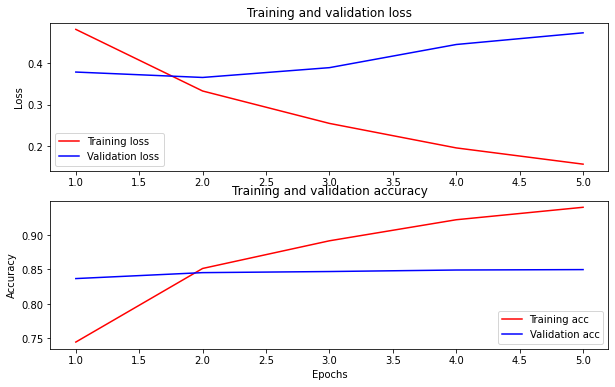

In [21]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In this plot, the red lines represent the training loss and accuracy, and the blue lines are the validation loss and accuracy.

## Export for inference

Now you just save your fine-tuned model for later use.

In [22]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

2021-10-26 11:19:50.728949: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Let's reload the model, so you can try it side by side with the model that is still in memory.

In [23]:
reloaded_model = tf.saved_model.load(saved_model_path)

Here you can test your model on any sentence you want, just add to the examples variable below.

In [24]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.999370
input: The movie was great!           : score: 0.997479
input: The movie was meh.             : score: 0.989318
input: The movie was okish.           : score: 0.485760
input: The movie was terrible...      : score: 0.000888

Results from the model in memory:
input: this is such an amazing movie! : score: 0.999370
input: The movie was great!           : score: 0.997479
input: The movie was meh.             : score: 0.989318
input: The movie was okish.           : score: 0.485760
input: The movie was terrible...      : score: 0.000888



If you want to use your model on [TF Serving](https://www.tensorflow.org/tfx/guide/serving), remember that it will call your SavedModel through one of its named signatures. In Python, you can test them as follows:

In [25]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: this is such an amazing movie! : score: 0.999370
input: The movie was great!           : score: 0.997479
input: The movie was meh.             : score: 0.989318
input: The movie was okish.           : score: 0.485760
input: The movie was terrible...      : score: 0.000888



## Next steps

As a next step, you can try [Solve GLUE tasks using BERT on a TPU tutorial](https://www.tensorflow.org/text/tutorials/bert_glue), which runs on a TPU and shows you how to work with multiple inputs.